# Description of the project

You are a Data Sciense specialist at a carsharing company. You have received an order: you need to create a system that could assess the risk of an accident along the selected route. Risk refers to the probability of an accident with any damage to the vehicle. As soon as the driver has booked a car, got behind the wheel and chosen a route, the system should assess the level of risk. If the risk level is high, the driver will see a warning and recommendations along the route.
The idea of creating such a system is under preliminary discussion and elaboration. There is no clear algorithm of operation and similar solutions on the market yet. The current task is to understand whether it is possible to predict an accident based on historical data from one of the regions.

The idea of solving the problem from the customer: 

* Create an accident prediction model (the target value is at_fault (culprit) in the parties table)
    * For the model, select the type of culprit — car only.
    * Select cases where an accident has caused any damage to the vehicle, except for the SCRATCH type.
    * For modeling, limit yourself to data for 2012 — they are the most recent.
    * A prerequisite is to take into account the age factor of the car.
    
* Based on the model, to investigate the main factors of an accident.

* To understand whether the results of modeling and analysis of the importance of factors will help answer the questions:
    * Is it possible to create an adequate driver risk assessment system when issuing a car?
    * What other factors should be considered?
    * Do I need to equip the car with any sensors or camera?

The customer suggests that you work with the incident database and form your own ideas for creating such a system.

**The database looks like this:**


## Imports the necessary libraries

In [8]:
import numpy as np
import pandas as pd
import phik
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from phik.report import plot_correlation_matrix
from phik import report

from sqlalchemy import create_engine

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
      
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder
)

from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    f1_score,
    make_scorer,
    recall_score,
    precision_score
)

from catboost import (
    CatBoostClassifier, 
    Pool, 
    cv
)

# 1. Connect to the database. Download the sql tables

In [9]:
pd.set_option('display.max_columns', None)

In [10]:
db_config = {
'user': '***',
'pwd': '***',
'host': '***',
'port': ***,
'db': '***',
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Creating a connection

In [11]:
engine = create_engine(connection_string) 

The connection to the database was completed successfully

# 2. Conduct an initial study of the tables

### Vehicles table

In [12]:
query = '''
SELECT *
FROM vehicles
LIMIT 10;
'''

vehicles = pd.read_sql_query(query, con=engine) 

In [13]:
vehicles

id  case_id  party_number vehicle_type vehicle_transmission  \
0  1175713  5305032             2        sedan               manual   
1        1  3858022             1        sedan                 auto   
2  1175712  5305030             1        sedan                 auto   
3  1175717  5305033             3        sedan                 auto   
4  1175722  5305034             2        sedan                 auto   
5  1175737  5305046             2        sedan                 auto   
6  1175750  5305053             3        sedan                 auto   
7  1175715  5305033             1        sedan               manual   
8  1175716  5305033             2        sedan               manual   
9  1175758  5305060             2        sedan                 auto   

   vehicle_age  
0            3  
1            3  
2            3  
3            5  
4            5  
5            5  
6            9  
7           10  
8            4  
9           11

In [14]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    10 non-null     int64 
 1   case_id               10 non-null     object
 2   party_number          10 non-null     int64 
 3   vehicle_type          10 non-null     object
 4   vehicle_transmission  10 non-null     object
 5   vehicle_age           10 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


### The parties table

In [15]:
query = '''
SELECT *
FROM parties
LIMIT 10;
'''

parties = pd.read_sql_query(query, con=engine) 

In [16]:
parties

id  case_id  party_number   party_type  at_fault  insurance_premium  \
0  22  3899454             1   road signs         1               29.0   
1  23  3899454             2   road signs         0                7.0   
2  29  3899462             2          car         0               21.0   
3  31  3899465             2   road signs         0               24.0   
4  41  3899478             2  road bumper         0                NaN   
5  43  3899481             2  road bumper         0                NaN   
6  72  3899505             2  road bumper         0                NaN   
7  73  3899505             3  road bumper         0                NaN   
8  76  3899509             1  road bumper         0                NaN   
9  93  3981292             2  road bumper         0                NaN   

          party_sobriety party_drug_physical  cellphone_in_use  
0  had not been drinking                None               0.0  
1  had not been drinking                None               0.0  
2  had not been drinking                None               0.0  
3  had not been drinking                None               0.0  
4         not applicable      not applicable               0.0  
5         not applicable      not applicable               0.0  
6         not applicable      not applicable               0.0  
7         not applicable      not applicable               0.0  
8  had not been drinking                None               0.0  
9  had not been drinking                None               NaN

In [17]:
parties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10 non-null     int64  
 1   case_id              10 non-null     object 
 2   party_number         10 non-null     int64  
 3   party_type           10 non-null     object 
 4   at_fault             10 non-null     int64  
 5   insurance_premium    4 non-null      float64
 6   party_sobriety       10 non-null     object 
 7   party_drug_physical  4 non-null      object 
 8   cellphone_in_use     9 non-null      float64
dtypes: float64(2), int64(3), object(4)
memory usage: 848.0+ bytes


### The case_idc table

In [18]:
query = '''
SELECT case_id, CAST(db_year AS INT)
FROM case_ids
LIMIT 10;
'''

case_ids = pd.read_sql_query(query, con=engine) 

In [19]:
case_ids

case_id  db_year
0  0081715     2021
1  0726202     2021
2  3858022     2021
3  3899441     2021
4  3899442     2021
5  3899445     2021
6  3899446     2021
7  3899449     2021
8  3899450     2021
9  3899453     2021

In [20]:
case_ids['db_year'].value_counts()

2021    10
Name: db_year, dtype: int64

For us, this table is useless. It has only a list of IDs, the db_year column consists of only one value 2021

**We will answer the questions from the assignment:**

* Do all tables have a data set;

    <i>No, the case_id table has only a list of case_ids, and the db_year column has only one unique value "2021"</i>
    
    
* Does the number of tables match the task condition;

    <i>No, nothing was said about the case_ids table in the task</i>


* Is there a shared key for linking tables
        
    <i>Yes, I linked tables by case_id, which is in all tables</i>

# 3. Conduct a statistical analysis of the accident factors

## Find out which months have the highest number of accidents. Analyze the entire observation period (collisions table).

Using an sql query, we will output the collisions table. Let's add the month of accidents and their number in this month to this table. Let's limit ourselves to full years.

In [21]:
%%time
query = '''
SELECT *, CAST((DATE_TRUNC('MONTH', collision_date)) AS DATE) AS month,
 COUNT(case_id) OVER(PARTITION BY DATE_TRUNC('MONTH', collision_date))
FROM collisions
WHERE collision_date < '2012-01-01'
'''

collisions = pd.read_sql_query(query, con=engine)

Wall time: 5min 36s


In [22]:
collisions.head()

case_id county_city_location county_location  distance direction  \
0  4601613                 2708        monterey       0.0      None   
1  4569327                 3610  san bernardino      16.0     south   
2  4561443                 3300       riverside      78.0     south   
3  4584838                 3610  san bernardino       0.0      None   
4  4568592                 3610  san bernardino     450.0     south   

   intersection weather_1 location_type collision_damage  party_count  \
0           1.0     clear          None    middle damage            2   
1           0.0     clear          None    middle damage            2   
2           0.0     clear          None    middle damage            1   
3           1.0   raining          None    middle damage            2   
4           NaN     clear       highway    middle damage            3   

  primary_collision_factor     pcf_violation_category type_of_collision  \
0   vehicle code violation  other hazardous violation         sideswipe   
1   vehicle code violation    automobile right of way        hit object   
2   vehicle code violation           improper turning        overturned   
3   vehicle code violation    automobile right of way         broadside   
4   vehicle code violation                        dui         sideswipe   

  motor_vehicle_involved_with road_surface road_condition_1  lighting  \
0                     bicycle          dry           normal  daylight   
1                fixed object          dry           normal  daylight   
2               non-collision          dry           normal  daylight   
3         other motor vehicle          wet           normal  daylight   
4         other motor vehicle          dry           normal  daylight   

  control_device collision_date collision_time       month  count  
0           none     2009-01-07       14:54:00  2009-01-01  35062  
1    functioning     2009-01-12       08:06:00  2009-01-01  35062  
2           none     2009-01-11       09:10:00  2009-01-01  35062  
3    functioning     2009-01-23       09:29:00  2009-01-01  35062  
4           none     2009-01-10       12:17:00  2009-01-01  35062

We will allocate information with columns about the month and the number of accidents to a separate dataframe

In [23]:
count_of_collisions_month = collisions[['month', 'count']].drop_duplicates().sort_values('month').set_index('month')
count_of_collisions_month.head()

count
month            
2009-01-01  35062
2009-02-01  34480
2009-03-01  36648
2009-04-01  35239
2009-05-01  36916

Let's build a bar chart, where the y-axis is the number of accidents, and the x-axis is the year and month

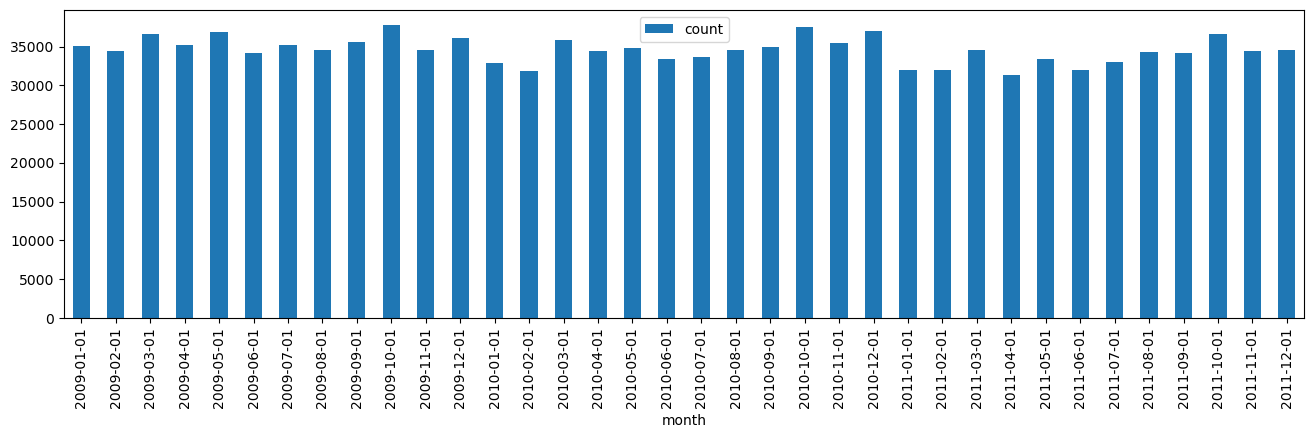

In [24]:
count_of_collisions_month.plot.bar(y='count', figsize=(16, 4))
plt.show()

Let's try to group the data a little differently. Let's group the data first by month, and then only by year. We will also depict this on a graph

In [25]:
count_of_collisions_month['y'] = pd.DatetimeIndex(count_of_collisions_month.reset_index()['month']).year
count_of_collisions_month['m'] = pd.DatetimeIndex(count_of_collisions_month.reset_index()['month']).month

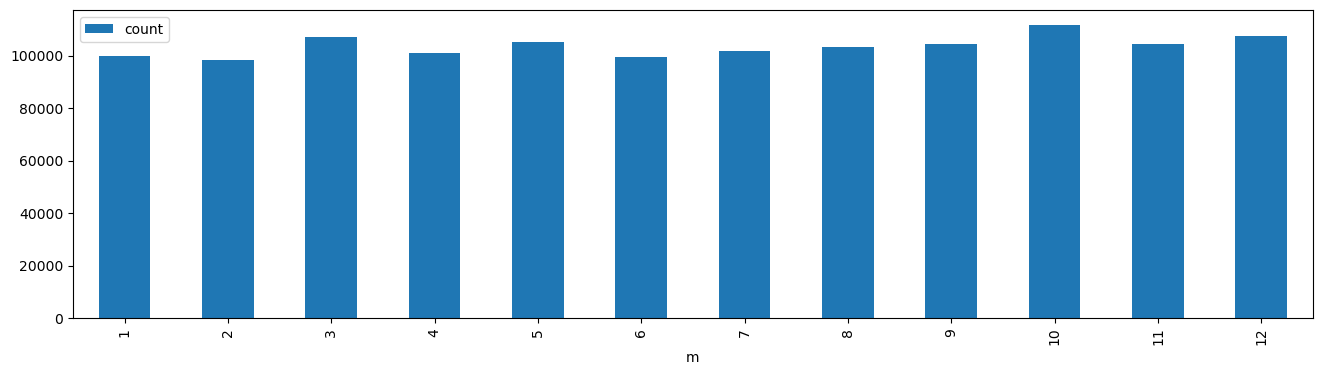

In [26]:
count_of_collisions_month.groupby(['m']).agg({'count': 'sum'}).plot.bar(y='count', figsize=(16, 4))
plt.show()

Looking at this graph, you can find a pattern that in most cases the number of accidents decreases every year. Well, or at least it does not increase


# 4. Create a model to assess driving risk

### First, we will create an sql query to create a dataframe, which we will work with further

First, using INNER JOIN, we will combine collisions with parties by case_id, and after that we will combine the resulting table with vehicles by case_id and party_number also using INNER JOIN. It was possible to use LEFT JOIN, but according to the assignment, we need to use data only about cars. Let's leave only cars in the party_type. And we will leave the data only for 2012

In [27]:
%%time
query = '''
WITH t AS
    (SELECT c.*, 
        p.id AS party_id,
        p.party_number,
        p.party_type,
        p.at_fault,
        p.insurance_premium,
        p.party_sobriety,
        p.party_sobriety,
        p.cellphone_in_use
    FROM collisions AS c
    INNER JOIN parties AS p ON c.case_id = p.case_id)
    
SELECT t.*,
    v.id as vehicle_id,
    v.vehicle_type,
    v.vehicle_transmission,
    v.vehicle_age

FROM t
INNER JOIN vehicles AS v ON t.case_id = v.case_id AND t.party_number = v.party_number
WHERE (t.party_type = 'car') 
    AND (EXTRACT(YEAR FROM collision_date) = 2012) 
    AND (v.vehicle_age < 161) 
    AND (t.collision_damage != 'scratch')
'''

df = pd.read_sql_query(query, con=engine) 

Wall time: 19.3 s


In [28]:
df.head()

case_id county_city_location county_location  distance direction  \
0  5600893                 2908          nevada     190.0      east   
1  5603123                 1600           kings    2640.0      east   
2  5455644                 4806          solano     350.0     south   
3  5455686                 3906     san joaquin     400.0      west   
4  5455744                 1908     los angeles     500.0      east   

   intersection weather_1 location_type collision_damage  party_count  \
0           0.0     clear          None     small damage            1   
1           0.0    cloudy       highway     small damage            2   
2           0.0    cloudy          ramp     small damage            3   
3           0.0       fog       highway     small damage            1   
4           0.0     clear       highway     small damage            2   

  primary_collision_factor pcf_violation_category type_of_collision  \
0   vehicle code violation                    dui        hit object   
1   vehicle code violation     unsafe lane change         sideswipe   
2   vehicle code violation               speeding          rear end   
3   vehicle code violation       improper turning        hit object   
4   vehicle code violation     unsafe lane change         sideswipe   

  motor_vehicle_involved_with road_surface road_condition_1  \
0                other object          dry           normal   
1         other motor vehicle          wet           normal   
2         other motor vehicle          dry           normal   
3                fixed object          dry           normal   
4         other motor vehicle          dry           normal   

                     lighting control_device collision_date collision_time  \
0  dark with no street lights           none     2012-04-21       00:50:00   
1                    daylight           none     2012-04-13       14:34:00   
2                    daylight           none     2012-01-02       15:32:00   
3  dark with no street lights    functioning     2012-01-01       03:00:00   
4                    daylight           none     2012-01-08       15:25:00   

   party_id  party_number party_type  at_fault  insurance_premium  \
0   2659617             1        car         1               38.0   
1   2662923             1        car         1               20.0   
2   2407865             3        car         1               22.0   
3   2407938             1        car         1               30.0   
4   2408051             1        car         1               20.0   

                       party_sobriety                      party_sobriety  \
0  had been drinking, under influence  had been drinking, under influence   
1               had not been drinking               had not been drinking   
2               had not been drinking               had not been drinking   
3               had not been drinking               had not been drinking   
4               had not been drinking               had not been drinking   

   cellphone_in_use  vehicle_id vehicle_type vehicle_transmission  vehicle_age  
0               0.0     1465137        sedan                 auto            6  
1               0.0     1466829        sedan                 auto           11  
2               0.0     1327255        sedan               manual            3  
3               0.0     1327306        sedan               manual            3  
4               0.0     1327383        sedan               manual            3

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54552 entries, 0 to 54551
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   case_id                      54552 non-null  object 
 1   county_city_location         54552 non-null  object 
 2   county_location              54552 non-null  object 
 3   distance                     54552 non-null  float64
 4   direction                    42096 non-null  object 
 5   intersection                 54384 non-null  float64
 6   weather_1                    54387 non-null  object 
 7   location_type                25510 non-null  object 
 8   collision_damage             54552 non-null  object 
 9   party_count                  54552 non-null  int64  
 10  primary_collision_factor     54455 non-null  object 
 11  pcf_violation_category       53831 non-null  object 
 12  type_of_collision            54262 non-null  object 
 13  motor_vehicle_in

In [30]:
df['control_device'].value_counts()

none               36678
functioning        17527
not functioning      112
obscured              29
Name: control_device, dtype: int64

Let's check if the classes are balanced

In [31]:
df['at_fault'].value_counts(normalize=True)

1    0.504839
0    0.495161
Name: at_fault, dtype: float64

There is no big difference in classes. I think it is possible to use this dataframe

### I conducted a small analysis of all the features in the resulting dataframe, which is shown in the image below

It was based on understanding the task in such a way where we need to evaluate the driver before renting a car to him. I described below why and which features I consider correct and which are not.

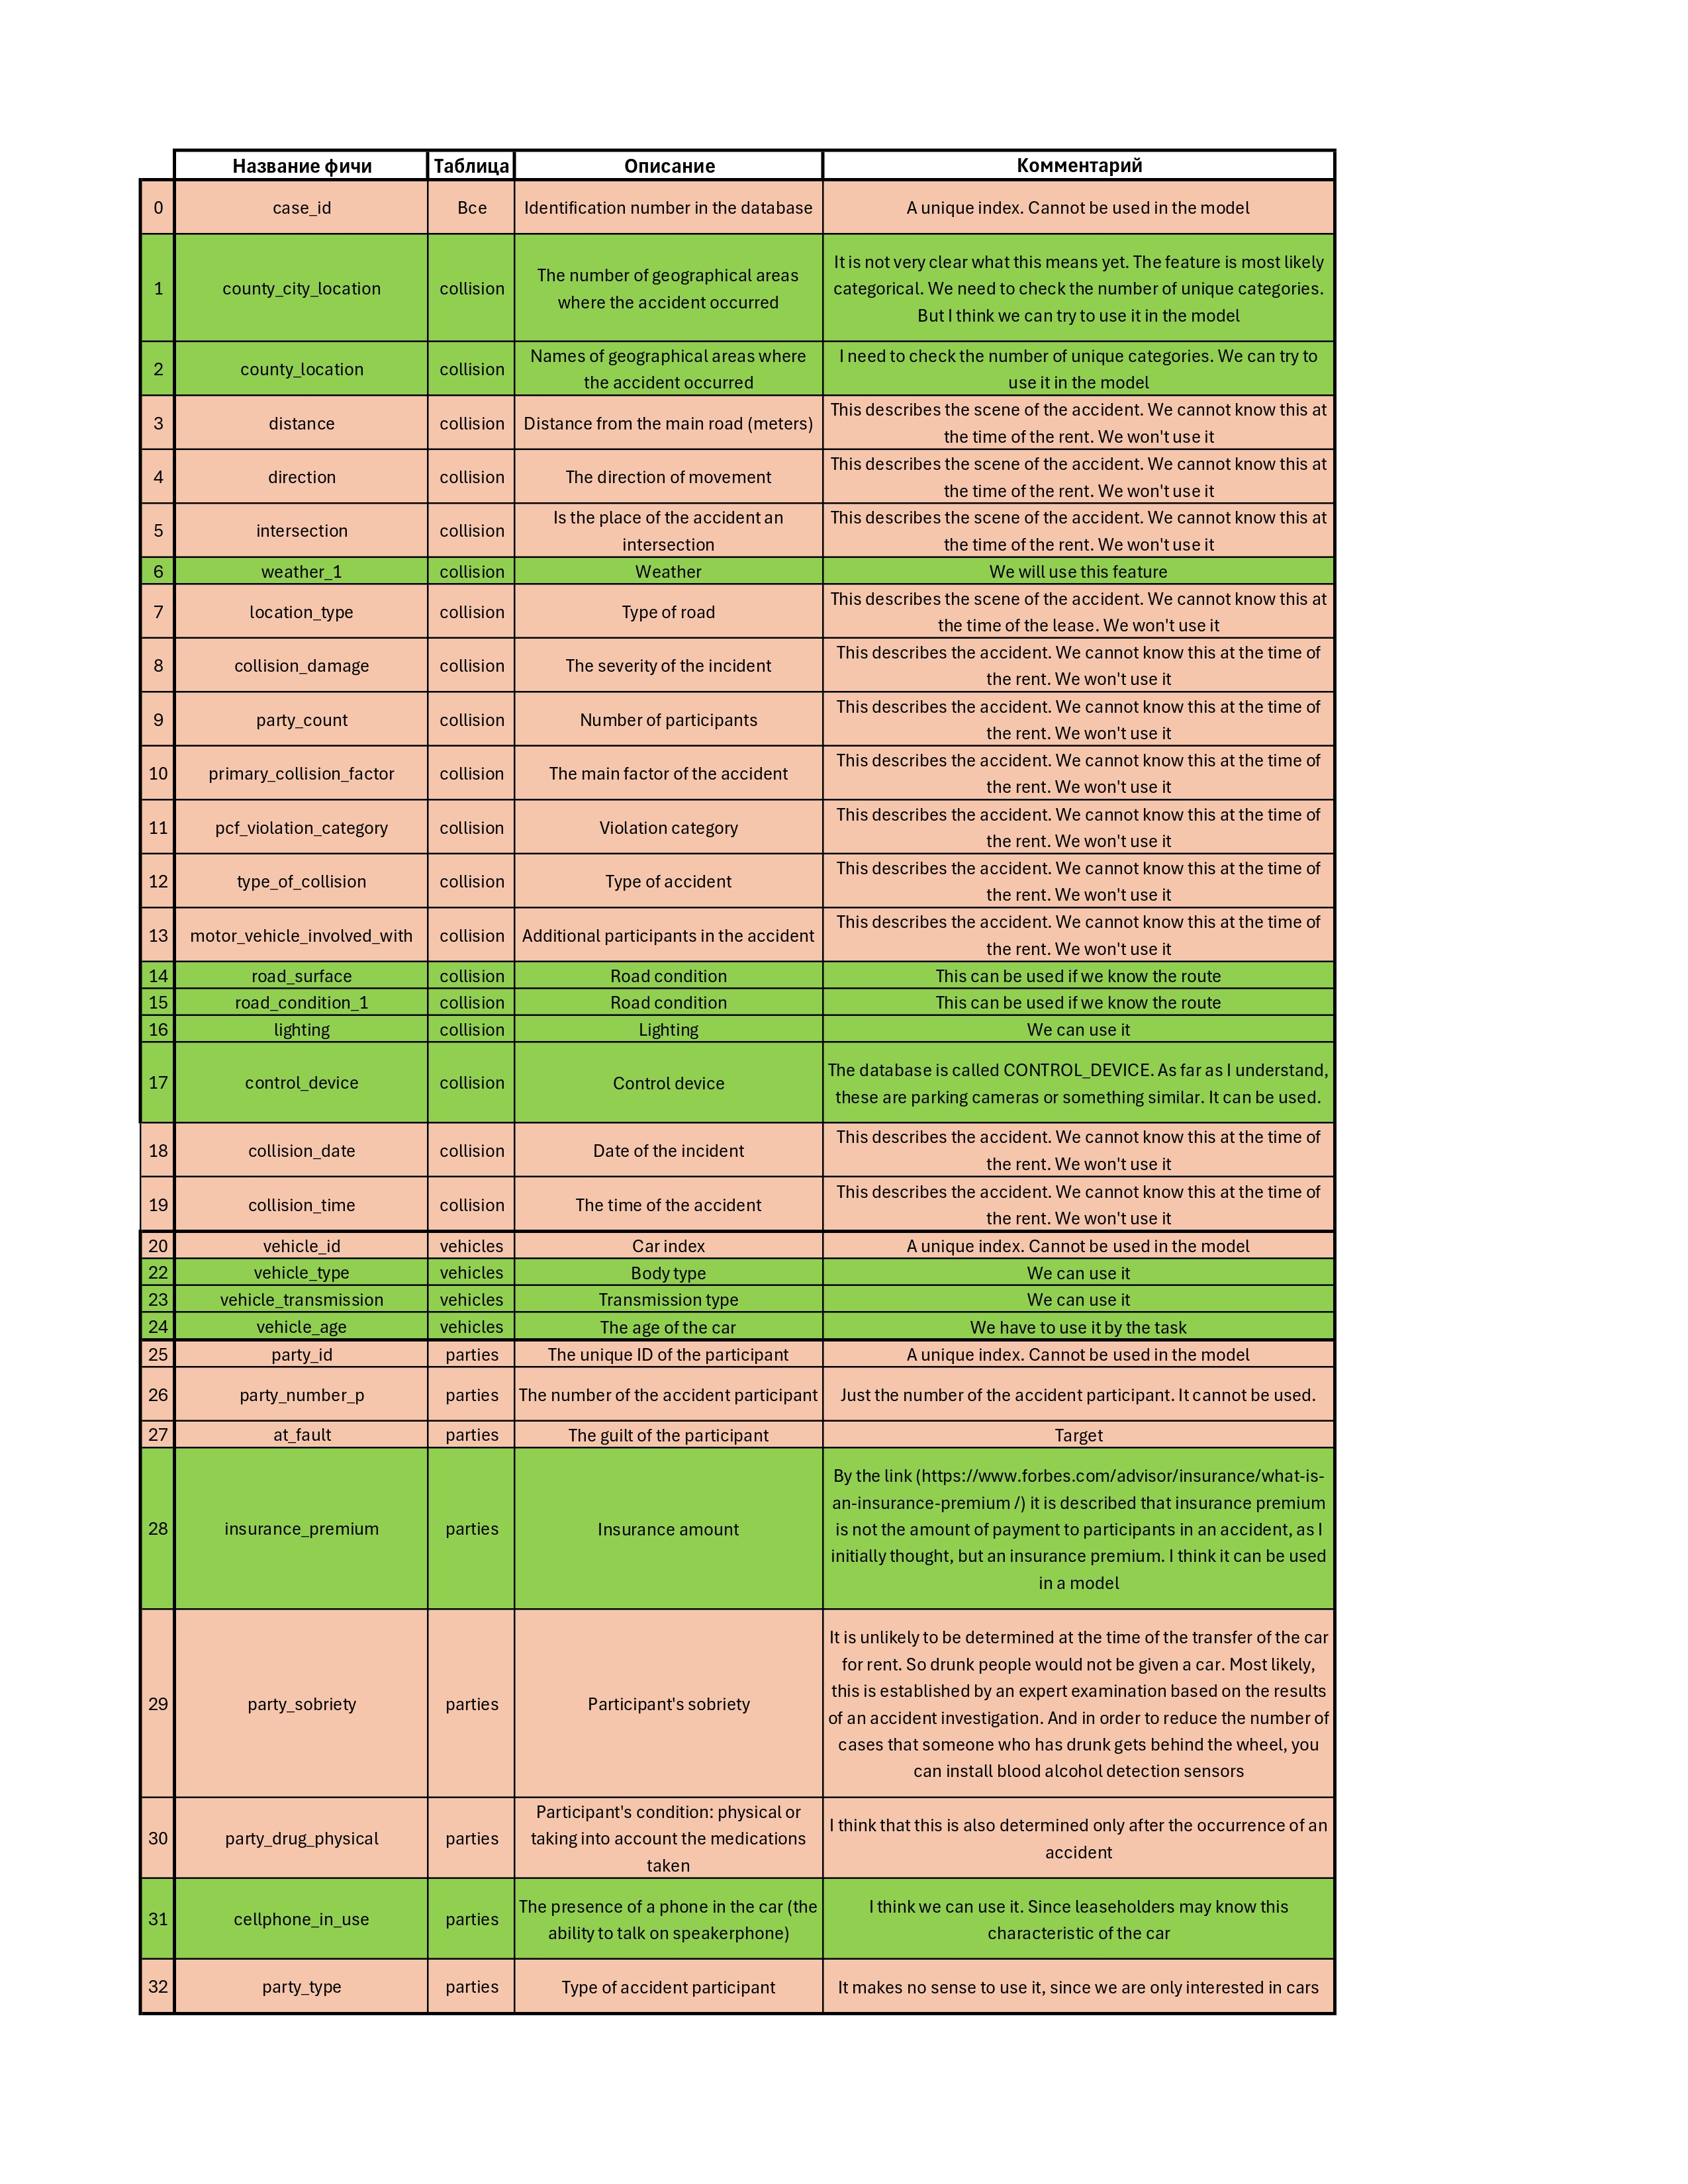

According to the table above, we will highlight the features for the models

In [32]:
list_of_useful_features = [
    'county_city_location',
    'county_location',
    'weather_1',
    'road_surface',
    'road_condition_1',
    'lighting',
    'control_device',
    'vehicle_type',
    'vehicle_transmission',
    'vehicle_age',
    'insurance_premium',
    'cellphone_in_use',
    'direction',
    'location_type'
]

Let's create a dataframe with features

In [33]:
X = df[list_of_useful_features]
X.head()

county_city_location county_location weather_1 road_surface  \
0                 2908          nevada     clear          dry   
1                 1600           kings    cloudy          wet   
2                 4806          solano    cloudy          dry   
3                 3906     san joaquin       fog          dry   
4                 1908     los angeles     clear          dry   

  road_condition_1                    lighting control_device vehicle_type  \
0           normal  dark with no street lights           none        sedan   
1           normal                    daylight           none        sedan   
2           normal                    daylight           none        sedan   
3           normal  dark with no street lights    functioning        sedan   
4           normal                    daylight           none        sedan   

  vehicle_transmission  vehicle_age  insurance_premium  cellphone_in_use  \
0                 auto            6               38.0               0.0   
1                 auto           11               20.0               0.0   
2               manual            3               22.0               0.0   
3               manual            3               30.0               0.0   
4               manual            3               20.0               0.0   

  direction location_type  
0      east          None  
1      east       highway  
2     south          ramp  
3      west       highway  
4      east       highway

In [34]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54552 entries, 0 to 54551
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_city_location  54552 non-null  object 
 1   county_location       54552 non-null  object 
 2   weather_1             54387 non-null  object 
 3   road_surface          54223 non-null  object 
 4   road_condition_1      54315 non-null  object 
 5   lighting              54400 non-null  object 
 6   control_device        54346 non-null  object 
 7   vehicle_type          54552 non-null  object 
 8   vehicle_transmission  53977 non-null  object 
 9   vehicle_age           54552 non-null  int64  
 10  insurance_premium     54133 non-null  float64
 11  cellphone_in_use      50382 non-null  float64
 12  direction             42096 non-null  object 
 13  location_type         25510 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 5.8+ MB


### Let's start studying the features

### county_city_location

Let's output the unique values and their share in the dataframe

In [35]:
X['county_city_location'].value_counts(normalize=True)

1942    0.123424
1900    0.040347
3711    0.024050
3400    0.019614
3600    0.018276
          ...   
0110    0.000018
2803    0.000018
2703    0.000018
1701    0.000018
2804    0.000018
Name: county_city_location, Length: 494, dtype: float64

We have 494 unique values. Let's build a barplot

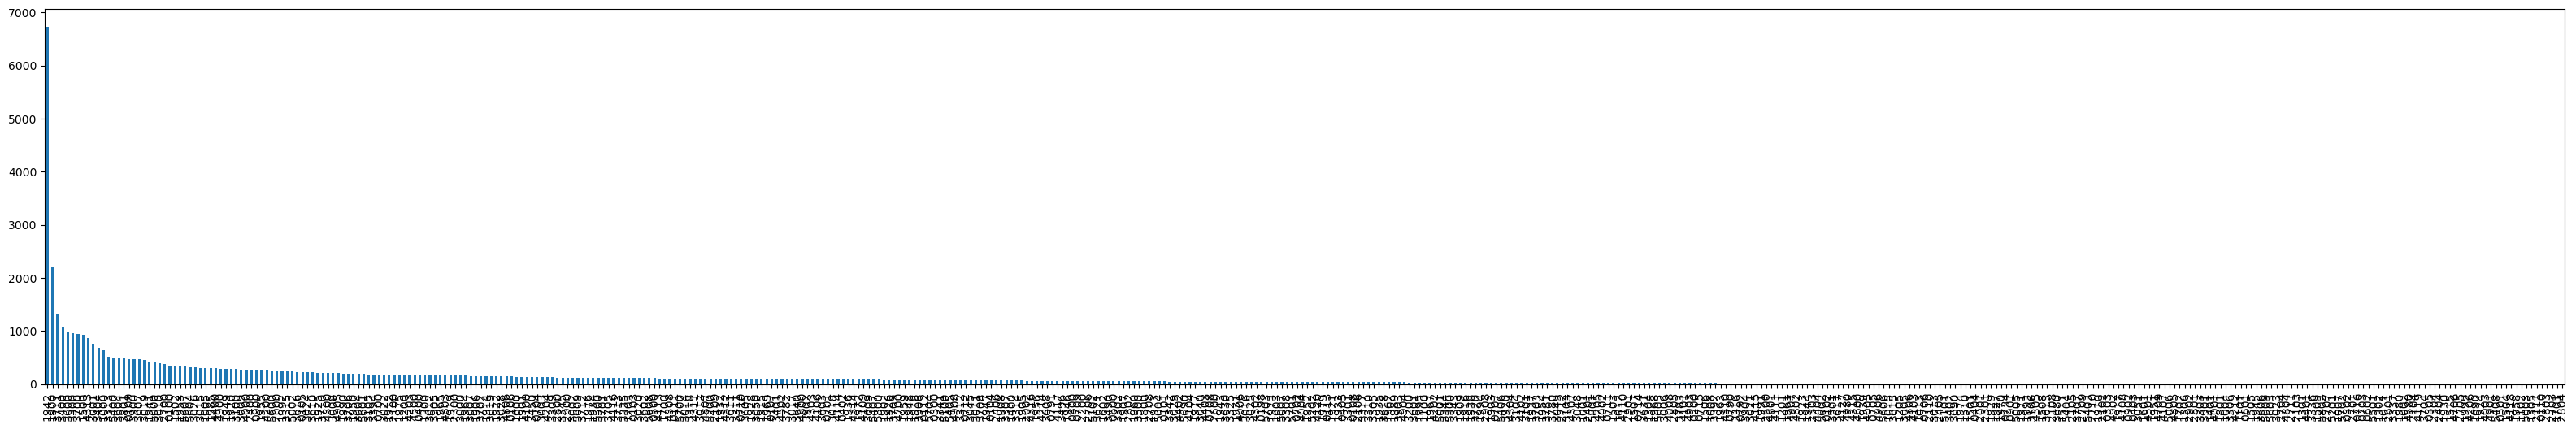

In [36]:
X['county_city_location'].value_counts().plot.bar(figsize=(40, 6))
plt.show()

There are quite a few unique values. After checking the country_location feature in the next step, I realized that it was better to leave it instead of county_city_location. Since the car could be rented in one area, and the path would run through others. We do not have specific information about the route of movement. So it's hard to guess how the driver is going to build his way.

In [37]:
X['county_city_location'].value_counts(normalize=True)[X['county_city_location'].value_counts(normalize=True).cumsum() > 0.8]

0710    0.001815
3605    0.001760
1928    0.001741
3050    0.001705
1915    0.001705
          ...   
0110    0.000018
2803    0.000018
2703    0.000018
1701    0.000018
2804    0.000018
Name: county_city_location, Length: 358, dtype: float64

In [38]:
X = X.drop('county_city_location', axis=1)

#### county_location

In [39]:
X['county_location'].value_counts(normalize=True)

los angeles        0.288037
orange             0.093104
san diego          0.067367
san bernardino     0.065845
riverside          0.058751
sacramento         0.038789
alameda            0.033693
santa clara        0.032611
ventura            0.026415
kern               0.025462
fresno             0.019376
contra costa       0.017525
san mateo          0.016773
san joaquin        0.016351
stanislaus         0.014408
santa barbara      0.012905
tulare             0.012832
sonoma             0.012410
placer             0.010210
monterey           0.010082
solano             0.009899
san francisco      0.008854
san luis obispo    0.007846
santa cruz         0.007736
merced             0.007021
marin              0.006618
madera             0.005866
humboldt           0.005848
butte              0.005719
el dorado          0.005243
shasta             0.005041
yolo               0.004876
kings              0.004473
napa               0.003813
imperial           0.003758
mendocino          0

Building a barplot

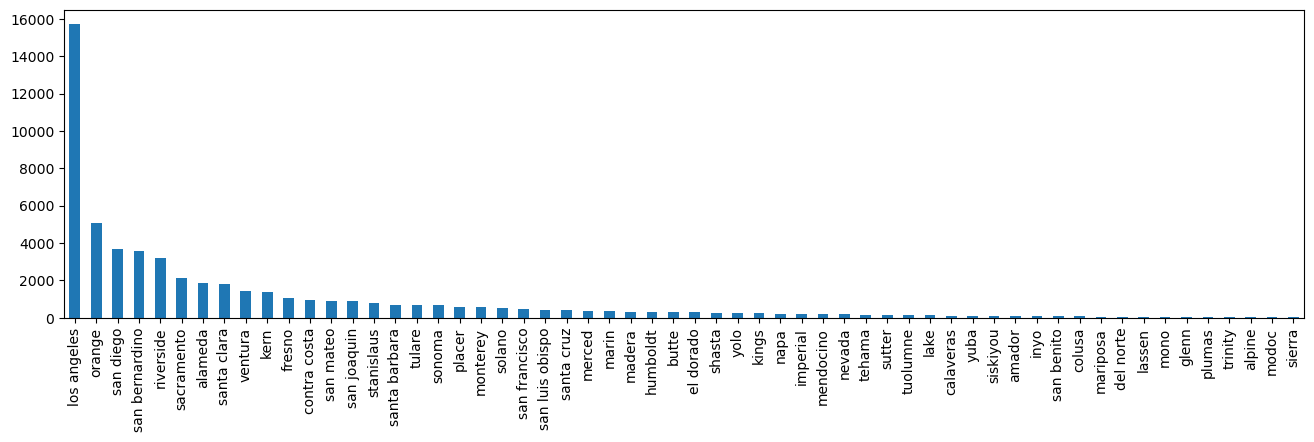

In [40]:
X['county_location'].value_counts().plot.bar(figsize=(16, 4))
plt.show()

There are no missing values, we will use the feature

#### weather_1

Let's check the unique values

In [41]:
X['weather_1'].value_counts()

clear      43724
cloudy      8178
raining     2115
fog          173
snowing      154
other         32
wind          11
Name: weather_1, dtype: int64

Let's chech missing values

In [42]:
X[X['weather_1'].isna()]['weather_1']

152      None
322      None
548      None
1003     None
1296     None
         ... 
54061    None
54082    None
54113    None
54268    None
54369    None
Name: weather_1, Length: 165, dtype: object

Fill in the gaps with other values

In [43]:
X.loc[X['weather_1'].isna(), 'weather_1'] = 'other'

Checking

In [44]:
X['weather_1'].value_counts()

clear      43724
cloudy      8178
raining     2115
other        197
fog          173
snowing      154
wind          11
Name: weather_1, dtype: int64

Building a barplot

In [45]:
X['weather_1'].value_counts().plot.bar(figsize=(16, 4))
plt.show()

#### road_surface

Let's check the unique values

In [46]:
X['road_surface'].value_counts()

dry         48711
wet          5119
snowy         351
slippery       42
Name: road_surface, dtype: int64

Let's check the missing values

In [47]:
X.loc[X['road_surface'].isna(), 'road_surface']

87       None
548      None
955      None
1003     None
1296     None
         ... 
53730    None
54062    None
54078    None
54148    None
54369    None
Name: road_surface, Length: 329, dtype: object

Fill in the gaps with unknown values

In [48]:
X.loc[X['road_surface'].isna(), 'road_surface'] = 'unknown'

Checking

In [49]:
X['road_surface'].value_counts()

dry         48711
wet          5119
snowy         351
unknown       329
slippery       42
Name: road_surface, dtype: int64

Building a barplot

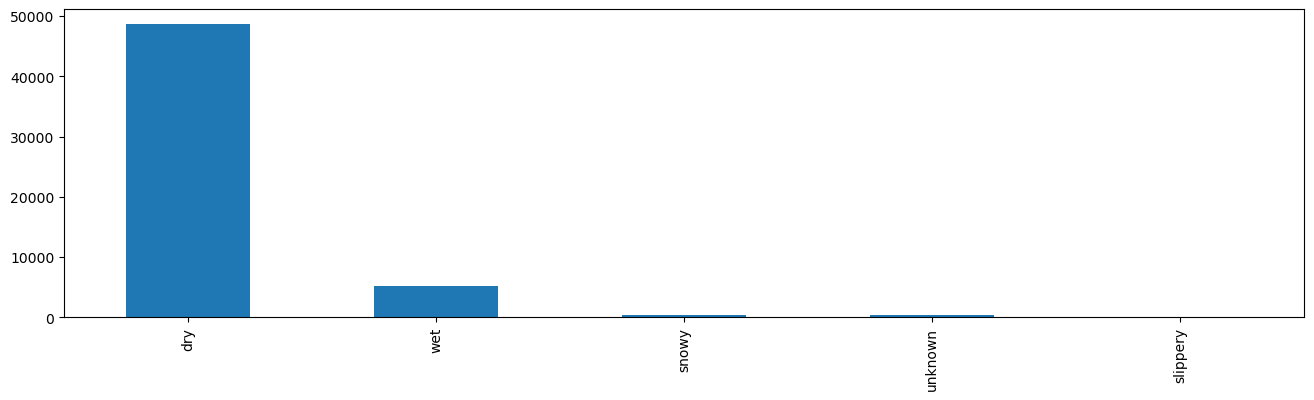

In [50]:
X['road_surface'].value_counts().plot.bar(figsize=(16, 4))
plt.show()

#### road_condition_1

Let's check the unique values

In [51]:
X['road_condition_1'].value_counts()

normal            52431
construction        987
obstruction         242
other               220
holes               215
loose material      125
reduced width        65
flooded              30
Name: road_condition_1, dtype: int64

Let's check the gaps

In [52]:
X.loc[X['road_condition_1'].isna(), 'road_condition_1']

9        None
317      None
548      None
562      None
808      None
         ... 
53298    None
53517    None
53907    None
53981    None
54369    None
Name: road_condition_1, Length: 237, dtype: object

Fill in the gaps with other values

In [53]:
X.loc[X['road_condition_1'].isna(), 'road_condition_1'] = 'other'

Let's check it out

In [54]:
X['road_condition_1'].value_counts()

normal            52431
construction        987
other               457
obstruction         242
holes               215
loose material      125
reduced width        65
flooded              30
Name: road_condition_1, dtype: int64

Building a barplot

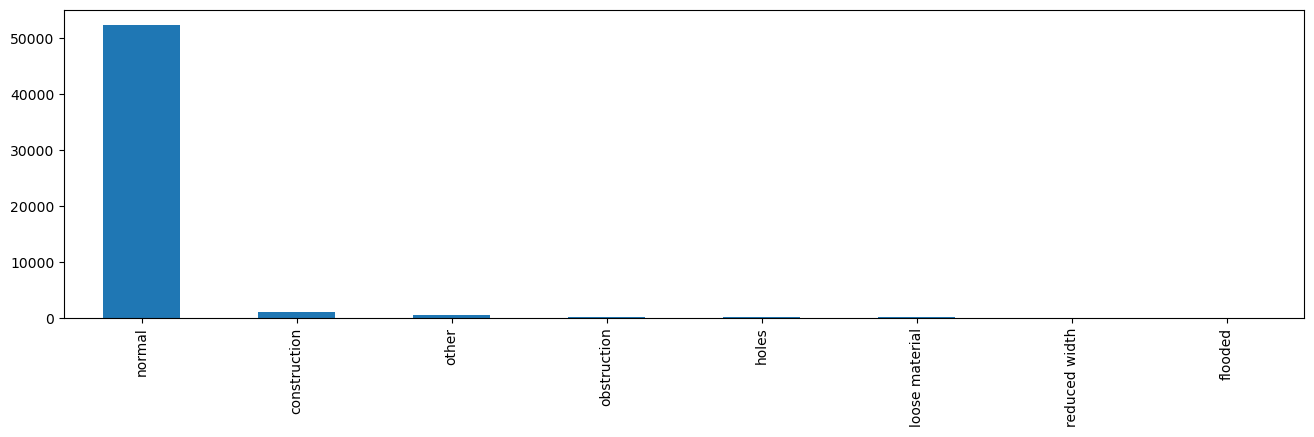

In [55]:
X['road_condition_1'].value_counts().plot.bar(figsize=(16, 4))
plt.show()

#### lighting

Let's check the unique values

In [56]:
X['lighting'].value_counts()

daylight                                   36906
dark with street lights                    10599
dark with no street lights                  5045
dusk or dawn                                1719
dark with street lights not functioning      131
Name: lighting, dtype: int64

Let's check missing values

In [57]:
X.loc[X['lighting'].isna(), 'lighting']

548      None
1003     None
1296     None
1951     None
1973     None
         ... 
52430    None
53298    None
53517    None
53784    None
54369    None
Name: lighting, Length: 152, dtype: object

Fill in the gaps with "unknown" values

In [58]:
X.loc[X['lighting'].isna(), 'lighting'] = 'unknown'

Checking result

In [59]:
X['lighting'].value_counts()

daylight                                   36906
dark with street lights                    10599
dark with no street lights                  5045
dusk or dawn                                1719
unknown                                      152
dark with street lights not functioning      131
Name: lighting, dtype: int64

Creating barplot

In [60]:
X['lighting'].value_counts().plot.bar(figsize=(16, 4))
plt.show()

#### control_device

Let's check the unique values

In [61]:
X['control_device'].value_counts()

none               36678
functioning        17527
not functioning      112
obscured              29
Name: control_device, dtype: int64

Let's check missing values

In [62]:
X.loc[X['control_device'].isna(), 'control_device']

159      None
223      None
573      None
884      None
911      None
         ... 
53517    None
53784    None
54027    None
54051    None
54180    None
Name: control_device, Length: 206, dtype: object

Fill in the gaps with none values

In [63]:
X.loc[X['control_device'].isna(), 'control_device'] = 'none'

Checking result

In [64]:
X['control_device'].value_counts()

none               36884
functioning        17527
not functioning      112
obscured              29
Name: control_device, dtype: int64

Creating barplot

In [65]:
X['control_device'].value_counts().plot.bar(figsize=(16, 4))
plt.show()

#### vehicle_type

Let's check the unique values

In [66]:
X['vehicle_type'].value_counts()

sedan    35513
coupe    19035
other        4
Name: vehicle_type, dtype: int64

Let's check missing values

In [67]:
X.loc[X['vehicle_type'].isna(), 'vehicle_type']

Series([], Name: vehicle_type, dtype: object)

#### vehicle_transmission

Let's check the unique values

In [68]:
X['vehicle_transmission'].value_counts()

manual    28589
auto      25388
Name: vehicle_transmission, dtype: int64

Let's check missing values

In [69]:
X.loc[X['vehicle_transmission'].isna(), 'vehicle_transmission']

86       None
269      None
306      None
335      None
341      None
         ... 
54254    None
54397    None
54401    None
54416    None
54417    None
Name: vehicle_transmission, Length: 575, dtype: object

Fill in the gaps with "unknown" values

In [70]:
X.loc[X['vehicle_transmission'].isna(), 'vehicle_transmission'] = 'unknown'

Checking result

In [71]:
X['vehicle_transmission'].value_counts()

manual     28589
auto       25388
unknown      575
Name: vehicle_transmission, dtype: int64

Creating barplot

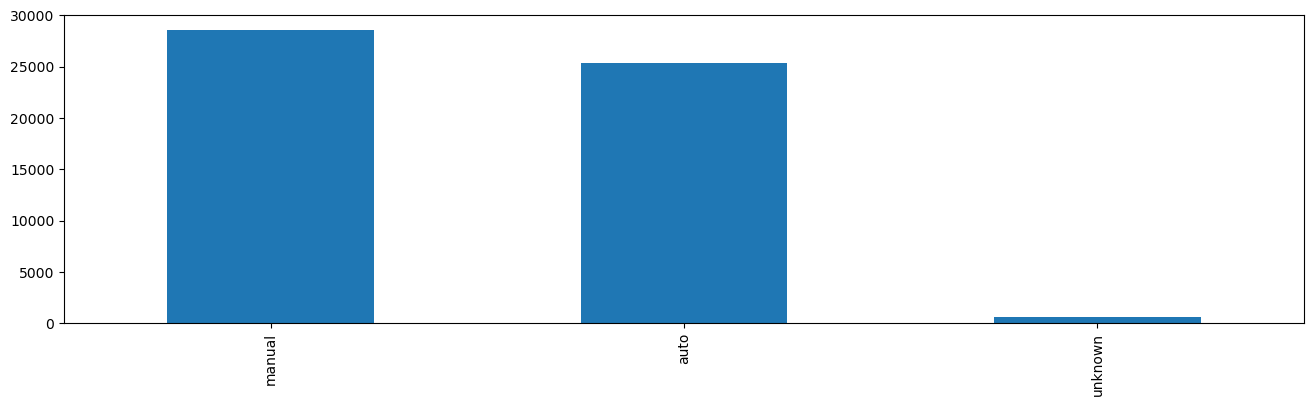

In [72]:
X['vehicle_transmission'].value_counts().plot.bar(figsize=(16, 4))
plt.show()

#### vehicle_age

Let's check the unique values

In [73]:
X['vehicle_age'].value_counts()

3     11012
4      7157
2      6048
5      5565
6      3940
7      3838
8      3509
0      3087
9      2770
1      2545
10     1942
11     1380
12      879
13      551
14      282
15       37
16        6
17        3
19        1
Name: vehicle_age, dtype: int64

Let's check missing values

In [74]:
X.loc[X['vehicle_age'].isna(), 'vehicle_age']

Series([], Name: vehicle_age, dtype: int64)

Fill in the gaps with median values

In [75]:
age_median = X.loc[:, 'vehicle_age'].median()

In [76]:
X.loc[X['vehicle_age'].isna(), 'vehicle_age'] = age_median

Checking result

In [77]:
X['vehicle_age'].value_counts()

3     11012
4      7157
2      6048
5      5565
6      3940
7      3838
8      3509
0      3087
9      2770
1      2545
10     1942
11     1380
12      879
13      551
14      282
15       37
16        6
17        3
19        1
Name: vehicle_age, dtype: int64

Creating barplot

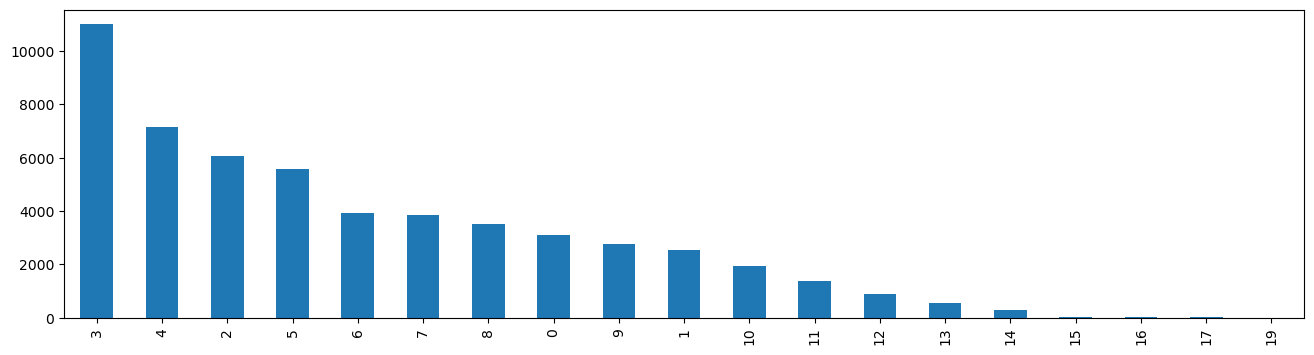

In [78]:
X['vehicle_age'].value_counts().plot.bar(figsize=(16, 4))
plt.show()

#### vehicle_transmission

Let's check the unique values

In [79]:
X['vehicle_transmission'].value_counts()

manual     28589
auto       25388
unknown      575
Name: vehicle_transmission, dtype: int64

Let's check missing values

In [80]:
X.loc[X['vehicle_transmission'].isna(), 'vehicle_transmission']

Series([], Name: vehicle_transmission, dtype: object)

Fill in the gaps with "unknown" values

In [81]:
X.loc[X['vehicle_transmission'].isna(), 'vehicle_transmission'] = 'unknown'

Checking result

In [82]:
X['vehicle_transmission'].value_counts()

manual     28589
auto       25388
unknown      575
Name: vehicle_transmission, dtype: int64

#### insurance_premium

Let's check the unique values

In [83]:
X['insurance_premium'].value_counts()

19.0     2101
21.0     2075
20.0     2038
22.0     1875
18.0     1766
         ... 
100.0       1
102.0       1
101.0       1
105.0       1
2.0         1
Name: insurance_premium, Length: 102, dtype: int64

Let's check missing values

In [84]:
X.loc[X['insurance_premium'].isna(), 'insurance_premium']

34      NaN
272     NaN
311     NaN
374     NaN
761     NaN
         ..
53173   NaN
53191   NaN
53310   NaN
53353   NaN
53376   NaN
Name: insurance_premium, Length: 419, dtype: float64

Fill in the gaps with median values

In [85]:
ins_median = X.loc[:, 'insurance_premium'].median()
ins_median

34.0

In [86]:
X.loc[X['insurance_premium'].isna(), 'insurance_premium'] = ins_median

Checking result

In [87]:
X['insurance_premium'].value_counts()

19.0     2101
21.0     2075
20.0     2038
22.0     1875
18.0     1766
         ... 
100.0       1
102.0       1
101.0       1
105.0       1
2.0         1
Name: insurance_premium, Length: 102, dtype: int64

Creating a histogram

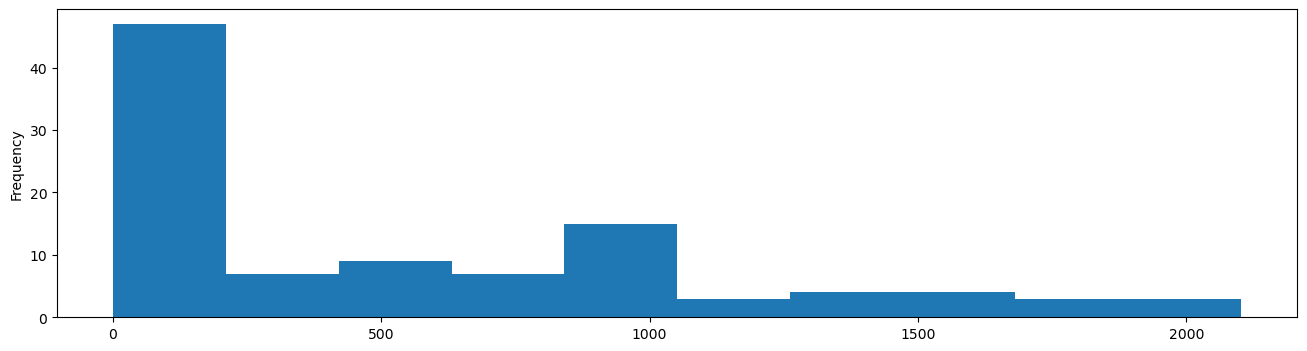

In [88]:
X['insurance_premium'].value_counts().plot.hist(figsize=(16, 4))
plt.show()

#### cellphone_in_use

Let's check the unique values

In [89]:
X['cellphone_in_use'].value_counts()

0.0    49362
1.0     1020
Name: cellphone_in_use, dtype: int64

Let's check missing values

In [90]:
X.loc[X['cellphone_in_use'].isna(), 'cellphone_in_use']

6       NaN
9       NaN
29      NaN
54      NaN
64      NaN
         ..
54505   NaN
54512   NaN
54531   NaN
54534   NaN
54535   NaN
Name: cellphone_in_use, Length: 4170, dtype: float64

There are 4170 missing values. Fill them with zeros

In [91]:
X.loc[X['cellphone_in_use'].isna(), 'cellphone_in_use'] = 0

Checking result

In [92]:
X['cellphone_in_use'].value_counts()

0.0    53532
1.0     1020
Name: cellphone_in_use, dtype: int64

Creating barplot

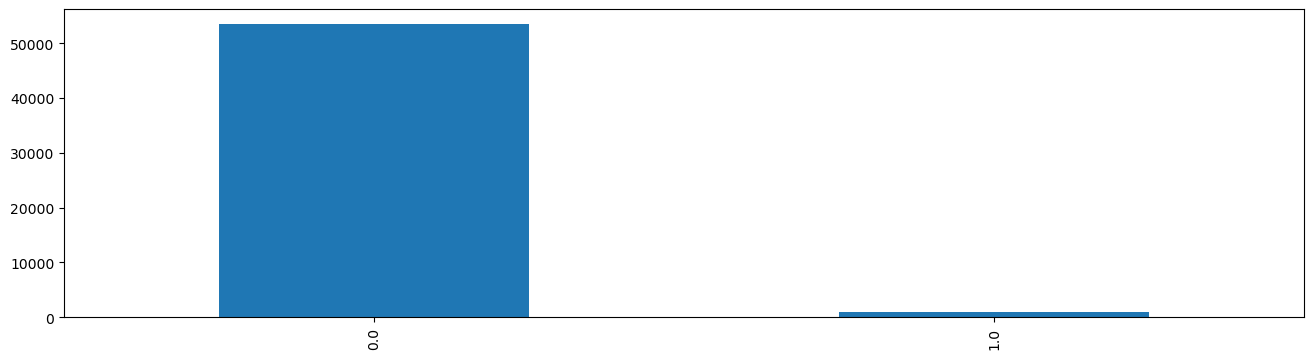

In [93]:
X['cellphone_in_use'].value_counts().plot.bar(figsize=(16, 4))
plt.show()

#### direction

Let's check the unique values

In [94]:
X['direction'].value_counts()

north    11823
south    11577
west      9450
east      9246
Name: direction, dtype: int64

Let's check missing values

In [95]:
X.loc[X['direction'].isna(), 'direction']

14       None
25       None
31       None
33       None
37       None
         ... 
54538    None
54539    None
54541    None
54543    None
54551    None
Name: direction, Length: 12456, dtype: object

Fill in the gaps with the "unknown" value

In [96]:
X.loc[X['direction'].isna(), 'direction'] = 'unknown'

Checking result

In [97]:
X['direction'].value_counts()

unknown    12456
north      11823
south      11577
west        9450
east        9246
Name: direction, dtype: int64

Creating barplot

In [98]:
X['direction'].value_counts().plot.bar(figsize=(16, 4))
plt.show()

In [99]:
X = X.drop('direction', axis=1)

Deleted it. It didn't improve the metric

#### location_type

Let's check the unique values

In [100]:
X['location_type'].value_counts()

highway         21015
ramp             3198
intersection     1297
Name: location_type, dtype: int64

Let's check missing values

In [101]:
X.loc[X['location_type'].isna(), 'location_type']

0        None
5        None
6        None
8        None
9        None
         ... 
54543    None
54546    None
54548    None
54549    None
54551    None
Name: location_type, Length: 29042, dtype: object

Fill in the gaps with the "unknown" value

In [102]:
X.loc[X['location_type'].isna(), 'location_type'] = 'unknown'

Checking result

In [103]:
X['location_type'].value_counts()

unknown         29042
highway         21015
ramp             3198
intersection     1297
Name: location_type, dtype: int64

Creating barplot

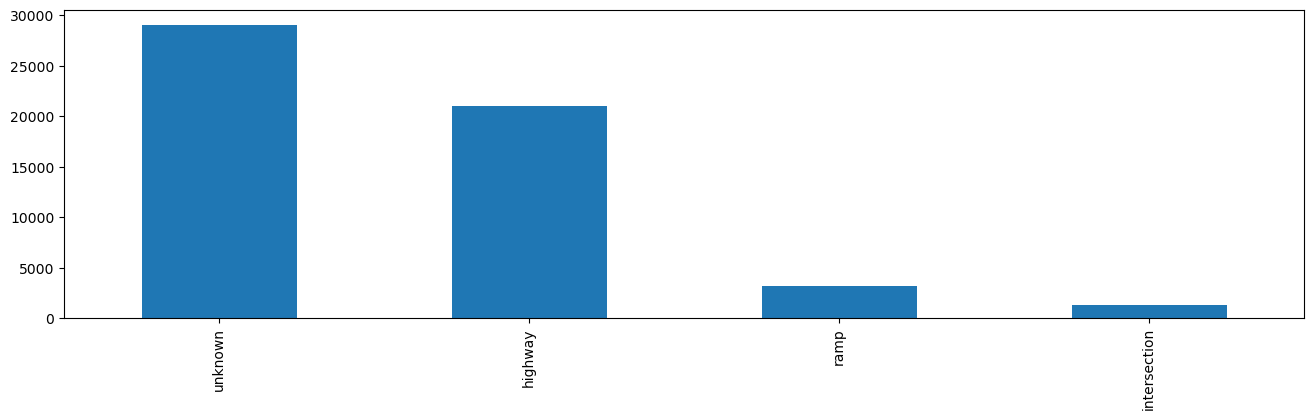

In [104]:
X['location_type'].value_counts().plot.bar(figsize=(16, 4))
plt.show()

In [105]:
X = X.drop('location_type', axis=1)

### Let's divide the columns into numerical and categorical ones, which need to be converted

In [106]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54552 entries, 0 to 54551
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_location       54552 non-null  object 
 1   weather_1             54552 non-null  object 
 2   road_surface          54552 non-null  object 
 3   road_condition_1      54552 non-null  object 
 4   lighting              54552 non-null  object 
 5   control_device        54552 non-null  object 
 6   vehicle_type          54552 non-null  object 
 7   vehicle_transmission  54552 non-null  object 
 8   vehicle_age           54552 non-null  int64  
 9   insurance_premium     54552 non-null  float64
 10  cellphone_in_use      54552 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 4.6+ MB


In [107]:
X.columns

Index(['county_location', 'weather_1', 'road_surface', 'road_condition_1',
       'lighting', 'control_device', 'vehicle_type', 'vehicle_transmission',
       'vehicle_age', 'insurance_premium', 'cellphone_in_use'],
      dtype='object')

In [108]:
cat = ['county_location', 'weather_1', 'road_surface', 'road_condition_1',
       'lighting', 'control_device', 'vehicle_type', 'vehicle_transmission']


num = ['vehicle_age', 'insurance_premium', 'cellphone_in_use']

Setting y

In [109]:
y = df['at_fault']

In [110]:
y

0        1
1        1
2        1
3        1
4        1
        ..
54547    0
54548    1
54549    1
54550    1
54551    0
Name: at_fault, Length: 54552, dtype: int64

Let's check the correlations using philips

interval columns not set, guessing: ['vehicle_age', 'insurance_premium', 'cellphone_in_use', 'at_fault']


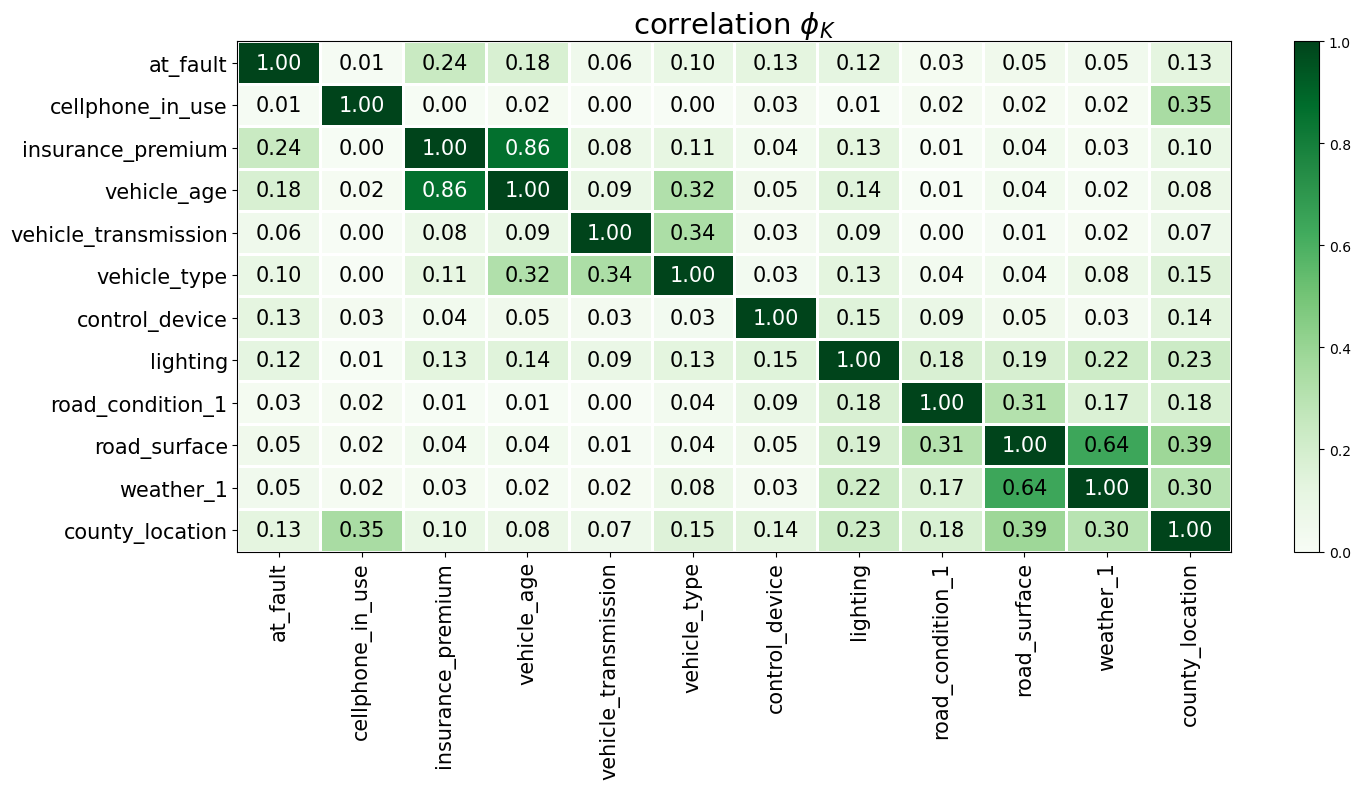

In [111]:
phik_overview = X.join(y).phik_matrix()
phik_overview.round(2)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 8))
plt.tight_layout()

There is no strong correlation here

Let's divide the sample into a training and a test one

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)

Applying OHE and standard scaller

In [113]:
ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown='error')

features_train_cat = pd.DataFrame(ohe.fit_transform(X_train[cat]), 
                                columns=ohe.get_feature_names(cat), 
                                index=X_train.index)

features_test_cat = pd.DataFrame(ohe.transform(X_test[cat]), 
                               columns=ohe.get_feature_names(cat), 
                               index=X_test.index)

X_train = X_train.drop(cat, axis=1).join(features_train_cat)
X_test = X_test.drop(cat, axis=1).join(features_test_cat)

C:\Users\gogad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\gogad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [114]:
scaler = StandardScaler()

features_train_num = pd.DataFrame(scaler.fit_transform(X_train), 
                                columns=X_train.columns, 
                                index=X_train.index)

features_test_num = pd.DataFrame(scaler.transform(X_test), 
                               columns=X_test.columns, 
                               index=X_test.index)

X_train = features_train_num
X_test = features_test_num

## Let's check the logistic regression model

In [115]:
model_log_r = LogisticRegression(random_state=17)

Let's train the model on a training sample

In [116]:
model_log_r.fit(X_train, y_train)

LogisticRegression(random_state=17)

Let's check the quality of the model using **ROC AUC**. I chose ROC-AUC for the assessment, since we need not only to correctly predict dangerous drivers and not rent cars to them, but also once again not to consider someone who does not end up in an accident as a dangerous driver. Since this will affect the company's profits if you stop renting cars to reliable drivers

In [117]:
y_train_pred_log_r = model_log_r.predict(X_train)

In [118]:
roc_auc_score(y_train, y_train_pred_log_r)

0.608221560425049

Let's check the metric on a test sample

In [119]:
y_test_pred_log_r = model_log_r.predict(X_test)

In [120]:
roc_auc_test_log_r = roc_auc_score(y_test, y_test_pred_log_r)
roc_auc_test_log_r

0.6149449383492241

## Let's check the decision tree model

In [121]:
dt_classifier = DecisionTreeClassifier(random_state=17)

Setting parameters for grid search

In [122]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [123]:
grid_search_dt = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='roc_auc')

Looking for the best solution tree option

In [124]:
%%time
grid_search_dt.fit(X_train, y_train)

Wall time: 2min 36s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='roc_auc')

In [125]:
grid_search_dt.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'splitter': 'best'}

In [126]:
best_model_dt = grid_search_dt.best_estimator_

In [127]:
roc_auc_test_dt = best_model_dt.score(X_test, y_test)
roc_auc_test_dt

0.6231852177738672

## Let's try a random forest model

In [128]:
model_rf = RandomForestClassifier(random_state=17)

Setting hyperparameters to find the best random forest model

In [129]:
param_grid_rf = {
    'n_estimators': [50],
#    'n_estimators': [10, 20, 30, 40, 50],
    'criterion': ['gini'],
#    'max_depth': [None, 10, 20],
    'max_depth': [20],
#    'min_samples_split': [2, 5, 10],
    'min_samples_split': [10],
    'min_samples_leaf': [1, 2, 4],
#    'max_features': ['auto', 'sqrt', 'log2'],
    'max_features': ['auto']
}

In [130]:
%%time
grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=5, scoring='roc_auc')
grid_search_rf.fit(X_train, y_train)

Wall time: 19.4 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=17),
             param_grid={'criterion': ['gini'], 'max_depth': [20],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [10], 'n_estimators': [50]},
             scoring='roc_auc')

Let's derive the best combination of hyperparameters for the random forest model

In [131]:
grid_search_rf.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 50}

In [132]:
best_model_rf = grid_search_rf.best_estimator_

Let's output roc-auc on a test sample

In [133]:
roc_auc_test_rf = best_model_rf.score(X_test, y_test)
roc_auc_test_rf

0.6303710221440094

## The catboost model

In [134]:
catboost_model = CatBoostClassifier()

Setting parameters for grid search

In [135]:
param_grid_cb = {
    'learning_rate': [0.01],
    'depth': [2, 3, 4, 5, 6],
    'iterations': [50, 100, 200, 300, 1000, 2000]
}

In [136]:
%%time
grid_search_result_cb = catboost_model.grid_search(param_grid_cb, 
                                                X=Pool(X_train, label=y_train),
                                                cv=5,
                                                plot=True,
                                                partition_random_seed=42,
                                                verbose=False,
                                                search_by_train_test_split=True,
                                                refit=True,
                                                train_size=0.8)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6925398	test: 0.6925241	best: 0.6925241 (0)	total: 187ms	remaining: 9.17s
1:	learn: 0.6919664	test: 0.6919307	best: 0.6919307 (1)	total: 205ms	remaining: 4.92s
2:	learn: 0.6914175	test: 0.6913659	best: 0.6913659 (2)	total: 225ms	remaining: 3.53s
3:	learn: 0.6908547	test: 0.6907809	best: 0.6907809 (3)	total: 243ms	remaining: 2.79s
4:	learn: 0.6903125	test: 0.6902195	best: 0.6902195 (4)	total: 263ms	remaining: 2.37s
5:	learn: 0.6897844	test: 0.6896692	best: 0.6896692 (5)	total: 281ms	remaining: 2.06s
6:	learn: 0.6892589	test: 0.6891347	best: 0.6891347 (6)	total: 299ms	remaining: 1.83s
7:	learn: 0.6887449	test: 0.6886108	best: 0.6886108 (7)	total: 323ms	remaining: 1.7s
8:	learn: 0.6882332	test: 0.6880774	best: 0.6880774 (8)	total: 346ms	remaining: 1.58s
9:	learn: 0.6877321	test: 0.6875546	best: 0.6875546 (9)	total: 369ms	remaining: 1.48s
10:	learn: 0.6872482	test: 0.6870543	best: 0.6870543 (10)	total: 393ms	remaining: 1.39s
11:	learn: 0.6867889	test: 0.6865681	best: 0.6865681 

49:	learn: 0.6739814	test: 0.6731675	best: 0.6731675 (49)	total: 956ms	remaining: 956ms
50:	learn: 0.6737474	test: 0.6729233	best: 0.6729233 (50)	total: 973ms	remaining: 935ms
51:	learn: 0.6735317	test: 0.6726922	best: 0.6726922 (51)	total: 995ms	remaining: 918ms
52:	learn: 0.6733826	test: 0.6725491	best: 0.6725491 (52)	total: 1.01s	remaining: 898ms
53:	learn: 0.6731591	test: 0.6723161	best: 0.6723161 (53)	total: 1.03s	remaining: 876ms
54:	learn: 0.6729715	test: 0.6721055	best: 0.6721055 (54)	total: 1.05s	remaining: 857ms
55:	learn: 0.6727717	test: 0.6718824	best: 0.6718824 (55)	total: 1.06s	remaining: 838ms
56:	learn: 0.6725608	test: 0.6716575	best: 0.6716575 (56)	total: 1.08s	remaining: 819ms
57:	learn: 0.6723887	test: 0.6714808	best: 0.6714808 (57)	total: 1.1s	remaining: 800ms
58:	learn: 0.6722435	test: 0.6713524	best: 0.6713524 (58)	total: 1.13s	remaining: 783ms
59:	learn: 0.6720394	test: 0.6711393	best: 0.6711393 (59)	total: 1.14s	remaining: 763ms
60:	learn: 0.6718393	test: 0.6709

44:	learn: 0.6751861	test: 0.6744496	best: 0.6744496 (44)	total: 743ms	remaining: 2.56s
45:	learn: 0.6749280	test: 0.6741819	best: 0.6741819 (45)	total: 761ms	remaining: 2.55s
46:	learn: 0.6746954	test: 0.6739227	best: 0.6739227 (46)	total: 779ms	remaining: 2.54s
47:	learn: 0.6744462	test: 0.6736647	best: 0.6736647 (47)	total: 794ms	remaining: 2.52s
48:	learn: 0.6742019	test: 0.6734118	best: 0.6734118 (48)	total: 810ms	remaining: 2.5s
49:	learn: 0.6739814	test: 0.6731675	best: 0.6731675 (49)	total: 831ms	remaining: 2.49s
50:	learn: 0.6737474	test: 0.6729233	best: 0.6729233 (50)	total: 847ms	remaining: 2.47s
51:	learn: 0.6735317	test: 0.6726922	best: 0.6726922 (51)	total: 862ms	remaining: 2.45s
52:	learn: 0.6733826	test: 0.6725491	best: 0.6725491 (52)	total: 876ms	remaining: 2.43s
53:	learn: 0.6731591	test: 0.6723161	best: 0.6723161 (53)	total: 888ms	remaining: 2.4s
54:	learn: 0.6729715	test: 0.6721055	best: 0.6721055 (54)	total: 901ms	remaining: 2.38s
55:	learn: 0.6727717	test: 0.67188

141:	learn: 0.6623726	test: 0.6606845	best: 0.6606845 (141)	total: 2.26s	remaining: 923ms
142:	learn: 0.6623084	test: 0.6606310	best: 0.6606310 (142)	total: 2.28s	remaining: 909ms
143:	learn: 0.6622406	test: 0.6605552	best: 0.6605552 (143)	total: 2.29s	remaining: 892ms
144:	learn: 0.6621687	test: 0.6604644	best: 0.6604644 (144)	total: 2.31s	remaining: 875ms
145:	learn: 0.6620658	test: 0.6603332	best: 0.6603332 (145)	total: 2.32s	remaining: 858ms
146:	learn: 0.6619866	test: 0.6602472	best: 0.6602472 (146)	total: 2.34s	remaining: 842ms
147:	learn: 0.6619162	test: 0.6601688	best: 0.6601688 (147)	total: 2.35s	remaining: 825ms
148:	learn: 0.6618475	test: 0.6601154	best: 0.6601154 (148)	total: 2.36s	remaining: 809ms
149:	learn: 0.6617479	test: 0.6599883	best: 0.6599883 (149)	total: 2.38s	remaining: 793ms
150:	learn: 0.6616700	test: 0.6599040	best: 0.6599040 (150)	total: 2.39s	remaining: 777ms
151:	learn: 0.6615875	test: 0.6598097	best: 0.6598097 (151)	total: 2.41s	remaining: 760ms
152:	learn

40:	learn: 0.6762660	test: 0.6755830	best: 0.6755830 (40)	total: 641ms	remaining: 4.05s
41:	learn: 0.6759891	test: 0.6752905	best: 0.6752905 (41)	total: 662ms	remaining: 4.06s
42:	learn: 0.6757151	test: 0.6750067	best: 0.6750067 (42)	total: 678ms	remaining: 4.05s
43:	learn: 0.6754476	test: 0.6747254	best: 0.6747254 (43)	total: 693ms	remaining: 4.03s
44:	learn: 0.6751861	test: 0.6744496	best: 0.6744496 (44)	total: 706ms	remaining: 4s
45:	learn: 0.6749280	test: 0.6741819	best: 0.6741819 (45)	total: 721ms	remaining: 3.98s
46:	learn: 0.6746954	test: 0.6739227	best: 0.6739227 (46)	total: 737ms	remaining: 3.96s
47:	learn: 0.6744462	test: 0.6736647	best: 0.6736647 (47)	total: 751ms	remaining: 3.94s
48:	learn: 0.6742019	test: 0.6734118	best: 0.6734118 (48)	total: 764ms	remaining: 3.91s
49:	learn: 0.6739814	test: 0.6731675	best: 0.6731675 (49)	total: 778ms	remaining: 3.89s
50:	learn: 0.6737474	test: 0.6729233	best: 0.6729233 (50)	total: 794ms	remaining: 3.87s
51:	learn: 0.6735317	test: 0.672692

147:	learn: 0.6619162	test: 0.6601688	best: 0.6601688 (147)	total: 2.36s	remaining: 2.42s
148:	learn: 0.6618475	test: 0.6601154	best: 0.6601154 (148)	total: 2.38s	remaining: 2.41s
149:	learn: 0.6617479	test: 0.6599883	best: 0.6599883 (149)	total: 2.39s	remaining: 2.39s
150:	learn: 0.6616700	test: 0.6599040	best: 0.6599040 (150)	total: 2.41s	remaining: 2.38s
151:	learn: 0.6615875	test: 0.6598097	best: 0.6598097 (151)	total: 2.42s	remaining: 2.36s
152:	learn: 0.6615236	test: 0.6597535	best: 0.6597535 (152)	total: 2.44s	remaining: 2.34s
153:	learn: 0.6614608	test: 0.6596838	best: 0.6596838 (153)	total: 2.45s	remaining: 2.32s
154:	learn: 0.6613810	test: 0.6595921	best: 0.6595921 (154)	total: 2.47s	remaining: 2.31s
155:	learn: 0.6613073	test: 0.6595152	best: 0.6595152 (155)	total: 2.48s	remaining: 2.29s
156:	learn: 0.6612135	test: 0.6593942	best: 0.6593942 (156)	total: 2.5s	remaining: 2.28s
157:	learn: 0.6611358	test: 0.6593062	best: 0.6593062 (157)	total: 2.52s	remaining: 2.26s
158:	learn:

243:	learn: 0.6565712	test: 0.6545538	best: 0.6545538 (243)	total: 3.88s	remaining: 890ms
244:	learn: 0.6565385	test: 0.6545262	best: 0.6545262 (244)	total: 3.89s	remaining: 874ms
245:	learn: 0.6564914	test: 0.6544715	best: 0.6544715 (245)	total: 3.91s	remaining: 859ms
246:	learn: 0.6564476	test: 0.6544421	best: 0.6544421 (246)	total: 3.93s	remaining: 843ms
247:	learn: 0.6564035	test: 0.6543943	best: 0.6543943 (247)	total: 3.94s	remaining: 827ms
248:	learn: 0.6563439	test: 0.6543146	best: 0.6543146 (248)	total: 3.96s	remaining: 811ms
249:	learn: 0.6563015	test: 0.6542861	best: 0.6542861 (249)	total: 3.98s	remaining: 796ms
250:	learn: 0.6562430	test: 0.6542078	best: 0.6542078 (250)	total: 4s	remaining: 780ms
251:	learn: 0.6562045	test: 0.6541760	best: 0.6541760 (251)	total: 4.02s	remaining: 765ms
252:	learn: 0.6561620	test: 0.6541357	best: 0.6541357 (252)	total: 4.03s	remaining: 750ms
253:	learn: 0.6561246	test: 0.6540865	best: 0.6540865 (253)	total: 4.05s	remaining: 734ms
254:	learn: 0

37:	learn: 0.6770801	test: 0.6764303	best: 0.6764303 (37)	total: 587ms	remaining: 14.9s
38:	learn: 0.6767983	test: 0.6761363	best: 0.6761363 (38)	total: 609ms	remaining: 15s
39:	learn: 0.6765280	test: 0.6758492	best: 0.6758492 (39)	total: 625ms	remaining: 15s
40:	learn: 0.6762660	test: 0.6755830	best: 0.6755830 (40)	total: 643ms	remaining: 15s
41:	learn: 0.6759891	test: 0.6752905	best: 0.6752905 (41)	total: 677ms	remaining: 15.5s
42:	learn: 0.6757151	test: 0.6750067	best: 0.6750067 (42)	total: 694ms	remaining: 15.4s
43:	learn: 0.6754476	test: 0.6747254	best: 0.6747254 (43)	total: 717ms	remaining: 15.6s
44:	learn: 0.6751861	test: 0.6744496	best: 0.6744496 (44)	total: 732ms	remaining: 15.5s
45:	learn: 0.6749280	test: 0.6741819	best: 0.6741819 (45)	total: 747ms	remaining: 15.5s
46:	learn: 0.6746954	test: 0.6739227	best: 0.6739227 (46)	total: 758ms	remaining: 15.4s
47:	learn: 0.6744462	test: 0.6736647	best: 0.6736647 (47)	total: 770ms	remaining: 15.3s
48:	learn: 0.6742019	test: 0.6734118	b

132:	learn: 0.6630116	test: 0.6613162	best: 0.6613162 (132)	total: 2.11s	remaining: 13.8s
133:	learn: 0.6629496	test: 0.6612608	best: 0.6612608 (133)	total: 2.13s	remaining: 13.8s
134:	learn: 0.6628745	test: 0.6611990	best: 0.6611990 (134)	total: 2.15s	remaining: 13.7s
135:	learn: 0.6628001	test: 0.6611153	best: 0.6611153 (135)	total: 2.17s	remaining: 13.8s
136:	learn: 0.6627273	test: 0.6610557	best: 0.6610557 (136)	total: 2.18s	remaining: 13.7s
137:	learn: 0.6626587	test: 0.6609809	best: 0.6609809 (137)	total: 2.2s	remaining: 13.7s
138:	learn: 0.6625816	test: 0.6609005	best: 0.6609005 (138)	total: 2.21s	remaining: 13.7s
139:	learn: 0.6625173	test: 0.6608407	best: 0.6608407 (139)	total: 2.23s	remaining: 13.7s
140:	learn: 0.6624464	test: 0.6607780	best: 0.6607780 (140)	total: 2.25s	remaining: 13.7s
141:	learn: 0.6623726	test: 0.6606845	best: 0.6606845 (141)	total: 2.27s	remaining: 13.7s
142:	learn: 0.6623084	test: 0.6606310	best: 0.6606310 (142)	total: 2.29s	remaining: 13.7s
143:	learn:

225:	learn: 0.6573304	test: 0.6553031	best: 0.6553031 (225)	total: 3.85s	remaining: 13.2s
226:	learn: 0.6572831	test: 0.6552576	best: 0.6552576 (226)	total: 3.87s	remaining: 13.2s
227:	learn: 0.6572468	test: 0.6552239	best: 0.6552239 (227)	total: 3.89s	remaining: 13.2s
228:	learn: 0.6572055	test: 0.6551778	best: 0.6551778 (228)	total: 3.91s	remaining: 13.2s
229:	learn: 0.6571656	test: 0.6551327	best: 0.6551327 (229)	total: 3.93s	remaining: 13.2s
230:	learn: 0.6571195	test: 0.6551058	best: 0.6551058 (230)	total: 3.95s	remaining: 13.1s
231:	learn: 0.6570854	test: 0.6550754	best: 0.6550754 (231)	total: 3.98s	remaining: 13.2s
232:	learn: 0.6570415	test: 0.6550419	best: 0.6550419 (232)	total: 4s	remaining: 13.2s
233:	learn: 0.6570074	test: 0.6550103	best: 0.6550103 (233)	total: 4.01s	remaining: 13.1s
234:	learn: 0.6569709	test: 0.6549806	best: 0.6549806 (234)	total: 4.03s	remaining: 13.1s
235:	learn: 0.6569191	test: 0.6549238	best: 0.6549238 (235)	total: 4.05s	remaining: 13.1s
236:	learn: 0

323:	learn: 0.6537384	test: 0.6515556	best: 0.6515556 (323)	total: 5.58s	remaining: 11.6s
324:	learn: 0.6537108	test: 0.6515321	best: 0.6515321 (324)	total: 5.59s	remaining: 11.6s
325:	learn: 0.6536810	test: 0.6514991	best: 0.6514991 (325)	total: 5.62s	remaining: 11.6s
326:	learn: 0.6536549	test: 0.6514699	best: 0.6514699 (326)	total: 5.64s	remaining: 11.6s
327:	learn: 0.6536265	test: 0.6514407	best: 0.6514407 (327)	total: 5.65s	remaining: 11.6s
328:	learn: 0.6536004	test: 0.6514182	best: 0.6514182 (328)	total: 5.67s	remaining: 11.6s
329:	learn: 0.6535680	test: 0.6513910	best: 0.6513910 (329)	total: 5.7s	remaining: 11.6s
330:	learn: 0.6535417	test: 0.6513653	best: 0.6513653 (330)	total: 5.71s	remaining: 11.5s
331:	learn: 0.6535141	test: 0.6513305	best: 0.6513305 (331)	total: 5.73s	remaining: 11.5s
332:	learn: 0.6534866	test: 0.6512931	best: 0.6512931 (332)	total: 5.74s	remaining: 11.5s
333:	learn: 0.6534443	test: 0.6512342	best: 0.6512342 (333)	total: 5.76s	remaining: 11.5s
334:	learn:

418:	learn: 0.6513405	test: 0.6490496	best: 0.6490496 (418)	total: 7.27s	remaining: 10.1s
419:	learn: 0.6513164	test: 0.6490143	best: 0.6490143 (419)	total: 7.29s	remaining: 10.1s
420:	learn: 0.6512851	test: 0.6489686	best: 0.6489686 (420)	total: 7.3s	remaining: 10s
421:	learn: 0.6512660	test: 0.6489572	best: 0.6489572 (421)	total: 7.32s	remaining: 10s
422:	learn: 0.6512350	test: 0.6489123	best: 0.6489123 (422)	total: 7.34s	remaining: 10s
423:	learn: 0.6512132	test: 0.6488895	best: 0.6488895 (423)	total: 7.36s	remaining: 10s
424:	learn: 0.6511925	test: 0.6488649	best: 0.6488649 (424)	total: 7.38s	remaining: 9.98s
425:	learn: 0.6511737	test: 0.6488428	best: 0.6488428 (425)	total: 7.39s	remaining: 9.96s
426:	learn: 0.6511432	test: 0.6487987	best: 0.6487987 (426)	total: 7.41s	remaining: 9.94s
427:	learn: 0.6511203	test: 0.6487844	best: 0.6487844 (427)	total: 7.42s	remaining: 9.91s
428:	learn: 0.6510983	test: 0.6487640	best: 0.6487640 (428)	total: 7.43s	remaining: 9.89s
429:	learn: 0.65108

521:	learn: 0.6494980	test: 0.6471767	best: 0.6471767 (521)	total: 8.99s	remaining: 8.23s
522:	learn: 0.6494789	test: 0.6471507	best: 0.6471507 (522)	total: 9.01s	remaining: 8.22s
523:	learn: 0.6494649	test: 0.6471369	best: 0.6471369 (523)	total: 9.02s	remaining: 8.2s
524:	learn: 0.6494514	test: 0.6471210	best: 0.6471210 (524)	total: 9.04s	remaining: 8.18s
525:	learn: 0.6494407	test: 0.6471141	best: 0.6471141 (525)	total: 9.05s	remaining: 8.16s
526:	learn: 0.6494285	test: 0.6471008	best: 0.6471008 (526)	total: 9.07s	remaining: 8.14s
527:	learn: 0.6494148	test: 0.6470811	best: 0.6470811 (527)	total: 9.08s	remaining: 8.12s
528:	learn: 0.6494016	test: 0.6470616	best: 0.6470616 (528)	total: 9.09s	remaining: 8.1s
529:	learn: 0.6493884	test: 0.6470427	best: 0.6470427 (529)	total: 9.11s	remaining: 8.08s
530:	learn: 0.6493761	test: 0.6470310	best: 0.6470310 (530)	total: 9.12s	remaining: 8.06s
531:	learn: 0.6493587	test: 0.6470149	best: 0.6470149 (531)	total: 9.14s	remaining: 8.04s
532:	learn: 

624:	learn: 0.6482057	test: 0.6459010	best: 0.6459010 (624)	total: 10.5s	remaining: 6.3s
625:	learn: 0.6481982	test: 0.6458961	best: 0.6458961 (625)	total: 10.5s	remaining: 6.28s
626:	learn: 0.6481880	test: 0.6458855	best: 0.6458855 (626)	total: 10.5s	remaining: 6.26s
627:	learn: 0.6481775	test: 0.6458754	best: 0.6458754 (627)	total: 10.5s	remaining: 6.24s
628:	learn: 0.6481643	test: 0.6458613	best: 0.6458613 (628)	total: 10.5s	remaining: 6.22s
629:	learn: 0.6481542	test: 0.6458553	best: 0.6458553 (629)	total: 10.6s	remaining: 6.2s
630:	learn: 0.6481394	test: 0.6458449	best: 0.6458449 (630)	total: 10.6s	remaining: 6.18s
631:	learn: 0.6481303	test: 0.6458392	best: 0.6458392 (631)	total: 10.6s	remaining: 6.16s
632:	learn: 0.6481152	test: 0.6458248	best: 0.6458248 (632)	total: 10.6s	remaining: 6.15s
633:	learn: 0.6481008	test: 0.6458063	best: 0.6458063 (633)	total: 10.6s	remaining: 6.13s
634:	learn: 0.6480942	test: 0.6458007	best: 0.6458007 (634)	total: 10.6s	remaining: 6.11s
635:	learn: 

721:	learn: 0.6473013	test: 0.6450883	best: 0.6450883 (721)	total: 12s	remaining: 4.62s
722:	learn: 0.6472851	test: 0.6450631	best: 0.6450631 (722)	total: 12s	remaining: 4.6s
723:	learn: 0.6472801	test: 0.6450588	best: 0.6450588 (723)	total: 12s	remaining: 4.58s
724:	learn: 0.6472723	test: 0.6450509	best: 0.6450509 (724)	total: 12s	remaining: 4.57s
725:	learn: 0.6472607	test: 0.6450404	best: 0.6450404 (725)	total: 12.1s	remaining: 4.55s
726:	learn: 0.6472534	test: 0.6450347	best: 0.6450347 (726)	total: 12.1s	remaining: 4.53s
727:	learn: 0.6472468	test: 0.6450238	best: 0.6450238 (727)	total: 12.1s	remaining: 4.52s
728:	learn: 0.6472410	test: 0.6450235	best: 0.6450235 (728)	total: 12.1s	remaining: 4.5s
729:	learn: 0.6472330	test: 0.6450153	best: 0.6450153 (729)	total: 12.1s	remaining: 4.48s
730:	learn: 0.6472290	test: 0.6450127	best: 0.6450127 (730)	total: 12.1s	remaining: 4.46s
731:	learn: 0.6472261	test: 0.6450134	best: 0.6450127 (730)	total: 12.1s	remaining: 4.45s
732:	learn: 0.647216

817:	learn: 0.6465477	test: 0.6444096	best: 0.6444096 (817)	total: 13.3s	remaining: 2.95s
818:	learn: 0.6465433	test: 0.6444083	best: 0.6444083 (818)	total: 13.3s	remaining: 2.94s
819:	learn: 0.6465375	test: 0.6444042	best: 0.6444042 (819)	total: 13.3s	remaining: 2.92s
820:	learn: 0.6465330	test: 0.6444010	best: 0.6444010 (820)	total: 13.3s	remaining: 2.9s
821:	learn: 0.6465248	test: 0.6443986	best: 0.6443986 (821)	total: 13.3s	remaining: 2.89s
822:	learn: 0.6465117	test: 0.6443778	best: 0.6443778 (822)	total: 13.3s	remaining: 2.87s
823:	learn: 0.6465086	test: 0.6443738	best: 0.6443738 (823)	total: 13.4s	remaining: 2.85s
824:	learn: 0.6465034	test: 0.6443658	best: 0.6443658 (824)	total: 13.4s	remaining: 2.84s
825:	learn: 0.6465006	test: 0.6443659	best: 0.6443658 (824)	total: 13.4s	remaining: 2.82s
826:	learn: 0.6464956	test: 0.6443605	best: 0.6443605 (826)	total: 13.4s	remaining: 2.81s
827:	learn: 0.6464887	test: 0.6443521	best: 0.6443521 (827)	total: 13.4s	remaining: 2.79s
828:	learn:

910:	learn: 0.6459461	test: 0.6438642	best: 0.6438642 (910)	total: 14.6s	remaining: 1.42s
911:	learn: 0.6459407	test: 0.6438595	best: 0.6438595 (911)	total: 14.6s	remaining: 1.41s
912:	learn: 0.6459374	test: 0.6438567	best: 0.6438567 (912)	total: 14.6s	remaining: 1.39s
913:	learn: 0.6459267	test: 0.6438395	best: 0.6438395 (913)	total: 14.6s	remaining: 1.37s
914:	learn: 0.6459182	test: 0.6438333	best: 0.6438333 (914)	total: 14.6s	remaining: 1.36s
915:	learn: 0.6459134	test: 0.6438324	best: 0.6438324 (915)	total: 14.6s	remaining: 1.34s
916:	learn: 0.6459100	test: 0.6438288	best: 0.6438288 (916)	total: 14.7s	remaining: 1.33s
917:	learn: 0.6459048	test: 0.6438236	best: 0.6438236 (917)	total: 14.7s	remaining: 1.31s
918:	learn: 0.6458985	test: 0.6438219	best: 0.6438219 (918)	total: 14.7s	remaining: 1.29s
919:	learn: 0.6458928	test: 0.6438129	best: 0.6438129 (919)	total: 14.7s	remaining: 1.28s
920:	learn: 0.6458868	test: 0.6438101	best: 0.6438101 (920)	total: 14.7s	remaining: 1.26s
921:	learn

14:	learn: 0.6854135	test: 0.6851270	best: 0.6851270 (14)	total: 247ms	remaining: 32.7s
15:	learn: 0.6849770	test: 0.6846718	best: 0.6846718 (15)	total: 264ms	remaining: 32.7s
16:	learn: 0.6845635	test: 0.6842257	best: 0.6842257 (16)	total: 280ms	remaining: 32.6s
17:	learn: 0.6841287	test: 0.6837727	best: 0.6837727 (17)	total: 297ms	remaining: 32.7s
18:	learn: 0.6836946	test: 0.6833272	best: 0.6833272 (18)	total: 312ms	remaining: 32.6s
19:	learn: 0.6832874	test: 0.6829053	best: 0.6829053 (19)	total: 334ms	remaining: 33.1s
20:	learn: 0.6828731	test: 0.6824765	best: 0.6824765 (20)	total: 350ms	remaining: 33s
21:	learn: 0.6824672	test: 0.6820562	best: 0.6820562 (21)	total: 369ms	remaining: 33.2s
22:	learn: 0.6820895	test: 0.6816608	best: 0.6816608 (22)	total: 389ms	remaining: 33.4s
23:	learn: 0.6817157	test: 0.6812702	best: 0.6812702 (23)	total: 410ms	remaining: 33.7s
24:	learn: 0.6813293	test: 0.6808728	best: 0.6808728 (24)	total: 432ms	remaining: 34.1s
25:	learn: 0.6809699	test: 0.68050

111:	learn: 0.6650027	test: 0.6634809	best: 0.6634809 (111)	total: 1.74s	remaining: 29.4s
112:	learn: 0.6649050	test: 0.6633657	best: 0.6633657 (112)	total: 1.76s	remaining: 29.4s
113:	learn: 0.6648189	test: 0.6632949	best: 0.6632949 (113)	total: 1.77s	remaining: 29.4s
114:	learn: 0.6646917	test: 0.6631368	best: 0.6631368 (114)	total: 1.79s	remaining: 29.3s
115:	learn: 0.6645681	test: 0.6629816	best: 0.6629816 (115)	total: 1.8s	remaining: 29.3s
116:	learn: 0.6645039	test: 0.6629238	best: 0.6629238 (116)	total: 1.82s	remaining: 29.3s
117:	learn: 0.6643819	test: 0.6627713	best: 0.6627713 (117)	total: 1.84s	remaining: 29.3s
118:	learn: 0.6642627	test: 0.6626215	best: 0.6626215 (118)	total: 1.85s	remaining: 29.3s
119:	learn: 0.6641834	test: 0.6625664	best: 0.6625664 (119)	total: 1.86s	remaining: 29.2s
120:	learn: 0.6640661	test: 0.6624193	best: 0.6624193 (120)	total: 1.88s	remaining: 29.2s
121:	learn: 0.6639519	test: 0.6622750	best: 0.6622750 (121)	total: 1.89s	remaining: 29.1s
122:	learn:

217:	learn: 0.6577045	test: 0.6556915	best: 0.6556915 (217)	total: 3.25s	remaining: 26.6s
218:	learn: 0.6576576	test: 0.6556296	best: 0.6556296 (218)	total: 3.27s	remaining: 26.6s
219:	learn: 0.6576144	test: 0.6555966	best: 0.6555966 (219)	total: 3.29s	remaining: 26.6s
220:	learn: 0.6575642	test: 0.6555522	best: 0.6555522 (220)	total: 3.3s	remaining: 26.6s
221:	learn: 0.6574980	test: 0.6554649	best: 0.6554649 (221)	total: 3.32s	remaining: 26.6s
222:	learn: 0.6574568	test: 0.6554201	best: 0.6554201 (222)	total: 3.33s	remaining: 26.6s
223:	learn: 0.6574207	test: 0.6553842	best: 0.6553842 (223)	total: 3.35s	remaining: 26.5s
224:	learn: 0.6573751	test: 0.6553386	best: 0.6553386 (224)	total: 3.36s	remaining: 26.5s
225:	learn: 0.6573304	test: 0.6553031	best: 0.6553031 (225)	total: 3.38s	remaining: 26.5s
226:	learn: 0.6572831	test: 0.6552576	best: 0.6552576 (226)	total: 3.39s	remaining: 26.5s
227:	learn: 0.6572468	test: 0.6552239	best: 0.6552239 (227)	total: 3.41s	remaining: 26.5s
228:	learn:

322:	learn: 0.6537681	test: 0.6515890	best: 0.6515890 (322)	total: 4.78s	remaining: 24.8s
323:	learn: 0.6537384	test: 0.6515556	best: 0.6515556 (323)	total: 4.8s	remaining: 24.8s
324:	learn: 0.6537108	test: 0.6515321	best: 0.6515321 (324)	total: 4.82s	remaining: 24.8s
325:	learn: 0.6536810	test: 0.6514991	best: 0.6514991 (325)	total: 4.83s	remaining: 24.8s
326:	learn: 0.6536549	test: 0.6514699	best: 0.6514699 (326)	total: 4.85s	remaining: 24.8s
327:	learn: 0.6536265	test: 0.6514407	best: 0.6514407 (327)	total: 4.86s	remaining: 24.8s
328:	learn: 0.6536004	test: 0.6514182	best: 0.6514182 (328)	total: 4.88s	remaining: 24.8s
329:	learn: 0.6535680	test: 0.6513910	best: 0.6513910 (329)	total: 4.89s	remaining: 24.8s
330:	learn: 0.6535417	test: 0.6513653	best: 0.6513653 (330)	total: 4.91s	remaining: 24.7s
331:	learn: 0.6535141	test: 0.6513305	best: 0.6513305 (331)	total: 4.92s	remaining: 24.7s
332:	learn: 0.6534866	test: 0.6512931	best: 0.6512931 (332)	total: 4.93s	remaining: 24.7s
333:	learn:

426:	learn: 0.6511432	test: 0.6487987	best: 0.6487987 (426)	total: 6.31s	remaining: 23.2s
427:	learn: 0.6511203	test: 0.6487844	best: 0.6487844 (427)	total: 6.33s	remaining: 23.3s
428:	learn: 0.6510983	test: 0.6487640	best: 0.6487640 (428)	total: 6.35s	remaining: 23.2s
429:	learn: 0.6510822	test: 0.6487457	best: 0.6487457 (429)	total: 6.36s	remaining: 23.2s
430:	learn: 0.6510619	test: 0.6487332	best: 0.6487332 (430)	total: 6.38s	remaining: 23.2s
431:	learn: 0.6510455	test: 0.6487201	best: 0.6487201 (431)	total: 6.42s	remaining: 23.3s
432:	learn: 0.6510273	test: 0.6486996	best: 0.6486996 (432)	total: 6.43s	remaining: 23.3s
433:	learn: 0.6510076	test: 0.6486776	best: 0.6486776 (433)	total: 6.45s	remaining: 23.3s
434:	learn: 0.6509778	test: 0.6486344	best: 0.6486344 (434)	total: 6.46s	remaining: 23.3s
435:	learn: 0.6509662	test: 0.6486257	best: 0.6486257 (435)	total: 6.48s	remaining: 23.2s
436:	learn: 0.6509484	test: 0.6486052	best: 0.6486052 (436)	total: 6.5s	remaining: 23.2s
437:	learn:

524:	learn: 0.6494514	test: 0.6471210	best: 0.6471210 (524)	total: 7.82s	remaining: 22s
525:	learn: 0.6494407	test: 0.6471141	best: 0.6471141 (525)	total: 7.83s	remaining: 22s
526:	learn: 0.6494285	test: 0.6471008	best: 0.6471008 (526)	total: 7.86s	remaining: 22s
527:	learn: 0.6494148	test: 0.6470811	best: 0.6470811 (527)	total: 7.88s	remaining: 22s
528:	learn: 0.6494016	test: 0.6470616	best: 0.6470616 (528)	total: 7.89s	remaining: 21.9s
529:	learn: 0.6493884	test: 0.6470427	best: 0.6470427 (529)	total: 7.91s	remaining: 21.9s
530:	learn: 0.6493761	test: 0.6470310	best: 0.6470310 (530)	total: 7.93s	remaining: 21.9s
531:	learn: 0.6493587	test: 0.6470149	best: 0.6470149 (531)	total: 7.95s	remaining: 21.9s
532:	learn: 0.6493402	test: 0.6470008	best: 0.6470008 (532)	total: 7.96s	remaining: 21.9s
533:	learn: 0.6493265	test: 0.6469840	best: 0.6469840 (533)	total: 7.97s	remaining: 21.9s
534:	learn: 0.6493137	test: 0.6469660	best: 0.6469660 (534)	total: 7.99s	remaining: 21.9s
535:	learn: 0.6492

627:	learn: 0.6481775	test: 0.6458754	best: 0.6458754 (627)	total: 9.56s	remaining: 20.9s
628:	learn: 0.6481643	test: 0.6458613	best: 0.6458613 (628)	total: 9.58s	remaining: 20.9s
629:	learn: 0.6481542	test: 0.6458553	best: 0.6458553 (629)	total: 9.6s	remaining: 20.9s
630:	learn: 0.6481394	test: 0.6458449	best: 0.6458449 (630)	total: 9.62s	remaining: 20.9s
631:	learn: 0.6481303	test: 0.6458392	best: 0.6458392 (631)	total: 9.64s	remaining: 20.9s
632:	learn: 0.6481152	test: 0.6458248	best: 0.6458248 (632)	total: 9.66s	remaining: 20.9s
633:	learn: 0.6481008	test: 0.6458063	best: 0.6458063 (633)	total: 9.67s	remaining: 20.8s
634:	learn: 0.6480942	test: 0.6458007	best: 0.6458007 (634)	total: 9.69s	remaining: 20.8s
635:	learn: 0.6480880	test: 0.6457937	best: 0.6457937 (635)	total: 9.71s	remaining: 20.8s
636:	learn: 0.6480728	test: 0.6457837	best: 0.6457837 (636)	total: 9.72s	remaining: 20.8s
637:	learn: 0.6480633	test: 0.6457754	best: 0.6457754 (637)	total: 9.74s	remaining: 20.8s
638:	learn:

720:	learn: 0.6473181	test: 0.6451139	best: 0.6451139 (720)	total: 11.1s	remaining: 19.7s
721:	learn: 0.6473013	test: 0.6450883	best: 0.6450883 (721)	total: 11.1s	remaining: 19.7s
722:	learn: 0.6472851	test: 0.6450631	best: 0.6450631 (722)	total: 11.2s	remaining: 19.7s
723:	learn: 0.6472801	test: 0.6450588	best: 0.6450588 (723)	total: 11.2s	remaining: 19.7s
724:	learn: 0.6472723	test: 0.6450509	best: 0.6450509 (724)	total: 11.2s	remaining: 19.7s
725:	learn: 0.6472607	test: 0.6450404	best: 0.6450404 (725)	total: 11.2s	remaining: 19.7s
726:	learn: 0.6472534	test: 0.6450347	best: 0.6450347 (726)	total: 11.2s	remaining: 19.6s
727:	learn: 0.6472468	test: 0.6450238	best: 0.6450238 (727)	total: 11.2s	remaining: 19.6s
728:	learn: 0.6472410	test: 0.6450235	best: 0.6450235 (728)	total: 11.2s	remaining: 19.6s
729:	learn: 0.6472330	test: 0.6450153	best: 0.6450153 (729)	total: 11.3s	remaining: 19.6s
730:	learn: 0.6472290	test: 0.6450127	best: 0.6450127 (730)	total: 11.3s	remaining: 19.6s
731:	learn

822:	learn: 0.6465117	test: 0.6443778	best: 0.6443778 (822)	total: 12.6s	remaining: 18.1s
823:	learn: 0.6465086	test: 0.6443738	best: 0.6443738 (823)	total: 12.6s	remaining: 18.1s
824:	learn: 0.6465034	test: 0.6443658	best: 0.6443658 (824)	total: 12.7s	remaining: 18s
825:	learn: 0.6465006	test: 0.6443659	best: 0.6443658 (824)	total: 12.7s	remaining: 18s
826:	learn: 0.6464956	test: 0.6443605	best: 0.6443605 (826)	total: 12.7s	remaining: 18s
827:	learn: 0.6464887	test: 0.6443521	best: 0.6443521 (827)	total: 12.7s	remaining: 18s
828:	learn: 0.6464836	test: 0.6443498	best: 0.6443498 (828)	total: 12.7s	remaining: 18s
829:	learn: 0.6464783	test: 0.6443475	best: 0.6443475 (829)	total: 12.7s	remaining: 18s
830:	learn: 0.6464731	test: 0.6443387	best: 0.6443387 (830)	total: 12.7s	remaining: 17.9s
831:	learn: 0.6464656	test: 0.6443326	best: 0.6443326 (831)	total: 12.8s	remaining: 17.9s
832:	learn: 0.6464592	test: 0.6443262	best: 0.6443262 (832)	total: 12.8s	remaining: 17.9s
833:	learn: 0.6464531	

921:	learn: 0.6458779	test: 0.6438022	best: 0.6438022 (921)	total: 14.1s	remaining: 16.5s
922:	learn: 0.6458713	test: 0.6437997	best: 0.6437997 (922)	total: 14.1s	remaining: 16.5s
923:	learn: 0.6458683	test: 0.6437956	best: 0.6437956 (923)	total: 14.2s	remaining: 16.5s
924:	learn: 0.6458636	test: 0.6437946	best: 0.6437946 (924)	total: 14.2s	remaining: 16.5s
925:	learn: 0.6458599	test: 0.6437939	best: 0.6437939 (925)	total: 14.2s	remaining: 16.4s
926:	learn: 0.6458550	test: 0.6437903	best: 0.6437903 (926)	total: 14.2s	remaining: 16.4s
927:	learn: 0.6458446	test: 0.6437850	best: 0.6437850 (927)	total: 14.2s	remaining: 16.4s
928:	learn: 0.6458405	test: 0.6437804	best: 0.6437804 (928)	total: 14.2s	remaining: 16.4s
929:	learn: 0.6458301	test: 0.6437753	best: 0.6437753 (929)	total: 14.2s	remaining: 16.4s
930:	learn: 0.6458256	test: 0.6437757	best: 0.6437753 (929)	total: 14.2s	remaining: 16.4s
931:	learn: 0.6458172	test: 0.6437709	best: 0.6437709 (931)	total: 14.3s	remaining: 16.3s
932:	learn

1014:	learn: 0.6453808	test: 0.6434241	best: 0.6434241 (1014)	total: 15.5s	remaining: 15s
1015:	learn: 0.6453762	test: 0.6434214	best: 0.6434214 (1015)	total: 15.5s	remaining: 15s
1016:	learn: 0.6453720	test: 0.6434135	best: 0.6434135 (1016)	total: 15.5s	remaining: 15s
1017:	learn: 0.6453679	test: 0.6434132	best: 0.6434132 (1017)	total: 15.5s	remaining: 15s
1018:	learn: 0.6453582	test: 0.6434018	best: 0.6434018 (1018)	total: 15.5s	remaining: 14.9s
1019:	learn: 0.6453514	test: 0.6433912	best: 0.6433912 (1019)	total: 15.5s	remaining: 14.9s
1020:	learn: 0.6453471	test: 0.6433874	best: 0.6433874 (1020)	total: 15.6s	remaining: 14.9s
1021:	learn: 0.6453409	test: 0.6433884	best: 0.6433874 (1020)	total: 15.6s	remaining: 14.9s
1022:	learn: 0.6453354	test: 0.6433812	best: 0.6433812 (1022)	total: 15.6s	remaining: 14.9s
1023:	learn: 0.6453316	test: 0.6433780	best: 0.6433780 (1023)	total: 15.6s	remaining: 14.9s
1024:	learn: 0.6453240	test: 0.6433652	best: 0.6433652 (1024)	total: 15.6s	remaining: 14

1105:	learn: 0.6449502	test: 0.6430983	best: 0.6430983 (1105)	total: 16.8s	remaining: 13.6s
1106:	learn: 0.6449466	test: 0.6430982	best: 0.6430982 (1106)	total: 16.8s	remaining: 13.5s
1107:	learn: 0.6449415	test: 0.6430954	best: 0.6430954 (1107)	total: 16.8s	remaining: 13.5s
1108:	learn: 0.6449370	test: 0.6430921	best: 0.6430921 (1108)	total: 16.8s	remaining: 13.5s
1109:	learn: 0.6449328	test: 0.6430923	best: 0.6430921 (1108)	total: 16.8s	remaining: 13.5s
1110:	learn: 0.6449263	test: 0.6430886	best: 0.6430886 (1110)	total: 16.8s	remaining: 13.5s
1111:	learn: 0.6449225	test: 0.6430885	best: 0.6430885 (1111)	total: 16.9s	remaining: 13.5s
1112:	learn: 0.6449189	test: 0.6430885	best: 0.6430885 (1112)	total: 16.9s	remaining: 13.4s
1113:	learn: 0.6449156	test: 0.6430875	best: 0.6430875 (1113)	total: 16.9s	remaining: 13.4s
1114:	learn: 0.6449119	test: 0.6430848	best: 0.6430848 (1114)	total: 16.9s	remaining: 13.4s
1115:	learn: 0.6449088	test: 0.6430846	best: 0.6430846 (1115)	total: 16.9s	remai

1198:	learn: 0.6445597	test: 0.6428390	best: 0.6428390 (1198)	total: 18.1s	remaining: 12.1s
1199:	learn: 0.6445568	test: 0.6428362	best: 0.6428362 (1199)	total: 18.1s	remaining: 12.1s
1200:	learn: 0.6445535	test: 0.6428350	best: 0.6428350 (1200)	total: 18.1s	remaining: 12s
1201:	learn: 0.6445493	test: 0.6428299	best: 0.6428299 (1201)	total: 18.1s	remaining: 12s
1202:	learn: 0.6445422	test: 0.6428236	best: 0.6428236 (1202)	total: 18.1s	remaining: 12s
1203:	learn: 0.6445380	test: 0.6428200	best: 0.6428200 (1203)	total: 18.1s	remaining: 12s
1204:	learn: 0.6445332	test: 0.6428166	best: 0.6428166 (1204)	total: 18.1s	remaining: 12s
1205:	learn: 0.6445308	test: 0.6428140	best: 0.6428140 (1205)	total: 18.2s	remaining: 12s
1206:	learn: 0.6445266	test: 0.6428115	best: 0.6428115 (1206)	total: 18.2s	remaining: 11.9s
1207:	learn: 0.6445237	test: 0.6428130	best: 0.6428115 (1206)	total: 18.2s	remaining: 11.9s
1208:	learn: 0.6445198	test: 0.6428108	best: 0.6428108 (1208)	total: 18.2s	remaining: 11.9s


1291:	learn: 0.6442062	test: 0.6426398	best: 0.6426398 (1291)	total: 19.4s	remaining: 10.6s
1292:	learn: 0.6442023	test: 0.6426366	best: 0.6426366 (1292)	total: 19.4s	remaining: 10.6s
1293:	learn: 0.6441988	test: 0.6426337	best: 0.6426337 (1293)	total: 19.4s	remaining: 10.6s
1294:	learn: 0.6441946	test: 0.6426297	best: 0.6426297 (1294)	total: 19.4s	remaining: 10.6s
1295:	learn: 0.6441920	test: 0.6426291	best: 0.6426291 (1295)	total: 19.4s	remaining: 10.6s
1296:	learn: 0.6441893	test: 0.6426293	best: 0.6426291 (1295)	total: 19.5s	remaining: 10.5s
1297:	learn: 0.6441864	test: 0.6426290	best: 0.6426290 (1297)	total: 19.5s	remaining: 10.5s
1298:	learn: 0.6441832	test: 0.6426243	best: 0.6426243 (1298)	total: 19.5s	remaining: 10.5s
1299:	learn: 0.6441781	test: 0.6426238	best: 0.6426238 (1299)	total: 19.5s	remaining: 10.5s
1300:	learn: 0.6441749	test: 0.6426233	best: 0.6426233 (1300)	total: 19.5s	remaining: 10.5s
1301:	learn: 0.6441687	test: 0.6426204	best: 0.6426204 (1301)	total: 19.5s	remai

1384:	learn: 0.6438760	test: 0.6424283	best: 0.6424283 (1384)	total: 20.7s	remaining: 9.18s
1385:	learn: 0.6438724	test: 0.6424251	best: 0.6424251 (1385)	total: 20.7s	remaining: 9.17s
1386:	learn: 0.6438686	test: 0.6424257	best: 0.6424251 (1385)	total: 20.7s	remaining: 9.15s
1387:	learn: 0.6438661	test: 0.6424234	best: 0.6424234 (1387)	total: 20.7s	remaining: 9.14s
1388:	learn: 0.6438634	test: 0.6424220	best: 0.6424220 (1388)	total: 20.7s	remaining: 9.12s
1389:	learn: 0.6438607	test: 0.6424223	best: 0.6424220 (1388)	total: 20.8s	remaining: 9.11s
1390:	learn: 0.6438576	test: 0.6424227	best: 0.6424220 (1388)	total: 20.8s	remaining: 9.09s
1391:	learn: 0.6438546	test: 0.6424196	best: 0.6424196 (1391)	total: 20.8s	remaining: 9.08s
1392:	learn: 0.6438524	test: 0.6424174	best: 0.6424174 (1392)	total: 20.8s	remaining: 9.06s
1393:	learn: 0.6438466	test: 0.6424149	best: 0.6424149 (1393)	total: 20.8s	remaining: 9.05s
1394:	learn: 0.6438445	test: 0.6424140	best: 0.6424140 (1394)	total: 20.8s	remai

1475:	learn: 0.6435985	test: 0.6422787	best: 0.6422787 (1475)	total: 22s	remaining: 7.8s
1476:	learn: 0.6435960	test: 0.6422795	best: 0.6422787 (1475)	total: 22s	remaining: 7.78s
1477:	learn: 0.6435926	test: 0.6422755	best: 0.6422755 (1477)	total: 22s	remaining: 7.77s
1478:	learn: 0.6435911	test: 0.6422741	best: 0.6422741 (1478)	total: 22s	remaining: 7.75s
1479:	learn: 0.6435886	test: 0.6422731	best: 0.6422731 (1479)	total: 22s	remaining: 7.74s
1480:	learn: 0.6435852	test: 0.6422691	best: 0.6422691 (1480)	total: 22s	remaining: 7.72s
1481:	learn: 0.6435834	test: 0.6422682	best: 0.6422682 (1481)	total: 22s	remaining: 7.71s
1482:	learn: 0.6435778	test: 0.6422675	best: 0.6422675 (1482)	total: 22.1s	remaining: 7.69s
1483:	learn: 0.6435763	test: 0.6422673	best: 0.6422673 (1483)	total: 22.1s	remaining: 7.67s
1484:	learn: 0.6435742	test: 0.6422678	best: 0.6422673 (1483)	total: 22.1s	remaining: 7.66s
1485:	learn: 0.6435718	test: 0.6422648	best: 0.6422648 (1485)	total: 22.1s	remaining: 7.64s
148

1568:	learn: 0.6433080	test: 0.6421580	best: 0.6421580 (1568)	total: 23.3s	remaining: 6.39s
1569:	learn: 0.6433041	test: 0.6421603	best: 0.6421580 (1568)	total: 23.3s	remaining: 6.37s
1570:	learn: 0.6433018	test: 0.6421608	best: 0.6421580 (1568)	total: 23.3s	remaining: 6.36s
1571:	learn: 0.6432947	test: 0.6421497	best: 0.6421497 (1571)	total: 23.3s	remaining: 6.34s
1572:	learn: 0.6432921	test: 0.6421489	best: 0.6421489 (1572)	total: 23.3s	remaining: 6.33s
1573:	learn: 0.6432899	test: 0.6421472	best: 0.6421472 (1573)	total: 23.3s	remaining: 6.31s
1574:	learn: 0.6432846	test: 0.6421469	best: 0.6421469 (1574)	total: 23.3s	remaining: 6.3s
1575:	learn: 0.6432822	test: 0.6421463	best: 0.6421463 (1575)	total: 23.3s	remaining: 6.28s
1576:	learn: 0.6432799	test: 0.6421430	best: 0.6421430 (1576)	total: 23.4s	remaining: 6.27s
1577:	learn: 0.6432780	test: 0.6421457	best: 0.6421430 (1576)	total: 23.4s	remaining: 6.25s
1578:	learn: 0.6432754	test: 0.6421453	best: 0.6421430 (1576)	total: 23.4s	remain

1665:	learn: 0.6430400	test: 0.6420405	best: 0.6420373 (1662)	total: 24.6s	remaining: 4.92s
1666:	learn: 0.6430339	test: 0.6420404	best: 0.6420373 (1662)	total: 24.6s	remaining: 4.91s
1667:	learn: 0.6430323	test: 0.6420412	best: 0.6420373 (1662)	total: 24.6s	remaining: 4.89s
1668:	learn: 0.6430297	test: 0.6420408	best: 0.6420373 (1662)	total: 24.6s	remaining: 4.88s
1669:	learn: 0.6430270	test: 0.6420391	best: 0.6420373 (1662)	total: 24.6s	remaining: 4.87s
1670:	learn: 0.6430247	test: 0.6420345	best: 0.6420345 (1670)	total: 24.6s	remaining: 4.85s
1671:	learn: 0.6430216	test: 0.6420333	best: 0.6420333 (1671)	total: 24.6s	remaining: 4.83s
1672:	learn: 0.6430197	test: 0.6420328	best: 0.6420328 (1672)	total: 24.7s	remaining: 4.82s
1673:	learn: 0.6430187	test: 0.6420331	best: 0.6420328 (1672)	total: 24.7s	remaining: 4.81s
1674:	learn: 0.6430157	test: 0.6420316	best: 0.6420316 (1674)	total: 24.7s	remaining: 4.79s
1675:	learn: 0.6430124	test: 0.6420294	best: 0.6420294 (1675)	total: 24.7s	remai

1757:	learn: 0.6428084	test: 0.6419449	best: 0.6419420 (1755)	total: 25.9s	remaining: 3.56s
1758:	learn: 0.6428062	test: 0.6419424	best: 0.6419420 (1755)	total: 25.9s	remaining: 3.55s
1759:	learn: 0.6428050	test: 0.6419425	best: 0.6419420 (1755)	total: 25.9s	remaining: 3.53s
1760:	learn: 0.6428014	test: 0.6419417	best: 0.6419417 (1760)	total: 25.9s	remaining: 3.52s
1761:	learn: 0.6427992	test: 0.6419424	best: 0.6419417 (1760)	total: 25.9s	remaining: 3.5s
1762:	learn: 0.6427966	test: 0.6419388	best: 0.6419388 (1762)	total: 25.9s	remaining: 3.49s
1763:	learn: 0.6427944	test: 0.6419388	best: 0.6419388 (1763)	total: 26s	remaining: 3.47s
1764:	learn: 0.6427929	test: 0.6419401	best: 0.6419388 (1763)	total: 26s	remaining: 3.46s
1765:	learn: 0.6427915	test: 0.6419398	best: 0.6419388 (1763)	total: 26s	remaining: 3.44s
1766:	learn: 0.6427882	test: 0.6419363	best: 0.6419363 (1766)	total: 26s	remaining: 3.43s
1767:	learn: 0.6427857	test: 0.6419343	best: 0.6419343 (1767)	total: 26s	remaining: 3.41s

1848:	learn: 0.6425817	test: 0.6418297	best: 0.6418288 (1847)	total: 27.1s	remaining: 2.22s
1849:	learn: 0.6425800	test: 0.6418306	best: 0.6418288 (1847)	total: 27.2s	remaining: 2.2s
1850:	learn: 0.6425778	test: 0.6418303	best: 0.6418288 (1847)	total: 27.2s	remaining: 2.19s
1851:	learn: 0.6425762	test: 0.6418288	best: 0.6418288 (1847)	total: 27.2s	remaining: 2.17s
1852:	learn: 0.6425734	test: 0.6418266	best: 0.6418266 (1852)	total: 27.2s	remaining: 2.16s
1853:	learn: 0.6425718	test: 0.6418258	best: 0.6418258 (1853)	total: 27.2s	remaining: 2.14s
1854:	learn: 0.6425693	test: 0.6418225	best: 0.6418225 (1854)	total: 27.2s	remaining: 2.13s
1855:	learn: 0.6425665	test: 0.6418222	best: 0.6418222 (1855)	total: 27.3s	remaining: 2.11s
1856:	learn: 0.6425635	test: 0.6418243	best: 0.6418222 (1855)	total: 27.3s	remaining: 2.1s
1857:	learn: 0.6425613	test: 0.6418265	best: 0.6418222 (1855)	total: 27.3s	remaining: 2.08s
1858:	learn: 0.6425594	test: 0.6418268	best: 0.6418222 (1855)	total: 27.3s	remaini

1943:	learn: 0.6423561	test: 0.6417556	best: 0.6417556 (1943)	total: 28.7s	remaining: 825ms
1944:	learn: 0.6423541	test: 0.6417554	best: 0.6417554 (1944)	total: 28.7s	remaining: 811ms
1945:	learn: 0.6423530	test: 0.6417538	best: 0.6417538 (1945)	total: 28.7s	remaining: 796ms
1946:	learn: 0.6423503	test: 0.6417505	best: 0.6417505 (1946)	total: 28.7s	remaining: 781ms
1947:	learn: 0.6423474	test: 0.6417472	best: 0.6417472 (1947)	total: 28.7s	remaining: 767ms
1948:	learn: 0.6423456	test: 0.6417433	best: 0.6417433 (1948)	total: 28.7s	remaining: 752ms
1949:	learn: 0.6423424	test: 0.6417451	best: 0.6417433 (1948)	total: 28.8s	remaining: 737ms
1950:	learn: 0.6423406	test: 0.6417445	best: 0.6417433 (1948)	total: 28.8s	remaining: 723ms
1951:	learn: 0.6423381	test: 0.6417421	best: 0.6417421 (1951)	total: 28.8s	remaining: 708ms
1952:	learn: 0.6423352	test: 0.6417446	best: 0.6417421 (1951)	total: 28.8s	remaining: 693ms
1953:	learn: 0.6423338	test: 0.6417451	best: 0.6417421 (1951)	total: 28.8s	remai

34:	learn: 0.6751667	test: 0.6742137	best: 0.6742137 (34)	total: 676ms	remaining: 290ms
35:	learn: 0.6748220	test: 0.6738287	best: 0.6738287 (35)	total: 702ms	remaining: 273ms
36:	learn: 0.6744679	test: 0.6734443	best: 0.6734443 (36)	total: 722ms	remaining: 254ms
37:	learn: 0.6741076	test: 0.6730587	best: 0.6730587 (37)	total: 744ms	remaining: 235ms
38:	learn: 0.6737549	test: 0.6726807	best: 0.6726807 (38)	total: 766ms	remaining: 216ms
39:	learn: 0.6734436	test: 0.6723540	best: 0.6723540 (39)	total: 791ms	remaining: 198ms
40:	learn: 0.6731333	test: 0.6720303	best: 0.6720303 (40)	total: 812ms	remaining: 178ms
41:	learn: 0.6728336	test: 0.6717153	best: 0.6717153 (41)	total: 829ms	remaining: 158ms
42:	learn: 0.6725384	test: 0.6714010	best: 0.6714010 (42)	total: 851ms	remaining: 138ms
43:	learn: 0.6722227	test: 0.6710639	best: 0.6710639 (43)	total: 868ms	remaining: 118ms
44:	learn: 0.6719344	test: 0.6707707	best: 0.6707707 (44)	total: 887ms	remaining: 98.5ms
45:	learn: 0.6716335	test: 0.67

78:	learn: 0.6643044	test: 0.6626364	best: 0.6626364 (78)	total: 1.88s	remaining: 501ms
79:	learn: 0.6641398	test: 0.6624710	best: 0.6624710 (79)	total: 1.91s	remaining: 477ms
80:	learn: 0.6639724	test: 0.6623067	best: 0.6623067 (80)	total: 1.93s	remaining: 452ms
81:	learn: 0.6638120	test: 0.6621483	best: 0.6621483 (81)	total: 1.95s	remaining: 428ms
82:	learn: 0.6636581	test: 0.6619798	best: 0.6619798 (82)	total: 1.97s	remaining: 403ms
83:	learn: 0.6634988	test: 0.6618061	best: 0.6618061 (83)	total: 1.99s	remaining: 379ms
84:	learn: 0.6633451	test: 0.6616524	best: 0.6616524 (84)	total: 2s	remaining: 354ms
85:	learn: 0.6631955	test: 0.6615024	best: 0.6615024 (85)	total: 2.02s	remaining: 329ms
86:	learn: 0.6630452	test: 0.6613592	best: 0.6613592 (86)	total: 2.04s	remaining: 305ms
87:	learn: 0.6628885	test: 0.6611835	best: 0.6611835 (87)	total: 2.05s	remaining: 280ms
88:	learn: 0.6627295	test: 0.6610075	best: 0.6610075 (88)	total: 2.07s	remaining: 256ms
89:	learn: 0.6625945	test: 0.660859

72:	learn: 0.6653643	test: 0.6637951	best: 0.6637951 (72)	total: 1.19s	remaining: 2.07s
73:	learn: 0.6651746	test: 0.6635822	best: 0.6635822 (73)	total: 1.21s	remaining: 2.06s
74:	learn: 0.6649962	test: 0.6633999	best: 0.6633999 (74)	total: 1.23s	remaining: 2.04s
75:	learn: 0.6648194	test: 0.6632250	best: 0.6632250 (75)	total: 1.24s	remaining: 2.03s
76:	learn: 0.6646539	test: 0.6630452	best: 0.6630452 (76)	total: 1.25s	remaining: 2s
77:	learn: 0.6644738	test: 0.6628374	best: 0.6628374 (77)	total: 1.27s	remaining: 1.99s
78:	learn: 0.6643044	test: 0.6626364	best: 0.6626364 (78)	total: 1.29s	remaining: 1.97s
79:	learn: 0.6641398	test: 0.6624710	best: 0.6624710 (79)	total: 1.31s	remaining: 1.96s
80:	learn: 0.6639724	test: 0.6623067	best: 0.6623067 (80)	total: 1.32s	remaining: 1.94s
81:	learn: 0.6638120	test: 0.6621483	best: 0.6621483 (81)	total: 1.33s	remaining: 1.92s
82:	learn: 0.6636581	test: 0.6619798	best: 0.6619798 (82)	total: 1.35s	remaining: 1.9s
83:	learn: 0.6634988	test: 0.6618061

166:	learn: 0.6554985	test: 0.6535999	best: 0.6535999 (166)	total: 2.73s	remaining: 540ms
167:	learn: 0.6554337	test: 0.6535444	best: 0.6535444 (167)	total: 2.75s	remaining: 524ms
168:	learn: 0.6553824	test: 0.6534909	best: 0.6534909 (168)	total: 2.77s	remaining: 509ms
169:	learn: 0.6553214	test: 0.6534483	best: 0.6534483 (169)	total: 2.79s	remaining: 492ms
170:	learn: 0.6552628	test: 0.6534005	best: 0.6534005 (170)	total: 2.81s	remaining: 476ms
171:	learn: 0.6551920	test: 0.6533361	best: 0.6533361 (171)	total: 2.83s	remaining: 460ms
172:	learn: 0.6551157	test: 0.6532499	best: 0.6532499 (172)	total: 2.85s	remaining: 444ms
173:	learn: 0.6550537	test: 0.6531915	best: 0.6531915 (173)	total: 2.87s	remaining: 429ms
174:	learn: 0.6549865	test: 0.6531400	best: 0.6531400 (174)	total: 2.89s	remaining: 412ms
175:	learn: 0.6549235	test: 0.6530697	best: 0.6530697 (175)	total: 2.91s	remaining: 397ms
176:	learn: 0.6548633	test: 0.6530184	best: 0.6530184 (176)	total: 2.93s	remaining: 380ms
177:	learn

70:	learn: 0.6657474	test: 0.6641830	best: 0.6641830 (70)	total: 1.16s	remaining: 3.75s
71:	learn: 0.6655534	test: 0.6639922	best: 0.6639922 (71)	total: 1.18s	remaining: 3.73s
72:	learn: 0.6653643	test: 0.6637951	best: 0.6637951 (72)	total: 1.2s	remaining: 3.72s
73:	learn: 0.6651746	test: 0.6635822	best: 0.6635822 (73)	total: 1.22s	remaining: 3.72s
74:	learn: 0.6649962	test: 0.6633999	best: 0.6633999 (74)	total: 1.23s	remaining: 3.7s
75:	learn: 0.6648194	test: 0.6632250	best: 0.6632250 (75)	total: 1.25s	remaining: 3.69s
76:	learn: 0.6646539	test: 0.6630452	best: 0.6630452 (76)	total: 1.26s	remaining: 3.66s
77:	learn: 0.6644738	test: 0.6628374	best: 0.6628374 (77)	total: 1.28s	remaining: 3.63s
78:	learn: 0.6643044	test: 0.6626364	best: 0.6626364 (78)	total: 1.29s	remaining: 3.61s
79:	learn: 0.6641398	test: 0.6624710	best: 0.6624710 (79)	total: 1.31s	remaining: 3.6s
80:	learn: 0.6639724	test: 0.6623067	best: 0.6623067 (80)	total: 1.32s	remaining: 3.58s
81:	learn: 0.6638120	test: 0.662148

174:	learn: 0.6549865	test: 0.6531400	best: 0.6531400 (174)	total: 2.87s	remaining: 2.05s
175:	learn: 0.6549235	test: 0.6530697	best: 0.6530697 (175)	total: 2.89s	remaining: 2.04s
176:	learn: 0.6548633	test: 0.6530184	best: 0.6530184 (176)	total: 2.91s	remaining: 2.02s
177:	learn: 0.6548033	test: 0.6529426	best: 0.6529426 (177)	total: 2.92s	remaining: 2s
178:	learn: 0.6547489	test: 0.6528973	best: 0.6528973 (178)	total: 2.94s	remaining: 1.99s
179:	learn: 0.6546767	test: 0.6528158	best: 0.6528158 (179)	total: 2.95s	remaining: 1.97s
180:	learn: 0.6546234	test: 0.6527645	best: 0.6527645 (180)	total: 2.97s	remaining: 1.95s
181:	learn: 0.6545716	test: 0.6527190	best: 0.6527190 (181)	total: 2.98s	remaining: 1.93s
182:	learn: 0.6545141	test: 0.6526548	best: 0.6526548 (182)	total: 2.99s	remaining: 1.91s
183:	learn: 0.6544565	test: 0.6526010	best: 0.6526010 (183)	total: 3.01s	remaining: 1.9s
184:	learn: 0.6543892	test: 0.6525220	best: 0.6525220 (184)	total: 3.02s	remaining: 1.88s
185:	learn: 0.

270:	learn: 0.6506036	test: 0.6487483	best: 0.6487483 (270)	total: 4.6s	remaining: 492ms
271:	learn: 0.6505654	test: 0.6487078	best: 0.6487078 (271)	total: 4.62s	remaining: 476ms
272:	learn: 0.6505324	test: 0.6486789	best: 0.6486789 (272)	total: 4.64s	remaining: 459ms
273:	learn: 0.6504974	test: 0.6486331	best: 0.6486331 (273)	total: 4.67s	remaining: 443ms
274:	learn: 0.6504630	test: 0.6486029	best: 0.6486029 (274)	total: 4.69s	remaining: 426ms
275:	learn: 0.6504337	test: 0.6485700	best: 0.6485700 (275)	total: 4.71s	remaining: 410ms
276:	learn: 0.6503917	test: 0.6485380	best: 0.6485380 (276)	total: 4.73s	remaining: 392ms
277:	learn: 0.6503717	test: 0.6485253	best: 0.6485253 (277)	total: 4.75s	remaining: 376ms
278:	learn: 0.6503434	test: 0.6484884	best: 0.6484884 (278)	total: 4.76s	remaining: 358ms
279:	learn: 0.6503051	test: 0.6484344	best: 0.6484344 (279)	total: 4.78s	remaining: 341ms
280:	learn: 0.6502767	test: 0.6484179	best: 0.6484179 (280)	total: 4.79s	remaining: 324ms
281:	learn:

73:	learn: 0.6651746	test: 0.6635822	best: 0.6635822 (73)	total: 1.4s	remaining: 17.6s
74:	learn: 0.6649962	test: 0.6633999	best: 0.6633999 (74)	total: 1.42s	remaining: 17.6s
75:	learn: 0.6648194	test: 0.6632250	best: 0.6632250 (75)	total: 1.44s	remaining: 17.6s
76:	learn: 0.6646539	test: 0.6630452	best: 0.6630452 (76)	total: 1.46s	remaining: 17.5s
77:	learn: 0.6644738	test: 0.6628374	best: 0.6628374 (77)	total: 1.48s	remaining: 17.5s
78:	learn: 0.6643044	test: 0.6626364	best: 0.6626364 (78)	total: 1.5s	remaining: 17.4s
79:	learn: 0.6641398	test: 0.6624710	best: 0.6624710 (79)	total: 1.51s	remaining: 17.4s
80:	learn: 0.6639724	test: 0.6623067	best: 0.6623067 (80)	total: 1.53s	remaining: 17.4s
81:	learn: 0.6638120	test: 0.6621483	best: 0.6621483 (81)	total: 1.55s	remaining: 17.3s
82:	learn: 0.6636581	test: 0.6619798	best: 0.6619798 (82)	total: 1.56s	remaining: 17.3s
83:	learn: 0.6634988	test: 0.6618061	best: 0.6618061 (83)	total: 1.58s	remaining: 17.2s
84:	learn: 0.6633451	test: 0.66165

166:	learn: 0.6554985	test: 0.6535999	best: 0.6535999 (166)	total: 3.59s	remaining: 17.9s
167:	learn: 0.6554337	test: 0.6535444	best: 0.6535444 (167)	total: 3.61s	remaining: 17.9s
168:	learn: 0.6553824	test: 0.6534909	best: 0.6534909 (168)	total: 3.64s	remaining: 17.9s
169:	learn: 0.6553214	test: 0.6534483	best: 0.6534483 (169)	total: 3.66s	remaining: 17.9s
170:	learn: 0.6552628	test: 0.6534005	best: 0.6534005 (170)	total: 3.69s	remaining: 17.9s
171:	learn: 0.6551920	test: 0.6533361	best: 0.6533361 (171)	total: 3.71s	remaining: 17.9s
172:	learn: 0.6551157	test: 0.6532499	best: 0.6532499 (172)	total: 3.73s	remaining: 17.8s
173:	learn: 0.6550537	test: 0.6531915	best: 0.6531915 (173)	total: 3.75s	remaining: 17.8s
174:	learn: 0.6549865	test: 0.6531400	best: 0.6531400 (174)	total: 3.77s	remaining: 17.8s
175:	learn: 0.6549235	test: 0.6530697	best: 0.6530697 (175)	total: 3.79s	remaining: 17.7s
176:	learn: 0.6548633	test: 0.6530184	best: 0.6530184 (176)	total: 3.81s	remaining: 17.7s
177:	learn

263:	learn: 0.6508553	test: 0.6489872	best: 0.6489872 (263)	total: 5.58s	remaining: 15.6s
264:	learn: 0.6508222	test: 0.6489588	best: 0.6489588 (264)	total: 5.62s	remaining: 15.6s
265:	learn: 0.6507913	test: 0.6489313	best: 0.6489313 (265)	total: 5.64s	remaining: 15.6s
266:	learn: 0.6507682	test: 0.6489112	best: 0.6489112 (266)	total: 5.66s	remaining: 15.5s
267:	learn: 0.6507210	test: 0.6488546	best: 0.6488546 (267)	total: 5.68s	remaining: 15.5s
268:	learn: 0.6506865	test: 0.6488250	best: 0.6488250 (268)	total: 5.7s	remaining: 15.5s
269:	learn: 0.6506409	test: 0.6487904	best: 0.6487904 (269)	total: 5.72s	remaining: 15.5s
270:	learn: 0.6506036	test: 0.6487483	best: 0.6487483 (270)	total: 5.74s	remaining: 15.4s
271:	learn: 0.6505654	test: 0.6487078	best: 0.6487078 (271)	total: 5.77s	remaining: 15.4s
272:	learn: 0.6505324	test: 0.6486789	best: 0.6486789 (272)	total: 5.79s	remaining: 15.4s
273:	learn: 0.6504974	test: 0.6486331	best: 0.6486331 (273)	total: 5.82s	remaining: 15.4s
274:	learn:

362:	learn: 0.6480900	test: 0.6463344	best: 0.6463344 (362)	total: 7.76s	remaining: 13.6s
363:	learn: 0.6480690	test: 0.6463122	best: 0.6463122 (363)	total: 7.79s	remaining: 13.6s
364:	learn: 0.6480533	test: 0.6462985	best: 0.6462985 (364)	total: 7.81s	remaining: 13.6s
365:	learn: 0.6480347	test: 0.6462839	best: 0.6462839 (365)	total: 7.83s	remaining: 13.6s
366:	learn: 0.6480180	test: 0.6462691	best: 0.6462691 (366)	total: 7.86s	remaining: 13.6s
367:	learn: 0.6479872	test: 0.6462316	best: 0.6462316 (367)	total: 7.88s	remaining: 13.5s
368:	learn: 0.6479675	test: 0.6462203	best: 0.6462203 (368)	total: 7.9s	remaining: 13.5s
369:	learn: 0.6479408	test: 0.6462008	best: 0.6462008 (369)	total: 7.92s	remaining: 13.5s
370:	learn: 0.6479240	test: 0.6461822	best: 0.6461822 (370)	total: 7.94s	remaining: 13.5s
371:	learn: 0.6478911	test: 0.6461417	best: 0.6461417 (371)	total: 7.96s	remaining: 13.4s
372:	learn: 0.6478771	test: 0.6461259	best: 0.6461259 (372)	total: 7.98s	remaining: 13.4s
373:	learn:

458:	learn: 0.6464633	test: 0.6448456	best: 0.6448456 (458)	total: 9.95s	remaining: 11.7s
459:	learn: 0.6464506	test: 0.6448361	best: 0.6448361 (459)	total: 9.98s	remaining: 11.7s
460:	learn: 0.6464431	test: 0.6448248	best: 0.6448248 (460)	total: 10s	remaining: 11.7s
461:	learn: 0.6464205	test: 0.6448080	best: 0.6448080 (461)	total: 10s	remaining: 11.7s
462:	learn: 0.6464003	test: 0.6447810	best: 0.6447810 (462)	total: 10s	remaining: 11.7s
463:	learn: 0.6463860	test: 0.6447672	best: 0.6447672 (463)	total: 10.1s	remaining: 11.6s
464:	learn: 0.6463764	test: 0.6447576	best: 0.6447576 (464)	total: 10.1s	remaining: 11.6s
465:	learn: 0.6463616	test: 0.6447429	best: 0.6447429 (465)	total: 10.1s	remaining: 11.6s
466:	learn: 0.6463535	test: 0.6447351	best: 0.6447351 (466)	total: 10.1s	remaining: 11.6s
467:	learn: 0.6463366	test: 0.6447156	best: 0.6447156 (467)	total: 10.2s	remaining: 11.5s
468:	learn: 0.6463192	test: 0.6446974	best: 0.6446974 (468)	total: 10.2s	remaining: 11.5s
469:	learn: 0.64

554:	learn: 0.6452662	test: 0.6437912	best: 0.6437912 (554)	total: 12.2s	remaining: 9.74s
555:	learn: 0.6452535	test: 0.6437800	best: 0.6437800 (555)	total: 12.2s	remaining: 9.72s
556:	learn: 0.6452426	test: 0.6437732	best: 0.6437732 (556)	total: 12.2s	remaining: 9.7s
557:	learn: 0.6452320	test: 0.6437658	best: 0.6437658 (557)	total: 12.2s	remaining: 9.69s
558:	learn: 0.6452211	test: 0.6437615	best: 0.6437615 (558)	total: 12.2s	remaining: 9.66s
559:	learn: 0.6452106	test: 0.6437483	best: 0.6437483 (559)	total: 12.3s	remaining: 9.64s
560:	learn: 0.6452028	test: 0.6437393	best: 0.6437393 (560)	total: 12.3s	remaining: 9.61s
561:	learn: 0.6451976	test: 0.6437328	best: 0.6437328 (561)	total: 12.3s	remaining: 9.59s
562:	learn: 0.6451912	test: 0.6437270	best: 0.6437270 (562)	total: 12.3s	remaining: 9.57s
563:	learn: 0.6451838	test: 0.6437189	best: 0.6437189 (563)	total: 12.4s	remaining: 9.55s
564:	learn: 0.6451655	test: 0.6436964	best: 0.6436964 (564)	total: 12.4s	remaining: 9.53s
565:	learn:

647:	learn: 0.6444702	test: 0.6431939	best: 0.6431939 (647)	total: 14.4s	remaining: 7.8s
648:	learn: 0.6444665	test: 0.6431887	best: 0.6431887 (648)	total: 14.4s	remaining: 7.78s
649:	learn: 0.6444603	test: 0.6431846	best: 0.6431846 (649)	total: 14.4s	remaining: 7.76s
650:	learn: 0.6444503	test: 0.6431737	best: 0.6431737 (650)	total: 14.4s	remaining: 7.74s
651:	learn: 0.6444454	test: 0.6431716	best: 0.6431716 (651)	total: 14.5s	remaining: 7.74s
652:	learn: 0.6444387	test: 0.6431660	best: 0.6431660 (652)	total: 14.5s	remaining: 7.72s
653:	learn: 0.6444324	test: 0.6431625	best: 0.6431625 (653)	total: 14.6s	remaining: 7.72s
654:	learn: 0.6444260	test: 0.6431573	best: 0.6431573 (654)	total: 14.6s	remaining: 7.71s
655:	learn: 0.6444182	test: 0.6431534	best: 0.6431534 (655)	total: 14.7s	remaining: 7.68s
656:	learn: 0.6444104	test: 0.6431508	best: 0.6431508 (656)	total: 14.7s	remaining: 7.68s
657:	learn: 0.6443995	test: 0.6431485	best: 0.6431485 (657)	total: 14.7s	remaining: 7.66s
658:	learn:

740:	learn: 0.6438118	test: 0.6427309	best: 0.6427309 (740)	total: 19s	remaining: 6.63s
741:	learn: 0.6438085	test: 0.6427253	best: 0.6427253 (741)	total: 19s	remaining: 6.6s
742:	learn: 0.6438022	test: 0.6427211	best: 0.6427211 (742)	total: 19s	remaining: 6.59s
743:	learn: 0.6437914	test: 0.6427169	best: 0.6427169 (743)	total: 19.1s	remaining: 6.58s
744:	learn: 0.6437845	test: 0.6427088	best: 0.6427088 (744)	total: 19.2s	remaining: 6.56s
745:	learn: 0.6437786	test: 0.6427070	best: 0.6427070 (745)	total: 19.2s	remaining: 6.54s
746:	learn: 0.6437714	test: 0.6426944	best: 0.6426944 (746)	total: 19.3s	remaining: 6.53s
747:	learn: 0.6437619	test: 0.6426967	best: 0.6426944 (746)	total: 19.3s	remaining: 6.5s
748:	learn: 0.6437571	test: 0.6426944	best: 0.6426944 (748)	total: 19.3s	remaining: 6.48s
749:	learn: 0.6437531	test: 0.6426902	best: 0.6426902 (749)	total: 19.4s	remaining: 6.46s
750:	learn: 0.6437472	test: 0.6426858	best: 0.6426858 (750)	total: 19.4s	remaining: 6.44s
751:	learn: 0.6437

835:	learn: 0.6432319	test: 0.6423260	best: 0.6423260 (835)	total: 23.5s	remaining: 4.6s
836:	learn: 0.6432276	test: 0.6423236	best: 0.6423236 (836)	total: 23.5s	remaining: 4.57s
837:	learn: 0.6432232	test: 0.6423181	best: 0.6423181 (837)	total: 23.5s	remaining: 4.54s
838:	learn: 0.6432186	test: 0.6423185	best: 0.6423181 (837)	total: 23.6s	remaining: 4.52s
839:	learn: 0.6432117	test: 0.6423153	best: 0.6423153 (839)	total: 23.6s	remaining: 4.49s
840:	learn: 0.6432057	test: 0.6423129	best: 0.6423129 (840)	total: 23.6s	remaining: 4.46s
841:	learn: 0.6432011	test: 0.6423085	best: 0.6423085 (841)	total: 23.7s	remaining: 4.45s
842:	learn: 0.6431974	test: 0.6423035	best: 0.6423035 (842)	total: 23.8s	remaining: 4.43s
843:	learn: 0.6431896	test: 0.6422999	best: 0.6422999 (843)	total: 23.8s	remaining: 4.4s
844:	learn: 0.6431826	test: 0.6423005	best: 0.6422999 (843)	total: 23.9s	remaining: 4.38s
845:	learn: 0.6431792	test: 0.6422966	best: 0.6422966 (845)	total: 23.9s	remaining: 4.36s
846:	learn: 

927:	learn: 0.6427195	test: 0.6420252	best: 0.6420252 (927)	total: 28.2s	remaining: 2.19s
928:	learn: 0.6427154	test: 0.6420228	best: 0.6420228 (928)	total: 28.2s	remaining: 2.16s
929:	learn: 0.6427130	test: 0.6420188	best: 0.6420188 (929)	total: 28.3s	remaining: 2.13s
930:	learn: 0.6427088	test: 0.6420163	best: 0.6420163 (930)	total: 28.4s	remaining: 2.1s
931:	learn: 0.6426975	test: 0.6420137	best: 0.6420137 (931)	total: 28.4s	remaining: 2.08s
932:	learn: 0.6426934	test: 0.6420059	best: 0.6420059 (932)	total: 28.5s	remaining: 2.04s
933:	learn: 0.6426845	test: 0.6420005	best: 0.6420005 (933)	total: 28.5s	remaining: 2.02s
934:	learn: 0.6426819	test: 0.6419992	best: 0.6419992 (934)	total: 28.6s	remaining: 1.99s
935:	learn: 0.6426777	test: 0.6419969	best: 0.6419969 (935)	total: 28.7s	remaining: 1.96s
936:	learn: 0.6426695	test: 0.6419949	best: 0.6419949 (936)	total: 28.7s	remaining: 1.93s
937:	learn: 0.6426648	test: 0.6419930	best: 0.6419930 (937)	total: 28.7s	remaining: 1.9s
938:	learn: 

22:	learn: 0.6799757	test: 0.6792597	best: 0.6792597 (22)	total: 850ms	remaining: 1m 13s
23:	learn: 0.6795567	test: 0.6788270	best: 0.6788270 (23)	total: 865ms	remaining: 1m 11s
24:	learn: 0.6791440	test: 0.6784180	best: 0.6784180 (24)	total: 884ms	remaining: 1m 9s
25:	learn: 0.6787425	test: 0.6780013	best: 0.6780013 (25)	total: 946ms	remaining: 1m 11s
26:	learn: 0.6783092	test: 0.6775366	best: 0.6775366 (26)	total: 1s	remaining: 1m 13s
27:	learn: 0.6778752	test: 0.6770739	best: 0.6770739 (27)	total: 1.03s	remaining: 1m 12s
28:	learn: 0.6774876	test: 0.6766808	best: 0.6766808 (28)	total: 1.09s	remaining: 1m 14s
29:	learn: 0.6770752	test: 0.6762362	best: 0.6762362 (29)	total: 1.13s	remaining: 1m 13s
30:	learn: 0.6767113	test: 0.6758676	best: 0.6758676 (30)	total: 1.17s	remaining: 1m 14s
31:	learn: 0.6763076	test: 0.6754364	best: 0.6754364 (31)	total: 1.19s	remaining: 1m 13s
32:	learn: 0.6759224	test: 0.6750272	best: 0.6750272 (32)	total: 1.24s	remaining: 1m 13s
33:	learn: 0.6755341	test

115:	learn: 0.6595445	test: 0.6577574	best: 0.6577574 (115)	total: 4.81s	remaining: 1m 18s
116:	learn: 0.6594525	test: 0.6576673	best: 0.6576673 (116)	total: 4.82s	remaining: 1m 17s
117:	learn: 0.6593605	test: 0.6575738	best: 0.6575738 (117)	total: 4.83s	remaining: 1m 17s
118:	learn: 0.6592603	test: 0.6574703	best: 0.6574703 (118)	total: 4.85s	remaining: 1m 16s
119:	learn: 0.6591652	test: 0.6573795	best: 0.6573795 (119)	total: 4.92s	remaining: 1m 17s
120:	learn: 0.6590695	test: 0.6572832	best: 0.6572832 (120)	total: 4.98s	remaining: 1m 17s
121:	learn: 0.6589816	test: 0.6571893	best: 0.6571893 (121)	total: 5.04s	remaining: 1m 17s
122:	learn: 0.6588853	test: 0.6570852	best: 0.6570852 (122)	total: 5.05s	remaining: 1m 17s
123:	learn: 0.6587745	test: 0.6569585	best: 0.6569585 (123)	total: 5.07s	remaining: 1m 16s
124:	learn: 0.6586832	test: 0.6568624	best: 0.6568624 (124)	total: 5.09s	remaining: 1m 16s
125:	learn: 0.6585708	test: 0.6567292	best: 0.6567292 (125)	total: 5.15s	remaining: 1m 16s

208:	learn: 0.6531352	test: 0.6512548	best: 0.6512548 (208)	total: 8.63s	remaining: 1m 13s
209:	learn: 0.6530784	test: 0.6511910	best: 0.6511910 (209)	total: 8.64s	remaining: 1m 13s
210:	learn: 0.6530328	test: 0.6511480	best: 0.6511480 (210)	total: 8.67s	remaining: 1m 13s
211:	learn: 0.6529767	test: 0.6511015	best: 0.6511015 (211)	total: 8.72s	remaining: 1m 13s
212:	learn: 0.6529311	test: 0.6510532	best: 0.6510532 (212)	total: 8.78s	remaining: 1m 13s
213:	learn: 0.6528907	test: 0.6510164	best: 0.6510164 (213)	total: 8.86s	remaining: 1m 13s
214:	learn: 0.6528526	test: 0.6509765	best: 0.6509765 (214)	total: 8.88s	remaining: 1m 13s
215:	learn: 0.6527965	test: 0.6509036	best: 0.6509036 (215)	total: 8.89s	remaining: 1m 13s
216:	learn: 0.6527511	test: 0.6508605	best: 0.6508605 (216)	total: 8.94s	remaining: 1m 13s
217:	learn: 0.6527163	test: 0.6508311	best: 0.6508311 (217)	total: 9s	remaining: 1m 13s
218:	learn: 0.6526685	test: 0.6507755	best: 0.6507755 (218)	total: 9.06s	remaining: 1m 13s
21

303:	learn: 0.6495961	test: 0.6478192	best: 0.6478192 (303)	total: 12.4s	remaining: 1m 9s
304:	learn: 0.6495648	test: 0.6477908	best: 0.6477908 (304)	total: 12.5s	remaining: 1m 9s
305:	learn: 0.6495409	test: 0.6477609	best: 0.6477609 (305)	total: 12.5s	remaining: 1m 9s
306:	learn: 0.6495070	test: 0.6477134	best: 0.6477134 (306)	total: 12.6s	remaining: 1m 9s
307:	learn: 0.6494771	test: 0.6476733	best: 0.6476733 (307)	total: 12.7s	remaining: 1m 9s
308:	learn: 0.6494407	test: 0.6476440	best: 0.6476440 (308)	total: 12.7s	remaining: 1m 9s
309:	learn: 0.6494119	test: 0.6476111	best: 0.6476111 (309)	total: 12.8s	remaining: 1m 9s
310:	learn: 0.6493802	test: 0.6475939	best: 0.6475939 (310)	total: 12.8s	remaining: 1m 9s
311:	learn: 0.6493499	test: 0.6475679	best: 0.6475679 (311)	total: 12.9s	remaining: 1m 9s
312:	learn: 0.6493252	test: 0.6475441	best: 0.6475441 (312)	total: 12.9s	remaining: 1m 9s
313:	learn: 0.6492940	test: 0.6475187	best: 0.6475187 (313)	total: 13s	remaining: 1m 9s
314:	learn: 

397:	learn: 0.6474204	test: 0.6456823	best: 0.6456823 (397)	total: 17s	remaining: 1m 8s
398:	learn: 0.6474048	test: 0.6456727	best: 0.6456727 (398)	total: 17.1s	remaining: 1m 8s
399:	learn: 0.6473824	test: 0.6456500	best: 0.6456500 (399)	total: 17.2s	remaining: 1m 8s
400:	learn: 0.6473653	test: 0.6456286	best: 0.6456286 (400)	total: 17.3s	remaining: 1m 8s
401:	learn: 0.6473554	test: 0.6456171	best: 0.6456171 (401)	total: 17.3s	remaining: 1m 8s
402:	learn: 0.6473416	test: 0.6456046	best: 0.6456046 (402)	total: 17.4s	remaining: 1m 8s
403:	learn: 0.6473273	test: 0.6455887	best: 0.6455887 (403)	total: 17.5s	remaining: 1m 8s
404:	learn: 0.6473139	test: 0.6455805	best: 0.6455805 (404)	total: 17.5s	remaining: 1m 8s
405:	learn: 0.6472933	test: 0.6455559	best: 0.6455559 (405)	total: 17.5s	remaining: 1m 8s
406:	learn: 0.6472681	test: 0.6455248	best: 0.6455248 (406)	total: 17.5s	remaining: 1m 8s
407:	learn: 0.6472536	test: 0.6455156	best: 0.6455156 (407)	total: 17.5s	remaining: 1m 8s
408:	learn: 

512:	learn: 0.6457275	test: 0.6441615	best: 0.6441615 (512)	total: 18.3s	remaining: 53.1s
513:	learn: 0.6457129	test: 0.6441453	best: 0.6441453 (513)	total: 18.3s	remaining: 53s
514:	learn: 0.6457059	test: 0.6441360	best: 0.6441360 (514)	total: 18.3s	remaining: 52.9s
515:	learn: 0.6456978	test: 0.6441302	best: 0.6441302 (515)	total: 18.3s	remaining: 52.7s
516:	learn: 0.6456836	test: 0.6441181	best: 0.6441181 (516)	total: 18.3s	remaining: 52.6s
517:	learn: 0.6456754	test: 0.6441092	best: 0.6441092 (517)	total: 18.4s	remaining: 52.5s
518:	learn: 0.6456567	test: 0.6440955	best: 0.6440955 (518)	total: 18.4s	remaining: 52.4s
519:	learn: 0.6456390	test: 0.6440717	best: 0.6440717 (519)	total: 18.4s	remaining: 52.3s
520:	learn: 0.6456279	test: 0.6440619	best: 0.6440619 (520)	total: 18.4s	remaining: 52.2s
521:	learn: 0.6456133	test: 0.6440471	best: 0.6440471 (521)	total: 18.4s	remaining: 52.1s
522:	learn: 0.6456020	test: 0.6440374	best: 0.6440374 (522)	total: 18.4s	remaining: 51.9s
523:	learn: 

610:	learn: 0.6447627	test: 0.6433961	best: 0.6433961 (610)	total: 19s	remaining: 43.1s
611:	learn: 0.6447529	test: 0.6433923	best: 0.6433923 (611)	total: 19s	remaining: 43s
612:	learn: 0.6447404	test: 0.6433871	best: 0.6433871 (612)	total: 19s	remaining: 42.9s
613:	learn: 0.6447348	test: 0.6433858	best: 0.6433858 (613)	total: 19s	remaining: 42.9s
614:	learn: 0.6447294	test: 0.6433855	best: 0.6433855 (614)	total: 19s	remaining: 42.8s
615:	learn: 0.6447269	test: 0.6433852	best: 0.6433852 (615)	total: 19s	remaining: 42.7s
616:	learn: 0.6447202	test: 0.6433791	best: 0.6433791 (616)	total: 19s	remaining: 42.6s
617:	learn: 0.6447117	test: 0.6433748	best: 0.6433748 (617)	total: 19s	remaining: 42.5s
618:	learn: 0.6447025	test: 0.6433658	best: 0.6433658 (618)	total: 19s	remaining: 42.4s
619:	learn: 0.6446991	test: 0.6433626	best: 0.6433626 (619)	total: 19s	remaining: 42.4s
620:	learn: 0.6446905	test: 0.6433599	best: 0.6433599 (620)	total: 19s	remaining: 42.3s
621:	learn: 0.6446844	test: 0.6433

704:	learn: 0.6440353	test: 0.6428584	best: 0.6428584 (704)	total: 19.6s	remaining: 36s
705:	learn: 0.6440282	test: 0.6428561	best: 0.6428561 (705)	total: 19.6s	remaining: 36s
706:	learn: 0.6440192	test: 0.6428515	best: 0.6428515 (706)	total: 19.6s	remaining: 35.9s
707:	learn: 0.6440116	test: 0.6428526	best: 0.6428515 (706)	total: 19.6s	remaining: 35.8s
708:	learn: 0.6440076	test: 0.6428480	best: 0.6428480 (708)	total: 19.6s	remaining: 35.8s
709:	learn: 0.6440032	test: 0.6428400	best: 0.6428400 (709)	total: 19.7s	remaining: 35.7s
710:	learn: 0.6439916	test: 0.6428274	best: 0.6428274 (710)	total: 19.7s	remaining: 35.6s
711:	learn: 0.6439861	test: 0.6428242	best: 0.6428242 (711)	total: 19.7s	remaining: 35.6s
712:	learn: 0.6439815	test: 0.6428202	best: 0.6428202 (712)	total: 19.7s	remaining: 35.5s
713:	learn: 0.6439766	test: 0.6428187	best: 0.6428187 (713)	total: 19.7s	remaining: 35.4s
714:	learn: 0.6439705	test: 0.6428158	best: 0.6428158 (714)	total: 19.7s	remaining: 35.4s
715:	learn: 0.

802:	learn: 0.6434371	test: 0.6424535	best: 0.6424535 (802)	total: 20.3s	remaining: 30.2s
803:	learn: 0.6434342	test: 0.6424527	best: 0.6424527 (803)	total: 20.3s	remaining: 30.2s
804:	learn: 0.6434288	test: 0.6424544	best: 0.6424527 (803)	total: 20.3s	remaining: 30.1s
805:	learn: 0.6434246	test: 0.6424492	best: 0.6424492 (805)	total: 20.3s	remaining: 30.1s
806:	learn: 0.6434198	test: 0.6424460	best: 0.6424460 (806)	total: 20.3s	remaining: 30s
807:	learn: 0.6434127	test: 0.6424401	best: 0.6424401 (807)	total: 20.3s	remaining: 29.9s
808:	learn: 0.6434075	test: 0.6424403	best: 0.6424401 (807)	total: 20.3s	remaining: 29.9s
809:	learn: 0.6434018	test: 0.6424404	best: 0.6424401 (807)	total: 20.3s	remaining: 29.8s
810:	learn: 0.6433970	test: 0.6424360	best: 0.6424360 (810)	total: 20.3s	remaining: 29.8s
811:	learn: 0.6433934	test: 0.6424341	best: 0.6424341 (811)	total: 20.3s	remaining: 29.7s
812:	learn: 0.6433847	test: 0.6424303	best: 0.6424303 (812)	total: 20.3s	remaining: 29.7s
813:	learn: 

900:	learn: 0.6428607	test: 0.6421113	best: 0.6421109 (899)	total: 20.9s	remaining: 25.5s
901:	learn: 0.6428574	test: 0.6421082	best: 0.6421082 (901)	total: 20.9s	remaining: 25.4s
902:	learn: 0.6428534	test: 0.6421022	best: 0.6421022 (902)	total: 20.9s	remaining: 25.4s
903:	learn: 0.6428468	test: 0.6421002	best: 0.6421002 (903)	total: 20.9s	remaining: 25.4s
904:	learn: 0.6428433	test: 0.6421002	best: 0.6421002 (904)	total: 20.9s	remaining: 25.3s
905:	learn: 0.6428390	test: 0.6420953	best: 0.6420953 (905)	total: 20.9s	remaining: 25.3s
906:	learn: 0.6428353	test: 0.6420961	best: 0.6420953 (905)	total: 20.9s	remaining: 25.2s
907:	learn: 0.6428301	test: 0.6420956	best: 0.6420953 (905)	total: 20.9s	remaining: 25.2s
908:	learn: 0.6428173	test: 0.6420891	best: 0.6420891 (908)	total: 20.9s	remaining: 25.1s
909:	learn: 0.6428137	test: 0.6420863	best: 0.6420863 (909)	total: 21s	remaining: 25.1s
910:	learn: 0.6428068	test: 0.6420762	best: 0.6420762 (910)	total: 21s	remaining: 25.1s
911:	learn: 0.

997:	learn: 0.6423536	test: 0.6418211	best: 0.6418211 (997)	total: 21.5s	remaining: 21.6s
998:	learn: 0.6423475	test: 0.6418256	best: 0.6418211 (997)	total: 21.5s	remaining: 21.6s
999:	learn: 0.6423433	test: 0.6418225	best: 0.6418211 (997)	total: 21.5s	remaining: 21.5s
1000:	learn: 0.6423388	test: 0.6418186	best: 0.6418186 (1000)	total: 21.5s	remaining: 21.5s
1001:	learn: 0.6423345	test: 0.6418184	best: 0.6418184 (1001)	total: 21.5s	remaining: 21.5s
1002:	learn: 0.6423292	test: 0.6418162	best: 0.6418162 (1002)	total: 21.5s	remaining: 21.4s
1003:	learn: 0.6423245	test: 0.6418130	best: 0.6418130 (1003)	total: 21.5s	remaining: 21.4s
1004:	learn: 0.6423193	test: 0.6418126	best: 0.6418126 (1004)	total: 21.6s	remaining: 21.3s
1005:	learn: 0.6423109	test: 0.6418105	best: 0.6418105 (1005)	total: 21.6s	remaining: 21.3s
1006:	learn: 0.6423038	test: 0.6418029	best: 0.6418029 (1006)	total: 21.6s	remaining: 21.3s
1007:	learn: 0.6422975	test: 0.6417993	best: 0.6417993 (1007)	total: 21.6s	remaining: 

1098:	learn: 0.6418094	test: 0.6416292	best: 0.6416275 (1093)	total: 22.1s	remaining: 18.2s
1099:	learn: 0.6418061	test: 0.6416277	best: 0.6416275 (1093)	total: 22.2s	remaining: 18.1s
1100:	learn: 0.6418025	test: 0.6416227	best: 0.6416227 (1100)	total: 22.2s	remaining: 18.1s
1101:	learn: 0.6417981	test: 0.6416225	best: 0.6416225 (1101)	total: 22.2s	remaining: 18.1s
1102:	learn: 0.6417940	test: 0.6416222	best: 0.6416222 (1102)	total: 22.2s	remaining: 18s
1103:	learn: 0.6417907	test: 0.6416211	best: 0.6416211 (1103)	total: 22.2s	remaining: 18s
1104:	learn: 0.6417829	test: 0.6416127	best: 0.6416127 (1104)	total: 22.2s	remaining: 18s
1105:	learn: 0.6417771	test: 0.6416166	best: 0.6416127 (1104)	total: 22.2s	remaining: 17.9s
1106:	learn: 0.6417734	test: 0.6416149	best: 0.6416127 (1104)	total: 22.2s	remaining: 17.9s
1107:	learn: 0.6417675	test: 0.6416127	best: 0.6416127 (1104)	total: 22.2s	remaining: 17.9s
1108:	learn: 0.6417633	test: 0.6416133	best: 0.6416127 (1104)	total: 22.2s	remaining: 

1200:	learn: 0.6412914	test: 0.6414636	best: 0.6414610 (1199)	total: 22.8s	remaining: 15.2s
1201:	learn: 0.6412877	test: 0.6414627	best: 0.6414610 (1199)	total: 22.8s	remaining: 15.1s
1202:	learn: 0.6412843	test: 0.6414630	best: 0.6414610 (1199)	total: 22.8s	remaining: 15.1s
1203:	learn: 0.6412794	test: 0.6414574	best: 0.6414574 (1203)	total: 22.8s	remaining: 15.1s
1204:	learn: 0.6412750	test: 0.6414563	best: 0.6414563 (1204)	total: 22.8s	remaining: 15s
1205:	learn: 0.6412714	test: 0.6414543	best: 0.6414543 (1205)	total: 22.8s	remaining: 15s
1206:	learn: 0.6412644	test: 0.6414560	best: 0.6414543 (1205)	total: 22.8s	remaining: 15s
1207:	learn: 0.6412618	test: 0.6414545	best: 0.6414543 (1205)	total: 22.8s	remaining: 15s
1208:	learn: 0.6412587	test: 0.6414533	best: 0.6414533 (1208)	total: 22.8s	remaining: 14.9s
1209:	learn: 0.6412520	test: 0.6414579	best: 0.6414533 (1208)	total: 22.8s	remaining: 14.9s
1210:	learn: 0.6412478	test: 0.6414557	best: 0.6414533 (1208)	total: 22.8s	remaining: 14

1311:	learn: 0.6407706	test: 0.6412974	best: 0.6412968 (1309)	total: 23.4s	remaining: 12.3s
1312:	learn: 0.6407670	test: 0.6412946	best: 0.6412946 (1312)	total: 23.4s	remaining: 12.2s
1313:	learn: 0.6407623	test: 0.6412911	best: 0.6412911 (1313)	total: 23.4s	remaining: 12.2s
1314:	learn: 0.6407577	test: 0.6412896	best: 0.6412896 (1314)	total: 23.4s	remaining: 12.2s
1315:	learn: 0.6407548	test: 0.6412904	best: 0.6412896 (1314)	total: 23.4s	remaining: 12.2s
1316:	learn: 0.6407497	test: 0.6412840	best: 0.6412840 (1316)	total: 23.4s	remaining: 12.1s
1317:	learn: 0.6407467	test: 0.6412844	best: 0.6412840 (1316)	total: 23.4s	remaining: 12.1s
1318:	learn: 0.6407439	test: 0.6412838	best: 0.6412838 (1318)	total: 23.4s	remaining: 12.1s
1319:	learn: 0.6407382	test: 0.6412797	best: 0.6412797 (1319)	total: 23.4s	remaining: 12.1s
1320:	learn: 0.6407352	test: 0.6412771	best: 0.6412771 (1320)	total: 23.4s	remaining: 12s
1321:	learn: 0.6407265	test: 0.6412807	best: 0.6412771 (1320)	total: 23.4s	remaini

1429:	learn: 0.6402513	test: 0.6411389	best: 0.6411389 (1429)	total: 24s	remaining: 9.57s
1430:	learn: 0.6402472	test: 0.6411376	best: 0.6411376 (1430)	total: 24s	remaining: 9.55s
1431:	learn: 0.6402445	test: 0.6411347	best: 0.6411347 (1431)	total: 24s	remaining: 9.53s
1432:	learn: 0.6402411	test: 0.6411336	best: 0.6411336 (1432)	total: 24s	remaining: 9.51s
1433:	learn: 0.6402380	test: 0.6411334	best: 0.6411334 (1433)	total: 24s	remaining: 9.49s
1434:	learn: 0.6402327	test: 0.6411270	best: 0.6411270 (1434)	total: 24s	remaining: 9.46s
1435:	learn: 0.6402260	test: 0.6411277	best: 0.6411270 (1434)	total: 24s	remaining: 9.44s
1436:	learn: 0.6402228	test: 0.6411259	best: 0.6411259 (1436)	total: 24.1s	remaining: 9.42s
1437:	learn: 0.6402173	test: 0.6411238	best: 0.6411238 (1437)	total: 24.1s	remaining: 9.4s
1438:	learn: 0.6402129	test: 0.6411216	best: 0.6411216 (1438)	total: 24.1s	remaining: 9.38s
1439:	learn: 0.6402086	test: 0.6411217	best: 0.6411216 (1438)	total: 24.1s	remaining: 9.36s
144

1541:	learn: 0.6397923	test: 0.6409944	best: 0.6409944 (1541)	total: 24.6s	remaining: 7.32s
1542:	learn: 0.6397876	test: 0.6409984	best: 0.6409944 (1541)	total: 24.6s	remaining: 7.3s
1543:	learn: 0.6397828	test: 0.6409999	best: 0.6409944 (1541)	total: 24.6s	remaining: 7.28s
1544:	learn: 0.6397788	test: 0.6410038	best: 0.6409944 (1541)	total: 24.7s	remaining: 7.26s
1545:	learn: 0.6397770	test: 0.6410038	best: 0.6409944 (1541)	total: 24.7s	remaining: 7.24s
1546:	learn: 0.6397728	test: 0.6410015	best: 0.6409944 (1541)	total: 24.7s	remaining: 7.22s
1547:	learn: 0.6397700	test: 0.6410020	best: 0.6409944 (1541)	total: 24.7s	remaining: 7.2s
1548:	learn: 0.6397657	test: 0.6410019	best: 0.6409944 (1541)	total: 24.7s	remaining: 7.18s
1549:	learn: 0.6397634	test: 0.6410020	best: 0.6409944 (1541)	total: 24.7s	remaining: 7.17s
1550:	learn: 0.6397563	test: 0.6409986	best: 0.6409944 (1541)	total: 24.7s	remaining: 7.15s
1551:	learn: 0.6397518	test: 0.6409950	best: 0.6409944 (1541)	total: 24.7s	remaini

1657:	learn: 0.6393159	test: 0.6409389	best: 0.6409381 (1638)	total: 25.3s	remaining: 5.21s
1658:	learn: 0.6393143	test: 0.6409380	best: 0.6409380 (1658)	total: 25.3s	remaining: 5.2s
1659:	learn: 0.6393116	test: 0.6409389	best: 0.6409380 (1658)	total: 25.3s	remaining: 5.18s
1660:	learn: 0.6393098	test: 0.6409371	best: 0.6409371 (1660)	total: 25.3s	remaining: 5.16s
1661:	learn: 0.6393037	test: 0.6409346	best: 0.6409346 (1661)	total: 25.3s	remaining: 5.15s
1662:	learn: 0.6393004	test: 0.6409372	best: 0.6409346 (1661)	total: 25.3s	remaining: 5.13s
1663:	learn: 0.6392966	test: 0.6409345	best: 0.6409345 (1663)	total: 25.3s	remaining: 5.11s
1664:	learn: 0.6392903	test: 0.6409426	best: 0.6409345 (1663)	total: 25.3s	remaining: 5.09s
1665:	learn: 0.6392885	test: 0.6409423	best: 0.6409345 (1663)	total: 25.3s	remaining: 5.08s
1666:	learn: 0.6392847	test: 0.6409418	best: 0.6409345 (1663)	total: 25.3s	remaining: 5.06s
1667:	learn: 0.6392794	test: 0.6409375	best: 0.6409345 (1663)	total: 25.3s	remain

1776:	learn: 0.6388531	test: 0.6408508	best: 0.6408494 (1766)	total: 25.9s	remaining: 3.25s
1777:	learn: 0.6388514	test: 0.6408518	best: 0.6408494 (1766)	total: 25.9s	remaining: 3.23s
1778:	learn: 0.6388487	test: 0.6408488	best: 0.6408488 (1778)	total: 25.9s	remaining: 3.22s
1779:	learn: 0.6388443	test: 0.6408504	best: 0.6408488 (1778)	total: 25.9s	remaining: 3.2s
1780:	learn: 0.6388389	test: 0.6408559	best: 0.6408488 (1778)	total: 25.9s	remaining: 3.19s
1781:	learn: 0.6388362	test: 0.6408583	best: 0.6408488 (1778)	total: 25.9s	remaining: 3.17s
1782:	learn: 0.6388311	test: 0.6408565	best: 0.6408488 (1778)	total: 25.9s	remaining: 3.16s
1783:	learn: 0.6388283	test: 0.6408541	best: 0.6408488 (1778)	total: 25.9s	remaining: 3.14s
1784:	learn: 0.6388259	test: 0.6408543	best: 0.6408488 (1778)	total: 25.9s	remaining: 3.13s
1785:	learn: 0.6388220	test: 0.6408555	best: 0.6408488 (1778)	total: 26s	remaining: 3.11s
1786:	learn: 0.6388198	test: 0.6408577	best: 0.6408488 (1778)	total: 26s	remaining:

1889:	learn: 0.6384585	test: 0.6407632	best: 0.6407632 (1889)	total: 26.5s	remaining: 1.54s
1890:	learn: 0.6384573	test: 0.6407622	best: 0.6407622 (1890)	total: 26.5s	remaining: 1.53s
1891:	learn: 0.6384537	test: 0.6407619	best: 0.6407619 (1891)	total: 26.5s	remaining: 1.51s
1892:	learn: 0.6384487	test: 0.6407558	best: 0.6407558 (1892)	total: 26.5s	remaining: 1.5s
1893:	learn: 0.6384464	test: 0.6407557	best: 0.6407557 (1893)	total: 26.6s	remaining: 1.49s
1894:	learn: 0.6384406	test: 0.6407536	best: 0.6407536 (1894)	total: 26.6s	remaining: 1.47s
1895:	learn: 0.6384389	test: 0.6407529	best: 0.6407529 (1895)	total: 26.6s	remaining: 1.46s
1896:	learn: 0.6384354	test: 0.6407546	best: 0.6407529 (1895)	total: 26.6s	remaining: 1.44s
1897:	learn: 0.6384314	test: 0.6407547	best: 0.6407529 (1895)	total: 26.6s	remaining: 1.43s
1898:	learn: 0.6384302	test: 0.6407532	best: 0.6407529 (1895)	total: 26.6s	remaining: 1.41s
1899:	learn: 0.6384286	test: 0.6407515	best: 0.6407515 (1899)	total: 26.6s	remain

4:	learn: 0.6895818	test: 0.6894353	best: 0.6894353 (4)	total: 32ms	remaining: 288ms
5:	learn: 0.6888946	test: 0.6887191	best: 0.6887191 (5)	total: 39.2ms	remaining: 287ms
6:	learn: 0.6882203	test: 0.6880193	best: 0.6880193 (6)	total: 46.6ms	remaining: 286ms
7:	learn: 0.6875701	test: 0.6873437	best: 0.6873437 (7)	total: 52.3ms	remaining: 275ms
8:	learn: 0.6869590	test: 0.6867333	best: 0.6867333 (8)	total: 58ms	remaining: 264ms
9:	learn: 0.6863360	test: 0.6860809	best: 0.6860809 (9)	total: 63.9ms	remaining: 255ms
10:	learn: 0.6857422	test: 0.6854652	best: 0.6854652 (10)	total: 69.2ms	remaining: 245ms
11:	learn: 0.6851444	test: 0.6848444	best: 0.6848444 (11)	total: 74.7ms	remaining: 237ms
12:	learn: 0.6845684	test: 0.6842356	best: 0.6842356 (12)	total: 79.9ms	remaining: 227ms
13:	learn: 0.6840042	test: 0.6836512	best: 0.6836512 (13)	total: 85.3ms	remaining: 219ms
14:	learn: 0.6834138	test: 0.6830330	best: 0.6830330 (14)	total: 91.6ms	remaining: 214ms
15:	learn: 0.6828581	test: 0.6824371	

55:	learn: 0.6670909	test: 0.6659529	best: 0.6659529 (55)	total: 363ms	remaining: 285ms
56:	learn: 0.6668416	test: 0.6656795	best: 0.6656795 (56)	total: 369ms	remaining: 279ms
57:	learn: 0.6665841	test: 0.6653974	best: 0.6653974 (57)	total: 375ms	remaining: 272ms
58:	learn: 0.6663341	test: 0.6651550	best: 0.6651550 (58)	total: 382ms	remaining: 265ms
59:	learn: 0.6660918	test: 0.6648962	best: 0.6648962 (59)	total: 387ms	remaining: 258ms
60:	learn: 0.6658579	test: 0.6646540	best: 0.6646540 (60)	total: 394ms	remaining: 252ms
61:	learn: 0.6656268	test: 0.6644050	best: 0.6644050 (61)	total: 400ms	remaining: 245ms
62:	learn: 0.6653763	test: 0.6641350	best: 0.6641350 (62)	total: 406ms	remaining: 238ms
63:	learn: 0.6651210	test: 0.6638694	best: 0.6638694 (63)	total: 412ms	remaining: 232ms
64:	learn: 0.6648761	test: 0.6635983	best: 0.6635983 (64)	total: 419ms	remaining: 226ms
65:	learn: 0.6646413	test: 0.6633400	best: 0.6633400 (65)	total: 427ms	remaining: 220ms
66:	learn: 0.6644029	test: 0.663

52:	learn: 0.6679584	test: 0.6668736	best: 0.6668736 (52)	total: 330ms	remaining: 916ms
53:	learn: 0.6676701	test: 0.6665662	best: 0.6665662 (53)	total: 339ms	remaining: 916ms
54:	learn: 0.6673802	test: 0.6662543	best: 0.6662543 (54)	total: 347ms	remaining: 914ms
55:	learn: 0.6670909	test: 0.6659529	best: 0.6659529 (55)	total: 353ms	remaining: 908ms
56:	learn: 0.6668416	test: 0.6656795	best: 0.6656795 (56)	total: 359ms	remaining: 901ms
57:	learn: 0.6665841	test: 0.6653974	best: 0.6653974 (57)	total: 365ms	remaining: 893ms
58:	learn: 0.6663341	test: 0.6651550	best: 0.6651550 (58)	total: 371ms	remaining: 887ms
59:	learn: 0.6660918	test: 0.6648962	best: 0.6648962 (59)	total: 377ms	remaining: 880ms
60:	learn: 0.6658579	test: 0.6646540	best: 0.6646540 (60)	total: 384ms	remaining: 875ms
61:	learn: 0.6656268	test: 0.6644050	best: 0.6644050 (61)	total: 391ms	remaining: 870ms
62:	learn: 0.6653763	test: 0.6641350	best: 0.6641350 (62)	total: 398ms	remaining: 865ms
63:	learn: 0.6651210	test: 0.663

146:	learn: 0.6539029	test: 0.6524258	best: 0.6524258 (146)	total: 926ms	remaining: 334ms
147:	learn: 0.6538209	test: 0.6523456	best: 0.6523456 (147)	total: 933ms	remaining: 328ms
148:	learn: 0.6537484	test: 0.6522684	best: 0.6522684 (148)	total: 940ms	remaining: 322ms
149:	learn: 0.6536749	test: 0.6521830	best: 0.6521830 (149)	total: 946ms	remaining: 315ms
150:	learn: 0.6535892	test: 0.6520791	best: 0.6520791 (150)	total: 951ms	remaining: 309ms
151:	learn: 0.6535147	test: 0.6519984	best: 0.6519984 (151)	total: 958ms	remaining: 303ms
152:	learn: 0.6534321	test: 0.6519087	best: 0.6519087 (152)	total: 964ms	remaining: 296ms
153:	learn: 0.6533542	test: 0.6518221	best: 0.6518221 (153)	total: 972ms	remaining: 290ms
154:	learn: 0.6532806	test: 0.6517552	best: 0.6517552 (154)	total: 977ms	remaining: 284ms
155:	learn: 0.6532094	test: 0.6516752	best: 0.6516752 (155)	total: 984ms	remaining: 277ms
156:	learn: 0.6531473	test: 0.6516194	best: 0.6516194 (156)	total: 990ms	remaining: 271ms
157:	learn

40:	learn: 0.6717787	test: 0.6708578	best: 0.6708578 (40)	total: 264ms	remaining: 1.67s
41:	learn: 0.6714342	test: 0.6705075	best: 0.6705075 (41)	total: 271ms	remaining: 1.67s
42:	learn: 0.6710701	test: 0.6701295	best: 0.6701295 (42)	total: 278ms	remaining: 1.66s
43:	learn: 0.6707160	test: 0.6697606	best: 0.6697606 (43)	total: 284ms	remaining: 1.65s
44:	learn: 0.6703755	test: 0.6694013	best: 0.6694013 (44)	total: 290ms	remaining: 1.64s
45:	learn: 0.6700405	test: 0.6690397	best: 0.6690397 (45)	total: 298ms	remaining: 1.64s
46:	learn: 0.6697443	test: 0.6687455	best: 0.6687455 (46)	total: 304ms	remaining: 1.64s
47:	learn: 0.6694337	test: 0.6684111	best: 0.6684111 (47)	total: 310ms	remaining: 1.63s
48:	learn: 0.6691294	test: 0.6681109	best: 0.6681109 (48)	total: 317ms	remaining: 1.62s
49:	learn: 0.6688242	test: 0.6677831	best: 0.6677831 (49)	total: 322ms	remaining: 1.61s
50:	learn: 0.6685475	test: 0.6674926	best: 0.6674926 (50)	total: 328ms	remaining: 1.6s
51:	learn: 0.6682452	test: 0.6671

140:	learn: 0.6544128	test: 0.6528980	best: 0.6528980 (140)	total: 903ms	remaining: 1.02s
141:	learn: 0.6543264	test: 0.6528289	best: 0.6528289 (141)	total: 910ms	remaining: 1.01s
142:	learn: 0.6542362	test: 0.6527393	best: 0.6527393 (142)	total: 919ms	remaining: 1.01s
143:	learn: 0.6541601	test: 0.6526663	best: 0.6526663 (143)	total: 925ms	remaining: 1s
144:	learn: 0.6540672	test: 0.6525661	best: 0.6525661 (144)	total: 931ms	remaining: 995ms
145:	learn: 0.6539756	test: 0.6524885	best: 0.6524885 (145)	total: 937ms	remaining: 988ms
146:	learn: 0.6539029	test: 0.6524258	best: 0.6524258 (146)	total: 943ms	remaining: 981ms
147:	learn: 0.6538209	test: 0.6523456	best: 0.6523456 (147)	total: 950ms	remaining: 976ms
148:	learn: 0.6537484	test: 0.6522684	best: 0.6522684 (148)	total: 956ms	remaining: 969ms
149:	learn: 0.6536749	test: 0.6521830	best: 0.6521830 (149)	total: 962ms	remaining: 962ms
150:	learn: 0.6535892	test: 0.6520791	best: 0.6520791 (150)	total: 967ms	remaining: 955ms
151:	learn: 0

241:	learn: 0.6486171	test: 0.6472544	best: 0.6472544 (241)	total: 1.55s	remaining: 372ms
242:	learn: 0.6485769	test: 0.6472124	best: 0.6472124 (242)	total: 1.56s	remaining: 365ms
243:	learn: 0.6485463	test: 0.6471850	best: 0.6471850 (243)	total: 1.56s	remaining: 359ms
244:	learn: 0.6485167	test: 0.6471535	best: 0.6471535 (244)	total: 1.57s	remaining: 353ms
245:	learn: 0.6484784	test: 0.6471321	best: 0.6471321 (245)	total: 1.58s	remaining: 347ms
246:	learn: 0.6484381	test: 0.6470909	best: 0.6470909 (246)	total: 1.59s	remaining: 341ms
247:	learn: 0.6483987	test: 0.6470530	best: 0.6470530 (247)	total: 1.59s	remaining: 334ms
248:	learn: 0.6483650	test: 0.6470225	best: 0.6470225 (248)	total: 1.6s	remaining: 328ms
249:	learn: 0.6483405	test: 0.6469962	best: 0.6469962 (249)	total: 1.61s	remaining: 321ms
250:	learn: 0.6483101	test: 0.6469769	best: 0.6469769 (250)	total: 1.61s	remaining: 315ms
251:	learn: 0.6482766	test: 0.6469413	best: 0.6469413 (251)	total: 1.62s	remaining: 309ms
252:	learn:

43:	learn: 0.6707160	test: 0.6697606	best: 0.6697606 (43)	total: 267ms	remaining: 5.81s
44:	learn: 0.6703755	test: 0.6694013	best: 0.6694013 (44)	total: 274ms	remaining: 5.82s
45:	learn: 0.6700405	test: 0.6690397	best: 0.6690397 (45)	total: 286ms	remaining: 5.93s
46:	learn: 0.6697443	test: 0.6687455	best: 0.6687455 (46)	total: 298ms	remaining: 6.04s
47:	learn: 0.6694337	test: 0.6684111	best: 0.6684111 (47)	total: 307ms	remaining: 6.09s
48:	learn: 0.6691294	test: 0.6681109	best: 0.6681109 (48)	total: 314ms	remaining: 6.09s
49:	learn: 0.6688242	test: 0.6677831	best: 0.6677831 (49)	total: 320ms	remaining: 6.07s
50:	learn: 0.6685475	test: 0.6674926	best: 0.6674926 (50)	total: 326ms	remaining: 6.06s
51:	learn: 0.6682452	test: 0.6671760	best: 0.6671760 (51)	total: 331ms	remaining: 6.04s
52:	learn: 0.6679584	test: 0.6668736	best: 0.6668736 (52)	total: 337ms	remaining: 6.02s
53:	learn: 0.6676701	test: 0.6665662	best: 0.6665662 (53)	total: 343ms	remaining: 6.01s
54:	learn: 0.6673802	test: 0.666

138:	learn: 0.6545746	test: 0.6530575	best: 0.6530575 (138)	total: 881ms	remaining: 5.46s
139:	learn: 0.6544940	test: 0.6529805	best: 0.6529805 (139)	total: 889ms	remaining: 5.46s
140:	learn: 0.6544128	test: 0.6528980	best: 0.6528980 (140)	total: 898ms	remaining: 5.47s
141:	learn: 0.6543264	test: 0.6528289	best: 0.6528289 (141)	total: 904ms	remaining: 5.46s
142:	learn: 0.6542362	test: 0.6527393	best: 0.6527393 (142)	total: 910ms	remaining: 5.46s
143:	learn: 0.6541601	test: 0.6526663	best: 0.6526663 (143)	total: 916ms	remaining: 5.44s
144:	learn: 0.6540672	test: 0.6525661	best: 0.6525661 (144)	total: 921ms	remaining: 5.43s
145:	learn: 0.6539756	test: 0.6524885	best: 0.6524885 (145)	total: 927ms	remaining: 5.42s
146:	learn: 0.6539029	test: 0.6524258	best: 0.6524258 (146)	total: 933ms	remaining: 5.41s
147:	learn: 0.6538209	test: 0.6523456	best: 0.6523456 (147)	total: 939ms	remaining: 5.41s
148:	learn: 0.6537484	test: 0.6522684	best: 0.6522684 (148)	total: 944ms	remaining: 5.39s
149:	learn

237:	learn: 0.6487777	test: 0.6474071	best: 0.6474071 (237)	total: 1.52s	remaining: 4.87s
238:	learn: 0.6487373	test: 0.6473615	best: 0.6473615 (238)	total: 1.53s	remaining: 4.86s
239:	learn: 0.6487006	test: 0.6473442	best: 0.6473442 (239)	total: 1.53s	remaining: 4.86s
240:	learn: 0.6486559	test: 0.6472962	best: 0.6472962 (240)	total: 1.54s	remaining: 4.85s
241:	learn: 0.6486171	test: 0.6472544	best: 0.6472544 (241)	total: 1.55s	remaining: 4.85s
242:	learn: 0.6485769	test: 0.6472124	best: 0.6472124 (242)	total: 1.55s	remaining: 4.84s
243:	learn: 0.6485463	test: 0.6471850	best: 0.6471850 (243)	total: 1.56s	remaining: 4.84s
244:	learn: 0.6485167	test: 0.6471535	best: 0.6471535 (244)	total: 1.57s	remaining: 4.83s
245:	learn: 0.6484784	test: 0.6471321	best: 0.6471321 (245)	total: 1.57s	remaining: 4.83s
246:	learn: 0.6484381	test: 0.6470909	best: 0.6470909 (246)	total: 1.58s	remaining: 4.82s
247:	learn: 0.6483987	test: 0.6470530	best: 0.6470530 (247)	total: 1.59s	remaining: 4.81s
248:	learn

331:	learn: 0.6460190	test: 0.6449312	best: 0.6449312 (331)	total: 2.15s	remaining: 4.33s
332:	learn: 0.6459977	test: 0.6449111	best: 0.6449111 (332)	total: 2.16s	remaining: 4.33s
333:	learn: 0.6459695	test: 0.6448791	best: 0.6448791 (333)	total: 2.17s	remaining: 4.32s
334:	learn: 0.6459519	test: 0.6448583	best: 0.6448583 (334)	total: 2.17s	remaining: 4.32s
335:	learn: 0.6459336	test: 0.6448419	best: 0.6448419 (335)	total: 2.18s	remaining: 4.31s
336:	learn: 0.6459184	test: 0.6448201	best: 0.6448201 (336)	total: 2.19s	remaining: 4.31s
337:	learn: 0.6458860	test: 0.6448040	best: 0.6448040 (337)	total: 2.19s	remaining: 4.3s
338:	learn: 0.6458621	test: 0.6447870	best: 0.6447870 (338)	total: 2.2s	remaining: 4.29s
339:	learn: 0.6458385	test: 0.6447641	best: 0.6447641 (339)	total: 2.21s	remaining: 4.29s
340:	learn: 0.6458240	test: 0.6447507	best: 0.6447507 (340)	total: 2.21s	remaining: 4.28s
341:	learn: 0.6458058	test: 0.6447369	best: 0.6447369 (341)	total: 2.22s	remaining: 4.28s
342:	learn: 

454:	learn: 0.6439463	test: 0.6432135	best: 0.6432135 (454)	total: 2.98s	remaining: 3.57s
455:	learn: 0.6439314	test: 0.6432056	best: 0.6432056 (455)	total: 2.99s	remaining: 3.56s
456:	learn: 0.6439097	test: 0.6431927	best: 0.6431927 (456)	total: 3s	remaining: 3.56s
457:	learn: 0.6438962	test: 0.6431805	best: 0.6431805 (457)	total: 3s	remaining: 3.55s
458:	learn: 0.6438891	test: 0.6431738	best: 0.6431738 (458)	total: 3.01s	remaining: 3.55s
459:	learn: 0.6438798	test: 0.6431676	best: 0.6431676 (459)	total: 3.02s	remaining: 3.54s
460:	learn: 0.6438693	test: 0.6431630	best: 0.6431630 (460)	total: 3.02s	remaining: 3.53s
461:	learn: 0.6438551	test: 0.6431504	best: 0.6431504 (461)	total: 3.03s	remaining: 3.52s
462:	learn: 0.6438456	test: 0.6431419	best: 0.6431419 (462)	total: 3.03s	remaining: 3.52s
463:	learn: 0.6438317	test: 0.6431263	best: 0.6431263 (463)	total: 3.04s	remaining: 3.51s
464:	learn: 0.6438144	test: 0.6431084	best: 0.6431084 (464)	total: 3.05s	remaining: 3.5s
465:	learn: 0.643

551:	learn: 0.6428555	test: 0.6424821	best: 0.6424821 (551)	total: 3.63s	remaining: 2.95s
552:	learn: 0.6428418	test: 0.6424838	best: 0.6424821 (551)	total: 3.64s	remaining: 2.94s
553:	learn: 0.6428311	test: 0.6424755	best: 0.6424755 (553)	total: 3.65s	remaining: 2.94s
554:	learn: 0.6428164	test: 0.6424704	best: 0.6424704 (554)	total: 3.66s	remaining: 2.93s
555:	learn: 0.6428071	test: 0.6424608	best: 0.6424608 (555)	total: 3.66s	remaining: 2.92s
556:	learn: 0.6427996	test: 0.6424578	best: 0.6424578 (556)	total: 3.67s	remaining: 2.92s
557:	learn: 0.6427921	test: 0.6424537	best: 0.6424537 (557)	total: 3.68s	remaining: 2.91s
558:	learn: 0.6427790	test: 0.6424378	best: 0.6424378 (558)	total: 3.68s	remaining: 2.91s
559:	learn: 0.6427708	test: 0.6424350	best: 0.6424350 (559)	total: 3.69s	remaining: 2.9s
560:	learn: 0.6427570	test: 0.6424257	best: 0.6424257 (560)	total: 3.69s	remaining: 2.89s
561:	learn: 0.6427426	test: 0.6424162	best: 0.6424162 (561)	total: 3.7s	remaining: 2.88s
562:	learn: 

672:	learn: 0.6417940	test: 0.6419503	best: 0.6419503 (672)	total: 4.45s	remaining: 2.16s
673:	learn: 0.6417866	test: 0.6419426	best: 0.6419426 (673)	total: 4.46s	remaining: 2.16s
674:	learn: 0.6417796	test: 0.6419398	best: 0.6419398 (674)	total: 4.47s	remaining: 2.15s
675:	learn: 0.6417745	test: 0.6419377	best: 0.6419377 (675)	total: 4.48s	remaining: 2.15s
676:	learn: 0.6417697	test: 0.6419376	best: 0.6419376 (676)	total: 4.48s	remaining: 2.14s
677:	learn: 0.6417629	test: 0.6419346	best: 0.6419346 (677)	total: 4.49s	remaining: 2.13s
678:	learn: 0.6417522	test: 0.6419286	best: 0.6419286 (678)	total: 4.5s	remaining: 2.13s
679:	learn: 0.6417432	test: 0.6419176	best: 0.6419176 (679)	total: 4.5s	remaining: 2.12s
680:	learn: 0.6417388	test: 0.6419175	best: 0.6419175 (680)	total: 4.51s	remaining: 2.11s
681:	learn: 0.6417306	test: 0.6419138	best: 0.6419138 (681)	total: 4.52s	remaining: 2.11s
682:	learn: 0.6417200	test: 0.6419189	best: 0.6419138 (681)	total: 4.52s	remaining: 2.1s
683:	learn: 0

769:	learn: 0.6410923	test: 0.6416781	best: 0.6416781 (769)	total: 5.1s	remaining: 1.52s
770:	learn: 0.6410859	test: 0.6416711	best: 0.6416711 (770)	total: 5.11s	remaining: 1.52s
771:	learn: 0.6410752	test: 0.6416731	best: 0.6416711 (770)	total: 5.12s	remaining: 1.51s
772:	learn: 0.6410710	test: 0.6416739	best: 0.6416711 (770)	total: 5.12s	remaining: 1.5s
773:	learn: 0.6410652	test: 0.6416712	best: 0.6416711 (770)	total: 5.13s	remaining: 1.5s
774:	learn: 0.6410620	test: 0.6416696	best: 0.6416696 (774)	total: 5.14s	remaining: 1.49s
775:	learn: 0.6410598	test: 0.6416690	best: 0.6416690 (775)	total: 5.14s	remaining: 1.48s
776:	learn: 0.6410550	test: 0.6416696	best: 0.6416690 (775)	total: 5.15s	remaining: 1.48s
777:	learn: 0.6410473	test: 0.6416637	best: 0.6416637 (777)	total: 5.16s	remaining: 1.47s
778:	learn: 0.6410388	test: 0.6416626	best: 0.6416626 (778)	total: 5.16s	remaining: 1.46s
779:	learn: 0.6410315	test: 0.6416589	best: 0.6416589 (779)	total: 5.17s	remaining: 1.46s
780:	learn: 0

866:	learn: 0.6405215	test: 0.6414395	best: 0.6414395 (866)	total: 5.75s	remaining: 882ms
867:	learn: 0.6405151	test: 0.6414354	best: 0.6414354 (867)	total: 5.76s	remaining: 876ms
868:	learn: 0.6405112	test: 0.6414318	best: 0.6414318 (868)	total: 5.77s	remaining: 870ms
869:	learn: 0.6405048	test: 0.6414280	best: 0.6414280 (869)	total: 5.77s	remaining: 863ms
870:	learn: 0.6404981	test: 0.6414187	best: 0.6414187 (870)	total: 5.78s	remaining: 856ms
871:	learn: 0.6404852	test: 0.6414201	best: 0.6414187 (870)	total: 5.79s	remaining: 850ms
872:	learn: 0.6404775	test: 0.6414183	best: 0.6414183 (872)	total: 5.79s	remaining: 843ms
873:	learn: 0.6404701	test: 0.6414161	best: 0.6414161 (873)	total: 5.8s	remaining: 836ms
874:	learn: 0.6404659	test: 0.6414130	best: 0.6414130 (874)	total: 5.81s	remaining: 830ms
875:	learn: 0.6404624	test: 0.6414104	best: 0.6414104 (875)	total: 5.81s	remaining: 823ms
876:	learn: 0.6404548	test: 0.6414085	best: 0.6414085 (876)	total: 5.82s	remaining: 816ms
877:	learn:

959:	learn: 0.6399655	test: 0.6412323	best: 0.6412323 (959)	total: 6.39s	remaining: 266ms
960:	learn: 0.6399631	test: 0.6412333	best: 0.6412323 (959)	total: 6.4s	remaining: 260ms
961:	learn: 0.6399580	test: 0.6412329	best: 0.6412323 (959)	total: 6.4s	remaining: 253ms
962:	learn: 0.6399530	test: 0.6412312	best: 0.6412312 (962)	total: 6.41s	remaining: 246ms
963:	learn: 0.6399474	test: 0.6412280	best: 0.6412280 (963)	total: 6.42s	remaining: 240ms
964:	learn: 0.6399402	test: 0.6412245	best: 0.6412245 (964)	total: 6.42s	remaining: 233ms
965:	learn: 0.6399321	test: 0.6412193	best: 0.6412193 (965)	total: 6.43s	remaining: 226ms
966:	learn: 0.6399254	test: 0.6412162	best: 0.6412162 (966)	total: 6.44s	remaining: 220ms
967:	learn: 0.6399225	test: 0.6412158	best: 0.6412158 (967)	total: 6.45s	remaining: 213ms
968:	learn: 0.6399170	test: 0.6412164	best: 0.6412158 (967)	total: 6.45s	remaining: 206ms
969:	learn: 0.6399080	test: 0.6412241	best: 0.6412158 (967)	total: 6.46s	remaining: 200ms
970:	learn: 

53:	learn: 0.6676701	test: 0.6665662	best: 0.6665662 (53)	total: 360ms	remaining: 13s
54:	learn: 0.6673802	test: 0.6662543	best: 0.6662543 (54)	total: 368ms	remaining: 13s
55:	learn: 0.6670909	test: 0.6659529	best: 0.6659529 (55)	total: 375ms	remaining: 13s
56:	learn: 0.6668416	test: 0.6656795	best: 0.6656795 (56)	total: 382ms	remaining: 13s
57:	learn: 0.6665841	test: 0.6653974	best: 0.6653974 (57)	total: 388ms	remaining: 13s
58:	learn: 0.6663341	test: 0.6651550	best: 0.6651550 (58)	total: 394ms	remaining: 13s
59:	learn: 0.6660918	test: 0.6648962	best: 0.6648962 (59)	total: 400ms	remaining: 12.9s
60:	learn: 0.6658579	test: 0.6646540	best: 0.6646540 (60)	total: 407ms	remaining: 12.9s
61:	learn: 0.6656268	test: 0.6644050	best: 0.6644050 (61)	total: 414ms	remaining: 12.9s
62:	learn: 0.6653763	test: 0.6641350	best: 0.6641350 (62)	total: 422ms	remaining: 13s
63:	learn: 0.6651210	test: 0.6638694	best: 0.6638694 (63)	total: 428ms	remaining: 12.9s
64:	learn: 0.6648761	test: 0.6635983	best: 0.6

174:	learn: 0.6519495	test: 0.6504418	best: 0.6504418 (174)	total: 1.16s	remaining: 12.1s
175:	learn: 0.6518957	test: 0.6503965	best: 0.6503965 (175)	total: 1.16s	remaining: 12.1s
176:	learn: 0.6518369	test: 0.6503423	best: 0.6503423 (176)	total: 1.17s	remaining: 12.1s
177:	learn: 0.6517579	test: 0.6502418	best: 0.6502418 (177)	total: 1.18s	remaining: 12.1s
178:	learn: 0.6517027	test: 0.6501803	best: 0.6501803 (178)	total: 1.19s	remaining: 12.1s
179:	learn: 0.6516512	test: 0.6501401	best: 0.6501401 (179)	total: 1.2s	remaining: 12.1s
180:	learn: 0.6515928	test: 0.6500792	best: 0.6500792 (180)	total: 1.2s	remaining: 12.1s
181:	learn: 0.6515238	test: 0.6500158	best: 0.6500158 (181)	total: 1.21s	remaining: 12.1s
182:	learn: 0.6514562	test: 0.6499426	best: 0.6499426 (182)	total: 1.22s	remaining: 12.1s
183:	learn: 0.6513869	test: 0.6498542	best: 0.6498542 (183)	total: 1.23s	remaining: 12.1s
184:	learn: 0.6513087	test: 0.6497773	best: 0.6497773 (184)	total: 1.23s	remaining: 12.1s
185:	learn: 

294:	learn: 0.6469438	test: 0.6457603	best: 0.6457603 (294)	total: 1.99s	remaining: 11.5s
295:	learn: 0.6469175	test: 0.6457408	best: 0.6457408 (295)	total: 2s	remaining: 11.5s
296:	learn: 0.6468889	test: 0.6457087	best: 0.6457087 (296)	total: 2.01s	remaining: 11.5s
297:	learn: 0.6468529	test: 0.6456718	best: 0.6456718 (297)	total: 2.01s	remaining: 11.5s
298:	learn: 0.6468235	test: 0.6456456	best: 0.6456456 (298)	total: 2.02s	remaining: 11.5s
299:	learn: 0.6467929	test: 0.6456203	best: 0.6456203 (299)	total: 2.03s	remaining: 11.5s
300:	learn: 0.6467550	test: 0.6455785	best: 0.6455785 (300)	total: 2.03s	remaining: 11.5s
301:	learn: 0.6467226	test: 0.6455402	best: 0.6455402 (301)	total: 2.04s	remaining: 11.5s
302:	learn: 0.6466974	test: 0.6455171	best: 0.6455171 (302)	total: 2.05s	remaining: 11.5s
303:	learn: 0.6466709	test: 0.6454912	best: 0.6454912 (303)	total: 2.06s	remaining: 11.5s
304:	learn: 0.6466395	test: 0.6454541	best: 0.6454541 (304)	total: 2.06s	remaining: 11.5s
305:	learn: 0

407:	learn: 0.6445972	test: 0.6437317	best: 0.6437317 (407)	total: 2.82s	remaining: 11s
408:	learn: 0.6445841	test: 0.6437216	best: 0.6437216 (408)	total: 2.83s	remaining: 11s
409:	learn: 0.6445697	test: 0.6437033	best: 0.6437033 (409)	total: 2.84s	remaining: 11s
410:	learn: 0.6445629	test: 0.6436998	best: 0.6436998 (410)	total: 2.85s	remaining: 11s
411:	learn: 0.6445516	test: 0.6436896	best: 0.6436896 (411)	total: 2.85s	remaining: 11s
412:	learn: 0.6445382	test: 0.6436787	best: 0.6436787 (412)	total: 2.86s	remaining: 11s
413:	learn: 0.6445237	test: 0.6436684	best: 0.6436684 (413)	total: 2.87s	remaining: 11s
414:	learn: 0.6445104	test: 0.6436599	best: 0.6436599 (414)	total: 2.88s	remaining: 11s
415:	learn: 0.6445006	test: 0.6436503	best: 0.6436503 (415)	total: 2.88s	remaining: 11s
416:	learn: 0.6444870	test: 0.6436408	best: 0.6436408 (416)	total: 2.89s	remaining: 11s
417:	learn: 0.6444772	test: 0.6436328	best: 0.6436328 (417)	total: 2.9s	remaining: 11s
418:	learn: 0.6444631	test: 0.643

527:	learn: 0.6431041	test: 0.6426258	best: 0.6426258 (527)	total: 3.68s	remaining: 10.3s
528:	learn: 0.6430928	test: 0.6426256	best: 0.6426256 (528)	total: 3.69s	remaining: 10.3s
529:	learn: 0.6430839	test: 0.6426186	best: 0.6426186 (529)	total: 3.7s	remaining: 10.3s
530:	learn: 0.6430743	test: 0.6426082	best: 0.6426082 (530)	total: 3.7s	remaining: 10.2s
531:	learn: 0.6430680	test: 0.6426035	best: 0.6426035 (531)	total: 3.71s	remaining: 10.2s
532:	learn: 0.6430600	test: 0.6425951	best: 0.6425951 (532)	total: 3.72s	remaining: 10.2s
533:	learn: 0.6430467	test: 0.6425833	best: 0.6425833 (533)	total: 3.72s	remaining: 10.2s
534:	learn: 0.6430338	test: 0.6425766	best: 0.6425766 (534)	total: 3.73s	remaining: 10.2s
535:	learn: 0.6430292	test: 0.6425779	best: 0.6425766 (534)	total: 3.74s	remaining: 10.2s
536:	learn: 0.6430183	test: 0.6425754	best: 0.6425754 (536)	total: 3.74s	remaining: 10.2s
537:	learn: 0.6430055	test: 0.6425673	best: 0.6425673 (537)	total: 3.75s	remaining: 10.2s
538:	learn: 

639:	learn: 0.6420460	test: 0.6420771	best: 0.6420771 (639)	total: 4.49s	remaining: 9.54s
640:	learn: 0.6420313	test: 0.6420640	best: 0.6420640 (640)	total: 4.5s	remaining: 9.53s
641:	learn: 0.6420180	test: 0.6420545	best: 0.6420545 (641)	total: 4.5s	remaining: 9.53s
642:	learn: 0.6420081	test: 0.6420524	best: 0.6420524 (642)	total: 4.51s	remaining: 9.52s
643:	learn: 0.6419926	test: 0.6420501	best: 0.6420501 (643)	total: 4.52s	remaining: 9.52s
644:	learn: 0.6419846	test: 0.6420465	best: 0.6420465 (644)	total: 4.53s	remaining: 9.51s
645:	learn: 0.6419790	test: 0.6420403	best: 0.6420403 (645)	total: 4.54s	remaining: 9.51s
646:	learn: 0.6419686	test: 0.6420415	best: 0.6420403 (645)	total: 4.54s	remaining: 9.5s
647:	learn: 0.6419619	test: 0.6420421	best: 0.6420403 (645)	total: 4.55s	remaining: 9.49s
648:	learn: 0.6419528	test: 0.6420351	best: 0.6420351 (648)	total: 4.56s	remaining: 9.49s
649:	learn: 0.6419444	test: 0.6420281	best: 0.6420281 (649)	total: 4.57s	remaining: 9.48s
650:	learn: 0

753:	learn: 0.6412237	test: 0.6417387	best: 0.6417387 (753)	total: 5.34s	remaining: 8.82s
754:	learn: 0.6412192	test: 0.6417352	best: 0.6417352 (754)	total: 5.35s	remaining: 8.82s
755:	learn: 0.6412118	test: 0.6417259	best: 0.6417259 (755)	total: 5.36s	remaining: 8.81s
756:	learn: 0.6412022	test: 0.6417237	best: 0.6417237 (756)	total: 5.36s	remaining: 8.81s
757:	learn: 0.6411900	test: 0.6417249	best: 0.6417237 (756)	total: 5.37s	remaining: 8.8s
758:	learn: 0.6411819	test: 0.6417245	best: 0.6417237 (756)	total: 5.38s	remaining: 8.8s
759:	learn: 0.6411750	test: 0.6417182	best: 0.6417182 (759)	total: 5.39s	remaining: 8.79s
760:	learn: 0.6411683	test: 0.6417198	best: 0.6417182 (759)	total: 5.4s	remaining: 8.79s
761:	learn: 0.6411602	test: 0.6417128	best: 0.6417128 (761)	total: 5.4s	remaining: 8.78s
762:	learn: 0.6411526	test: 0.6417087	best: 0.6417087 (762)	total: 5.41s	remaining: 8.77s
763:	learn: 0.6411415	test: 0.6416999	best: 0.6416999 (763)	total: 5.42s	remaining: 8.77s
764:	learn: 0.

871:	learn: 0.6404852	test: 0.6414201	best: 0.6414187 (870)	total: 6.19s	remaining: 8.01s
872:	learn: 0.6404775	test: 0.6414183	best: 0.6414183 (872)	total: 6.2s	remaining: 8s
873:	learn: 0.6404701	test: 0.6414161	best: 0.6414161 (873)	total: 6.21s	remaining: 8s
874:	learn: 0.6404659	test: 0.6414130	best: 0.6414130 (874)	total: 6.23s	remaining: 8.01s
875:	learn: 0.6404624	test: 0.6414104	best: 0.6414104 (875)	total: 6.24s	remaining: 8s
876:	learn: 0.6404548	test: 0.6414085	best: 0.6414085 (876)	total: 6.24s	remaining: 7.99s
877:	learn: 0.6404487	test: 0.6414037	best: 0.6414037 (877)	total: 6.25s	remaining: 7.99s
878:	learn: 0.6404410	test: 0.6414039	best: 0.6414037 (877)	total: 6.26s	remaining: 7.98s
879:	learn: 0.6404361	test: 0.6413987	best: 0.6413987 (879)	total: 6.26s	remaining: 7.97s
880:	learn: 0.6404325	test: 0.6413982	best: 0.6413982 (880)	total: 6.27s	remaining: 7.97s
881:	learn: 0.6404285	test: 0.6413961	best: 0.6413961 (881)	total: 6.28s	remaining: 7.96s
882:	learn: 0.640422

987:	learn: 0.6397969	test: 0.6411864	best: 0.6411861 (986)	total: 7.04s	remaining: 7.22s
988:	learn: 0.6397916	test: 0.6411846	best: 0.6411846 (988)	total: 7.05s	remaining: 7.21s
989:	learn: 0.6397877	test: 0.6411806	best: 0.6411806 (989)	total: 7.06s	remaining: 7.2s
990:	learn: 0.6397785	test: 0.6411762	best: 0.6411762 (990)	total: 7.07s	remaining: 7.2s
991:	learn: 0.6397712	test: 0.6411692	best: 0.6411692 (991)	total: 7.08s	remaining: 7.19s
992:	learn: 0.6397671	test: 0.6411662	best: 0.6411662 (992)	total: 7.08s	remaining: 7.18s
993:	learn: 0.6397641	test: 0.6411646	best: 0.6411646 (993)	total: 7.09s	remaining: 7.17s
994:	learn: 0.6397572	test: 0.6411607	best: 0.6411607 (994)	total: 7.1s	remaining: 7.17s
995:	learn: 0.6397496	test: 0.6411593	best: 0.6411593 (995)	total: 7.1s	remaining: 7.16s
996:	learn: 0.6397379	test: 0.6411571	best: 0.6411571 (996)	total: 7.11s	remaining: 7.15s
997:	learn: 0.6397271	test: 0.6411589	best: 0.6411571 (996)	total: 7.12s	remaining: 7.14s
998:	learn: 0.

1077:	learn: 0.6392182	test: 0.6410506	best: 0.6410462 (1073)	total: 7.69s	remaining: 6.58s
1078:	learn: 0.6392095	test: 0.6410431	best: 0.6410431 (1078)	total: 7.7s	remaining: 6.57s
1079:	learn: 0.6392035	test: 0.6410416	best: 0.6410416 (1079)	total: 7.71s	remaining: 6.57s
1080:	learn: 0.6391972	test: 0.6410389	best: 0.6410389 (1080)	total: 7.72s	remaining: 6.56s
1081:	learn: 0.6391916	test: 0.6410397	best: 0.6410389 (1080)	total: 7.72s	remaining: 6.55s
1082:	learn: 0.6391843	test: 0.6410350	best: 0.6410350 (1082)	total: 7.73s	remaining: 6.54s
1083:	learn: 0.6391785	test: 0.6410265	best: 0.6410265 (1083)	total: 7.74s	remaining: 6.54s
1084:	learn: 0.6391720	test: 0.6410235	best: 0.6410235 (1084)	total: 7.75s	remaining: 6.53s
1085:	learn: 0.6391657	test: 0.6410220	best: 0.6410220 (1085)	total: 7.75s	remaining: 6.53s
1086:	learn: 0.6391559	test: 0.6410191	best: 0.6410191 (1086)	total: 7.76s	remaining: 6.52s
1087:	learn: 0.6391521	test: 0.6410192	best: 0.6410191 (1086)	total: 7.77s	remain

1194:	learn: 0.6384673	test: 0.6408731	best: 0.6408731 (1194)	total: 8.5s	remaining: 5.73s
1195:	learn: 0.6384647	test: 0.6408730	best: 0.6408730 (1195)	total: 8.51s	remaining: 5.72s
1196:	learn: 0.6384581	test: 0.6408707	best: 0.6408707 (1196)	total: 8.52s	remaining: 5.71s
1197:	learn: 0.6384542	test: 0.6408651	best: 0.6408651 (1197)	total: 8.52s	remaining: 5.71s
1198:	learn: 0.6384447	test: 0.6408574	best: 0.6408574 (1198)	total: 8.53s	remaining: 5.7s
1199:	learn: 0.6384338	test: 0.6408548	best: 0.6408548 (1199)	total: 8.54s	remaining: 5.69s
1200:	learn: 0.6384276	test: 0.6408491	best: 0.6408491 (1200)	total: 8.54s	remaining: 5.68s
1201:	learn: 0.6384190	test: 0.6408531	best: 0.6408491 (1200)	total: 8.55s	remaining: 5.68s
1202:	learn: 0.6384135	test: 0.6408465	best: 0.6408465 (1202)	total: 8.56s	remaining: 5.67s
1203:	learn: 0.6384066	test: 0.6408435	best: 0.6408435 (1203)	total: 8.56s	remaining: 5.66s
1204:	learn: 0.6384018	test: 0.6408424	best: 0.6408424 (1204)	total: 8.57s	remaini

1288:	learn: 0.6378441	test: 0.6408048	best: 0.6408048 (1288)	total: 9.13s	remaining: 5.04s
1289:	learn: 0.6378372	test: 0.6408069	best: 0.6408048 (1288)	total: 9.14s	remaining: 5.03s
1290:	learn: 0.6378320	test: 0.6408059	best: 0.6408048 (1288)	total: 9.15s	remaining: 5.03s
1291:	learn: 0.6378250	test: 0.6408022	best: 0.6408022 (1291)	total: 9.16s	remaining: 5.02s
1292:	learn: 0.6378142	test: 0.6408044	best: 0.6408022 (1291)	total: 9.16s	remaining: 5.01s
1293:	learn: 0.6378070	test: 0.6408012	best: 0.6408012 (1293)	total: 9.17s	remaining: 5s
1294:	learn: 0.6377982	test: 0.6408078	best: 0.6408012 (1293)	total: 9.18s	remaining: 5s
1295:	learn: 0.6377953	test: 0.6408052	best: 0.6408012 (1293)	total: 9.19s	remaining: 4.99s
1296:	learn: 0.6377882	test: 0.6408045	best: 0.6408012 (1293)	total: 9.19s	remaining: 4.98s
1297:	learn: 0.6377797	test: 0.6407997	best: 0.6407997 (1297)	total: 9.2s	remaining: 4.97s
1298:	learn: 0.6377746	test: 0.6407952	best: 0.6407952 (1298)	total: 9.21s	remaining: 4

1381:	learn: 0.6372449	test: 0.6407159	best: 0.6407132 (1380)	total: 9.77s	remaining: 4.37s
1382:	learn: 0.6372370	test: 0.6407095	best: 0.6407095 (1382)	total: 9.78s	remaining: 4.36s
1383:	learn: 0.6372306	test: 0.6407111	best: 0.6407095 (1382)	total: 9.79s	remaining: 4.36s
1384:	learn: 0.6372213	test: 0.6407074	best: 0.6407074 (1384)	total: 9.8s	remaining: 4.35s
1385:	learn: 0.6372147	test: 0.6407053	best: 0.6407053 (1385)	total: 9.8s	remaining: 4.34s
1386:	learn: 0.6372111	test: 0.6407033	best: 0.6407033 (1386)	total: 9.81s	remaining: 4.33s
1387:	learn: 0.6372063	test: 0.6406996	best: 0.6406996 (1387)	total: 9.82s	remaining: 4.33s
1388:	learn: 0.6371940	test: 0.6406881	best: 0.6406881 (1388)	total: 9.82s	remaining: 4.32s
1389:	learn: 0.6371894	test: 0.6406903	best: 0.6406881 (1388)	total: 9.83s	remaining: 4.31s
1390:	learn: 0.6371850	test: 0.6406889	best: 0.6406881 (1388)	total: 9.84s	remaining: 4.31s
1391:	learn: 0.6371810	test: 0.6406886	best: 0.6406881 (1388)	total: 9.84s	remaini

1473:	learn: 0.6366779	test: 0.6406106	best: 0.6406060 (1472)	total: 10.4s	remaining: 3.71s
1474:	learn: 0.6366729	test: 0.6406089	best: 0.6406060 (1472)	total: 10.4s	remaining: 3.7s
1475:	learn: 0.6366667	test: 0.6406093	best: 0.6406060 (1472)	total: 10.4s	remaining: 3.69s
1476:	learn: 0.6366602	test: 0.6406084	best: 0.6406060 (1472)	total: 10.4s	remaining: 3.69s
1477:	learn: 0.6366522	test: 0.6406043	best: 0.6406043 (1477)	total: 10.4s	remaining: 3.68s
1478:	learn: 0.6366455	test: 0.6406101	best: 0.6406043 (1477)	total: 10.4s	remaining: 3.67s
1479:	learn: 0.6366418	test: 0.6406092	best: 0.6406043 (1477)	total: 10.4s	remaining: 3.67s
1480:	learn: 0.6366344	test: 0.6406068	best: 0.6406043 (1477)	total: 10.4s	remaining: 3.66s
1481:	learn: 0.6366310	test: 0.6406067	best: 0.6406043 (1477)	total: 10.4s	remaining: 3.65s
1482:	learn: 0.6366241	test: 0.6406055	best: 0.6406043 (1477)	total: 10.5s	remaining: 3.64s
1483:	learn: 0.6366199	test: 0.6406030	best: 0.6406030 (1483)	total: 10.5s	remain

1565:	learn: 0.6361347	test: 0.6405752	best: 0.6405741 (1564)	total: 11s	remaining: 3.05s
1566:	learn: 0.6361295	test: 0.6405726	best: 0.6405726 (1566)	total: 11s	remaining: 3.05s
1567:	learn: 0.6361258	test: 0.6405725	best: 0.6405725 (1567)	total: 11s	remaining: 3.04s
1568:	learn: 0.6361205	test: 0.6405719	best: 0.6405719 (1568)	total: 11s	remaining: 3.03s
1569:	learn: 0.6361147	test: 0.6405705	best: 0.6405705 (1569)	total: 11s	remaining: 3.03s
1570:	learn: 0.6361088	test: 0.6405730	best: 0.6405705 (1569)	total: 11.1s	remaining: 3.02s
1571:	learn: 0.6361045	test: 0.6405717	best: 0.6405705 (1569)	total: 11.1s	remaining: 3.01s
1572:	learn: 0.6361000	test: 0.6405717	best: 0.6405705 (1569)	total: 11.1s	remaining: 3s
1573:	learn: 0.6360936	test: 0.6405635	best: 0.6405635 (1573)	total: 11.1s	remaining: 3s
1574:	learn: 0.6360866	test: 0.6405603	best: 0.6405603 (1574)	total: 11.1s	remaining: 2.99s
1575:	learn: 0.6360797	test: 0.6405589	best: 0.6405589 (1575)	total: 11.1s	remaining: 2.98s
1576

1687:	learn: 0.6354168	test: 0.6405157	best: 0.6405129 (1685)	total: 11.9s	remaining: 2.19s
1688:	learn: 0.6354131	test: 0.6405150	best: 0.6405129 (1685)	total: 11.9s	remaining: 2.18s
1689:	learn: 0.6354046	test: 0.6405128	best: 0.6405128 (1689)	total: 11.9s	remaining: 2.18s
1690:	learn: 0.6354007	test: 0.6405082	best: 0.6405082 (1690)	total: 11.9s	remaining: 2.17s
1691:	learn: 0.6353962	test: 0.6405062	best: 0.6405062 (1691)	total: 11.9s	remaining: 2.16s
1692:	learn: 0.6353897	test: 0.6405073	best: 0.6405062 (1691)	total: 11.9s	remaining: 2.15s
1693:	learn: 0.6353843	test: 0.6405027	best: 0.6405027 (1693)	total: 11.9s	remaining: 2.15s
1694:	learn: 0.6353796	test: 0.6404999	best: 0.6404999 (1694)	total: 11.9s	remaining: 2.14s
1695:	learn: 0.6353719	test: 0.6404987	best: 0.6404987 (1695)	total: 11.9s	remaining: 2.13s
1696:	learn: 0.6353673	test: 0.6404966	best: 0.6404966 (1696)	total: 11.9s	remaining: 2.13s
1697:	learn: 0.6353624	test: 0.6404949	best: 0.6404949 (1697)	total: 11.9s	remai

1780:	learn: 0.6349512	test: 0.6404106	best: 0.6404106 (1780)	total: 12.5s	remaining: 1.53s
1781:	learn: 0.6349452	test: 0.6404083	best: 0.6404083 (1781)	total: 12.5s	remaining: 1.53s
1782:	learn: 0.6349411	test: 0.6404050	best: 0.6404050 (1782)	total: 12.5s	remaining: 1.52s
1783:	learn: 0.6349367	test: 0.6404059	best: 0.6404050 (1782)	total: 12.5s	remaining: 1.51s
1784:	learn: 0.6349288	test: 0.6404166	best: 0.6404050 (1782)	total: 12.5s	remaining: 1.51s
1785:	learn: 0.6349225	test: 0.6404140	best: 0.6404050 (1782)	total: 12.5s	remaining: 1.5s
1786:	learn: 0.6349159	test: 0.6404135	best: 0.6404050 (1782)	total: 12.5s	remaining: 1.49s
1787:	learn: 0.6349110	test: 0.6404155	best: 0.6404050 (1782)	total: 12.5s	remaining: 1.49s
1788:	learn: 0.6349075	test: 0.6404132	best: 0.6404050 (1782)	total: 12.5s	remaining: 1.48s
1789:	learn: 0.6348988	test: 0.6404029	best: 0.6404029 (1789)	total: 12.6s	remaining: 1.47s
1790:	learn: 0.6348911	test: 0.6404074	best: 0.6404029 (1789)	total: 12.6s	remain

1871:	learn: 0.6344613	test: 0.6403923	best: 0.6403882 (1870)	total: 13.1s	remaining: 896ms
1872:	learn: 0.6344575	test: 0.6403916	best: 0.6403882 (1870)	total: 13.1s	remaining: 889ms
1873:	learn: 0.6344510	test: 0.6403950	best: 0.6403882 (1870)	total: 13.1s	remaining: 883ms
1874:	learn: 0.6344448	test: 0.6403958	best: 0.6403882 (1870)	total: 13.1s	remaining: 876ms
1875:	learn: 0.6344421	test: 0.6404004	best: 0.6403882 (1870)	total: 13.1s	remaining: 868ms
1876:	learn: 0.6344393	test: 0.6404009	best: 0.6403882 (1870)	total: 13.1s	remaining: 861ms
1877:	learn: 0.6344344	test: 0.6403996	best: 0.6403882 (1870)	total: 13.2s	remaining: 854ms
1878:	learn: 0.6344300	test: 0.6403979	best: 0.6403882 (1870)	total: 13.2s	remaining: 847ms
1879:	learn: 0.6344270	test: 0.6403952	best: 0.6403882 (1870)	total: 13.2s	remaining: 840ms
1880:	learn: 0.6344217	test: 0.6403975	best: 0.6403882 (1870)	total: 13.2s	remaining: 833ms
1881:	learn: 0.6344176	test: 0.6404018	best: 0.6403882 (1870)	total: 13.2s	remai

1963:	learn: 0.6340066	test: 0.6403473	best: 0.6403473 (1963)	total: 13.7s	remaining: 252ms
1964:	learn: 0.6339995	test: 0.6403520	best: 0.6403473 (1963)	total: 13.8s	remaining: 245ms
1965:	learn: 0.6339953	test: 0.6403491	best: 0.6403473 (1963)	total: 13.8s	remaining: 238ms
1966:	learn: 0.6339901	test: 0.6403466	best: 0.6403466 (1966)	total: 13.8s	remaining: 231ms
1967:	learn: 0.6339865	test: 0.6403431	best: 0.6403431 (1967)	total: 13.8s	remaining: 224ms
1968:	learn: 0.6339815	test: 0.6403421	best: 0.6403421 (1968)	total: 13.8s	remaining: 217ms
1969:	learn: 0.6339766	test: 0.6403434	best: 0.6403421 (1968)	total: 13.8s	remaining: 210ms
1970:	learn: 0.6339722	test: 0.6403406	best: 0.6403406 (1970)	total: 13.8s	remaining: 203ms
1971:	learn: 0.6339668	test: 0.6403409	best: 0.6403406 (1970)	total: 13.8s	remaining: 196ms
1972:	learn: 0.6339607	test: 0.6403376	best: 0.6403376 (1972)	total: 13.8s	remaining: 189ms
1973:	learn: 0.6339533	test: 0.6403388	best: 0.6403376 (1972)	total: 13.8s	remai

27:	learn: 0.6759312	test: 0.6753333	best: 0.6753333 (27)	total: 212ms	remaining: 545ms
28:	learn: 0.6754624	test: 0.6748448	best: 0.6748448 (28)	total: 221ms	remaining: 541ms
29:	learn: 0.6750109	test: 0.6743590	best: 0.6743590 (29)	total: 230ms	remaining: 536ms
30:	learn: 0.6746393	test: 0.6739912	best: 0.6739912 (30)	total: 237ms	remaining: 528ms
31:	learn: 0.6742250	test: 0.6735472	best: 0.6735472 (31)	total: 245ms	remaining: 521ms
32:	learn: 0.6737952	test: 0.6731108	best: 0.6731108 (32)	total: 253ms	remaining: 513ms
33:	learn: 0.6733756	test: 0.6726639	best: 0.6726639 (33)	total: 261ms	remaining: 506ms
34:	learn: 0.6729954	test: 0.6722850	best: 0.6722850 (34)	total: 269ms	remaining: 499ms
35:	learn: 0.6725913	test: 0.6718496	best: 0.6718496 (35)	total: 276ms	remaining: 491ms
36:	learn: 0.6722022	test: 0.6714399	best: 0.6714399 (36)	total: 284ms	remaining: 483ms
37:	learn: 0.6717908	test: 0.6710214	best: 0.6710214 (37)	total: 291ms	remaining: 475ms
38:	learn: 0.6714024	test: 0.670

33:	learn: 0.6733756	test: 0.6726639	best: 0.6726639 (33)	total: 283ms	remaining: 1.38s
34:	learn: 0.6729954	test: 0.6722850	best: 0.6722850 (34)	total: 291ms	remaining: 1.37s
35:	learn: 0.6725913	test: 0.6718496	best: 0.6718496 (35)	total: 301ms	remaining: 1.37s
36:	learn: 0.6722022	test: 0.6714399	best: 0.6714399 (36)	total: 309ms	remaining: 1.36s
37:	learn: 0.6717908	test: 0.6710214	best: 0.6710214 (37)	total: 317ms	remaining: 1.35s
38:	learn: 0.6714024	test: 0.6706249	best: 0.6706249 (38)	total: 324ms	remaining: 1.34s
39:	learn: 0.6710162	test: 0.6702013	best: 0.6702013 (39)	total: 331ms	remaining: 1.32s
40:	learn: 0.6706334	test: 0.6698002	best: 0.6698002 (40)	total: 338ms	remaining: 1.31s
41:	learn: 0.6702463	test: 0.6694085	best: 0.6694085 (41)	total: 345ms	remaining: 1.3s
42:	learn: 0.6698813	test: 0.6690362	best: 0.6690362 (42)	total: 352ms	remaining: 1.28s
43:	learn: 0.6695117	test: 0.6686438	best: 0.6686438 (43)	total: 359ms	remaining: 1.27s
44:	learn: 0.6691495	test: 0.6682

141:	learn: 0.6518783	test: 0.6508256	best: 0.6508256 (141)	total: 1.13s	remaining: 462ms
142:	learn: 0.6518003	test: 0.6507456	best: 0.6507456 (142)	total: 1.14s	remaining: 456ms
143:	learn: 0.6517044	test: 0.6506491	best: 0.6506491 (143)	total: 1.16s	remaining: 449ms
144:	learn: 0.6516153	test: 0.6505632	best: 0.6505632 (144)	total: 1.17s	remaining: 443ms
145:	learn: 0.6515409	test: 0.6505104	best: 0.6505104 (145)	total: 1.18s	remaining: 435ms
146:	learn: 0.6514583	test: 0.6504346	best: 0.6504346 (146)	total: 1.19s	remaining: 428ms
147:	learn: 0.6513571	test: 0.6503393	best: 0.6503393 (147)	total: 1.2s	remaining: 420ms
148:	learn: 0.6512745	test: 0.6502613	best: 0.6502613 (148)	total: 1.2s	remaining: 412ms
149:	learn: 0.6511879	test: 0.6501713	best: 0.6501713 (149)	total: 1.21s	remaining: 404ms
150:	learn: 0.6511019	test: 0.6500991	best: 0.6500991 (150)	total: 1.22s	remaining: 396ms
151:	learn: 0.6510407	test: 0.6500431	best: 0.6500431 (151)	total: 1.23s	remaining: 388ms
152:	learn: 

47:	learn: 0.6681773	test: 0.6672511	best: 0.6672511 (47)	total: 370ms	remaining: 1.94s
48:	learn: 0.6678493	test: 0.6669075	best: 0.6669075 (48)	total: 379ms	remaining: 1.94s
49:	learn: 0.6675231	test: 0.6665742	best: 0.6665742 (49)	total: 388ms	remaining: 1.94s
50:	learn: 0.6672712	test: 0.6663033	best: 0.6663033 (50)	total: 397ms	remaining: 1.94s
51:	learn: 0.6669436	test: 0.6659934	best: 0.6659934 (51)	total: 405ms	remaining: 1.93s
52:	learn: 0.6666346	test: 0.6656648	best: 0.6656648 (52)	total: 413ms	remaining: 1.93s
53:	learn: 0.6663353	test: 0.6653594	best: 0.6653594 (53)	total: 421ms	remaining: 1.92s
54:	learn: 0.6660359	test: 0.6650421	best: 0.6650421 (54)	total: 429ms	remaining: 1.91s
55:	learn: 0.6657699	test: 0.6647683	best: 0.6647683 (55)	total: 437ms	remaining: 1.9s
56:	learn: 0.6655211	test: 0.6645182	best: 0.6645182 (56)	total: 446ms	remaining: 1.9s
57:	learn: 0.6652448	test: 0.6642473	best: 0.6642473 (57)	total: 454ms	remaining: 1.89s
58:	learn: 0.6649362	test: 0.66392

152:	learn: 0.6509818	test: 0.6499888	best: 0.6499888 (152)	total: 1.24s	remaining: 1.19s
153:	learn: 0.6509094	test: 0.6499209	best: 0.6499209 (153)	total: 1.25s	remaining: 1.19s
154:	learn: 0.6508201	test: 0.6498217	best: 0.6498217 (154)	total: 1.26s	remaining: 1.18s
155:	learn: 0.6507503	test: 0.6497642	best: 0.6497642 (155)	total: 1.27s	remaining: 1.17s
156:	learn: 0.6506633	test: 0.6496968	best: 0.6496968 (156)	total: 1.28s	remaining: 1.16s
157:	learn: 0.6505714	test: 0.6496160	best: 0.6496160 (157)	total: 1.28s	remaining: 1.15s
158:	learn: 0.6505162	test: 0.6495818	best: 0.6495818 (158)	total: 1.29s	remaining: 1.15s
159:	learn: 0.6504441	test: 0.6495069	best: 0.6495069 (159)	total: 1.3s	remaining: 1.14s
160:	learn: 0.6503874	test: 0.6494616	best: 0.6494616 (160)	total: 1.31s	remaining: 1.13s
161:	learn: 0.6503100	test: 0.6493978	best: 0.6493978 (161)	total: 1.32s	remaining: 1.12s
162:	learn: 0.6502260	test: 0.6493106	best: 0.6493106 (162)	total: 1.32s	remaining: 1.11s
163:	learn:

256:	learn: 0.6456160	test: 0.6453328	best: 0.6453328 (256)	total: 2.08s	remaining: 348ms
257:	learn: 0.6455888	test: 0.6453087	best: 0.6453087 (257)	total: 2.09s	remaining: 340ms
258:	learn: 0.6455493	test: 0.6452735	best: 0.6452735 (258)	total: 2.1s	remaining: 332ms
259:	learn: 0.6455201	test: 0.6452466	best: 0.6452466 (259)	total: 2.1s	remaining: 324ms
260:	learn: 0.6454826	test: 0.6452157	best: 0.6452157 (260)	total: 2.11s	remaining: 315ms
261:	learn: 0.6454624	test: 0.6452008	best: 0.6452008 (261)	total: 2.12s	remaining: 307ms
262:	learn: 0.6454190	test: 0.6451576	best: 0.6451576 (262)	total: 2.13s	remaining: 299ms
263:	learn: 0.6453761	test: 0.6451335	best: 0.6451335 (263)	total: 2.13s	remaining: 291ms
264:	learn: 0.6453530	test: 0.6451037	best: 0.6451037 (264)	total: 2.14s	remaining: 283ms
265:	learn: 0.6453119	test: 0.6450715	best: 0.6450715 (265)	total: 2.15s	remaining: 275ms
266:	learn: 0.6452856	test: 0.6450568	best: 0.6450568 (266)	total: 2.16s	remaining: 267ms
267:	learn: 

60:	learn: 0.6643572	test: 0.6633511	best: 0.6633511 (60)	total: 507ms	remaining: 7.8s
61:	learn: 0.6640813	test: 0.6630592	best: 0.6630592 (61)	total: 516ms	remaining: 7.8s
62:	learn: 0.6638571	test: 0.6628355	best: 0.6628355 (62)	total: 524ms	remaining: 7.8s
63:	learn: 0.6636385	test: 0.6625982	best: 0.6625982 (63)	total: 533ms	remaining: 7.79s
64:	learn: 0.6634116	test: 0.6623533	best: 0.6623533 (64)	total: 541ms	remaining: 7.79s
65:	learn: 0.6631591	test: 0.6620849	best: 0.6620849 (65)	total: 550ms	remaining: 7.78s
66:	learn: 0.6629213	test: 0.6618390	best: 0.6618390 (66)	total: 558ms	remaining: 7.76s
67:	learn: 0.6626965	test: 0.6616335	best: 0.6616335 (67)	total: 566ms	remaining: 7.76s
68:	learn: 0.6624552	test: 0.6613901	best: 0.6613901 (68)	total: 574ms	remaining: 7.74s
69:	learn: 0.6622431	test: 0.6611744	best: 0.6611744 (69)	total: 582ms	remaining: 7.73s
70:	learn: 0.6619971	test: 0.6609125	best: 0.6609125 (70)	total: 589ms	remaining: 7.71s
71:	learn: 0.6617481	test: 0.660668

160:	learn: 0.6503874	test: 0.6494616	best: 0.6494616 (160)	total: 1.33s	remaining: 6.93s
161:	learn: 0.6503100	test: 0.6493978	best: 0.6493978 (161)	total: 1.34s	remaining: 6.93s
162:	learn: 0.6502260	test: 0.6493106	best: 0.6493106 (162)	total: 1.35s	remaining: 6.92s
163:	learn: 0.6501474	test: 0.6492332	best: 0.6492332 (163)	total: 1.36s	remaining: 6.91s
164:	learn: 0.6500717	test: 0.6491531	best: 0.6491531 (164)	total: 1.36s	remaining: 6.9s
165:	learn: 0.6500110	test: 0.6491014	best: 0.6491014 (165)	total: 1.37s	remaining: 6.89s
166:	learn: 0.6499543	test: 0.6490474	best: 0.6490474 (166)	total: 1.38s	remaining: 6.88s
167:	learn: 0.6498876	test: 0.6490014	best: 0.6490014 (167)	total: 1.39s	remaining: 6.87s
168:	learn: 0.6498189	test: 0.6489431	best: 0.6489431 (168)	total: 1.4s	remaining: 6.86s
169:	learn: 0.6497598	test: 0.6488938	best: 0.6488938 (169)	total: 1.4s	remaining: 6.85s
170:	learn: 0.6497029	test: 0.6488433	best: 0.6488433 (170)	total: 1.41s	remaining: 6.84s
171:	learn: 0

266:	learn: 0.6452856	test: 0.6450568	best: 0.6450568 (266)	total: 2.2s	remaining: 6.04s
267:	learn: 0.6452656	test: 0.6450485	best: 0.6450485 (267)	total: 2.21s	remaining: 6.04s
268:	learn: 0.6452339	test: 0.6450221	best: 0.6450221 (268)	total: 2.22s	remaining: 6.03s
269:	learn: 0.6451944	test: 0.6449863	best: 0.6449863 (269)	total: 2.23s	remaining: 6.02s
270:	learn: 0.6451630	test: 0.6449606	best: 0.6449606 (270)	total: 2.24s	remaining: 6.01s
271:	learn: 0.6451383	test: 0.6449516	best: 0.6449516 (271)	total: 2.24s	remaining: 6.01s
272:	learn: 0.6451123	test: 0.6449335	best: 0.6449335 (272)	total: 2.25s	remaining: 6s
273:	learn: 0.6450821	test: 0.6449074	best: 0.6449074 (273)	total: 2.26s	remaining: 5.99s
274:	learn: 0.6450602	test: 0.6448885	best: 0.6448885 (274)	total: 2.27s	remaining: 5.98s
275:	learn: 0.6450374	test: 0.6448694	best: 0.6448694 (275)	total: 2.28s	remaining: 5.97s
276:	learn: 0.6450074	test: 0.6448517	best: 0.6448517 (276)	total: 2.28s	remaining: 5.96s
277:	learn: 0.

369:	learn: 0.6428650	test: 0.6432682	best: 0.6432682 (369)	total: 3.04s	remaining: 5.18s
370:	learn: 0.6428389	test: 0.6432575	best: 0.6432575 (370)	total: 3.06s	remaining: 5.18s
371:	learn: 0.6428211	test: 0.6432486	best: 0.6432486 (371)	total: 3.06s	remaining: 5.17s
372:	learn: 0.6428039	test: 0.6432307	best: 0.6432307 (372)	total: 3.07s	remaining: 5.17s
373:	learn: 0.6427843	test: 0.6432148	best: 0.6432148 (373)	total: 3.08s	remaining: 5.16s
374:	learn: 0.6427620	test: 0.6431993	best: 0.6431993 (374)	total: 3.09s	remaining: 5.15s
375:	learn: 0.6427506	test: 0.6431906	best: 0.6431906 (375)	total: 3.1s	remaining: 5.14s
376:	learn: 0.6427234	test: 0.6431654	best: 0.6431654 (376)	total: 3.11s	remaining: 5.14s
377:	learn: 0.6427030	test: 0.6431460	best: 0.6431460 (377)	total: 3.12s	remaining: 5.13s
378:	learn: 0.6426901	test: 0.6431388	best: 0.6431388 (378)	total: 3.13s	remaining: 5.12s
379:	learn: 0.6426673	test: 0.6431302	best: 0.6431302 (379)	total: 3.13s	remaining: 5.12s
380:	learn:

468:	learn: 0.6413922	test: 0.6424387	best: 0.6424387 (468)	total: 3.87s	remaining: 4.38s
469:	learn: 0.6413815	test: 0.6424317	best: 0.6424317 (469)	total: 3.88s	remaining: 4.37s
470:	learn: 0.6413760	test: 0.6424289	best: 0.6424289 (470)	total: 3.88s	remaining: 4.36s
471:	learn: 0.6413689	test: 0.6424255	best: 0.6424255 (471)	total: 3.89s	remaining: 4.36s
472:	learn: 0.6413573	test: 0.6424252	best: 0.6424252 (472)	total: 3.9s	remaining: 4.35s
473:	learn: 0.6413443	test: 0.6424117	best: 0.6424117 (473)	total: 3.91s	remaining: 4.34s
474:	learn: 0.6413232	test: 0.6423995	best: 0.6423995 (474)	total: 3.92s	remaining: 4.33s
475:	learn: 0.6413109	test: 0.6423893	best: 0.6423893 (475)	total: 3.92s	remaining: 4.32s
476:	learn: 0.6413022	test: 0.6423830	best: 0.6423830 (476)	total: 3.93s	remaining: 4.31s
477:	learn: 0.6412872	test: 0.6423745	best: 0.6423745 (477)	total: 3.94s	remaining: 4.3s
478:	learn: 0.6412770	test: 0.6423701	best: 0.6423701 (478)	total: 3.95s	remaining: 4.29s
479:	learn: 

569:	learn: 0.6402592	test: 0.6418916	best: 0.6418916 (569)	total: 4.71s	remaining: 3.56s
570:	learn: 0.6402532	test: 0.6418861	best: 0.6418861 (570)	total: 4.72s	remaining: 3.55s
571:	learn: 0.6402415	test: 0.6418799	best: 0.6418799 (571)	total: 4.73s	remaining: 3.54s
572:	learn: 0.6402334	test: 0.6418761	best: 0.6418761 (572)	total: 4.74s	remaining: 3.53s
573:	learn: 0.6402195	test: 0.6418772	best: 0.6418761 (572)	total: 4.75s	remaining: 3.52s
574:	learn: 0.6402139	test: 0.6418772	best: 0.6418761 (572)	total: 4.75s	remaining: 3.52s
575:	learn: 0.6402029	test: 0.6418661	best: 0.6418661 (575)	total: 4.76s	remaining: 3.51s
576:	learn: 0.6401978	test: 0.6418630	best: 0.6418630 (576)	total: 4.77s	remaining: 3.5s
577:	learn: 0.6401890	test: 0.6418578	best: 0.6418578 (577)	total: 4.78s	remaining: 3.49s
578:	learn: 0.6401811	test: 0.6418533	best: 0.6418533 (578)	total: 4.79s	remaining: 3.48s
579:	learn: 0.6401689	test: 0.6418561	best: 0.6418533 (578)	total: 4.79s	remaining: 3.47s
580:	learn:

671:	learn: 0.6392971	test: 0.6415591	best: 0.6415591 (671)	total: 5.56s	remaining: 2.71s
672:	learn: 0.6392886	test: 0.6415553	best: 0.6415553 (672)	total: 5.57s	remaining: 2.71s
673:	learn: 0.6392821	test: 0.6415493	best: 0.6415493 (673)	total: 5.58s	remaining: 2.7s
674:	learn: 0.6392723	test: 0.6415430	best: 0.6415430 (674)	total: 5.59s	remaining: 2.69s
675:	learn: 0.6392680	test: 0.6415421	best: 0.6415421 (675)	total: 5.59s	remaining: 2.68s
676:	learn: 0.6392602	test: 0.6415392	best: 0.6415392 (676)	total: 5.6s	remaining: 2.67s
677:	learn: 0.6392528	test: 0.6415405	best: 0.6415392 (676)	total: 5.61s	remaining: 2.66s
678:	learn: 0.6392472	test: 0.6415382	best: 0.6415382 (678)	total: 5.62s	remaining: 2.65s
679:	learn: 0.6392423	test: 0.6415370	best: 0.6415370 (679)	total: 5.62s	remaining: 2.65s
680:	learn: 0.6392376	test: 0.6415314	best: 0.6415314 (680)	total: 5.63s	remaining: 2.64s
681:	learn: 0.6392290	test: 0.6415271	best: 0.6415271 (681)	total: 5.64s	remaining: 2.63s
682:	learn: 

775:	learn: 0.6384812	test: 0.6413207	best: 0.6413175 (770)	total: 6.43s	remaining: 1.86s
776:	learn: 0.6384746	test: 0.6413200	best: 0.6413175 (770)	total: 6.44s	remaining: 1.85s
777:	learn: 0.6384675	test: 0.6413184	best: 0.6413175 (770)	total: 6.45s	remaining: 1.84s
778:	learn: 0.6384556	test: 0.6413081	best: 0.6413081 (778)	total: 6.45s	remaining: 1.83s
779:	learn: 0.6384511	test: 0.6413086	best: 0.6413081 (778)	total: 6.46s	remaining: 1.82s
780:	learn: 0.6384394	test: 0.6413130	best: 0.6413081 (778)	total: 6.47s	remaining: 1.81s
781:	learn: 0.6384353	test: 0.6413092	best: 0.6413081 (778)	total: 6.48s	remaining: 1.8s
782:	learn: 0.6384240	test: 0.6413086	best: 0.6413081 (778)	total: 6.48s	remaining: 1.8s
783:	learn: 0.6384185	test: 0.6413116	best: 0.6413081 (778)	total: 6.49s	remaining: 1.79s
784:	learn: 0.6384142	test: 0.6413101	best: 0.6413081 (778)	total: 6.5s	remaining: 1.78s
785:	learn: 0.6384078	test: 0.6413080	best: 0.6413080 (785)	total: 6.51s	remaining: 1.77s
786:	learn: 0

882:	learn: 0.6376784	test: 0.6411303	best: 0.6411270 (878)	total: 7.3s	remaining: 968ms
883:	learn: 0.6376747	test: 0.6411319	best: 0.6411270 (878)	total: 7.31s	remaining: 959ms
884:	learn: 0.6376653	test: 0.6411285	best: 0.6411270 (878)	total: 7.32s	remaining: 951ms
885:	learn: 0.6376585	test: 0.6411297	best: 0.6411270 (878)	total: 7.33s	remaining: 943ms
886:	learn: 0.6376523	test: 0.6411300	best: 0.6411270 (878)	total: 7.33s	remaining: 935ms
887:	learn: 0.6376424	test: 0.6411300	best: 0.6411270 (878)	total: 7.34s	remaining: 926ms
888:	learn: 0.6376313	test: 0.6411358	best: 0.6411270 (878)	total: 7.35s	remaining: 918ms
889:	learn: 0.6376246	test: 0.6411350	best: 0.6411270 (878)	total: 7.36s	remaining: 909ms
890:	learn: 0.6376126	test: 0.6411350	best: 0.6411270 (878)	total: 7.36s	remaining: 901ms
891:	learn: 0.6376024	test: 0.6411359	best: 0.6411270 (878)	total: 7.37s	remaining: 893ms
892:	learn: 0.6375962	test: 0.6411392	best: 0.6411270 (878)	total: 7.38s	remaining: 884ms
893:	learn:

991:	learn: 0.6368389	test: 0.6409757	best: 0.6409757 (991)	total: 8.17s	remaining: 65.9ms
992:	learn: 0.6368360	test: 0.6409737	best: 0.6409737 (992)	total: 8.18s	remaining: 57.6ms
993:	learn: 0.6368320	test: 0.6409714	best: 0.6409714 (993)	total: 8.19s	remaining: 49.4ms
994:	learn: 0.6368204	test: 0.6409603	best: 0.6409603 (994)	total: 8.2s	remaining: 41.2ms
995:	learn: 0.6368130	test: 0.6409610	best: 0.6409603 (994)	total: 8.2s	remaining: 33ms
996:	learn: 0.6368075	test: 0.6409619	best: 0.6409603 (994)	total: 8.21s	remaining: 24.7ms
997:	learn: 0.6367969	test: 0.6409646	best: 0.6409603 (994)	total: 8.22s	remaining: 16.5ms
998:	learn: 0.6367876	test: 0.6409622	best: 0.6409603 (994)	total: 8.23s	remaining: 8.24ms
999:	learn: 0.6367769	test: 0.6409625	best: 0.6409603 (994)	total: 8.24s	remaining: 0us

bestTest = 0.6409603102
bestIteration = 994

0:	learn: 0.6923308	test: 0.6923105	best: 0.6923105 (0)	total: 9.71ms	remaining: 19.4s
1:	learn: 0.6915545	test: 0.6915082	best: 0.6915082 (1)

96:	learn: 0.6570062	test: 0.6558563	best: 0.6558563 (96)	total: 779ms	remaining: 15.3s
97:	learn: 0.6568682	test: 0.6557189	best: 0.6557189 (97)	total: 789ms	remaining: 15.3s
98:	learn: 0.6567254	test: 0.6555696	best: 0.6555696 (98)	total: 798ms	remaining: 15.3s
99:	learn: 0.6565585	test: 0.6554012	best: 0.6554012 (99)	total: 806ms	remaining: 15.3s
100:	learn: 0.6564344	test: 0.6552783	best: 0.6552783 (100)	total: 815ms	remaining: 15.3s
101:	learn: 0.6563024	test: 0.6551567	best: 0.6551567 (101)	total: 825ms	remaining: 15.4s
102:	learn: 0.6561868	test: 0.6550527	best: 0.6550527 (102)	total: 834ms	remaining: 15.4s
103:	learn: 0.6560489	test: 0.6549043	best: 0.6549043 (103)	total: 842ms	remaining: 15.4s
104:	learn: 0.6559042	test: 0.6547666	best: 0.6547666 (104)	total: 851ms	remaining: 15.4s
105:	learn: 0.6557554	test: 0.6546212	best: 0.6546212 (105)	total: 857ms	remaining: 15.3s
106:	learn: 0.6556151	test: 0.6544903	best: 0.6544903 (106)	total: 865ms	remaining: 15.3s
107:	learn: 0.6554

198:	learn: 0.6480342	test: 0.6473501	best: 0.6473501 (198)	total: 1.62s	remaining: 14.6s
199:	learn: 0.6479831	test: 0.6472996	best: 0.6472996 (199)	total: 1.63s	remaining: 14.6s
200:	learn: 0.6479356	test: 0.6472453	best: 0.6472453 (200)	total: 1.64s	remaining: 14.7s
201:	learn: 0.6478738	test: 0.6471970	best: 0.6471970 (201)	total: 1.65s	remaining: 14.6s
202:	learn: 0.6478184	test: 0.6471669	best: 0.6471669 (202)	total: 1.65s	remaining: 14.6s
203:	learn: 0.6477716	test: 0.6471177	best: 0.6471177 (203)	total: 1.66s	remaining: 14.6s
204:	learn: 0.6477138	test: 0.6470567	best: 0.6470567 (204)	total: 1.67s	remaining: 14.6s
205:	learn: 0.6476619	test: 0.6470039	best: 0.6470039 (205)	total: 1.68s	remaining: 14.6s
206:	learn: 0.6475991	test: 0.6469595	best: 0.6469595 (206)	total: 1.68s	remaining: 14.6s
207:	learn: 0.6475479	test: 0.6469153	best: 0.6469153 (207)	total: 1.69s	remaining: 14.6s
208:	learn: 0.6474969	test: 0.6468705	best: 0.6468705 (208)	total: 1.7s	remaining: 14.6s
209:	learn:

301:	learn: 0.6443107	test: 0.6443288	best: 0.6443288 (301)	total: 2.46s	remaining: 13.8s
302:	learn: 0.6442916	test: 0.6443057	best: 0.6443057 (302)	total: 2.47s	remaining: 13.8s
303:	learn: 0.6442638	test: 0.6442833	best: 0.6442833 (303)	total: 2.48s	remaining: 13.8s
304:	learn: 0.6442365	test: 0.6442561	best: 0.6442561 (304)	total: 2.49s	remaining: 13.8s
305:	learn: 0.6442068	test: 0.6442397	best: 0.6442397 (305)	total: 2.5s	remaining: 13.8s
306:	learn: 0.6441833	test: 0.6442225	best: 0.6442225 (306)	total: 2.5s	remaining: 13.8s
307:	learn: 0.6441657	test: 0.6442084	best: 0.6442084 (307)	total: 2.51s	remaining: 13.8s
308:	learn: 0.6441491	test: 0.6441950	best: 0.6441950 (308)	total: 2.52s	remaining: 13.8s
309:	learn: 0.6441261	test: 0.6441807	best: 0.6441807 (309)	total: 2.53s	remaining: 13.8s
310:	learn: 0.6441086	test: 0.6441592	best: 0.6441592 (310)	total: 2.54s	remaining: 13.8s
311:	learn: 0.6440838	test: 0.6441331	best: 0.6441331 (311)	total: 2.54s	remaining: 13.8s
312:	learn: 

405:	learn: 0.6422594	test: 0.6429185	best: 0.6429185 (405)	total: 3.31s	remaining: 13s
406:	learn: 0.6422474	test: 0.6429056	best: 0.6429056 (406)	total: 3.32s	remaining: 13s
407:	learn: 0.6422390	test: 0.6428976	best: 0.6428976 (407)	total: 3.33s	remaining: 13s
408:	learn: 0.6422186	test: 0.6428809	best: 0.6428809 (408)	total: 3.34s	remaining: 13s
409:	learn: 0.6422009	test: 0.6428712	best: 0.6428712 (409)	total: 3.35s	remaining: 13s
410:	learn: 0.6421848	test: 0.6428608	best: 0.6428608 (410)	total: 3.35s	remaining: 13s
411:	learn: 0.6421757	test: 0.6428538	best: 0.6428538 (411)	total: 3.36s	remaining: 13s
412:	learn: 0.6421625	test: 0.6428414	best: 0.6428414 (412)	total: 3.37s	remaining: 12.9s
413:	learn: 0.6421520	test: 0.6428286	best: 0.6428286 (413)	total: 3.38s	remaining: 12.9s
414:	learn: 0.6421416	test: 0.6428200	best: 0.6428200 (414)	total: 3.38s	remaining: 12.9s
415:	learn: 0.6421271	test: 0.6428127	best: 0.6428127 (415)	total: 3.39s	remaining: 12.9s
416:	learn: 0.6421205	te

512:	learn: 0.6408825	test: 0.6421916	best: 0.6421916 (512)	total: 4.17s	remaining: 12.1s
513:	learn: 0.6408721	test: 0.6421897	best: 0.6421897 (513)	total: 4.18s	remaining: 12.1s
514:	learn: 0.6408609	test: 0.6421797	best: 0.6421797 (514)	total: 4.19s	remaining: 12.1s
515:	learn: 0.6408475	test: 0.6421717	best: 0.6421717 (515)	total: 4.2s	remaining: 12.1s
516:	learn: 0.6408370	test: 0.6421636	best: 0.6421636 (516)	total: 4.2s	remaining: 12.1s
517:	learn: 0.6408242	test: 0.6421542	best: 0.6421542 (517)	total: 4.21s	remaining: 12s
518:	learn: 0.6408092	test: 0.6421455	best: 0.6421455 (518)	total: 4.22s	remaining: 12s
519:	learn: 0.6408043	test: 0.6421416	best: 0.6421416 (519)	total: 4.22s	remaining: 12s
520:	learn: 0.6407971	test: 0.6421355	best: 0.6421355 (520)	total: 4.23s	remaining: 12s
521:	learn: 0.6407867	test: 0.6421280	best: 0.6421280 (521)	total: 4.24s	remaining: 12s
522:	learn: 0.6407814	test: 0.6421229	best: 0.6421229 (522)	total: 4.25s	remaining: 12s
523:	learn: 0.6407687	te

619:	learn: 0.6397456	test: 0.6417107	best: 0.6417107 (619)	total: 5.03s	remaining: 11.2s
620:	learn: 0.6397369	test: 0.6417115	best: 0.6417107 (619)	total: 5.04s	remaining: 11.2s
621:	learn: 0.6397251	test: 0.6417054	best: 0.6417054 (621)	total: 5.05s	remaining: 11.2s
622:	learn: 0.6397198	test: 0.6417015	best: 0.6417015 (622)	total: 5.06s	remaining: 11.2s
623:	learn: 0.6397144	test: 0.6416966	best: 0.6416966 (623)	total: 5.07s	remaining: 11.2s
624:	learn: 0.6397047	test: 0.6416982	best: 0.6416966 (623)	total: 5.08s	remaining: 11.2s
625:	learn: 0.6396889	test: 0.6417029	best: 0.6416966 (623)	total: 5.09s	remaining: 11.2s
626:	learn: 0.6396771	test: 0.6417040	best: 0.6416966 (623)	total: 5.09s	remaining: 11.2s
627:	learn: 0.6396730	test: 0.6417022	best: 0.6416966 (623)	total: 5.1s	remaining: 11.2s
628:	learn: 0.6396656	test: 0.6417015	best: 0.6416966 (623)	total: 5.11s	remaining: 11.1s
629:	learn: 0.6396566	test: 0.6416992	best: 0.6416966 (623)	total: 5.12s	remaining: 11.1s
630:	learn:

727:	learn: 0.6388706	test: 0.6414139	best: 0.6414137 (726)	total: 5.89s	remaining: 10.3s
728:	learn: 0.6388628	test: 0.6414082	best: 0.6414082 (728)	total: 5.9s	remaining: 10.3s
729:	learn: 0.6388604	test: 0.6414082	best: 0.6414082 (729)	total: 5.91s	remaining: 10.3s
730:	learn: 0.6388512	test: 0.6414049	best: 0.6414049 (730)	total: 5.91s	remaining: 10.3s
731:	learn: 0.6388456	test: 0.6414030	best: 0.6414030 (731)	total: 5.92s	remaining: 10.3s
732:	learn: 0.6388365	test: 0.6414017	best: 0.6414017 (732)	total: 5.93s	remaining: 10.3s
733:	learn: 0.6388294	test: 0.6413961	best: 0.6413961 (733)	total: 5.94s	remaining: 10.2s
734:	learn: 0.6388172	test: 0.6413934	best: 0.6413934 (734)	total: 5.95s	remaining: 10.2s
735:	learn: 0.6388014	test: 0.6413905	best: 0.6413905 (735)	total: 5.95s	remaining: 10.2s
736:	learn: 0.6387950	test: 0.6413884	best: 0.6413884 (736)	total: 5.96s	remaining: 10.2s
737:	learn: 0.6387864	test: 0.6413814	best: 0.6413814 (737)	total: 5.97s	remaining: 10.2s
738:	learn:

832:	learn: 0.6380367	test: 0.6411853	best: 0.6411853 (832)	total: 6.74s	remaining: 9.44s
833:	learn: 0.6380267	test: 0.6411823	best: 0.6411823 (833)	total: 6.75s	remaining: 9.43s
834:	learn: 0.6380180	test: 0.6411812	best: 0.6411812 (834)	total: 6.75s	remaining: 9.43s
835:	learn: 0.6380143	test: 0.6411803	best: 0.6411803 (835)	total: 6.77s	remaining: 9.43s
836:	learn: 0.6380074	test: 0.6411767	best: 0.6411767 (836)	total: 6.78s	remaining: 9.42s
837:	learn: 0.6379951	test: 0.6411821	best: 0.6411767 (836)	total: 6.79s	remaining: 9.42s
838:	learn: 0.6379915	test: 0.6411842	best: 0.6411767 (836)	total: 6.8s	remaining: 9.41s
839:	learn: 0.6379835	test: 0.6411852	best: 0.6411767 (836)	total: 6.81s	remaining: 9.4s
840:	learn: 0.6379778	test: 0.6411837	best: 0.6411767 (836)	total: 6.82s	remaining: 9.39s
841:	learn: 0.6379714	test: 0.6411791	best: 0.6411767 (836)	total: 6.82s	remaining: 9.38s
842:	learn: 0.6379619	test: 0.6411771	best: 0.6411767 (836)	total: 6.83s	remaining: 9.38s
843:	learn: 

937:	learn: 0.6372621	test: 0.6410738	best: 0.6410715 (935)	total: 7.58s	remaining: 8.58s
938:	learn: 0.6372581	test: 0.6410732	best: 0.6410715 (935)	total: 7.58s	remaining: 8.57s
939:	learn: 0.6372527	test: 0.6410705	best: 0.6410705 (939)	total: 7.59s	remaining: 8.56s
940:	learn: 0.6372480	test: 0.6410685	best: 0.6410685 (940)	total: 7.6s	remaining: 8.55s
941:	learn: 0.6372370	test: 0.6410687	best: 0.6410685 (940)	total: 7.61s	remaining: 8.54s
942:	learn: 0.6372331	test: 0.6410655	best: 0.6410655 (942)	total: 7.62s	remaining: 8.54s
943:	learn: 0.6372200	test: 0.6410616	best: 0.6410616 (943)	total: 7.62s	remaining: 8.53s
944:	learn: 0.6372129	test: 0.6410653	best: 0.6410616 (943)	total: 7.63s	remaining: 8.52s
945:	learn: 0.6372058	test: 0.6410640	best: 0.6410616 (943)	total: 7.64s	remaining: 8.51s
946:	learn: 0.6371968	test: 0.6410684	best: 0.6410616 (943)	total: 7.65s	remaining: 8.5s
947:	learn: 0.6371843	test: 0.6410688	best: 0.6410616 (943)	total: 7.66s	remaining: 8.5s
948:	learn: 0

1039:	learn: 0.6364520	test: 0.6409412	best: 0.6409366 (1035)	total: 8.41s	remaining: 7.77s
1040:	learn: 0.6364484	test: 0.6409409	best: 0.6409366 (1035)	total: 8.42s	remaining: 7.76s
1041:	learn: 0.6364378	test: 0.6409363	best: 0.6409363 (1041)	total: 8.43s	remaining: 7.75s
1042:	learn: 0.6364309	test: 0.6409338	best: 0.6409338 (1042)	total: 8.44s	remaining: 7.75s
1043:	learn: 0.6364224	test: 0.6409298	best: 0.6409298 (1043)	total: 8.45s	remaining: 7.74s
1044:	learn: 0.6364122	test: 0.6409348	best: 0.6409298 (1043)	total: 8.46s	remaining: 7.73s
1045:	learn: 0.6364029	test: 0.6409328	best: 0.6409298 (1043)	total: 8.47s	remaining: 7.72s
1046:	learn: 0.6363949	test: 0.6409302	best: 0.6409298 (1043)	total: 8.48s	remaining: 7.72s
1047:	learn: 0.6363852	test: 0.6409332	best: 0.6409298 (1043)	total: 8.49s	remaining: 7.71s
1048:	learn: 0.6363784	test: 0.6409336	best: 0.6409298 (1043)	total: 8.49s	remaining: 7.7s
1049:	learn: 0.6363657	test: 0.6409386	best: 0.6409298 (1043)	total: 8.5s	remaini

1137:	learn: 0.6356016	test: 0.6407900	best: 0.6407900 (1137)	total: 9.29s	remaining: 7.03s
1138:	learn: 0.6355932	test: 0.6407830	best: 0.6407830 (1138)	total: 9.3s	remaining: 7.03s
1139:	learn: 0.6355874	test: 0.6407828	best: 0.6407828 (1139)	total: 9.31s	remaining: 7.02s
1140:	learn: 0.6355819	test: 0.6407805	best: 0.6407805 (1140)	total: 9.32s	remaining: 7.01s
1141:	learn: 0.6355663	test: 0.6407811	best: 0.6407805 (1140)	total: 9.32s	remaining: 7.01s
1142:	learn: 0.6355587	test: 0.6407790	best: 0.6407790 (1142)	total: 9.33s	remaining: 7s
1143:	learn: 0.6355557	test: 0.6407775	best: 0.6407775 (1143)	total: 9.34s	remaining: 6.99s
1144:	learn: 0.6355459	test: 0.6407752	best: 0.6407752 (1144)	total: 9.35s	remaining: 6.98s
1145:	learn: 0.6355334	test: 0.6407845	best: 0.6407752 (1144)	total: 9.36s	remaining: 6.97s
1146:	learn: 0.6355234	test: 0.6407810	best: 0.6407752 (1144)	total: 9.37s	remaining: 6.96s
1147:	learn: 0.6355175	test: 0.6407795	best: 0.6407752 (1144)	total: 9.37s	remaining

1240:	learn: 0.6346607	test: 0.6406817	best: 0.6406817 (1240)	total: 10.1s	remaining: 6.21s
1241:	learn: 0.6346519	test: 0.6406834	best: 0.6406817 (1240)	total: 10.2s	remaining: 6.2s
1242:	learn: 0.6346422	test: 0.6406849	best: 0.6406817 (1240)	total: 10.2s	remaining: 6.19s
1243:	learn: 0.6346342	test: 0.6406835	best: 0.6406817 (1240)	total: 10.2s	remaining: 6.18s
1244:	learn: 0.6346259	test: 0.6406805	best: 0.6406805 (1244)	total: 10.2s	remaining: 6.17s
1245:	learn: 0.6346151	test: 0.6406797	best: 0.6406797 (1245)	total: 10.2s	remaining: 6.17s
1246:	learn: 0.6346090	test: 0.6406785	best: 0.6406785 (1246)	total: 10.2s	remaining: 6.16s
1247:	learn: 0.6346047	test: 0.6406787	best: 0.6406785 (1246)	total: 10.2s	remaining: 6.15s
1248:	learn: 0.6345964	test: 0.6406785	best: 0.6406785 (1246)	total: 10.2s	remaining: 6.14s
1249:	learn: 0.6345879	test: 0.6406794	best: 0.6406785 (1246)	total: 10.2s	remaining: 6.13s
1250:	learn: 0.6345830	test: 0.6406793	best: 0.6406785 (1246)	total: 10.2s	remain

1352:	learn: 0.6336710	test: 0.6406148	best: 0.6406148 (1352)	total: 11s	remaining: 5.26s
1353:	learn: 0.6336615	test: 0.6406189	best: 0.6406148 (1352)	total: 11s	remaining: 5.25s
1354:	learn: 0.6336534	test: 0.6406228	best: 0.6406148 (1352)	total: 11s	remaining: 5.24s
1355:	learn: 0.6336427	test: 0.6406186	best: 0.6406148 (1352)	total: 11s	remaining: 5.24s
1356:	learn: 0.6336366	test: 0.6406125	best: 0.6406125 (1356)	total: 11s	remaining: 5.23s
1357:	learn: 0.6336289	test: 0.6406144	best: 0.6406125 (1356)	total: 11s	remaining: 5.22s
1358:	learn: 0.6336190	test: 0.6406129	best: 0.6406125 (1356)	total: 11s	remaining: 5.21s
1359:	learn: 0.6336094	test: 0.6406126	best: 0.6406125 (1356)	total: 11.1s	remaining: 5.2s
1360:	learn: 0.6336029	test: 0.6406089	best: 0.6406089 (1360)	total: 11.1s	remaining: 5.19s
1361:	learn: 0.6335913	test: 0.6406114	best: 0.6406089 (1360)	total: 11.1s	remaining: 5.18s
1362:	learn: 0.6335828	test: 0.6406098	best: 0.6406089 (1360)	total: 11.1s	remaining: 5.18s
136

1470:	learn: 0.6326503	test: 0.6405791	best: 0.6405748 (1466)	total: 11.9s	remaining: 4.26s
1471:	learn: 0.6326416	test: 0.6405844	best: 0.6405748 (1466)	total: 11.9s	remaining: 4.25s
1472:	learn: 0.6326294	test: 0.6405814	best: 0.6405748 (1466)	total: 11.9s	remaining: 4.25s
1473:	learn: 0.6326178	test: 0.6405745	best: 0.6405745 (1473)	total: 11.9s	remaining: 4.24s
1474:	learn: 0.6326139	test: 0.6405687	best: 0.6405687 (1474)	total: 11.9s	remaining: 4.23s
1475:	learn: 0.6326088	test: 0.6405643	best: 0.6405643 (1475)	total: 11.9s	remaining: 4.22s
1476:	learn: 0.6325994	test: 0.6405609	best: 0.6405609 (1476)	total: 11.9s	remaining: 4.21s
1477:	learn: 0.6325866	test: 0.6405576	best: 0.6405576 (1477)	total: 11.9s	remaining: 4.2s
1478:	learn: 0.6325772	test: 0.6405521	best: 0.6405521 (1478)	total: 11.9s	remaining: 4.2s
1479:	learn: 0.6325718	test: 0.6405553	best: 0.6405521 (1478)	total: 11.9s	remaining: 4.19s
1480:	learn: 0.6325617	test: 0.6405550	best: 0.6405521 (1478)	total: 11.9s	remaini

1560:	learn: 0.6319209	test: 0.6405199	best: 0.6405164 (1558)	total: 12.5s	remaining: 3.52s
1561:	learn: 0.6319155	test: 0.6405134	best: 0.6405134 (1561)	total: 12.5s	remaining: 3.51s
1562:	learn: 0.6319106	test: 0.6405120	best: 0.6405120 (1562)	total: 12.5s	remaining: 3.5s
1563:	learn: 0.6318976	test: 0.6405172	best: 0.6405120 (1562)	total: 12.5s	remaining: 3.49s
1564:	learn: 0.6318921	test: 0.6405170	best: 0.6405120 (1562)	total: 12.5s	remaining: 3.48s
1565:	learn: 0.6318873	test: 0.6405132	best: 0.6405120 (1562)	total: 12.5s	remaining: 3.47s
1566:	learn: 0.6318834	test: 0.6405151	best: 0.6405120 (1562)	total: 12.5s	remaining: 3.47s
1567:	learn: 0.6318781	test: 0.6405157	best: 0.6405120 (1562)	total: 12.6s	remaining: 3.46s
1568:	learn: 0.6318710	test: 0.6405155	best: 0.6405120 (1562)	total: 12.6s	remaining: 3.45s
1569:	learn: 0.6318579	test: 0.6405175	best: 0.6405120 (1562)	total: 12.6s	remaining: 3.44s
1570:	learn: 0.6318471	test: 0.6405198	best: 0.6405120 (1562)	total: 12.6s	remain

1676:	learn: 0.6310063	test: 0.6404676	best: 0.6404570 (1660)	total: 13.4s	remaining: 2.57s
1677:	learn: 0.6309992	test: 0.6404632	best: 0.6404570 (1660)	total: 13.4s	remaining: 2.56s
1678:	learn: 0.6309943	test: 0.6404613	best: 0.6404570 (1660)	total: 13.4s	remaining: 2.56s
1679:	learn: 0.6309870	test: 0.6404598	best: 0.6404570 (1660)	total: 13.4s	remaining: 2.55s
1680:	learn: 0.6309795	test: 0.6404563	best: 0.6404563 (1680)	total: 13.4s	remaining: 2.54s
1681:	learn: 0.6309754	test: 0.6404554	best: 0.6404554 (1681)	total: 13.4s	remaining: 2.53s
1682:	learn: 0.6309687	test: 0.6404573	best: 0.6404554 (1681)	total: 13.4s	remaining: 2.52s
1683:	learn: 0.6309610	test: 0.6404557	best: 0.6404554 (1681)	total: 13.4s	remaining: 2.51s
1684:	learn: 0.6309544	test: 0.6404541	best: 0.6404541 (1684)	total: 13.4s	remaining: 2.51s
1685:	learn: 0.6309493	test: 0.6404523	best: 0.6404523 (1685)	total: 13.4s	remaining: 2.5s
1686:	learn: 0.6309429	test: 0.6404586	best: 0.6404523 (1685)	total: 13.4s	remain

1793:	learn: 0.6301403	test: 0.6404599	best: 0.6404266 (1770)	total: 14.2s	remaining: 1.63s
1794:	learn: 0.6301323	test: 0.6404589	best: 0.6404266 (1770)	total: 14.2s	remaining: 1.62s
1795:	learn: 0.6301228	test: 0.6404663	best: 0.6404266 (1770)	total: 14.2s	remaining: 1.61s
1796:	learn: 0.6301195	test: 0.6404663	best: 0.6404266 (1770)	total: 14.2s	remaining: 1.6s
1797:	learn: 0.6301102	test: 0.6404629	best: 0.6404266 (1770)	total: 14.2s	remaining: 1.6s
1798:	learn: 0.6300963	test: 0.6404646	best: 0.6404266 (1770)	total: 14.2s	remaining: 1.59s
1799:	learn: 0.6300921	test: 0.6404648	best: 0.6404266 (1770)	total: 14.2s	remaining: 1.58s
1800:	learn: 0.6300875	test: 0.6404628	best: 0.6404266 (1770)	total: 14.2s	remaining: 1.57s
1801:	learn: 0.6300816	test: 0.6404643	best: 0.6404266 (1770)	total: 14.2s	remaining: 1.56s
1802:	learn: 0.6300747	test: 0.6404661	best: 0.6404266 (1770)	total: 14.3s	remaining: 1.56s
1803:	learn: 0.6300632	test: 0.6404666	best: 0.6404266 (1770)	total: 14.3s	remaini

1886:	learn: 0.6294929	test: 0.6405259	best: 0.6404266 (1770)	total: 14.8s	remaining: 889ms
1887:	learn: 0.6294886	test: 0.6405288	best: 0.6404266 (1770)	total: 14.8s	remaining: 881ms
1888:	learn: 0.6294816	test: 0.6405320	best: 0.6404266 (1770)	total: 14.9s	remaining: 873ms
1889:	learn: 0.6294691	test: 0.6405236	best: 0.6404266 (1770)	total: 14.9s	remaining: 865ms
1890:	learn: 0.6294639	test: 0.6405179	best: 0.6404266 (1770)	total: 14.9s	remaining: 858ms
1891:	learn: 0.6294596	test: 0.6405174	best: 0.6404266 (1770)	total: 14.9s	remaining: 850ms
1892:	learn: 0.6294517	test: 0.6405121	best: 0.6404266 (1770)	total: 14.9s	remaining: 842ms
1893:	learn: 0.6294472	test: 0.6405062	best: 0.6404266 (1770)	total: 14.9s	remaining: 834ms
1894:	learn: 0.6294436	test: 0.6405046	best: 0.6404266 (1770)	total: 14.9s	remaining: 826ms
1895:	learn: 0.6294345	test: 0.6405152	best: 0.6404266 (1770)	total: 14.9s	remaining: 818ms
1896:	learn: 0.6294293	test: 0.6405132	best: 0.6404266 (1770)	total: 14.9s	remai

3:	learn: 0.6899453	test: 0.6898880	best: 0.6898880 (3)	total: 35.9ms	remaining: 413ms
4:	learn: 0.6891834	test: 0.6891148	best: 0.6891148 (4)	total: 45.3ms	remaining: 408ms
5:	learn: 0.6884640	test: 0.6883675	best: 0.6883675 (5)	total: 54.7ms	remaining: 401ms
6:	learn: 0.6876952	test: 0.6876000	best: 0.6876000 (6)	total: 63.7ms	remaining: 391ms
7:	learn: 0.6869750	test: 0.6868553	best: 0.6868553 (7)	total: 71.9ms	remaining: 378ms
8:	learn: 0.6863008	test: 0.6861569	best: 0.6861569 (8)	total: 80.5ms	remaining: 367ms
9:	learn: 0.6855930	test: 0.6854261	best: 0.6854261 (9)	total: 89ms	remaining: 356ms
10:	learn: 0.6848517	test: 0.6846693	best: 0.6846693 (10)	total: 98.1ms	remaining: 348ms
11:	learn: 0.6842025	test: 0.6840030	best: 0.6840030 (11)	total: 107ms	remaining: 339ms
12:	learn: 0.6835540	test: 0.6833360	best: 0.6833360 (12)	total: 116ms	remaining: 331ms
13:	learn: 0.6829036	test: 0.6826647	best: 0.6826647 (13)	total: 125ms	remaining: 323ms
14:	learn: 0.6822694	test: 0.6820220	bes

49:	learn: 0.6660788	test: 0.6654491	best: 0.6654491 (49)	total: 437ms	remaining: 437ms
50:	learn: 0.6657643	test: 0.6651199	best: 0.6651199 (50)	total: 449ms	remaining: 432ms
51:	learn: 0.6654475	test: 0.6647889	best: 0.6647889 (51)	total: 460ms	remaining: 424ms
52:	learn: 0.6651481	test: 0.6645022	best: 0.6645022 (52)	total: 470ms	remaining: 417ms
53:	learn: 0.6648509	test: 0.6641983	best: 0.6641983 (53)	total: 479ms	remaining: 408ms
54:	learn: 0.6645328	test: 0.6638542	best: 0.6638542 (54)	total: 487ms	remaining: 398ms
55:	learn: 0.6642353	test: 0.6635841	best: 0.6635841 (55)	total: 496ms	remaining: 390ms
56:	learn: 0.6639052	test: 0.6632427	best: 0.6632427 (56)	total: 504ms	remaining: 380ms
57:	learn: 0.6635885	test: 0.6629280	best: 0.6629280 (57)	total: 511ms	remaining: 370ms
58:	learn: 0.6633027	test: 0.6626499	best: 0.6626499 (58)	total: 521ms	remaining: 362ms
59:	learn: 0.6630522	test: 0.6623992	best: 0.6623992 (59)	total: 530ms	remaining: 354ms
60:	learn: 0.6627515	test: 0.662

44:	learn: 0.6677706	test: 0.6671942	best: 0.6671942 (44)	total: 400ms	remaining: 1.38s
45:	learn: 0.6674501	test: 0.6668582	best: 0.6668582 (45)	total: 411ms	remaining: 1.37s
46:	learn: 0.6670918	test: 0.6664677	best: 0.6664677 (46)	total: 420ms	remaining: 1.37s
47:	learn: 0.6667580	test: 0.6661320	best: 0.6661320 (47)	total: 429ms	remaining: 1.36s
48:	learn: 0.6664225	test: 0.6657833	best: 0.6657833 (48)	total: 438ms	remaining: 1.35s
49:	learn: 0.6660788	test: 0.6654491	best: 0.6654491 (49)	total: 448ms	remaining: 1.34s
50:	learn: 0.6657643	test: 0.6651199	best: 0.6651199 (50)	total: 457ms	remaining: 1.33s
51:	learn: 0.6654475	test: 0.6647889	best: 0.6647889 (51)	total: 465ms	remaining: 1.32s
52:	learn: 0.6651481	test: 0.6645022	best: 0.6645022 (52)	total: 474ms	remaining: 1.31s
53:	learn: 0.6648509	test: 0.6641983	best: 0.6641983 (53)	total: 483ms	remaining: 1.3s
54:	learn: 0.6645328	test: 0.6638542	best: 0.6638542 (54)	total: 490ms	remaining: 1.29s
55:	learn: 0.6642353	test: 0.6635

141:	learn: 0.6499913	test: 0.6496757	best: 0.6496757 (141)	total: 1.27s	remaining: 520ms
142:	learn: 0.6498954	test: 0.6495970	best: 0.6495970 (142)	total: 1.28s	remaining: 512ms
143:	learn: 0.6498025	test: 0.6495251	best: 0.6495251 (143)	total: 1.29s	remaining: 503ms
144:	learn: 0.6497133	test: 0.6494450	best: 0.6494450 (144)	total: 1.3s	remaining: 494ms
145:	learn: 0.6496124	test: 0.6493637	best: 0.6493637 (145)	total: 1.31s	remaining: 485ms
146:	learn: 0.6495084	test: 0.6492693	best: 0.6492693 (146)	total: 1.32s	remaining: 475ms
147:	learn: 0.6494153	test: 0.6491722	best: 0.6491722 (147)	total: 1.33s	remaining: 466ms
148:	learn: 0.6493144	test: 0.6490662	best: 0.6490662 (148)	total: 1.33s	remaining: 457ms
149:	learn: 0.6492277	test: 0.6489868	best: 0.6489868 (149)	total: 1.34s	remaining: 447ms
150:	learn: 0.6491506	test: 0.6489255	best: 0.6489255 (150)	total: 1.35s	remaining: 438ms
151:	learn: 0.6490686	test: 0.6488443	best: 0.6488443 (151)	total: 1.36s	remaining: 429ms
152:	learn:

38:	learn: 0.6701474	test: 0.6696540	best: 0.6696540 (38)	total: 342ms	remaining: 2.29s
39:	learn: 0.6697366	test: 0.6692091	best: 0.6692091 (39)	total: 352ms	remaining: 2.29s
40:	learn: 0.6693265	test: 0.6687970	best: 0.6687970 (40)	total: 362ms	remaining: 2.29s
41:	learn: 0.6689394	test: 0.6683960	best: 0.6683960 (41)	total: 370ms	remaining: 2.27s
42:	learn: 0.6685463	test: 0.6679810	best: 0.6679810 (42)	total: 379ms	remaining: 2.27s
43:	learn: 0.6681430	test: 0.6675805	best: 0.6675805 (43)	total: 388ms	remaining: 2.25s
44:	learn: 0.6677706	test: 0.6671942	best: 0.6671942 (44)	total: 397ms	remaining: 2.25s
45:	learn: 0.6674501	test: 0.6668582	best: 0.6668582 (45)	total: 406ms	remaining: 2.24s
46:	learn: 0.6670918	test: 0.6664677	best: 0.6664677 (46)	total: 415ms	remaining: 2.23s
47:	learn: 0.6667580	test: 0.6661320	best: 0.6661320 (47)	total: 424ms	remaining: 2.22s
48:	learn: 0.6664225	test: 0.6657833	best: 0.6657833 (48)	total: 432ms	remaining: 2.21s
49:	learn: 0.6660788	test: 0.665

132:	learn: 0.6508348	test: 0.6504266	best: 0.6504266 (132)	total: 1.17s	remaining: 1.47s
133:	learn: 0.6507597	test: 0.6503713	best: 0.6503713 (133)	total: 1.18s	remaining: 1.46s
134:	learn: 0.6506612	test: 0.6502875	best: 0.6502875 (134)	total: 1.19s	remaining: 1.45s
135:	learn: 0.6505560	test: 0.6501998	best: 0.6501998 (135)	total: 1.2s	remaining: 1.44s
136:	learn: 0.6504496	test: 0.6501033	best: 0.6501033 (136)	total: 1.2s	remaining: 1.43s
137:	learn: 0.6503553	test: 0.6500216	best: 0.6500216 (137)	total: 1.21s	remaining: 1.42s
138:	learn: 0.6502449	test: 0.6499194	best: 0.6499194 (138)	total: 1.22s	remaining: 1.41s
139:	learn: 0.6501571	test: 0.6498288	best: 0.6498288 (139)	total: 1.23s	remaining: 1.41s
140:	learn: 0.6500683	test: 0.6497426	best: 0.6497426 (140)	total: 1.24s	remaining: 1.4s
141:	learn: 0.6499913	test: 0.6496757	best: 0.6496757 (141)	total: 1.25s	remaining: 1.39s
142:	learn: 0.6498954	test: 0.6495970	best: 0.6495970 (142)	total: 1.25s	remaining: 1.38s
143:	learn: 0

229:	learn: 0.6445442	test: 0.6451310	best: 0.6451310 (229)	total: 2.02s	remaining: 614ms
230:	learn: 0.6445074	test: 0.6450972	best: 0.6450972 (230)	total: 2.03s	remaining: 606ms
231:	learn: 0.6444853	test: 0.6450856	best: 0.6450856 (231)	total: 2.04s	remaining: 597ms
232:	learn: 0.6444376	test: 0.6450537	best: 0.6450537 (232)	total: 2.04s	remaining: 588ms
233:	learn: 0.6443928	test: 0.6450035	best: 0.6450035 (233)	total: 2.05s	remaining: 579ms
234:	learn: 0.6443581	test: 0.6449954	best: 0.6449954 (234)	total: 2.06s	remaining: 571ms
235:	learn: 0.6443329	test: 0.6449741	best: 0.6449741 (235)	total: 2.07s	remaining: 562ms
236:	learn: 0.6442930	test: 0.6449539	best: 0.6449539 (236)	total: 2.08s	remaining: 553ms
237:	learn: 0.6442510	test: 0.6449152	best: 0.6449152 (237)	total: 2.09s	remaining: 544ms
238:	learn: 0.6442260	test: 0.6448970	best: 0.6448970 (238)	total: 2.09s	remaining: 535ms
239:	learn: 0.6441940	test: 0.6448673	best: 0.6448673 (239)	total: 2.1s	remaining: 526ms
240:	learn:

29:	learn: 0.6740722	test: 0.6736659	best: 0.6736659 (29)	total: 255ms	remaining: 8.24s
30:	learn: 0.6735853	test: 0.6731587	best: 0.6731587 (30)	total: 266ms	remaining: 8.31s
31:	learn: 0.6731256	test: 0.6726972	best: 0.6726972 (31)	total: 276ms	remaining: 8.34s
32:	learn: 0.6726815	test: 0.6722391	best: 0.6722391 (32)	total: 286ms	remaining: 8.39s
33:	learn: 0.6722668	test: 0.6718114	best: 0.6718114 (33)	total: 298ms	remaining: 8.47s
34:	learn: 0.6718057	test: 0.6713469	best: 0.6713469 (34)	total: 308ms	remaining: 8.48s
35:	learn: 0.6713937	test: 0.6709591	best: 0.6709591 (35)	total: 316ms	remaining: 8.47s
36:	learn: 0.6709565	test: 0.6704986	best: 0.6704986 (36)	total: 323ms	remaining: 8.42s
37:	learn: 0.6705640	test: 0.6700863	best: 0.6700863 (37)	total: 332ms	remaining: 8.4s
38:	learn: 0.6701474	test: 0.6696540	best: 0.6696540 (38)	total: 340ms	remaining: 8.38s
39:	learn: 0.6697366	test: 0.6692091	best: 0.6692091 (39)	total: 348ms	remaining: 8.36s
40:	learn: 0.6693265	test: 0.6687

126:	learn: 0.6515039	test: 0.6510460	best: 0.6510460 (126)	total: 1.1s	remaining: 7.57s
127:	learn: 0.6514045	test: 0.6509640	best: 0.6509640 (127)	total: 1.11s	remaining: 7.57s
128:	learn: 0.6512734	test: 0.6508418	best: 0.6508418 (128)	total: 1.12s	remaining: 7.55s
129:	learn: 0.6511675	test: 0.6507473	best: 0.6507473 (129)	total: 1.13s	remaining: 7.55s
130:	learn: 0.6510557	test: 0.6506370	best: 0.6506370 (130)	total: 1.14s	remaining: 7.54s
131:	learn: 0.6509436	test: 0.6505406	best: 0.6505406 (131)	total: 1.15s	remaining: 7.54s
132:	learn: 0.6508348	test: 0.6504266	best: 0.6504266 (132)	total: 1.15s	remaining: 7.53s
133:	learn: 0.6507597	test: 0.6503713	best: 0.6503713 (133)	total: 1.16s	remaining: 7.52s
134:	learn: 0.6506612	test: 0.6502875	best: 0.6502875 (134)	total: 1.17s	remaining: 7.51s
135:	learn: 0.6505560	test: 0.6501998	best: 0.6501998 (135)	total: 1.18s	remaining: 7.5s
136:	learn: 0.6504496	test: 0.6501033	best: 0.6501033 (136)	total: 1.19s	remaining: 7.49s
137:	learn: 

220:	learn: 0.6449405	test: 0.6454187	best: 0.6454187 (220)	total: 1.93s	remaining: 6.8s
221:	learn: 0.6448908	test: 0.6453911	best: 0.6453911 (221)	total: 1.94s	remaining: 6.8s
222:	learn: 0.6448440	test: 0.6453605	best: 0.6453605 (222)	total: 1.95s	remaining: 6.79s
223:	learn: 0.6447918	test: 0.6453153	best: 0.6453153 (223)	total: 1.96s	remaining: 6.78s
224:	learn: 0.6447476	test: 0.6452768	best: 0.6452768 (224)	total: 1.97s	remaining: 6.77s
225:	learn: 0.6447097	test: 0.6452551	best: 0.6452551 (225)	total: 1.97s	remaining: 6.76s
226:	learn: 0.6446700	test: 0.6452353	best: 0.6452353 (226)	total: 1.98s	remaining: 6.75s
227:	learn: 0.6446230	test: 0.6451897	best: 0.6451897 (227)	total: 1.99s	remaining: 6.74s
228:	learn: 0.6445804	test: 0.6451676	best: 0.6451676 (228)	total: 2s	remaining: 6.73s
229:	learn: 0.6445442	test: 0.6451310	best: 0.6451310 (229)	total: 2.01s	remaining: 6.72s
230:	learn: 0.6445074	test: 0.6450972	best: 0.6450972 (230)	total: 2.02s	remaining: 6.71s
231:	learn: 0.6

315:	learn: 0.6418270	test: 0.6433633	best: 0.6433633 (315)	total: 2.76s	remaining: 5.97s
316:	learn: 0.6417974	test: 0.6433427	best: 0.6433427 (316)	total: 2.77s	remaining: 5.96s
317:	learn: 0.6417735	test: 0.6433290	best: 0.6433290 (317)	total: 2.78s	remaining: 5.96s
318:	learn: 0.6417400	test: 0.6433113	best: 0.6433113 (318)	total: 2.79s	remaining: 5.95s
319:	learn: 0.6417161	test: 0.6433081	best: 0.6433081 (319)	total: 2.79s	remaining: 5.94s
320:	learn: 0.6416955	test: 0.6432975	best: 0.6432975 (320)	total: 2.8s	remaining: 5.93s
321:	learn: 0.6416743	test: 0.6432884	best: 0.6432884 (321)	total: 2.81s	remaining: 5.93s
322:	learn: 0.6416568	test: 0.6432827	best: 0.6432827 (322)	total: 2.82s	remaining: 5.92s
323:	learn: 0.6416367	test: 0.6432730	best: 0.6432730 (323)	total: 2.83s	remaining: 5.91s
324:	learn: 0.6416133	test: 0.6432536	best: 0.6432536 (324)	total: 2.84s	remaining: 5.9s
325:	learn: 0.6415853	test: 0.6432426	best: 0.6432426 (325)	total: 2.85s	remaining: 5.89s
326:	learn: 

414:	learn: 0.6398190	test: 0.6423219	best: 0.6423219 (414)	total: 3.62s	remaining: 5.11s
415:	learn: 0.6398103	test: 0.6423175	best: 0.6423175 (415)	total: 3.63s	remaining: 5.1s
416:	learn: 0.6397920	test: 0.6423107	best: 0.6423107 (416)	total: 3.64s	remaining: 5.09s
417:	learn: 0.6397693	test: 0.6423032	best: 0.6423032 (417)	total: 3.65s	remaining: 5.08s
418:	learn: 0.6397483	test: 0.6423052	best: 0.6423032 (417)	total: 3.66s	remaining: 5.07s
419:	learn: 0.6397354	test: 0.6423009	best: 0.6423009 (419)	total: 3.67s	remaining: 5.06s
420:	learn: 0.6397277	test: 0.6422967	best: 0.6422967 (420)	total: 3.67s	remaining: 5.05s
421:	learn: 0.6397096	test: 0.6422800	best: 0.6422800 (421)	total: 3.68s	remaining: 5.04s
422:	learn: 0.6396957	test: 0.6422714	best: 0.6422714 (422)	total: 3.69s	remaining: 5.03s
423:	learn: 0.6396750	test: 0.6422587	best: 0.6422587 (423)	total: 3.7s	remaining: 5.03s
424:	learn: 0.6396622	test: 0.6422596	best: 0.6422587 (423)	total: 3.71s	remaining: 5.01s
425:	learn: 

513:	learn: 0.6384373	test: 0.6418354	best: 0.6418354 (513)	total: 4.48s	remaining: 4.23s
514:	learn: 0.6384238	test: 0.6418243	best: 0.6418243 (514)	total: 4.49s	remaining: 4.23s
515:	learn: 0.6384090	test: 0.6418232	best: 0.6418232 (515)	total: 4.5s	remaining: 4.22s
516:	learn: 0.6383946	test: 0.6418132	best: 0.6418132 (516)	total: 4.5s	remaining: 4.21s
517:	learn: 0.6383847	test: 0.6418106	best: 0.6418106 (517)	total: 4.51s	remaining: 4.2s
518:	learn: 0.6383735	test: 0.6418035	best: 0.6418035 (518)	total: 4.52s	remaining: 4.19s
519:	learn: 0.6383629	test: 0.6417965	best: 0.6417965 (519)	total: 4.53s	remaining: 4.18s
520:	learn: 0.6383433	test: 0.6417889	best: 0.6417889 (520)	total: 4.54s	remaining: 4.17s
521:	learn: 0.6383276	test: 0.6417853	best: 0.6417853 (521)	total: 4.54s	remaining: 4.16s
522:	learn: 0.6383126	test: 0.6417775	best: 0.6417775 (522)	total: 4.55s	remaining: 4.15s
523:	learn: 0.6382969	test: 0.6417694	best: 0.6417694 (523)	total: 4.56s	remaining: 4.14s
524:	learn: 0

612:	learn: 0.6372195	test: 0.6415019	best: 0.6415019 (612)	total: 5.33s	remaining: 3.36s
613:	learn: 0.6372004	test: 0.6414982	best: 0.6414982 (613)	total: 5.34s	remaining: 3.35s
614:	learn: 0.6371859	test: 0.6414958	best: 0.6414958 (614)	total: 5.35s	remaining: 3.35s
615:	learn: 0.6371617	test: 0.6414954	best: 0.6414954 (615)	total: 5.36s	remaining: 3.34s
616:	learn: 0.6371467	test: 0.6414993	best: 0.6414954 (615)	total: 5.37s	remaining: 3.33s
617:	learn: 0.6371422	test: 0.6414938	best: 0.6414938 (617)	total: 5.38s	remaining: 3.32s
618:	learn: 0.6371286	test: 0.6414937	best: 0.6414937 (618)	total: 5.38s	remaining: 3.31s
619:	learn: 0.6371121	test: 0.6414916	best: 0.6414916 (619)	total: 5.39s	remaining: 3.3s
620:	learn: 0.6370975	test: 0.6414913	best: 0.6414913 (620)	total: 5.4s	remaining: 3.29s
621:	learn: 0.6370899	test: 0.6414878	best: 0.6414878 (621)	total: 5.41s	remaining: 3.29s
622:	learn: 0.6370795	test: 0.6414879	best: 0.6414878 (621)	total: 5.42s	remaining: 3.28s
623:	learn: 

712:	learn: 0.6361086	test: 0.6413528	best: 0.6413466 (708)	total: 6.18s	remaining: 2.49s
713:	learn: 0.6360998	test: 0.6413541	best: 0.6413466 (708)	total: 6.19s	remaining: 2.48s
714:	learn: 0.6360975	test: 0.6413557	best: 0.6413466 (708)	total: 6.2s	remaining: 2.47s
715:	learn: 0.6360817	test: 0.6413625	best: 0.6413466 (708)	total: 6.21s	remaining: 2.46s
716:	learn: 0.6360709	test: 0.6413593	best: 0.6413466 (708)	total: 6.21s	remaining: 2.45s
717:	learn: 0.6360532	test: 0.6413643	best: 0.6413466 (708)	total: 6.22s	remaining: 2.44s
718:	learn: 0.6360432	test: 0.6413597	best: 0.6413466 (708)	total: 6.23s	remaining: 2.43s
719:	learn: 0.6360290	test: 0.6413605	best: 0.6413466 (708)	total: 6.24s	remaining: 2.43s
720:	learn: 0.6360154	test: 0.6413496	best: 0.6413466 (708)	total: 6.25s	remaining: 2.42s
721:	learn: 0.6360064	test: 0.6413556	best: 0.6413466 (708)	total: 6.26s	remaining: 2.41s
722:	learn: 0.6359935	test: 0.6413481	best: 0.6413466 (708)	total: 6.26s	remaining: 2.4s
723:	learn: 

813:	learn: 0.6351049	test: 0.6412564	best: 0.6412564 (813)	total: 7.02s	remaining: 1.6s
814:	learn: 0.6351026	test: 0.6412581	best: 0.6412564 (813)	total: 7.03s	remaining: 1.6s
815:	learn: 0.6350988	test: 0.6412579	best: 0.6412564 (813)	total: 7.04s	remaining: 1.59s
816:	learn: 0.6350934	test: 0.6412585	best: 0.6412564 (813)	total: 7.05s	remaining: 1.58s
817:	learn: 0.6350744	test: 0.6412556	best: 0.6412556 (817)	total: 7.06s	remaining: 1.57s
818:	learn: 0.6350658	test: 0.6412552	best: 0.6412552 (818)	total: 7.07s	remaining: 1.56s
819:	learn: 0.6350628	test: 0.6412505	best: 0.6412505 (819)	total: 7.07s	remaining: 1.55s
820:	learn: 0.6350522	test: 0.6412480	best: 0.6412480 (820)	total: 7.08s	remaining: 1.54s
821:	learn: 0.6350374	test: 0.6412444	best: 0.6412444 (821)	total: 7.09s	remaining: 1.53s
822:	learn: 0.6350372	test: 0.6412445	best: 0.6412444 (821)	total: 7.1s	remaining: 1.53s
823:	learn: 0.6350278	test: 0.6412430	best: 0.6412430 (823)	total: 7.1s	remaining: 1.52s
824:	learn: 0.

914:	learn: 0.6341807	test: 0.6411926	best: 0.6411900 (907)	total: 7.85s	remaining: 729ms
915:	learn: 0.6341761	test: 0.6411911	best: 0.6411900 (907)	total: 7.86s	remaining: 721ms
916:	learn: 0.6341711	test: 0.6411939	best: 0.6411900 (907)	total: 7.87s	remaining: 712ms
917:	learn: 0.6341653	test: 0.6411913	best: 0.6411900 (907)	total: 7.87s	remaining: 703ms
918:	learn: 0.6341577	test: 0.6411914	best: 0.6411900 (907)	total: 7.88s	remaining: 695ms
919:	learn: 0.6341468	test: 0.6411900	best: 0.6411900 (907)	total: 7.89s	remaining: 686ms
920:	learn: 0.6341386	test: 0.6411905	best: 0.6411900 (907)	total: 7.9s	remaining: 678ms
921:	learn: 0.6341241	test: 0.6411884	best: 0.6411884 (921)	total: 7.91s	remaining: 669ms
922:	learn: 0.6341135	test: 0.6411914	best: 0.6411884 (921)	total: 7.92s	remaining: 661ms
923:	learn: 0.6341045	test: 0.6411903	best: 0.6411884 (921)	total: 7.93s	remaining: 652ms
924:	learn: 0.6340968	test: 0.6411833	best: 0.6411833 (924)	total: 7.93s	remaining: 643ms
925:	learn:

14:	learn: 0.6822694	test: 0.6820220	best: 0.6820220 (14)	total: 119ms	remaining: 15.8s
15:	learn: 0.6816355	test: 0.6813516	best: 0.6813516 (15)	total: 128ms	remaining: 15.8s
16:	learn: 0.6810198	test: 0.6807180	best: 0.6807180 (16)	total: 136ms	remaining: 15.9s
17:	learn: 0.6804346	test: 0.6801175	best: 0.6801175 (17)	total: 144ms	remaining: 15.8s
18:	learn: 0.6798591	test: 0.6795226	best: 0.6795226 (18)	total: 152ms	remaining: 15.9s
19:	learn: 0.6792412	test: 0.6788899	best: 0.6788899 (19)	total: 160ms	remaining: 15.9s
20:	learn: 0.6787247	test: 0.6783720	best: 0.6783720 (20)	total: 169ms	remaining: 15.9s
21:	learn: 0.6781697	test: 0.6777906	best: 0.6777906 (21)	total: 177ms	remaining: 15.9s
22:	learn: 0.6776757	test: 0.6773114	best: 0.6773114 (22)	total: 185ms	remaining: 15.9s
23:	learn: 0.6771578	test: 0.6767833	best: 0.6767833 (23)	total: 193ms	remaining: 15.9s
24:	learn: 0.6766084	test: 0.6762274	best: 0.6762274 (24)	total: 201ms	remaining: 15.9s
25:	learn: 0.6760800	test: 0.675

113:	learn: 0.6529792	test: 0.6523912	best: 0.6523912 (113)	total: 974ms	remaining: 16.1s
114:	learn: 0.6528547	test: 0.6522440	best: 0.6522440 (114)	total: 983ms	remaining: 16.1s
115:	learn: 0.6527278	test: 0.6521512	best: 0.6521512 (115)	total: 991ms	remaining: 16.1s
116:	learn: 0.6525965	test: 0.6520406	best: 0.6520406 (116)	total: 1s	remaining: 16.1s
117:	learn: 0.6524569	test: 0.6519123	best: 0.6519123 (117)	total: 1.01s	remaining: 16.1s
118:	learn: 0.6523424	test: 0.6518049	best: 0.6518049 (118)	total: 1.02s	remaining: 16.1s
119:	learn: 0.6522464	test: 0.6517145	best: 0.6517145 (119)	total: 1.02s	remaining: 16.1s
120:	learn: 0.6521210	test: 0.6516046	best: 0.6516046 (120)	total: 1.03s	remaining: 16.1s
121:	learn: 0.6520041	test: 0.6515013	best: 0.6515013 (121)	total: 1.04s	remaining: 16.1s
122:	learn: 0.6518895	test: 0.6513872	best: 0.6513872 (122)	total: 1.05s	remaining: 16.1s
123:	learn: 0.6517888	test: 0.6512968	best: 0.6512968 (123)	total: 1.06s	remaining: 16s
124:	learn: 0.6

215:	learn: 0.6451654	test: 0.6456107	best: 0.6456107 (215)	total: 1.84s	remaining: 15.2s
216:	learn: 0.6451146	test: 0.6455508	best: 0.6455508 (216)	total: 1.85s	remaining: 15.2s
217:	learn: 0.6450816	test: 0.6455306	best: 0.6455306 (217)	total: 1.86s	remaining: 15.2s
218:	learn: 0.6450248	test: 0.6454867	best: 0.6454867 (218)	total: 1.86s	remaining: 15.2s
219:	learn: 0.6449931	test: 0.6454573	best: 0.6454573 (219)	total: 1.88s	remaining: 15.2s
220:	learn: 0.6449405	test: 0.6454187	best: 0.6454187 (220)	total: 1.88s	remaining: 15.2s
221:	learn: 0.6448908	test: 0.6453911	best: 0.6453911 (221)	total: 1.89s	remaining: 15.2s
222:	learn: 0.6448440	test: 0.6453605	best: 0.6453605 (222)	total: 1.9s	remaining: 15.2s
223:	learn: 0.6447918	test: 0.6453153	best: 0.6453153 (223)	total: 1.91s	remaining: 15.2s
224:	learn: 0.6447476	test: 0.6452768	best: 0.6452768 (224)	total: 1.92s	remaining: 15.2s
225:	learn: 0.6447097	test: 0.6452551	best: 0.6452551 (225)	total: 1.93s	remaining: 15.1s
226:	learn:

312:	learn: 0.6419047	test: 0.6433859	best: 0.6433859 (312)	total: 2.69s	remaining: 14.5s
313:	learn: 0.6418845	test: 0.6433778	best: 0.6433778 (313)	total: 2.7s	remaining: 14.5s
314:	learn: 0.6418495	test: 0.6433770	best: 0.6433770 (314)	total: 2.71s	remaining: 14.5s
315:	learn: 0.6418270	test: 0.6433633	best: 0.6433633 (315)	total: 2.72s	remaining: 14.5s
316:	learn: 0.6417974	test: 0.6433427	best: 0.6433427 (316)	total: 2.73s	remaining: 14.5s
317:	learn: 0.6417735	test: 0.6433290	best: 0.6433290 (317)	total: 2.74s	remaining: 14.5s
318:	learn: 0.6417400	test: 0.6433113	best: 0.6433113 (318)	total: 2.75s	remaining: 14.5s
319:	learn: 0.6417161	test: 0.6433081	best: 0.6433081 (319)	total: 2.75s	remaining: 14.5s
320:	learn: 0.6416955	test: 0.6432975	best: 0.6432975 (320)	total: 2.76s	remaining: 14.5s
321:	learn: 0.6416743	test: 0.6432884	best: 0.6432884 (321)	total: 2.77s	remaining: 14.5s
322:	learn: 0.6416568	test: 0.6432827	best: 0.6432827 (322)	total: 2.78s	remaining: 14.4s
323:	learn:

411:	learn: 0.6398834	test: 0.6423493	best: 0.6423493 (411)	total: 3.54s	remaining: 13.7s
412:	learn: 0.6398656	test: 0.6423420	best: 0.6423420 (412)	total: 3.55s	remaining: 13.6s
413:	learn: 0.6398465	test: 0.6423312	best: 0.6423312 (413)	total: 3.56s	remaining: 13.6s
414:	learn: 0.6398190	test: 0.6423219	best: 0.6423219 (414)	total: 3.57s	remaining: 13.6s
415:	learn: 0.6398103	test: 0.6423175	best: 0.6423175 (415)	total: 3.58s	remaining: 13.6s
416:	learn: 0.6397920	test: 0.6423107	best: 0.6423107 (416)	total: 3.59s	remaining: 13.6s
417:	learn: 0.6397693	test: 0.6423032	best: 0.6423032 (417)	total: 3.59s	remaining: 13.6s
418:	learn: 0.6397483	test: 0.6423052	best: 0.6423032 (417)	total: 3.6s	remaining: 13.6s
419:	learn: 0.6397354	test: 0.6423009	best: 0.6423009 (419)	total: 3.61s	remaining: 13.6s
420:	learn: 0.6397277	test: 0.6422967	best: 0.6422967 (420)	total: 3.62s	remaining: 13.6s
421:	learn: 0.6397096	test: 0.6422800	best: 0.6422800 (421)	total: 3.63s	remaining: 13.6s
422:	learn:

512:	learn: 0.6384534	test: 0.6418454	best: 0.6418412 (510)	total: 4.39s	remaining: 12.7s
513:	learn: 0.6384373	test: 0.6418354	best: 0.6418354 (513)	total: 4.4s	remaining: 12.7s
514:	learn: 0.6384238	test: 0.6418243	best: 0.6418243 (514)	total: 4.41s	remaining: 12.7s
515:	learn: 0.6384090	test: 0.6418232	best: 0.6418232 (515)	total: 4.42s	remaining: 12.7s
516:	learn: 0.6383946	test: 0.6418132	best: 0.6418132 (516)	total: 4.43s	remaining: 12.7s
517:	learn: 0.6383847	test: 0.6418106	best: 0.6418106 (517)	total: 4.44s	remaining: 12.7s
518:	learn: 0.6383735	test: 0.6418035	best: 0.6418035 (518)	total: 4.45s	remaining: 12.7s
519:	learn: 0.6383629	test: 0.6417965	best: 0.6417965 (519)	total: 4.46s	remaining: 12.7s
520:	learn: 0.6383433	test: 0.6417889	best: 0.6417889 (520)	total: 4.46s	remaining: 12.7s
521:	learn: 0.6383276	test: 0.6417853	best: 0.6417853 (521)	total: 4.47s	remaining: 12.7s
522:	learn: 0.6383126	test: 0.6417775	best: 0.6417775 (522)	total: 4.48s	remaining: 12.7s
523:	learn:

616:	learn: 0.6371467	test: 0.6414993	best: 0.6414954 (615)	total: 5.25s	remaining: 11.8s
617:	learn: 0.6371422	test: 0.6414938	best: 0.6414938 (617)	total: 5.26s	remaining: 11.8s
618:	learn: 0.6371286	test: 0.6414937	best: 0.6414937 (618)	total: 5.27s	remaining: 11.8s
619:	learn: 0.6371121	test: 0.6414916	best: 0.6414916 (619)	total: 5.28s	remaining: 11.7s
620:	learn: 0.6370975	test: 0.6414913	best: 0.6414913 (620)	total: 5.29s	remaining: 11.7s
621:	learn: 0.6370899	test: 0.6414878	best: 0.6414878 (621)	total: 5.3s	remaining: 11.7s
622:	learn: 0.6370795	test: 0.6414879	best: 0.6414878 (621)	total: 5.3s	remaining: 11.7s
623:	learn: 0.6370588	test: 0.6414837	best: 0.6414837 (623)	total: 5.31s	remaining: 11.7s
624:	learn: 0.6370483	test: 0.6414850	best: 0.6414837 (623)	total: 5.32s	remaining: 11.7s
625:	learn: 0.6370433	test: 0.6414824	best: 0.6414824 (625)	total: 5.33s	remaining: 11.7s
626:	learn: 0.6370332	test: 0.6414771	best: 0.6414771 (626)	total: 5.34s	remaining: 11.7s
627:	learn: 

720:	learn: 0.6360154	test: 0.6413496	best: 0.6413466 (708)	total: 6.11s	remaining: 10.8s
721:	learn: 0.6360064	test: 0.6413556	best: 0.6413466 (708)	total: 6.12s	remaining: 10.8s
722:	learn: 0.6359935	test: 0.6413481	best: 0.6413466 (708)	total: 6.12s	remaining: 10.8s
723:	learn: 0.6359828	test: 0.6413499	best: 0.6413466 (708)	total: 6.13s	remaining: 10.8s
724:	learn: 0.6359770	test: 0.6413492	best: 0.6413466 (708)	total: 6.14s	remaining: 10.8s
725:	learn: 0.6359611	test: 0.6413483	best: 0.6413466 (708)	total: 6.15s	remaining: 10.8s
726:	learn: 0.6359522	test: 0.6413468	best: 0.6413466 (708)	total: 6.16s	remaining: 10.8s
727:	learn: 0.6359437	test: 0.6413453	best: 0.6413453 (727)	total: 6.16s	remaining: 10.8s
728:	learn: 0.6359363	test: 0.6413455	best: 0.6413453 (727)	total: 6.17s	remaining: 10.8s
729:	learn: 0.6359318	test: 0.6413427	best: 0.6413427 (729)	total: 6.18s	remaining: 10.8s
730:	learn: 0.6359106	test: 0.6413434	best: 0.6413427 (729)	total: 6.19s	remaining: 10.7s
731:	learn

820:	learn: 0.6350522	test: 0.6412480	best: 0.6412480 (820)	total: 6.96s	remaining: 9.99s
821:	learn: 0.6350374	test: 0.6412444	best: 0.6412444 (821)	total: 6.97s	remaining: 9.98s
822:	learn: 0.6350372	test: 0.6412445	best: 0.6412444 (821)	total: 6.97s	remaining: 9.97s
823:	learn: 0.6350278	test: 0.6412430	best: 0.6412430 (823)	total: 6.98s	remaining: 9.96s
824:	learn: 0.6350131	test: 0.6412510	best: 0.6412430 (823)	total: 6.99s	remaining: 9.96s
825:	learn: 0.6350042	test: 0.6412547	best: 0.6412430 (823)	total: 7s	remaining: 9.95s
826:	learn: 0.6349956	test: 0.6412533	best: 0.6412430 (823)	total: 7.01s	remaining: 9.94s
827:	learn: 0.6349859	test: 0.6412488	best: 0.6412430 (823)	total: 7.01s	remaining: 9.93s
828:	learn: 0.6349721	test: 0.6412512	best: 0.6412430 (823)	total: 7.02s	remaining: 9.92s
829:	learn: 0.6349616	test: 0.6412468	best: 0.6412430 (823)	total: 7.03s	remaining: 9.91s
830:	learn: 0.6349575	test: 0.6412468	best: 0.6412430 (823)	total: 7.04s	remaining: 9.9s
831:	learn: 0.

924:	learn: 0.6340968	test: 0.6411833	best: 0.6411833 (924)	total: 7.79s	remaining: 9.05s
925:	learn: 0.6340882	test: 0.6411804	best: 0.6411804 (925)	total: 7.8s	remaining: 9.05s
926:	learn: 0.6340767	test: 0.6411822	best: 0.6411804 (925)	total: 7.81s	remaining: 9.04s
927:	learn: 0.6340659	test: 0.6411854	best: 0.6411804 (925)	total: 7.82s	remaining: 9.03s
928:	learn: 0.6340587	test: 0.6411805	best: 0.6411804 (925)	total: 7.82s	remaining: 9.02s
929:	learn: 0.6340513	test: 0.6411786	best: 0.6411786 (929)	total: 7.83s	remaining: 9.01s
930:	learn: 0.6340418	test: 0.6411787	best: 0.6411786 (929)	total: 7.84s	remaining: 9s
931:	learn: 0.6340359	test: 0.6411777	best: 0.6411777 (931)	total: 7.85s	remaining: 8.99s
932:	learn: 0.6340236	test: 0.6411779	best: 0.6411777 (931)	total: 7.85s	remaining: 8.98s
933:	learn: 0.6340137	test: 0.6411811	best: 0.6411777 (931)	total: 7.86s	remaining: 8.97s
934:	learn: 0.6340065	test: 0.6411775	best: 0.6411775 (934)	total: 7.87s	remaining: 8.97s
935:	learn: 0.

1030:	learn: 0.6331090	test: 0.6410744	best: 0.6410706 (1029)	total: 8.63s	remaining: 8.12s
1031:	learn: 0.6330952	test: 0.6410728	best: 0.6410706 (1029)	total: 8.64s	remaining: 8.11s
1032:	learn: 0.6330859	test: 0.6410718	best: 0.6410706 (1029)	total: 8.65s	remaining: 8.1s
1033:	learn: 0.6330765	test: 0.6410692	best: 0.6410692 (1033)	total: 8.66s	remaining: 8.09s
1034:	learn: 0.6330670	test: 0.6410717	best: 0.6410692 (1033)	total: 8.67s	remaining: 8.08s
1035:	learn: 0.6330623	test: 0.6410720	best: 0.6410692 (1033)	total: 8.69s	remaining: 8.09s
1036:	learn: 0.6330514	test: 0.6410634	best: 0.6410634 (1036)	total: 8.7s	remaining: 8.08s
1037:	learn: 0.6330390	test: 0.6410614	best: 0.6410614 (1037)	total: 8.71s	remaining: 8.07s
1038:	learn: 0.6330316	test: 0.6410526	best: 0.6410526 (1038)	total: 8.71s	remaining: 8.06s
1039:	learn: 0.6330167	test: 0.6410515	best: 0.6410515 (1039)	total: 8.72s	remaining: 8.05s
1040:	learn: 0.6329999	test: 0.6410627	best: 0.6410515 (1039)	total: 8.73s	remaini

1139:	learn: 0.6319260	test: 0.6409724	best: 0.6409724 (1139)	total: 9.48s	remaining: 7.15s
1140:	learn: 0.6319213	test: 0.6409709	best: 0.6409709 (1140)	total: 9.49s	remaining: 7.15s
1141:	learn: 0.6319163	test: 0.6409698	best: 0.6409698 (1141)	total: 9.5s	remaining: 7.14s
1142:	learn: 0.6318993	test: 0.6409728	best: 0.6409698 (1141)	total: 9.51s	remaining: 7.13s
1143:	learn: 0.6318794	test: 0.6409741	best: 0.6409698 (1141)	total: 9.52s	remaining: 7.12s
1144:	learn: 0.6318619	test: 0.6409714	best: 0.6409698 (1141)	total: 9.53s	remaining: 7.11s
1145:	learn: 0.6318493	test: 0.6409701	best: 0.6409698 (1141)	total: 9.54s	remaining: 7.11s
1146:	learn: 0.6318334	test: 0.6409712	best: 0.6409698 (1141)	total: 9.54s	remaining: 7.1s
1147:	learn: 0.6318216	test: 0.6409741	best: 0.6409698 (1141)	total: 9.55s	remaining: 7.09s
1148:	learn: 0.6318067	test: 0.6409698	best: 0.6409698 (1141)	total: 9.56s	remaining: 7.08s
1149:	learn: 0.6317975	test: 0.6409667	best: 0.6409667 (1149)	total: 9.57s	remaini

1248:	learn: 0.6305366	test: 0.6409039	best: 0.6409031 (1247)	total: 10.3s	remaining: 6.21s
1249:	learn: 0.6305260	test: 0.6409107	best: 0.6409031 (1247)	total: 10.3s	remaining: 6.21s
1250:	learn: 0.6305091	test: 0.6409078	best: 0.6409031 (1247)	total: 10.4s	remaining: 6.2s
1251:	learn: 0.6305017	test: 0.6409059	best: 0.6409031 (1247)	total: 10.4s	remaining: 6.19s
1252:	learn: 0.6304945	test: 0.6409013	best: 0.6409013 (1252)	total: 10.4s	remaining: 6.18s
1253:	learn: 0.6304813	test: 0.6409036	best: 0.6409013 (1252)	total: 10.4s	remaining: 6.17s
1254:	learn: 0.6304688	test: 0.6409044	best: 0.6409013 (1252)	total: 10.4s	remaining: 6.17s
1255:	learn: 0.6304473	test: 0.6408937	best: 0.6408937 (1255)	total: 10.4s	remaining: 6.16s
1256:	learn: 0.6304331	test: 0.6409008	best: 0.6408937 (1255)	total: 10.4s	remaining: 6.15s
1257:	learn: 0.6304249	test: 0.6408983	best: 0.6408937 (1255)	total: 10.4s	remaining: 6.14s
1258:	learn: 0.6304121	test: 0.6408900	best: 0.6408900 (1258)	total: 10.4s	remain

1360:	learn: 0.6291393	test: 0.6408789	best: 0.6408710 (1323)	total: 11.2s	remaining: 5.25s
1361:	learn: 0.6291275	test: 0.6408837	best: 0.6408710 (1323)	total: 11.2s	remaining: 5.24s
1362:	learn: 0.6291182	test: 0.6408796	best: 0.6408710 (1323)	total: 11.2s	remaining: 5.23s
1363:	learn: 0.6291034	test: 0.6408755	best: 0.6408710 (1323)	total: 11.2s	remaining: 5.22s
1364:	learn: 0.6290939	test: 0.6408761	best: 0.6408710 (1323)	total: 11.2s	remaining: 5.22s
1365:	learn: 0.6290791	test: 0.6408708	best: 0.6408708 (1365)	total: 11.2s	remaining: 5.21s
1366:	learn: 0.6290703	test: 0.6408702	best: 0.6408702 (1366)	total: 11.2s	remaining: 5.2s
1367:	learn: 0.6290593	test: 0.6408676	best: 0.6408676 (1367)	total: 11.2s	remaining: 5.19s
1368:	learn: 0.6290451	test: 0.6408616	best: 0.6408616 (1368)	total: 11.2s	remaining: 5.18s
1369:	learn: 0.6290357	test: 0.6408687	best: 0.6408616 (1368)	total: 11.3s	remaining: 5.17s
1370:	learn: 0.6290223	test: 0.6408657	best: 0.6408616 (1368)	total: 11.3s	remain

1472:	learn: 0.6277188	test: 0.6408519	best: 0.6408456 (1396)	total: 12s	remaining: 4.31s
1473:	learn: 0.6277077	test: 0.6408503	best: 0.6408456 (1396)	total: 12s	remaining: 4.3s
1474:	learn: 0.6276958	test: 0.6408497	best: 0.6408456 (1396)	total: 12.1s	remaining: 4.29s
1475:	learn: 0.6276797	test: 0.6408549	best: 0.6408456 (1396)	total: 12.1s	remaining: 4.28s
1476:	learn: 0.6276712	test: 0.6408556	best: 0.6408456 (1396)	total: 12.1s	remaining: 4.27s
1477:	learn: 0.6276540	test: 0.6408577	best: 0.6408456 (1396)	total: 12.1s	remaining: 4.26s
1478:	learn: 0.6276418	test: 0.6408609	best: 0.6408456 (1396)	total: 12.1s	remaining: 4.26s
1479:	learn: 0.6276286	test: 0.6408572	best: 0.6408456 (1396)	total: 12.1s	remaining: 4.25s
1480:	learn: 0.6276116	test: 0.6408512	best: 0.6408456 (1396)	total: 12.1s	remaining: 4.24s
1481:	learn: 0.6276033	test: 0.6408481	best: 0.6408456 (1396)	total: 12.1s	remaining: 4.23s
1482:	learn: 0.6275978	test: 0.6408444	best: 0.6408444 (1482)	total: 12.1s	remaining:

1582:	learn: 0.6265755	test: 0.6408675	best: 0.6408121 (1540)	total: 12.9s	remaining: 3.39s
1583:	learn: 0.6265667	test: 0.6408657	best: 0.6408121 (1540)	total: 12.9s	remaining: 3.39s
1584:	learn: 0.6265539	test: 0.6408693	best: 0.6408121 (1540)	total: 12.9s	remaining: 3.38s
1585:	learn: 0.6265440	test: 0.6408655	best: 0.6408121 (1540)	total: 12.9s	remaining: 3.37s
1586:	learn: 0.6265367	test: 0.6408646	best: 0.6408121 (1540)	total: 12.9s	remaining: 3.36s
1587:	learn: 0.6265208	test: 0.6408722	best: 0.6408121 (1540)	total: 12.9s	remaining: 3.35s
1588:	learn: 0.6265145	test: 0.6408709	best: 0.6408121 (1540)	total: 12.9s	remaining: 3.35s
1589:	learn: 0.6265006	test: 0.6408690	best: 0.6408121 (1540)	total: 12.9s	remaining: 3.34s
1590:	learn: 0.6264890	test: 0.6408642	best: 0.6408121 (1540)	total: 13s	remaining: 3.33s
1591:	learn: 0.6264762	test: 0.6408622	best: 0.6408121 (1540)	total: 13s	remaining: 3.32s
1592:	learn: 0.6264638	test: 0.6408619	best: 0.6408121 (1540)	total: 13s	remaining: 

1684:	learn: 0.6254705	test: 0.6408520	best: 0.6408121 (1540)	total: 13.7s	remaining: 2.57s
1685:	learn: 0.6254578	test: 0.6408603	best: 0.6408121 (1540)	total: 13.7s	remaining: 2.56s
1686:	learn: 0.6254498	test: 0.6408560	best: 0.6408121 (1540)	total: 13.8s	remaining: 2.55s
1687:	learn: 0.6254345	test: 0.6408573	best: 0.6408121 (1540)	total: 13.8s	remaining: 2.54s
1688:	learn: 0.6254173	test: 0.6408590	best: 0.6408121 (1540)	total: 13.8s	remaining: 2.53s
1689:	learn: 0.6254099	test: 0.6408571	best: 0.6408121 (1540)	total: 13.8s	remaining: 2.53s
1690:	learn: 0.6253922	test: 0.6408614	best: 0.6408121 (1540)	total: 13.8s	remaining: 2.52s
1691:	learn: 0.6253839	test: 0.6408648	best: 0.6408121 (1540)	total: 13.8s	remaining: 2.51s
1692:	learn: 0.6253728	test: 0.6408571	best: 0.6408121 (1540)	total: 13.8s	remaining: 2.5s
1693:	learn: 0.6253648	test: 0.6408582	best: 0.6408121 (1540)	total: 13.8s	remaining: 2.49s
1694:	learn: 0.6253560	test: 0.6408646	best: 0.6408121 (1540)	total: 13.8s	remain

1796:	learn: 0.6243266	test: 0.6409493	best: 0.6408121 (1540)	total: 14.6s	remaining: 1.65s
1797:	learn: 0.6243185	test: 0.6409498	best: 0.6408121 (1540)	total: 14.6s	remaining: 1.64s
1798:	learn: 0.6243108	test: 0.6409485	best: 0.6408121 (1540)	total: 14.6s	remaining: 1.63s
1799:	learn: 0.6242979	test: 0.6409467	best: 0.6408121 (1540)	total: 14.6s	remaining: 1.62s
1800:	learn: 0.6242874	test: 0.6409432	best: 0.6408121 (1540)	total: 14.6s	remaining: 1.61s
1801:	learn: 0.6242807	test: 0.6409445	best: 0.6408121 (1540)	total: 14.6s	remaining: 1.6s
1802:	learn: 0.6242681	test: 0.6409461	best: 0.6408121 (1540)	total: 14.6s	remaining: 1.6s
1803:	learn: 0.6242608	test: 0.6409420	best: 0.6408121 (1540)	total: 14.6s	remaining: 1.59s
1804:	learn: 0.6242456	test: 0.6409476	best: 0.6408121 (1540)	total: 14.6s	remaining: 1.58s
1805:	learn: 0.6242324	test: 0.6409518	best: 0.6408121 (1540)	total: 14.6s	remaining: 1.57s
1806:	learn: 0.6242218	test: 0.6409512	best: 0.6408121 (1540)	total: 14.7s	remaini

1909:	learn: 0.6232166	test: 0.6409562	best: 0.6408121 (1540)	total: 15.4s	remaining: 727ms
1910:	learn: 0.6232062	test: 0.6409550	best: 0.6408121 (1540)	total: 15.4s	remaining: 719ms
1911:	learn: 0.6231936	test: 0.6409587	best: 0.6408121 (1540)	total: 15.4s	remaining: 711ms
1912:	learn: 0.6231776	test: 0.6409700	best: 0.6408121 (1540)	total: 15.4s	remaining: 702ms
1913:	learn: 0.6231676	test: 0.6409727	best: 0.6408121 (1540)	total: 15.5s	remaining: 694ms
1914:	learn: 0.6231586	test: 0.6409737	best: 0.6408121 (1540)	total: 15.5s	remaining: 686ms
1915:	learn: 0.6231475	test: 0.6409717	best: 0.6408121 (1540)	total: 15.5s	remaining: 678ms
1916:	learn: 0.6231361	test: 0.6409733	best: 0.6408121 (1540)	total: 15.5s	remaining: 670ms
1917:	learn: 0.6231266	test: 0.6409775	best: 0.6408121 (1540)	total: 15.5s	remaining: 662ms
1918:	learn: 0.6231228	test: 0.6409779	best: 0.6408121 (1540)	total: 15.5s	remaining: 654ms
1919:	learn: 0.6231116	test: 0.6409784	best: 0.6408121 (1540)	total: 15.5s	remai

1:	learn: 0.6917199	test: 0.6917817	best: 0.6917817 (1)	total: 15.9ms	remaining: 15.9s
2:	learn: 0.6909643	test: 0.6910503	best: 0.6910503 (2)	total: 22ms	remaining: 14.6s
3:	learn: 0.6902214	test: 0.6903265	best: 0.6903265 (3)	total: 29.6ms	remaining: 14.8s
4:	learn: 0.6894867	test: 0.6895930	best: 0.6895930 (4)	total: 38ms	remaining: 15.2s
5:	learn: 0.6887550	test: 0.6888940	best: 0.6888940 (5)	total: 46.4ms	remaining: 15.4s
6:	learn: 0.6880810	test: 0.6882304	best: 0.6882304 (6)	total: 52.5ms	remaining: 15s
7:	learn: 0.6874020	test: 0.6875852	best: 0.6875852 (7)	total: 59.6ms	remaining: 14.8s
8:	learn: 0.6867781	test: 0.6869804	best: 0.6869804 (8)	total: 67.1ms	remaining: 14.8s
9:	learn: 0.6861543	test: 0.6863808	best: 0.6863808 (9)	total: 75.7ms	remaining: 15.1s
10:	learn: 0.6854993	test: 0.6857477	best: 0.6857477 (10)	total: 82.7ms	remaining: 14.9s
11:	learn: 0.6848726	test: 0.6851496	best: 0.6851496 (11)	total: 89ms	remaining: 14.7s
12:	learn: 0.6842333	test: 0.6845362	best: 0.68

118:	learn: 0.6556183	test: 0.6574747	best: 0.6574747 (118)	total: 850ms	remaining: 13.4s
119:	learn: 0.6555178	test: 0.6573946	best: 0.6573946 (119)	total: 859ms	remaining: 13.5s
120:	learn: 0.6554058	test: 0.6572933	best: 0.6572933 (120)	total: 867ms	remaining: 13.5s
121:	learn: 0.6553022	test: 0.6572109	best: 0.6572109 (121)	total: 877ms	remaining: 13.5s
122:	learn: 0.6552056	test: 0.6571169	best: 0.6571169 (122)	total: 885ms	remaining: 13.5s
123:	learn: 0.6551171	test: 0.6570379	best: 0.6570379 (123)	total: 893ms	remaining: 13.5s
124:	learn: 0.6550055	test: 0.6569305	best: 0.6569305 (124)	total: 902ms	remaining: 13.5s
125:	learn: 0.6549040	test: 0.6568348	best: 0.6568348 (125)	total: 908ms	remaining: 13.5s
126:	learn: 0.6548073	test: 0.6567499	best: 0.6567499 (126)	total: 917ms	remaining: 13.5s
127:	learn: 0.6546883	test: 0.6566299	best: 0.6566299 (127)	total: 926ms	remaining: 13.5s
128:	learn: 0.6545956	test: 0.6565569	best: 0.6565569 (128)	total: 934ms	remaining: 13.6s
129:	learn

237:	learn: 0.6477982	test: 0.6508315	best: 0.6508315 (237)	total: 1.7s	remaining: 12.6s
238:	learn: 0.6477622	test: 0.6508113	best: 0.6508113 (238)	total: 1.71s	remaining: 12.6s
239:	learn: 0.6477253	test: 0.6507810	best: 0.6507810 (239)	total: 1.72s	remaining: 12.6s
240:	learn: 0.6476893	test: 0.6507579	best: 0.6507579 (240)	total: 1.72s	remaining: 12.6s
241:	learn: 0.6476533	test: 0.6507307	best: 0.6507307 (241)	total: 1.73s	remaining: 12.6s
242:	learn: 0.6476126	test: 0.6506981	best: 0.6506981 (242)	total: 1.74s	remaining: 12.6s
243:	learn: 0.6475727	test: 0.6506563	best: 0.6506563 (243)	total: 1.74s	remaining: 12.6s
244:	learn: 0.6475400	test: 0.6506281	best: 0.6506281 (244)	total: 1.75s	remaining: 12.5s
245:	learn: 0.6475096	test: 0.6506007	best: 0.6506007 (245)	total: 1.76s	remaining: 12.5s
246:	learn: 0.6474735	test: 0.6505797	best: 0.6505797 (246)	total: 1.77s	remaining: 12.5s
247:	learn: 0.6474359	test: 0.6505430	best: 0.6505430 (247)	total: 1.77s	remaining: 12.5s
248:	learn:

357:	learn: 0.6444675	test: 0.6482802	best: 0.6482802 (357)	total: 2.57s	remaining: 11.8s
358:	learn: 0.6444511	test: 0.6482713	best: 0.6482713 (358)	total: 2.58s	remaining: 11.8s
359:	learn: 0.6444306	test: 0.6482672	best: 0.6482672 (359)	total: 2.58s	remaining: 11.8s
360:	learn: 0.6444037	test: 0.6482474	best: 0.6482474 (360)	total: 2.59s	remaining: 11.8s
361:	learn: 0.6443800	test: 0.6482244	best: 0.6482244 (361)	total: 2.6s	remaining: 11.8s
362:	learn: 0.6443611	test: 0.6482192	best: 0.6482192 (362)	total: 2.6s	remaining: 11.8s
363:	learn: 0.6443526	test: 0.6482134	best: 0.6482134 (363)	total: 2.61s	remaining: 11.7s
364:	learn: 0.6443356	test: 0.6482081	best: 0.6482081 (364)	total: 2.62s	remaining: 11.7s
365:	learn: 0.6443125	test: 0.6482009	best: 0.6482009 (365)	total: 2.63s	remaining: 11.7s
366:	learn: 0.6442983	test: 0.6482019	best: 0.6482009 (365)	total: 2.63s	remaining: 11.7s
367:	learn: 0.6442890	test: 0.6481985	best: 0.6481985 (367)	total: 2.64s	remaining: 11.7s
368:	learn: 

474:	learn: 0.6427448	test: 0.6471818	best: 0.6471817 (473)	total: 3.4s	remaining: 10.9s
475:	learn: 0.6427328	test: 0.6471789	best: 0.6471789 (475)	total: 3.41s	remaining: 10.9s
476:	learn: 0.6427201	test: 0.6471718	best: 0.6471718 (476)	total: 3.42s	remaining: 10.9s
477:	learn: 0.6427117	test: 0.6471731	best: 0.6471718 (476)	total: 3.43s	remaining: 10.9s
478:	learn: 0.6427009	test: 0.6471678	best: 0.6471678 (478)	total: 3.44s	remaining: 10.9s
479:	learn: 0.6426891	test: 0.6471584	best: 0.6471584 (479)	total: 3.45s	remaining: 10.9s
480:	learn: 0.6426811	test: 0.6471591	best: 0.6471584 (479)	total: 3.46s	remaining: 10.9s
481:	learn: 0.6426759	test: 0.6471603	best: 0.6471584 (479)	total: 3.46s	remaining: 10.9s
482:	learn: 0.6426678	test: 0.6471590	best: 0.6471584 (479)	total: 3.47s	remaining: 10.9s
483:	learn: 0.6426514	test: 0.6471391	best: 0.6471391 (483)	total: 3.48s	remaining: 10.9s
484:	learn: 0.6426433	test: 0.6471396	best: 0.6471391 (483)	total: 3.48s	remaining: 10.9s
485:	learn:

590:	learn: 0.6416109	test: 0.6466657	best: 0.6466653 (589)	total: 4.27s	remaining: 10.2s
591:	learn: 0.6416040	test: 0.6466576	best: 0.6466576 (591)	total: 4.28s	remaining: 10.2s
592:	learn: 0.6415951	test: 0.6466545	best: 0.6466545 (592)	total: 4.29s	remaining: 10.2s
593:	learn: 0.6415848	test: 0.6466471	best: 0.6466471 (593)	total: 4.3s	remaining: 10.2s
594:	learn: 0.6415774	test: 0.6466468	best: 0.6466468 (594)	total: 4.3s	remaining: 10.2s
595:	learn: 0.6415715	test: 0.6466469	best: 0.6466468 (594)	total: 4.31s	remaining: 10.2s
596:	learn: 0.6415569	test: 0.6466420	best: 0.6466420 (596)	total: 4.32s	remaining: 10.2s
597:	learn: 0.6415467	test: 0.6466460	best: 0.6466420 (596)	total: 4.33s	remaining: 10.2s
598:	learn: 0.6415373	test: 0.6466421	best: 0.6466420 (596)	total: 4.34s	remaining: 10.1s
599:	learn: 0.6415303	test: 0.6466388	best: 0.6466388 (599)	total: 4.34s	remaining: 10.1s
600:	learn: 0.6415233	test: 0.6466337	best: 0.6466337 (600)	total: 4.35s	remaining: 10.1s
601:	learn: 

710:	learn: 0.6407095	test: 0.6462448	best: 0.6462448 (710)	total: 5.13s	remaining: 9.3s
711:	learn: 0.6407035	test: 0.6462478	best: 0.6462448 (710)	total: 5.14s	remaining: 9.29s
712:	learn: 0.6406983	test: 0.6462485	best: 0.6462448 (710)	total: 5.15s	remaining: 9.29s
713:	learn: 0.6406934	test: 0.6462493	best: 0.6462448 (710)	total: 5.16s	remaining: 9.29s
714:	learn: 0.6406854	test: 0.6462468	best: 0.6462448 (710)	total: 5.16s	remaining: 9.28s
715:	learn: 0.6406779	test: 0.6462417	best: 0.6462417 (715)	total: 5.17s	remaining: 9.28s
716:	learn: 0.6406643	test: 0.6462406	best: 0.6462406 (716)	total: 5.18s	remaining: 9.27s
717:	learn: 0.6406495	test: 0.6462331	best: 0.6462331 (717)	total: 5.18s	remaining: 9.26s
718:	learn: 0.6406441	test: 0.6462298	best: 0.6462298 (718)	total: 5.19s	remaining: 9.25s
719:	learn: 0.6406347	test: 0.6462280	best: 0.6462280 (719)	total: 5.2s	remaining: 9.24s
720:	learn: 0.6406260	test: 0.6462284	best: 0.6462280 (719)	total: 5.21s	remaining: 9.23s
721:	learn: 

827:	learn: 0.6399629	test: 0.6459963	best: 0.6459963 (827)	total: 6s	remaining: 8.49s
828:	learn: 0.6399577	test: 0.6459965	best: 0.6459963 (827)	total: 6s	remaining: 8.48s
829:	learn: 0.6399527	test: 0.6459924	best: 0.6459924 (829)	total: 6.01s	remaining: 8.47s
830:	learn: 0.6399478	test: 0.6459950	best: 0.6459924 (829)	total: 6.02s	remaining: 8.47s
831:	learn: 0.6399395	test: 0.6459922	best: 0.6459922 (831)	total: 6.03s	remaining: 8.46s
832:	learn: 0.6399340	test: 0.6459904	best: 0.6459904 (832)	total: 6.03s	remaining: 8.45s
833:	learn: 0.6399277	test: 0.6459943	best: 0.6459904 (832)	total: 6.04s	remaining: 8.45s
834:	learn: 0.6399234	test: 0.6459878	best: 0.6459878 (834)	total: 6.05s	remaining: 8.44s
835:	learn: 0.6399178	test: 0.6459846	best: 0.6459846 (835)	total: 6.05s	remaining: 8.43s
836:	learn: 0.6399114	test: 0.6459863	best: 0.6459846 (835)	total: 6.06s	remaining: 8.42s
837:	learn: 0.6399038	test: 0.6459843	best: 0.6459843 (837)	total: 6.07s	remaining: 8.41s
838:	learn: 0.63

943:	learn: 0.6392842	test: 0.6458199	best: 0.6458175 (942)	total: 6.83s	remaining: 7.64s
944:	learn: 0.6392808	test: 0.6458139	best: 0.6458139 (944)	total: 6.84s	remaining: 7.63s
945:	learn: 0.6392706	test: 0.6458134	best: 0.6458134 (945)	total: 6.85s	remaining: 7.63s
946:	learn: 0.6392674	test: 0.6458125	best: 0.6458125 (946)	total: 6.85s	remaining: 7.62s
947:	learn: 0.6392568	test: 0.6458070	best: 0.6458070 (947)	total: 6.86s	remaining: 7.61s
948:	learn: 0.6392511	test: 0.6458072	best: 0.6458070 (947)	total: 6.87s	remaining: 7.61s
949:	learn: 0.6392429	test: 0.6458083	best: 0.6458070 (947)	total: 6.87s	remaining: 7.6s
950:	learn: 0.6392327	test: 0.6458056	best: 0.6458056 (950)	total: 6.88s	remaining: 7.59s
951:	learn: 0.6392269	test: 0.6458007	best: 0.6458007 (951)	total: 6.89s	remaining: 7.58s
952:	learn: 0.6392207	test: 0.6458054	best: 0.6458007 (951)	total: 6.9s	remaining: 7.58s
953:	learn: 0.6392177	test: 0.6458045	best: 0.6458007 (951)	total: 6.9s	remaining: 7.57s
954:	learn: 0

1046:	learn: 0.6386260	test: 0.6456581	best: 0.6456537 (1042)	total: 7.67s	remaining: 6.98s
1047:	learn: 0.6386240	test: 0.6456584	best: 0.6456537 (1042)	total: 7.68s	remaining: 6.98s
1048:	learn: 0.6386201	test: 0.6456581	best: 0.6456537 (1042)	total: 7.69s	remaining: 6.97s
1049:	learn: 0.6386156	test: 0.6456584	best: 0.6456537 (1042)	total: 7.7s	remaining: 6.97s
1050:	learn: 0.6386105	test: 0.6456477	best: 0.6456477 (1050)	total: 7.71s	remaining: 6.96s
1051:	learn: 0.6386053	test: 0.6456468	best: 0.6456468 (1051)	total: 7.72s	remaining: 6.96s
1052:	learn: 0.6385970	test: 0.6456405	best: 0.6456405 (1052)	total: 7.73s	remaining: 6.95s
1053:	learn: 0.6385919	test: 0.6456413	best: 0.6456405 (1052)	total: 7.74s	remaining: 6.94s
1054:	learn: 0.6385856	test: 0.6456439	best: 0.6456405 (1052)	total: 7.75s	remaining: 6.94s
1055:	learn: 0.6385832	test: 0.6456438	best: 0.6456405 (1052)	total: 7.75s	remaining: 6.93s
1056:	learn: 0.6385771	test: 0.6456482	best: 0.6456405 (1052)	total: 7.76s	remain

1144:	learn: 0.6380066	test: 0.6454488	best: 0.6454483 (1142)	total: 8.53s	remaining: 6.37s
1145:	learn: 0.6379990	test: 0.6454445	best: 0.6454445 (1145)	total: 8.54s	remaining: 6.36s
1146:	learn: 0.6379932	test: 0.6454422	best: 0.6454422 (1146)	total: 8.55s	remaining: 6.36s
1147:	learn: 0.6379848	test: 0.6454432	best: 0.6454422 (1146)	total: 8.55s	remaining: 6.35s
1148:	learn: 0.6379759	test: 0.6454346	best: 0.6454346 (1148)	total: 8.56s	remaining: 6.34s
1149:	learn: 0.6379687	test: 0.6454263	best: 0.6454263 (1149)	total: 8.57s	remaining: 6.34s
1150:	learn: 0.6379567	test: 0.6454141	best: 0.6454141 (1150)	total: 8.58s	remaining: 6.33s
1151:	learn: 0.6379518	test: 0.6454114	best: 0.6454114 (1151)	total: 8.59s	remaining: 6.32s
1152:	learn: 0.6379444	test: 0.6454123	best: 0.6454114 (1151)	total: 8.6s	remaining: 6.32s
1153:	learn: 0.6379383	test: 0.6454091	best: 0.6454091 (1153)	total: 8.61s	remaining: 6.31s
1154:	learn: 0.6379297	test: 0.6454059	best: 0.6454059 (1154)	total: 8.61s	remain

1243:	learn: 0.6373439	test: 0.6452354	best: 0.6452354 (1243)	total: 9.39s	remaining: 5.71s
1244:	learn: 0.6373363	test: 0.6452359	best: 0.6452354 (1243)	total: 9.4s	remaining: 5.7s
1245:	learn: 0.6373298	test: 0.6452350	best: 0.6452350 (1245)	total: 9.41s	remaining: 5.7s
1246:	learn: 0.6373234	test: 0.6452365	best: 0.6452350 (1245)	total: 9.42s	remaining: 5.69s
1247:	learn: 0.6373167	test: 0.6452336	best: 0.6452336 (1247)	total: 9.43s	remaining: 5.68s
1248:	learn: 0.6373068	test: 0.6452268	best: 0.6452268 (1248)	total: 9.44s	remaining: 5.67s
1249:	learn: 0.6372997	test: 0.6452275	best: 0.6452268 (1248)	total: 9.45s	remaining: 5.67s
1250:	learn: 0.6372945	test: 0.6452291	best: 0.6452268 (1248)	total: 9.45s	remaining: 5.66s
1251:	learn: 0.6372904	test: 0.6452274	best: 0.6452268 (1248)	total: 9.46s	remaining: 5.65s
1252:	learn: 0.6372830	test: 0.6452324	best: 0.6452268 (1248)	total: 9.47s	remaining: 5.64s
1253:	learn: 0.6372729	test: 0.6452301	best: 0.6452268 (1248)	total: 9.48s	remainin

1344:	learn: 0.6366723	test: 0.6450166	best: 0.6450166 (1344)	total: 10.2s	remaining: 4.99s
1345:	learn: 0.6366654	test: 0.6450136	best: 0.6450136 (1345)	total: 10.3s	remaining: 4.99s
1346:	learn: 0.6366622	test: 0.6450169	best: 0.6450136 (1345)	total: 10.3s	remaining: 4.98s
1347:	learn: 0.6366548	test: 0.6450120	best: 0.6450120 (1347)	total: 10.3s	remaining: 4.97s
1348:	learn: 0.6366456	test: 0.6450090	best: 0.6450090 (1348)	total: 10.3s	remaining: 4.97s
1349:	learn: 0.6366417	test: 0.6450096	best: 0.6450090 (1348)	total: 10.3s	remaining: 4.96s
1350:	learn: 0.6366357	test: 0.6450109	best: 0.6450090 (1348)	total: 10.3s	remaining: 4.95s
1351:	learn: 0.6366296	test: 0.6450104	best: 0.6450090 (1348)	total: 10.3s	remaining: 4.95s
1352:	learn: 0.6366230	test: 0.6450106	best: 0.6450090 (1348)	total: 10.3s	remaining: 4.94s
1353:	learn: 0.6366176	test: 0.6450066	best: 0.6450066 (1353)	total: 10.3s	remaining: 4.93s
1354:	learn: 0.6366121	test: 0.6450040	best: 0.6450040 (1354)	total: 10.3s	remai

1444:	learn: 0.6360211	test: 0.6448411	best: 0.6448411 (1444)	total: 11.1s	remaining: 4.26s
1445:	learn: 0.6360119	test: 0.6448443	best: 0.6448411 (1444)	total: 11.1s	remaining: 4.26s
1446:	learn: 0.6360040	test: 0.6448438	best: 0.6448411 (1444)	total: 11.1s	remaining: 4.25s
1447:	learn: 0.6360007	test: 0.6448399	best: 0.6448399 (1447)	total: 11.1s	remaining: 4.25s
1448:	learn: 0.6359953	test: 0.6448357	best: 0.6448357 (1448)	total: 11.2s	remaining: 4.24s
1449:	learn: 0.6359907	test: 0.6448378	best: 0.6448357 (1448)	total: 11.2s	remaining: 4.24s
1450:	learn: 0.6359759	test: 0.6448284	best: 0.6448284 (1450)	total: 11.2s	remaining: 4.23s
1451:	learn: 0.6359675	test: 0.6448259	best: 0.6448259 (1451)	total: 11.2s	remaining: 4.22s
1452:	learn: 0.6359576	test: 0.6448311	best: 0.6448259 (1451)	total: 11.2s	remaining: 4.21s
1453:	learn: 0.6359536	test: 0.6448313	best: 0.6448259 (1451)	total: 11.2s	remaining: 4.21s
1454:	learn: 0.6359464	test: 0.6448295	best: 0.6448259 (1451)	total: 11.2s	remai

1545:	learn: 0.6353705	test: 0.6446752	best: 0.6446714 (1533)	total: 12s	remaining: 3.52s
1546:	learn: 0.6353621	test: 0.6446739	best: 0.6446714 (1533)	total: 12s	remaining: 3.51s
1547:	learn: 0.6353583	test: 0.6446763	best: 0.6446714 (1533)	total: 12s	remaining: 3.5s
1548:	learn: 0.6353543	test: 0.6446752	best: 0.6446714 (1533)	total: 12s	remaining: 3.5s
1549:	learn: 0.6353490	test: 0.6446735	best: 0.6446714 (1533)	total: 12s	remaining: 3.49s
1550:	learn: 0.6353461	test: 0.6446724	best: 0.6446714 (1533)	total: 12s	remaining: 3.48s
1551:	learn: 0.6353414	test: 0.6446740	best: 0.6446714 (1533)	total: 12s	remaining: 3.47s
1552:	learn: 0.6353374	test: 0.6446741	best: 0.6446714 (1533)	total: 12s	remaining: 3.47s
1553:	learn: 0.6353313	test: 0.6446713	best: 0.6446713 (1553)	total: 12.1s	remaining: 3.46s
1554:	learn: 0.6353216	test: 0.6446658	best: 0.6446658 (1554)	total: 12.1s	remaining: 3.45s
1555:	learn: 0.6353184	test: 0.6446666	best: 0.6446658 (1554)	total: 12.1s	remaining: 3.44s
1556:	

1648:	learn: 0.6347573	test: 0.6445705	best: 0.6445643 (1646)	total: 12.8s	remaining: 2.73s
1649:	learn: 0.6347532	test: 0.6445743	best: 0.6445643 (1646)	total: 12.9s	remaining: 2.73s
1650:	learn: 0.6347450	test: 0.6445719	best: 0.6445643 (1646)	total: 12.9s	remaining: 2.72s
1651:	learn: 0.6347333	test: 0.6445734	best: 0.6445643 (1646)	total: 12.9s	remaining: 2.71s
1652:	learn: 0.6347250	test: 0.6445733	best: 0.6445643 (1646)	total: 12.9s	remaining: 2.7s
1653:	learn: 0.6347179	test: 0.6445671	best: 0.6445643 (1646)	total: 12.9s	remaining: 2.69s
1654:	learn: 0.6347093	test: 0.6445632	best: 0.6445632 (1654)	total: 12.9s	remaining: 2.69s
1655:	learn: 0.6347045	test: 0.6445614	best: 0.6445614 (1655)	total: 12.9s	remaining: 2.68s
1656:	learn: 0.6347015	test: 0.6445576	best: 0.6445576 (1656)	total: 12.9s	remaining: 2.67s
1657:	learn: 0.6346972	test: 0.6445567	best: 0.6445567 (1657)	total: 12.9s	remaining: 2.66s
1658:	learn: 0.6346916	test: 0.6445565	best: 0.6445565 (1658)	total: 12.9s	remain

1742:	learn: 0.6342382	test: 0.6445270	best: 0.6445261 (1735)	total: 13.7s	remaining: 2.01s
1743:	learn: 0.6342352	test: 0.6445268	best: 0.6445261 (1735)	total: 13.7s	remaining: 2s
1744:	learn: 0.6342300	test: 0.6445268	best: 0.6445261 (1735)	total: 13.7s	remaining: 2s
1745:	learn: 0.6342241	test: 0.6445275	best: 0.6445261 (1735)	total: 13.7s	remaining: 1.99s
1746:	learn: 0.6342187	test: 0.6445259	best: 0.6445259 (1746)	total: 13.7s	remaining: 1.98s
1747:	learn: 0.6342095	test: 0.6445267	best: 0.6445259 (1746)	total: 13.7s	remaining: 1.97s
1748:	learn: 0.6342053	test: 0.6445291	best: 0.6445259 (1746)	total: 13.7s	remaining: 1.97s
1749:	learn: 0.6342017	test: 0.6445245	best: 0.6445245 (1749)	total: 13.7s	remaining: 1.96s
1750:	learn: 0.6341941	test: 0.6445249	best: 0.6445245 (1749)	total: 13.7s	remaining: 1.95s
1751:	learn: 0.6341842	test: 0.6445242	best: 0.6445242 (1751)	total: 13.7s	remaining: 1.94s
1752:	learn: 0.6341742	test: 0.6445183	best: 0.6445183 (1752)	total: 13.7s	remaining: 

1842:	learn: 0.6337154	test: 0.6445067	best: 0.6444917 (1830)	total: 14.5s	remaining: 1.24s
1843:	learn: 0.6337123	test: 0.6445070	best: 0.6444917 (1830)	total: 14.5s	remaining: 1.23s
1844:	learn: 0.6337095	test: 0.6445094	best: 0.6444917 (1830)	total: 14.5s	remaining: 1.22s
1845:	learn: 0.6337056	test: 0.6445117	best: 0.6444917 (1830)	total: 14.5s	remaining: 1.21s
1846:	learn: 0.6337014	test: 0.6445104	best: 0.6444917 (1830)	total: 14.6s	remaining: 1.21s
1847:	learn: 0.6336972	test: 0.6445081	best: 0.6444917 (1830)	total: 14.6s	remaining: 1.2s
1848:	learn: 0.6336903	test: 0.6445071	best: 0.6444917 (1830)	total: 14.6s	remaining: 1.19s
1849:	learn: 0.6336850	test: 0.6445104	best: 0.6444917 (1830)	total: 14.6s	remaining: 1.18s
1850:	learn: 0.6336798	test: 0.6445113	best: 0.6444917 (1830)	total: 14.6s	remaining: 1.17s
1851:	learn: 0.6336760	test: 0.6445145	best: 0.6444917 (1830)	total: 14.6s	remaining: 1.17s
1852:	learn: 0.6336709	test: 0.6445138	best: 0.6444917 (1830)	total: 14.6s	remain

1941:	learn: 0.6332164	test: 0.6444843	best: 0.6444816 (1940)	total: 15.4s	remaining: 459ms
1942:	learn: 0.6332102	test: 0.6444757	best: 0.6444757 (1942)	total: 15.4s	remaining: 451ms
1943:	learn: 0.6332036	test: 0.6444764	best: 0.6444757 (1942)	total: 15.4s	remaining: 443ms
1944:	learn: 0.6332001	test: 0.6444760	best: 0.6444757 (1942)	total: 15.4s	remaining: 435ms
1945:	learn: 0.6331980	test: 0.6444787	best: 0.6444757 (1942)	total: 15.4s	remaining: 428ms
1946:	learn: 0.6331919	test: 0.6444794	best: 0.6444757 (1942)	total: 15.4s	remaining: 420ms
1947:	learn: 0.6331875	test: 0.6444766	best: 0.6444757 (1942)	total: 15.4s	remaining: 412ms
1948:	learn: 0.6331822	test: 0.6444797	best: 0.6444757 (1942)	total: 15.4s	remaining: 404ms
1949:	learn: 0.6331785	test: 0.6444785	best: 0.6444757 (1942)	total: 15.4s	remaining: 396ms
1950:	learn: 0.6331703	test: 0.6444737	best: 0.6444737 (1950)	total: 15.4s	remaining: 388ms
1951:	learn: 0.6331650	test: 0.6444770	best: 0.6444737 (1950)	total: 15.5s	remai

36:	learn: 0.6727009	test: 0.6732999	best: 0.6732999 (36)	total: 295ms	remaining: 15.6s
37:	learn: 0.6723103	test: 0.6729371	best: 0.6729371 (37)	total: 306ms	remaining: 15.8s
38:	learn: 0.6719197	test: 0.6725612	best: 0.6725612 (38)	total: 315ms	remaining: 15.8s
39:	learn: 0.6715425	test: 0.6722022	best: 0.6722022 (39)	total: 323ms	remaining: 15.8s
40:	learn: 0.6711701	test: 0.6718437	best: 0.6718437 (40)	total: 330ms	remaining: 15.8s
41:	learn: 0.6708538	test: 0.6715352	best: 0.6715352 (41)	total: 339ms	remaining: 15.8s
42:	learn: 0.6705195	test: 0.6712076	best: 0.6712076 (42)	total: 348ms	remaining: 15.8s
43:	learn: 0.6701579	test: 0.6708530	best: 0.6708530 (43)	total: 356ms	remaining: 15.8s
44:	learn: 0.6698388	test: 0.6705319	best: 0.6705319 (44)	total: 363ms	remaining: 15.8s
45:	learn: 0.6695317	test: 0.6702196	best: 0.6702196 (45)	total: 373ms	remaining: 15.9s
46:	learn: 0.6691977	test: 0.6699020	best: 0.6699020 (46)	total: 381ms	remaining: 15.8s
47:	learn: 0.6689077	test: 0.669

141:	learn: 0.6536129	test: 0.6546690	best: 0.6546690 (141)	total: 1.14s	remaining: 15s
142:	learn: 0.6535505	test: 0.6546039	best: 0.6546039 (142)	total: 1.15s	remaining: 15s
143:	learn: 0.6534699	test: 0.6545329	best: 0.6545329 (143)	total: 1.16s	remaining: 15s
144:	learn: 0.6534017	test: 0.6544593	best: 0.6544593 (144)	total: 1.17s	remaining: 15s
145:	learn: 0.6533202	test: 0.6543720	best: 0.6543720 (145)	total: 1.18s	remaining: 15s
146:	learn: 0.6532449	test: 0.6542897	best: 0.6542897 (146)	total: 1.19s	remaining: 14.9s
147:	learn: 0.6531620	test: 0.6542141	best: 0.6542141 (147)	total: 1.19s	remaining: 14.9s
148:	learn: 0.6530835	test: 0.6541328	best: 0.6541328 (148)	total: 1.2s	remaining: 14.9s
149:	learn: 0.6530043	test: 0.6540704	best: 0.6540704 (149)	total: 1.21s	remaining: 14.9s
150:	learn: 0.6529318	test: 0.6539938	best: 0.6539938 (150)	total: 1.21s	remaining: 14.9s
151:	learn: 0.6528510	test: 0.6539076	best: 0.6539076 (151)	total: 1.22s	remaining: 14.9s
152:	learn: 0.6527866

246:	learn: 0.6479920	test: 0.6490007	best: 0.6490007 (246)	total: 2s	remaining: 14.2s
247:	learn: 0.6479437	test: 0.6489642	best: 0.6489642 (247)	total: 2.02s	remaining: 14.2s
248:	learn: 0.6479195	test: 0.6489353	best: 0.6489353 (248)	total: 2.02s	remaining: 14.2s
249:	learn: 0.6478858	test: 0.6489011	best: 0.6489011 (249)	total: 2.03s	remaining: 14.2s
250:	learn: 0.6478463	test: 0.6488640	best: 0.6488640 (250)	total: 2.04s	remaining: 14.2s
251:	learn: 0.6478187	test: 0.6488428	best: 0.6488428 (251)	total: 2.05s	remaining: 14.2s
252:	learn: 0.6477845	test: 0.6488073	best: 0.6488073 (252)	total: 2.06s	remaining: 14.2s
253:	learn: 0.6477540	test: 0.6487690	best: 0.6487690 (253)	total: 2.06s	remaining: 14.2s
254:	learn: 0.6477248	test: 0.6487301	best: 0.6487301 (254)	total: 2.07s	remaining: 14.2s
255:	learn: 0.6476841	test: 0.6486931	best: 0.6486931 (255)	total: 2.08s	remaining: 14.2s
256:	learn: 0.6476475	test: 0.6486471	best: 0.6486471 (256)	total: 2.09s	remaining: 14.2s
257:	learn: 0

349:	learn: 0.6453220	test: 0.6463202	best: 0.6463202 (349)	total: 2.87s	remaining: 13.5s
350:	learn: 0.6452997	test: 0.6462986	best: 0.6462986 (350)	total: 2.88s	remaining: 13.5s
351:	learn: 0.6452847	test: 0.6462723	best: 0.6462723 (351)	total: 2.89s	remaining: 13.5s
352:	learn: 0.6452645	test: 0.6462577	best: 0.6462577 (352)	total: 2.9s	remaining: 13.5s
353:	learn: 0.6452511	test: 0.6462430	best: 0.6462430 (353)	total: 2.9s	remaining: 13.5s
354:	learn: 0.6452393	test: 0.6462300	best: 0.6462300 (354)	total: 2.91s	remaining: 13.5s
355:	learn: 0.6452186	test: 0.6462043	best: 0.6462043 (355)	total: 2.92s	remaining: 13.5s
356:	learn: 0.6452015	test: 0.6461870	best: 0.6461870 (356)	total: 2.93s	remaining: 13.5s
357:	learn: 0.6451826	test: 0.6461655	best: 0.6461655 (357)	total: 2.93s	remaining: 13.5s
358:	learn: 0.6451649	test: 0.6461488	best: 0.6461488 (358)	total: 2.94s	remaining: 13.4s
359:	learn: 0.6451416	test: 0.6461223	best: 0.6461223 (359)	total: 2.95s	remaining: 13.4s
360:	learn: 

450:	learn: 0.6438067	test: 0.6448318	best: 0.6448318 (450)	total: 3.71s	remaining: 12.8s
451:	learn: 0.6437953	test: 0.6448205	best: 0.6448205 (451)	total: 3.72s	remaining: 12.8s
452:	learn: 0.6437882	test: 0.6448137	best: 0.6448137 (452)	total: 3.74s	remaining: 12.8s
453:	learn: 0.6437823	test: 0.6448010	best: 0.6448010 (453)	total: 3.74s	remaining: 12.7s
454:	learn: 0.6437711	test: 0.6447922	best: 0.6447922 (454)	total: 3.75s	remaining: 12.7s
455:	learn: 0.6437586	test: 0.6447831	best: 0.6447831 (455)	total: 3.76s	remaining: 12.7s
456:	learn: 0.6437437	test: 0.6447669	best: 0.6447669 (456)	total: 3.77s	remaining: 12.7s
457:	learn: 0.6437299	test: 0.6447652	best: 0.6447652 (457)	total: 3.78s	remaining: 12.7s
458:	learn: 0.6437122	test: 0.6447565	best: 0.6447565 (458)	total: 3.78s	remaining: 12.7s
459:	learn: 0.6437000	test: 0.6447385	best: 0.6447385 (459)	total: 3.79s	remaining: 12.7s
460:	learn: 0.6436783	test: 0.6447275	best: 0.6447275 (460)	total: 3.8s	remaining: 12.7s
461:	learn:

549:	learn: 0.6427738	test: 0.6439733	best: 0.6439733 (549)	total: 4.58s	remaining: 12.1s
550:	learn: 0.6427628	test: 0.6439691	best: 0.6439691 (550)	total: 4.59s	remaining: 12.1s
551:	learn: 0.6427521	test: 0.6439621	best: 0.6439621 (551)	total: 4.59s	remaining: 12.1s
552:	learn: 0.6427437	test: 0.6439595	best: 0.6439595 (552)	total: 4.6s	remaining: 12s
553:	learn: 0.6427391	test: 0.6439552	best: 0.6439552 (553)	total: 4.61s	remaining: 12s
554:	learn: 0.6427323	test: 0.6439527	best: 0.6439527 (554)	total: 4.62s	remaining: 12s
555:	learn: 0.6427236	test: 0.6439437	best: 0.6439437 (555)	total: 4.63s	remaining: 12s
556:	learn: 0.6427146	test: 0.6439404	best: 0.6439404 (556)	total: 4.63s	remaining: 12s
557:	learn: 0.6427080	test: 0.6439348	best: 0.6439348 (557)	total: 4.64s	remaining: 12s
558:	learn: 0.6427002	test: 0.6439248	best: 0.6439248 (558)	total: 4.65s	remaining: 12s
559:	learn: 0.6426935	test: 0.6439140	best: 0.6439140 (559)	total: 4.66s	remaining: 12s
560:	learn: 0.6426877	test:

647:	learn: 0.6419773	test: 0.6434444	best: 0.6434444 (647)	total: 5.43s	remaining: 11.3s
648:	learn: 0.6419668	test: 0.6434334	best: 0.6434334 (648)	total: 5.44s	remaining: 11.3s
649:	learn: 0.6419532	test: 0.6434220	best: 0.6434220 (649)	total: 5.45s	remaining: 11.3s
650:	learn: 0.6419481	test: 0.6434220	best: 0.6434220 (650)	total: 5.46s	remaining: 11.3s
651:	learn: 0.6419424	test: 0.6434162	best: 0.6434162 (651)	total: 5.47s	remaining: 11.3s
652:	learn: 0.6419360	test: 0.6434088	best: 0.6434088 (652)	total: 5.48s	remaining: 11.3s
653:	learn: 0.6419303	test: 0.6434045	best: 0.6434045 (653)	total: 5.49s	remaining: 11.3s
654:	learn: 0.6419265	test: 0.6433995	best: 0.6433995 (654)	total: 5.5s	remaining: 11.3s
655:	learn: 0.6419187	test: 0.6433883	best: 0.6433883 (655)	total: 5.51s	remaining: 11.3s
656:	learn: 0.6419043	test: 0.6433853	best: 0.6433853 (656)	total: 5.52s	remaining: 11.3s
657:	learn: 0.6418982	test: 0.6433851	best: 0.6433851 (657)	total: 5.54s	remaining: 11.3s
658:	learn:

746:	learn: 0.6412907	test: 0.6430126	best: 0.6430126 (746)	total: 6.47s	remaining: 10.8s
747:	learn: 0.6412834	test: 0.6430142	best: 0.6430126 (746)	total: 6.48s	remaining: 10.8s
748:	learn: 0.6412775	test: 0.6430080	best: 0.6430080 (748)	total: 6.49s	remaining: 10.8s
749:	learn: 0.6412719	test: 0.6430010	best: 0.6430010 (749)	total: 6.5s	remaining: 10.8s
750:	learn: 0.6412628	test: 0.6429931	best: 0.6429931 (750)	total: 6.51s	remaining: 10.8s
751:	learn: 0.6412571	test: 0.6429896	best: 0.6429896 (751)	total: 6.52s	remaining: 10.8s
752:	learn: 0.6412519	test: 0.6429899	best: 0.6429896 (751)	total: 6.53s	remaining: 10.8s
753:	learn: 0.6412408	test: 0.6429843	best: 0.6429843 (753)	total: 6.54s	remaining: 10.8s
754:	learn: 0.6412374	test: 0.6429818	best: 0.6429818 (754)	total: 6.55s	remaining: 10.8s
755:	learn: 0.6412303	test: 0.6429758	best: 0.6429758 (755)	total: 6.56s	remaining: 10.8s
756:	learn: 0.6412272	test: 0.6429723	best: 0.6429723 (756)	total: 6.57s	remaining: 10.8s
757:	learn:

850:	learn: 0.6406606	test: 0.6426271	best: 0.6426271 (850)	total: 7.52s	remaining: 10.1s
851:	learn: 0.6406544	test: 0.6426234	best: 0.6426234 (851)	total: 7.53s	remaining: 10.1s
852:	learn: 0.6406489	test: 0.6426201	best: 0.6426201 (852)	total: 7.54s	remaining: 10.1s
853:	learn: 0.6406433	test: 0.6426163	best: 0.6426163 (853)	total: 7.55s	remaining: 10.1s
854:	learn: 0.6406400	test: 0.6426161	best: 0.6426161 (854)	total: 7.55s	remaining: 10.1s
855:	learn: 0.6406360	test: 0.6426146	best: 0.6426146 (855)	total: 7.57s	remaining: 10.1s
856:	learn: 0.6406294	test: 0.6426118	best: 0.6426118 (856)	total: 7.58s	remaining: 10.1s
857:	learn: 0.6406247	test: 0.6426086	best: 0.6426086 (857)	total: 7.59s	remaining: 10.1s
858:	learn: 0.6406181	test: 0.6426059	best: 0.6426059 (858)	total: 7.6s	remaining: 10.1s
859:	learn: 0.6406149	test: 0.6426059	best: 0.6426059 (859)	total: 7.61s	remaining: 10.1s
860:	learn: 0.6406108	test: 0.6426034	best: 0.6426034 (860)	total: 7.62s	remaining: 10.1s
861:	learn:

956:	learn: 0.6400810	test: 0.6423090	best: 0.6423090 (956)	total: 8.59s	remaining: 9.37s
957:	learn: 0.6400734	test: 0.6423052	best: 0.6423052 (957)	total: 8.6s	remaining: 9.36s
958:	learn: 0.6400612	test: 0.6422963	best: 0.6422963 (958)	total: 8.61s	remaining: 9.35s
959:	learn: 0.6400562	test: 0.6422929	best: 0.6422929 (959)	total: 8.62s	remaining: 9.34s
960:	learn: 0.6400507	test: 0.6422915	best: 0.6422915 (960)	total: 8.63s	remaining: 9.33s
961:	learn: 0.6400472	test: 0.6422865	best: 0.6422865 (961)	total: 8.64s	remaining: 9.32s
962:	learn: 0.6400409	test: 0.6422827	best: 0.6422827 (962)	total: 8.65s	remaining: 9.32s
963:	learn: 0.6400367	test: 0.6422808	best: 0.6422808 (963)	total: 8.66s	remaining: 9.31s
964:	learn: 0.6400340	test: 0.6422778	best: 0.6422778 (964)	total: 8.67s	remaining: 9.3s
965:	learn: 0.6400264	test: 0.6422706	best: 0.6422706 (965)	total: 8.68s	remaining: 9.29s
966:	learn: 0.6400230	test: 0.6422688	best: 0.6422688 (966)	total: 8.69s	remaining: 9.28s
967:	learn: 

1062:	learn: 0.6394153	test: 0.6420866	best: 0.6420866 (1062)	total: 9.68s	remaining: 8.53s
1063:	learn: 0.6394120	test: 0.6420836	best: 0.6420836 (1063)	total: 9.69s	remaining: 8.52s
1064:	learn: 0.6394079	test: 0.6420803	best: 0.6420803 (1064)	total: 9.7s	remaining: 8.52s
1065:	learn: 0.6394042	test: 0.6420748	best: 0.6420748 (1065)	total: 9.71s	remaining: 8.51s
1066:	learn: 0.6393986	test: 0.6420727	best: 0.6420727 (1066)	total: 9.72s	remaining: 8.49s
1067:	learn: 0.6393920	test: 0.6420657	best: 0.6420657 (1067)	total: 9.73s	remaining: 8.49s
1068:	learn: 0.6393879	test: 0.6420630	best: 0.6420630 (1068)	total: 9.74s	remaining: 8.48s
1069:	learn: 0.6393809	test: 0.6420607	best: 0.6420607 (1069)	total: 9.75s	remaining: 8.47s
1070:	learn: 0.6393723	test: 0.6420573	best: 0.6420573 (1070)	total: 9.76s	remaining: 8.46s
1071:	learn: 0.6393682	test: 0.6420544	best: 0.6420544 (1071)	total: 9.77s	remaining: 8.46s
1072:	learn: 0.6393628	test: 0.6420528	best: 0.6420528 (1072)	total: 9.78s	remain

1168:	learn: 0.6387032	test: 0.6417660	best: 0.6417660 (1168)	total: 10.8s	remaining: 7.65s
1169:	learn: 0.6386904	test: 0.6417621	best: 0.6417621 (1169)	total: 10.8s	remaining: 7.64s
1170:	learn: 0.6386837	test: 0.6417573	best: 0.6417573 (1170)	total: 10.8s	remaining: 7.64s
1171:	learn: 0.6386799	test: 0.6417564	best: 0.6417564 (1171)	total: 10.8s	remaining: 7.63s
1172:	learn: 0.6386698	test: 0.6417535	best: 0.6417535 (1172)	total: 10.8s	remaining: 7.62s
1173:	learn: 0.6386653	test: 0.6417510	best: 0.6417510 (1173)	total: 10.8s	remaining: 7.61s
1174:	learn: 0.6386589	test: 0.6417454	best: 0.6417454 (1174)	total: 10.8s	remaining: 7.6s
1175:	learn: 0.6386479	test: 0.6417429	best: 0.6417429 (1175)	total: 10.8s	remaining: 7.59s
1176:	learn: 0.6386383	test: 0.6417393	best: 0.6417393 (1176)	total: 10.9s	remaining: 7.59s
1177:	learn: 0.6386300	test: 0.6417398	best: 0.6417393 (1176)	total: 10.9s	remaining: 7.58s
1178:	learn: 0.6386242	test: 0.6417415	best: 0.6417393 (1176)	total: 10.9s	remain

1276:	learn: 0.6379512	test: 0.6414995	best: 0.6414995 (1276)	total: 11.8s	remaining: 6.71s
1277:	learn: 0.6379466	test: 0.6414963	best: 0.6414963 (1277)	total: 11.9s	remaining: 6.7s
1278:	learn: 0.6379413	test: 0.6414962	best: 0.6414962 (1278)	total: 11.9s	remaining: 6.69s
1279:	learn: 0.6379354	test: 0.6414916	best: 0.6414916 (1279)	total: 11.9s	remaining: 6.68s
1280:	learn: 0.6379291	test: 0.6414908	best: 0.6414908 (1280)	total: 11.9s	remaining: 6.67s
1281:	learn: 0.6379223	test: 0.6414935	best: 0.6414908 (1280)	total: 11.9s	remaining: 6.66s
1282:	learn: 0.6379171	test: 0.6414878	best: 0.6414878 (1282)	total: 11.9s	remaining: 6.65s
1283:	learn: 0.6379101	test: 0.6414876	best: 0.6414876 (1283)	total: 11.9s	remaining: 6.64s
1284:	learn: 0.6379043	test: 0.6414829	best: 0.6414829 (1284)	total: 11.9s	remaining: 6.63s
1285:	learn: 0.6378978	test: 0.6414775	best: 0.6414775 (1285)	total: 11.9s	remaining: 6.62s
1286:	learn: 0.6378910	test: 0.6414738	best: 0.6414738 (1286)	total: 11.9s	remain

1379:	learn: 0.6372552	test: 0.6412708	best: 0.6412708 (1379)	total: 12.7s	remaining: 5.71s
1380:	learn: 0.6372489	test: 0.6412665	best: 0.6412665 (1380)	total: 12.7s	remaining: 5.7s
1381:	learn: 0.6372436	test: 0.6412683	best: 0.6412665 (1380)	total: 12.7s	remaining: 5.69s
1382:	learn: 0.6372395	test: 0.6412675	best: 0.6412665 (1380)	total: 12.7s	remaining: 5.68s
1383:	learn: 0.6372313	test: 0.6412673	best: 0.6412665 (1380)	total: 12.7s	remaining: 5.67s
1384:	learn: 0.6372260	test: 0.6412656	best: 0.6412656 (1384)	total: 12.8s	remaining: 5.66s
1385:	learn: 0.6372214	test: 0.6412638	best: 0.6412638 (1385)	total: 12.8s	remaining: 5.65s
1386:	learn: 0.6372117	test: 0.6412584	best: 0.6412584 (1386)	total: 12.8s	remaining: 5.64s
1387:	learn: 0.6372065	test: 0.6412501	best: 0.6412501 (1387)	total: 12.8s	remaining: 5.63s
1388:	learn: 0.6372002	test: 0.6412463	best: 0.6412463 (1388)	total: 12.8s	remaining: 5.62s
1389:	learn: 0.6371904	test: 0.6412442	best: 0.6412442 (1389)	total: 12.8s	remain

1480:	learn: 0.6366180	test: 0.6410850	best: 0.6410850 (1480)	total: 13.6s	remaining: 4.75s
1481:	learn: 0.6366113	test: 0.6410802	best: 0.6410802 (1481)	total: 13.6s	remaining: 4.74s
1482:	learn: 0.6366038	test: 0.6410777	best: 0.6410777 (1482)	total: 13.6s	remaining: 4.73s
1483:	learn: 0.6365979	test: 0.6410709	best: 0.6410709 (1483)	total: 13.6s	remaining: 4.72s
1484:	learn: 0.6365893	test: 0.6410703	best: 0.6410703 (1484)	total: 13.6s	remaining: 4.71s
1485:	learn: 0.6365830	test: 0.6410671	best: 0.6410671 (1485)	total: 13.6s	remaining: 4.7s
1486:	learn: 0.6365793	test: 0.6410670	best: 0.6410670 (1486)	total: 13.6s	remaining: 4.69s
1487:	learn: 0.6365732	test: 0.6410692	best: 0.6410670 (1486)	total: 13.6s	remaining: 4.68s
1488:	learn: 0.6365653	test: 0.6410696	best: 0.6410670 (1486)	total: 13.6s	remaining: 4.67s
1489:	learn: 0.6365616	test: 0.6410709	best: 0.6410670 (1486)	total: 13.6s	remaining: 4.66s
1490:	learn: 0.6365524	test: 0.6410692	best: 0.6410670 (1486)	total: 13.6s	remain

1581:	learn: 0.6360122	test: 0.6409892	best: 0.6409892 (1581)	total: 14.4s	remaining: 3.8s
1582:	learn: 0.6360067	test: 0.6409910	best: 0.6409892 (1581)	total: 14.4s	remaining: 3.79s
1583:	learn: 0.6360025	test: 0.6409915	best: 0.6409892 (1581)	total: 14.4s	remaining: 3.79s
1584:	learn: 0.6359976	test: 0.6409871	best: 0.6409871 (1584)	total: 14.4s	remaining: 3.78s
1585:	learn: 0.6359922	test: 0.6409886	best: 0.6409871 (1584)	total: 14.4s	remaining: 3.77s
1586:	learn: 0.6359883	test: 0.6409894	best: 0.6409871 (1584)	total: 14.5s	remaining: 3.76s
1587:	learn: 0.6359818	test: 0.6409853	best: 0.6409853 (1587)	total: 14.5s	remaining: 3.75s
1588:	learn: 0.6359777	test: 0.6409855	best: 0.6409853 (1587)	total: 14.5s	remaining: 3.74s
1589:	learn: 0.6359731	test: 0.6409848	best: 0.6409848 (1589)	total: 14.5s	remaining: 3.73s
1590:	learn: 0.6359674	test: 0.6409829	best: 0.6409829 (1590)	total: 14.5s	remaining: 3.72s
1591:	learn: 0.6359631	test: 0.6409826	best: 0.6409826 (1591)	total: 14.5s	remain

1688:	learn: 0.6354040	test: 0.6409390	best: 0.6409369 (1685)	total: 15.3s	remaining: 2.81s
1689:	learn: 0.6353996	test: 0.6409378	best: 0.6409369 (1685)	total: 15.3s	remaining: 2.8s
1690:	learn: 0.6353924	test: 0.6409345	best: 0.6409345 (1690)	total: 15.3s	remaining: 2.79s
1691:	learn: 0.6353886	test: 0.6409310	best: 0.6409310 (1691)	total: 15.3s	remaining: 2.79s
1692:	learn: 0.6353810	test: 0.6409286	best: 0.6409286 (1692)	total: 15.3s	remaining: 2.78s
1693:	learn: 0.6353723	test: 0.6409237	best: 0.6409237 (1693)	total: 15.3s	remaining: 2.77s
1694:	learn: 0.6353704	test: 0.6409243	best: 0.6409237 (1693)	total: 15.3s	remaining: 2.76s
1695:	learn: 0.6353586	test: 0.6409171	best: 0.6409171 (1695)	total: 15.3s	remaining: 2.75s
1696:	learn: 0.6353553	test: 0.6409159	best: 0.6409159 (1696)	total: 15.3s	remaining: 2.74s
1697:	learn: 0.6353516	test: 0.6409154	best: 0.6409154 (1697)	total: 15.3s	remaining: 2.73s
1698:	learn: 0.6353457	test: 0.6409137	best: 0.6409137 (1698)	total: 15.3s	remain

1793:	learn: 0.6348247	test: 0.6408164	best: 0.6408164 (1793)	total: 16.1s	remaining: 1.85s
1794:	learn: 0.6348193	test: 0.6408178	best: 0.6408164 (1793)	total: 16.1s	remaining: 1.84s
1795:	learn: 0.6348131	test: 0.6408148	best: 0.6408148 (1795)	total: 16.1s	remaining: 1.83s
1796:	learn: 0.6348087	test: 0.6408101	best: 0.6408101 (1796)	total: 16.1s	remaining: 1.82s
1797:	learn: 0.6348028	test: 0.6408103	best: 0.6408101 (1796)	total: 16.2s	remaining: 1.81s
1798:	learn: 0.6347960	test: 0.6408144	best: 0.6408101 (1796)	total: 16.2s	remaining: 1.8s
1799:	learn: 0.6347900	test: 0.6408150	best: 0.6408101 (1796)	total: 16.2s	remaining: 1.8s
1800:	learn: 0.6347833	test: 0.6408136	best: 0.6408101 (1796)	total: 16.2s	remaining: 1.79s
1801:	learn: 0.6347752	test: 0.6408101	best: 0.6408101 (1796)	total: 16.2s	remaining: 1.78s
1802:	learn: 0.6347697	test: 0.6408083	best: 0.6408083 (1802)	total: 16.2s	remaining: 1.77s
1803:	learn: 0.6347648	test: 0.6408075	best: 0.6408075 (1803)	total: 16.2s	remaini

1894:	learn: 0.6342800	test: 0.6407542	best: 0.6407497 (1888)	total: 17s	remaining: 940ms
1895:	learn: 0.6342775	test: 0.6407593	best: 0.6407497 (1888)	total: 17s	remaining: 931ms
1896:	learn: 0.6342710	test: 0.6407586	best: 0.6407497 (1888)	total: 17s	remaining: 922ms
1897:	learn: 0.6342638	test: 0.6407639	best: 0.6407497 (1888)	total: 17s	remaining: 914ms
1898:	learn: 0.6342610	test: 0.6407605	best: 0.6407497 (1888)	total: 17s	remaining: 905ms
1899:	learn: 0.6342556	test: 0.6407609	best: 0.6407497 (1888)	total: 17s	remaining: 896ms
1900:	learn: 0.6342482	test: 0.6407592	best: 0.6407497 (1888)	total: 17s	remaining: 887ms
1901:	learn: 0.6342430	test: 0.6407594	best: 0.6407497 (1888)	total: 17s	remaining: 878ms
1902:	learn: 0.6342381	test: 0.6407617	best: 0.6407497 (1888)	total: 17s	remaining: 869ms
1903:	learn: 0.6342309	test: 0.6407581	best: 0.6407497 (1888)	total: 17s	remaining: 860ms
1904:	learn: 0.6342250	test: 0.6407581	best: 0.6407497 (1888)	total: 17.1s	remaining: 851ms
1905:	le

1994:	learn: 0.6337669	test: 0.6407575	best: 0.6407366 (1965)	total: 17.8s	remaining: 44.6ms
1995:	learn: 0.6337598	test: 0.6407562	best: 0.6407366 (1965)	total: 17.8s	remaining: 35.7ms
1996:	learn: 0.6337571	test: 0.6407515	best: 0.6407366 (1965)	total: 17.8s	remaining: 26.8ms
1997:	learn: 0.6337525	test: 0.6407525	best: 0.6407366 (1965)	total: 17.8s	remaining: 17.8ms
1998:	learn: 0.6337496	test: 0.6407516	best: 0.6407366 (1965)	total: 17.8s	remaining: 8.92ms
1999:	learn: 0.6337454	test: 0.6407489	best: 0.6407366 (1965)	total: 17.8s	remaining: 0us

bestTest = 0.6407366166
bestIteration = 1965

Training on fold [2/5]
0:	learn: 0.6923560	test: 0.6923656	best: 0.6923656 (0)	total: 6.55ms	remaining: 13.1s
1:	learn: 0.6916351	test: 0.6916581	best: 0.6916581 (1)	total: 12ms	remaining: 12s
2:	learn: 0.6909050	test: 0.6909314	best: 0.6909314 (2)	total: 18.4ms	remaining: 12.2s
3:	learn: 0.6901717	test: 0.6902113	best: 0.6902113 (3)	total: 24.4ms	remaining: 12.2s
4:	learn: 0.6894503	test: 0.689

95:	learn: 0.6588283	test: 0.6589581	best: 0.6589581 (95)	total: 744ms	remaining: 14.8s
96:	learn: 0.6586809	test: 0.6588255	best: 0.6588255 (96)	total: 755ms	remaining: 14.8s
97:	learn: 0.6585466	test: 0.6587016	best: 0.6587016 (97)	total: 763ms	remaining: 14.8s
98:	learn: 0.6584205	test: 0.6585743	best: 0.6585743 (98)	total: 770ms	remaining: 14.8s
99:	learn: 0.6582874	test: 0.6584323	best: 0.6584323 (99)	total: 776ms	remaining: 14.8s
100:	learn: 0.6581362	test: 0.6582898	best: 0.6582898 (100)	total: 785ms	remaining: 14.8s
101:	learn: 0.6579859	test: 0.6581265	best: 0.6581265 (101)	total: 793ms	remaining: 14.8s
102:	learn: 0.6578738	test: 0.6580178	best: 0.6580178 (102)	total: 801ms	remaining: 14.8s
103:	learn: 0.6577309	test: 0.6578801	best: 0.6578801 (103)	total: 808ms	remaining: 14.7s
104:	learn: 0.6575976	test: 0.6577399	best: 0.6577399 (104)	total: 815ms	remaining: 14.7s
105:	learn: 0.6574786	test: 0.6576274	best: 0.6576274 (105)	total: 821ms	remaining: 14.7s
106:	learn: 0.657349

202:	learn: 0.6499911	test: 0.6500408	best: 0.6500408 (202)	total: 1.6s	remaining: 14.2s
203:	learn: 0.6499525	test: 0.6500049	best: 0.6500049 (203)	total: 1.61s	remaining: 14.2s
204:	learn: 0.6499030	test: 0.6499493	best: 0.6499493 (204)	total: 1.62s	remaining: 14.2s
205:	learn: 0.6498551	test: 0.6498951	best: 0.6498951 (205)	total: 1.63s	remaining: 14.2s
206:	learn: 0.6498063	test: 0.6498483	best: 0.6498483 (206)	total: 1.64s	remaining: 14.2s
207:	learn: 0.6497604	test: 0.6498140	best: 0.6498140 (207)	total: 1.65s	remaining: 14.2s
208:	learn: 0.6497162	test: 0.6497623	best: 0.6497623 (208)	total: 1.65s	remaining: 14.2s
209:	learn: 0.6496654	test: 0.6497119	best: 0.6497119 (209)	total: 1.66s	remaining: 14.1s
210:	learn: 0.6496164	test: 0.6496623	best: 0.6496623 (210)	total: 1.66s	remaining: 14.1s
211:	learn: 0.6495500	test: 0.6496029	best: 0.6496029 (211)	total: 1.67s	remaining: 14.1s
212:	learn: 0.6495060	test: 0.6495598	best: 0.6495598 (212)	total: 1.68s	remaining: 14.1s
213:	learn:

312:	learn: 0.6462538	test: 0.6464217	best: 0.6464217 (312)	total: 2.47s	remaining: 13.3s
313:	learn: 0.6462237	test: 0.6463930	best: 0.6463930 (313)	total: 2.48s	remaining: 13.3s
314:	learn: 0.6462011	test: 0.6463756	best: 0.6463756 (314)	total: 2.49s	remaining: 13.3s
315:	learn: 0.6461824	test: 0.6463587	best: 0.6463587 (315)	total: 2.5s	remaining: 13.3s
316:	learn: 0.6461664	test: 0.6463408	best: 0.6463408 (316)	total: 2.5s	remaining: 13.3s
317:	learn: 0.6461519	test: 0.6463307	best: 0.6463307 (317)	total: 2.51s	remaining: 13.3s
318:	learn: 0.6461309	test: 0.6463126	best: 0.6463126 (318)	total: 2.52s	remaining: 13.3s
319:	learn: 0.6461144	test: 0.6463005	best: 0.6463005 (319)	total: 2.53s	remaining: 13.3s
320:	learn: 0.6460871	test: 0.6462753	best: 0.6462753 (320)	total: 2.54s	remaining: 13.3s
321:	learn: 0.6460614	test: 0.6462426	best: 0.6462426 (321)	total: 2.55s	remaining: 13.3s
322:	learn: 0.6460401	test: 0.6462267	best: 0.6462267 (322)	total: 2.55s	remaining: 13.3s
323:	learn: 

418:	learn: 0.6442823	test: 0.6446397	best: 0.6446397 (418)	total: 3.33s	remaining: 12.6s
419:	learn: 0.6442709	test: 0.6446258	best: 0.6446258 (419)	total: 3.35s	remaining: 12.6s
420:	learn: 0.6442553	test: 0.6446147	best: 0.6446147 (420)	total: 3.35s	remaining: 12.6s
421:	learn: 0.6442366	test: 0.6445972	best: 0.6445972 (421)	total: 3.37s	remaining: 12.6s
422:	learn: 0.6442247	test: 0.6445891	best: 0.6445891 (422)	total: 3.37s	remaining: 12.6s
423:	learn: 0.6442123	test: 0.6445770	best: 0.6445770 (423)	total: 3.38s	remaining: 12.6s
424:	learn: 0.6441981	test: 0.6445628	best: 0.6445628 (424)	total: 3.39s	remaining: 12.6s
425:	learn: 0.6441808	test: 0.6445439	best: 0.6445439 (425)	total: 3.4s	remaining: 12.6s
426:	learn: 0.6441618	test: 0.6445251	best: 0.6445251 (426)	total: 3.41s	remaining: 12.6s
427:	learn: 0.6441510	test: 0.6445169	best: 0.6445169 (427)	total: 3.42s	remaining: 12.6s
428:	learn: 0.6441422	test: 0.6445117	best: 0.6445117 (428)	total: 3.42s	remaining: 12.5s
429:	learn:

516:	learn: 0.6431259	test: 0.6436523	best: 0.6436523 (516)	total: 4.21s	remaining: 12.1s
517:	learn: 0.6431163	test: 0.6436384	best: 0.6436384 (517)	total: 4.22s	remaining: 12.1s
518:	learn: 0.6431055	test: 0.6436245	best: 0.6436245 (518)	total: 4.22s	remaining: 12.1s
519:	learn: 0.6430973	test: 0.6436176	best: 0.6436176 (519)	total: 4.23s	remaining: 12.1s
520:	learn: 0.6430876	test: 0.6436120	best: 0.6436120 (520)	total: 4.24s	remaining: 12s
521:	learn: 0.6430792	test: 0.6436053	best: 0.6436053 (521)	total: 4.25s	remaining: 12s
522:	learn: 0.6430734	test: 0.6436041	best: 0.6436041 (522)	total: 4.26s	remaining: 12s
523:	learn: 0.6430617	test: 0.6435958	best: 0.6435958 (523)	total: 4.27s	remaining: 12s
524:	learn: 0.6430514	test: 0.6435889	best: 0.6435889 (524)	total: 4.28s	remaining: 12s
525:	learn: 0.6430372	test: 0.6435799	best: 0.6435799 (525)	total: 4.29s	remaining: 12s
526:	learn: 0.6430253	test: 0.6435684	best: 0.6435684 (526)	total: 4.29s	remaining: 12s
527:	learn: 0.6430184	te

618:	learn: 0.6422222	test: 0.6430272	best: 0.6430272 (618)	total: 5.06s	remaining: 11.3s
619:	learn: 0.6422106	test: 0.6430178	best: 0.6430178 (619)	total: 5.07s	remaining: 11.3s
620:	learn: 0.6422036	test: 0.6430095	best: 0.6430095 (620)	total: 5.08s	remaining: 11.3s
621:	learn: 0.6421980	test: 0.6430042	best: 0.6430042 (621)	total: 5.09s	remaining: 11.3s
622:	learn: 0.6421890	test: 0.6430013	best: 0.6430013 (622)	total: 5.09s	remaining: 11.3s
623:	learn: 0.6421821	test: 0.6429969	best: 0.6429969 (623)	total: 5.1s	remaining: 11.3s
624:	learn: 0.6421746	test: 0.6429930	best: 0.6429930 (624)	total: 5.11s	remaining: 11.2s
625:	learn: 0.6421680	test: 0.6429874	best: 0.6429874 (625)	total: 5.12s	remaining: 11.2s
626:	learn: 0.6421639	test: 0.6429879	best: 0.6429874 (625)	total: 5.13s	remaining: 11.2s
627:	learn: 0.6421597	test: 0.6429829	best: 0.6429829 (627)	total: 5.13s	remaining: 11.2s
628:	learn: 0.6421501	test: 0.6429735	best: 0.6429735 (628)	total: 5.14s	remaining: 11.2s
629:	learn:

716:	learn: 0.6415073	test: 0.6425671	best: 0.6425671 (716)	total: 5.9s	remaining: 10.6s
717:	learn: 0.6415038	test: 0.6425673	best: 0.6425671 (716)	total: 5.91s	remaining: 10.6s
718:	learn: 0.6414985	test: 0.6425664	best: 0.6425664 (718)	total: 5.92s	remaining: 10.5s
719:	learn: 0.6414900	test: 0.6425629	best: 0.6425629 (719)	total: 5.93s	remaining: 10.5s
720:	learn: 0.6414845	test: 0.6425631	best: 0.6425629 (719)	total: 5.93s	remaining: 10.5s
721:	learn: 0.6414804	test: 0.6425570	best: 0.6425570 (721)	total: 5.94s	remaining: 10.5s
722:	learn: 0.6414733	test: 0.6425580	best: 0.6425570 (721)	total: 5.95s	remaining: 10.5s
723:	learn: 0.6414685	test: 0.6425542	best: 0.6425542 (723)	total: 5.96s	remaining: 10.5s
724:	learn: 0.6414589	test: 0.6425539	best: 0.6425539 (724)	total: 5.96s	remaining: 10.5s
725:	learn: 0.6414518	test: 0.6425526	best: 0.6425526 (725)	total: 5.97s	remaining: 10.5s
726:	learn: 0.6414457	test: 0.6425452	best: 0.6425452 (726)	total: 5.98s	remaining: 10.5s
727:	learn:

815:	learn: 0.6408588	test: 0.6422128	best: 0.6422128 (815)	total: 6.75s	remaining: 9.79s
816:	learn: 0.6408521	test: 0.6422127	best: 0.6422127 (816)	total: 6.76s	remaining: 9.79s
817:	learn: 0.6408433	test: 0.6422030	best: 0.6422030 (817)	total: 6.77s	remaining: 9.79s
818:	learn: 0.6408295	test: 0.6421961	best: 0.6421961 (818)	total: 6.78s	remaining: 9.78s
819:	learn: 0.6408241	test: 0.6421933	best: 0.6421933 (819)	total: 6.79s	remaining: 9.77s
820:	learn: 0.6408198	test: 0.6421909	best: 0.6421909 (820)	total: 6.8s	remaining: 9.76s
821:	learn: 0.6408138	test: 0.6421888	best: 0.6421888 (821)	total: 6.8s	remaining: 9.75s
822:	learn: 0.6408092	test: 0.6421879	best: 0.6421879 (822)	total: 6.81s	remaining: 9.74s
823:	learn: 0.6408030	test: 0.6421874	best: 0.6421874 (823)	total: 6.82s	remaining: 9.73s
824:	learn: 0.6408002	test: 0.6421841	best: 0.6421841 (824)	total: 6.83s	remaining: 9.72s
825:	learn: 0.6407953	test: 0.6421857	best: 0.6421841 (824)	total: 6.83s	remaining: 9.71s
826:	learn: 

918:	learn: 0.6402472	test: 0.6419416	best: 0.6419416 (918)	total: 7.59s	remaining: 8.93s
919:	learn: 0.6402448	test: 0.6419409	best: 0.6419409 (919)	total: 7.61s	remaining: 8.93s
920:	learn: 0.6402416	test: 0.6419417	best: 0.6419409 (919)	total: 7.62s	remaining: 8.92s
921:	learn: 0.6402366	test: 0.6419383	best: 0.6419383 (921)	total: 7.62s	remaining: 8.91s
922:	learn: 0.6402338	test: 0.6419356	best: 0.6419356 (922)	total: 7.63s	remaining: 8.9s
923:	learn: 0.6402257	test: 0.6419263	best: 0.6419263 (923)	total: 7.64s	remaining: 8.89s
924:	learn: 0.6402190	test: 0.6419214	best: 0.6419214 (924)	total: 7.65s	remaining: 8.89s
925:	learn: 0.6402166	test: 0.6419205	best: 0.6419205 (925)	total: 7.66s	remaining: 8.88s
926:	learn: 0.6402112	test: 0.6419198	best: 0.6419198 (926)	total: 7.66s	remaining: 8.87s
927:	learn: 0.6402078	test: 0.6419221	best: 0.6419198 (926)	total: 7.67s	remaining: 8.86s
928:	learn: 0.6402018	test: 0.6419238	best: 0.6419198 (926)	total: 7.68s	remaining: 8.85s
929:	learn:

1024:	learn: 0.6396017	test: 0.6416697	best: 0.6416697 (1024)	total: 8.45s	remaining: 8.03s
1025:	learn: 0.6395945	test: 0.6416639	best: 0.6416639 (1025)	total: 8.46s	remaining: 8.03s
1026:	learn: 0.6395857	test: 0.6416618	best: 0.6416618 (1026)	total: 8.47s	remaining: 8.02s
1027:	learn: 0.6395771	test: 0.6416590	best: 0.6416590 (1027)	total: 8.48s	remaining: 8.01s
1028:	learn: 0.6395706	test: 0.6416563	best: 0.6416563 (1028)	total: 8.48s	remaining: 8s
1029:	learn: 0.6395673	test: 0.6416548	best: 0.6416548 (1029)	total: 8.49s	remaining: 7.99s
1030:	learn: 0.6395618	test: 0.6416537	best: 0.6416537 (1030)	total: 8.5s	remaining: 7.99s
1031:	learn: 0.6395577	test: 0.6416538	best: 0.6416537 (1030)	total: 8.5s	remaining: 7.98s
1032:	learn: 0.6395512	test: 0.6416539	best: 0.6416537 (1030)	total: 8.51s	remaining: 7.97s
1033:	learn: 0.6395463	test: 0.6416514	best: 0.6416514 (1033)	total: 8.52s	remaining: 7.96s
1034:	learn: 0.6395398	test: 0.6416476	best: 0.6416476 (1034)	total: 8.53s	remaining:

1130:	learn: 0.6389304	test: 0.6414089	best: 0.6414089 (1130)	total: 9.31s	remaining: 7.16s
1131:	learn: 0.6389263	test: 0.6414089	best: 0.6414089 (1131)	total: 9.32s	remaining: 7.15s
1132:	learn: 0.6389235	test: 0.6414077	best: 0.6414077 (1132)	total: 9.33s	remaining: 7.14s
1133:	learn: 0.6389160	test: 0.6414034	best: 0.6414034 (1133)	total: 9.34s	remaining: 7.13s
1134:	learn: 0.6389095	test: 0.6414005	best: 0.6414005 (1134)	total: 9.35s	remaining: 7.13s
1135:	learn: 0.6389037	test: 0.6414035	best: 0.6414005 (1134)	total: 9.36s	remaining: 7.12s
1136:	learn: 0.6388943	test: 0.6414014	best: 0.6414005 (1134)	total: 9.37s	remaining: 7.11s
1137:	learn: 0.6388909	test: 0.6413984	best: 0.6413984 (1137)	total: 9.37s	remaining: 7.1s
1138:	learn: 0.6388835	test: 0.6413926	best: 0.6413926 (1138)	total: 9.38s	remaining: 7.09s
1139:	learn: 0.6388765	test: 0.6413912	best: 0.6413912 (1139)	total: 9.39s	remaining: 7.08s
1140:	learn: 0.6388694	test: 0.6413942	best: 0.6413912 (1139)	total: 9.4s	remaini

1237:	learn: 0.6381843	test: 0.6412684	best: 0.6412684 (1237)	total: 10.2s	remaining: 6.27s
1238:	learn: 0.6381798	test: 0.6412685	best: 0.6412684 (1237)	total: 10.2s	remaining: 6.26s
1239:	learn: 0.6381743	test: 0.6412664	best: 0.6412664 (1239)	total: 10.2s	remaining: 6.25s
1240:	learn: 0.6381666	test: 0.6412704	best: 0.6412664 (1239)	total: 10.2s	remaining: 6.25s
1241:	learn: 0.6381574	test: 0.6412696	best: 0.6412664 (1239)	total: 10.2s	remaining: 6.24s
1242:	learn: 0.6381490	test: 0.6412687	best: 0.6412664 (1239)	total: 10.2s	remaining: 6.23s
1243:	learn: 0.6381419	test: 0.6412639	best: 0.6412639 (1243)	total: 10.2s	remaining: 6.22s
1244:	learn: 0.6381326	test: 0.6412637	best: 0.6412637 (1244)	total: 10.2s	remaining: 6.21s
1245:	learn: 0.6381218	test: 0.6412614	best: 0.6412614 (1245)	total: 10.3s	remaining: 6.2s
1246:	learn: 0.6381159	test: 0.6412583	best: 0.6412583 (1246)	total: 10.3s	remaining: 6.2s
1247:	learn: 0.6381063	test: 0.6412581	best: 0.6412581 (1247)	total: 10.3s	remaini

1338:	learn: 0.6375019	test: 0.6411909	best: 0.6411879 (1337)	total: 11s	remaining: 5.45s
1339:	learn: 0.6374994	test: 0.6411920	best: 0.6411879 (1337)	total: 11.1s	remaining: 5.44s
1340:	learn: 0.6374913	test: 0.6411912	best: 0.6411879 (1337)	total: 11.1s	remaining: 5.44s
1341:	learn: 0.6374858	test: 0.6411900	best: 0.6411879 (1337)	total: 11.1s	remaining: 5.43s
1342:	learn: 0.6374802	test: 0.6411880	best: 0.6411879 (1337)	total: 11.1s	remaining: 5.42s
1343:	learn: 0.6374760	test: 0.6411895	best: 0.6411879 (1337)	total: 11.1s	remaining: 5.41s
1344:	learn: 0.6374709	test: 0.6411886	best: 0.6411879 (1337)	total: 11.1s	remaining: 5.4s
1345:	learn: 0.6374642	test: 0.6411881	best: 0.6411879 (1337)	total: 11.1s	remaining: 5.39s
1346:	learn: 0.6374558	test: 0.6411849	best: 0.6411849 (1346)	total: 11.1s	remaining: 5.38s
1347:	learn: 0.6374479	test: 0.6411765	best: 0.6411765 (1347)	total: 11.1s	remaining: 5.38s
1348:	learn: 0.6374398	test: 0.6411724	best: 0.6411724 (1348)	total: 11.1s	remainin

1441:	learn: 0.6368510	test: 0.6410871	best: 0.6410867 (1440)	total: 11.9s	remaining: 4.61s
1442:	learn: 0.6368445	test: 0.6410850	best: 0.6410850 (1442)	total: 11.9s	remaining: 4.6s
1443:	learn: 0.6368368	test: 0.6410872	best: 0.6410850 (1442)	total: 11.9s	remaining: 4.59s
1444:	learn: 0.6368286	test: 0.6410858	best: 0.6410850 (1442)	total: 11.9s	remaining: 4.58s
1445:	learn: 0.6368224	test: 0.6410841	best: 0.6410841 (1445)	total: 11.9s	remaining: 4.58s
1446:	learn: 0.6368139	test: 0.6410843	best: 0.6410841 (1445)	total: 12s	remaining: 4.57s
1447:	learn: 0.6368069	test: 0.6410819	best: 0.6410819 (1447)	total: 12s	remaining: 4.56s
1448:	learn: 0.6367991	test: 0.6410853	best: 0.6410819 (1447)	total: 12s	remaining: 4.55s
1449:	learn: 0.6367923	test: 0.6410822	best: 0.6410819 (1447)	total: 12s	remaining: 4.54s
1450:	learn: 0.6367866	test: 0.6410807	best: 0.6410807 (1450)	total: 12s	remaining: 4.53s
1451:	learn: 0.6367796	test: 0.6410834	best: 0.6410807 (1450)	total: 12s	remaining: 4.53s
1

1540:	learn: 0.6362438	test: 0.6410378	best: 0.6410378 (1540)	total: 12.8s	remaining: 3.8s
1541:	learn: 0.6362384	test: 0.6410342	best: 0.6410342 (1541)	total: 12.8s	remaining: 3.79s
1542:	learn: 0.6362332	test: 0.6410343	best: 0.6410342 (1541)	total: 12.8s	remaining: 3.78s
1543:	learn: 0.6362270	test: 0.6410369	best: 0.6410342 (1541)	total: 12.8s	remaining: 3.77s
1544:	learn: 0.6362220	test: 0.6410396	best: 0.6410342 (1541)	total: 12.8s	remaining: 3.77s
1545:	learn: 0.6362156	test: 0.6410437	best: 0.6410342 (1541)	total: 12.8s	remaining: 3.76s
1546:	learn: 0.6362078	test: 0.6410440	best: 0.6410342 (1541)	total: 12.8s	remaining: 3.75s
1547:	learn: 0.6362020	test: 0.6410439	best: 0.6410342 (1541)	total: 12.8s	remaining: 3.74s
1548:	learn: 0.6361975	test: 0.6410394	best: 0.6410342 (1541)	total: 12.8s	remaining: 3.73s
1549:	learn: 0.6361902	test: 0.6410433	best: 0.6410342 (1541)	total: 12.8s	remaining: 3.73s
1550:	learn: 0.6361843	test: 0.6410459	best: 0.6410342 (1541)	total: 12.8s	remain

1638:	learn: 0.6356904	test: 0.6409620	best: 0.6409562 (1635)	total: 13.6s	remaining: 3s
1639:	learn: 0.6356838	test: 0.6409639	best: 0.6409562 (1635)	total: 13.6s	remaining: 2.99s
1640:	learn: 0.6356779	test: 0.6409656	best: 0.6409562 (1635)	total: 13.6s	remaining: 2.98s
1641:	learn: 0.6356700	test: 0.6409616	best: 0.6409562 (1635)	total: 13.6s	remaining: 2.98s
1642:	learn: 0.6356625	test: 0.6409644	best: 0.6409562 (1635)	total: 13.7s	remaining: 2.97s
1643:	learn: 0.6356585	test: 0.6409668	best: 0.6409562 (1635)	total: 13.7s	remaining: 2.96s
1644:	learn: 0.6356541	test: 0.6409684	best: 0.6409562 (1635)	total: 13.7s	remaining: 2.95s
1645:	learn: 0.6356497	test: 0.6409663	best: 0.6409562 (1635)	total: 13.7s	remaining: 2.94s
1646:	learn: 0.6356449	test: 0.6409655	best: 0.6409562 (1635)	total: 13.7s	remaining: 2.93s
1647:	learn: 0.6356393	test: 0.6409633	best: 0.6409562 (1635)	total: 13.7s	remaining: 2.92s
1648:	learn: 0.6356310	test: 0.6409619	best: 0.6409562 (1635)	total: 13.7s	remainin

1735:	learn: 0.6351263	test: 0.6409174	best: 0.6409101 (1726)	total: 14.5s	remaining: 2.2s
1736:	learn: 0.6351197	test: 0.6409160	best: 0.6409101 (1726)	total: 14.5s	remaining: 2.19s
1737:	learn: 0.6351121	test: 0.6409173	best: 0.6409101 (1726)	total: 14.5s	remaining: 2.18s
1738:	learn: 0.6351070	test: 0.6409218	best: 0.6409101 (1726)	total: 14.5s	remaining: 2.17s
1739:	learn: 0.6351008	test: 0.6409177	best: 0.6409101 (1726)	total: 14.5s	remaining: 2.16s
1740:	learn: 0.6350965	test: 0.6409173	best: 0.6409101 (1726)	total: 14.5s	remaining: 2.16s
1741:	learn: 0.6350901	test: 0.6409197	best: 0.6409101 (1726)	total: 14.5s	remaining: 2.15s
1742:	learn: 0.6350852	test: 0.6409189	best: 0.6409101 (1726)	total: 14.5s	remaining: 2.14s
1743:	learn: 0.6350781	test: 0.6409150	best: 0.6409101 (1726)	total: 14.5s	remaining: 2.13s
1744:	learn: 0.6350737	test: 0.6409132	best: 0.6409101 (1726)	total: 14.5s	remaining: 2.12s
1745:	learn: 0.6350679	test: 0.6409112	best: 0.6409101 (1726)	total: 14.5s	remain

1833:	learn: 0.6346274	test: 0.6408707	best: 0.6408596 (1816)	total: 15.3s	remaining: 1.38s
1834:	learn: 0.6346239	test: 0.6408688	best: 0.6408596 (1816)	total: 15.3s	remaining: 1.38s
1835:	learn: 0.6346186	test: 0.6408654	best: 0.6408596 (1816)	total: 15.3s	remaining: 1.37s
1836:	learn: 0.6346131	test: 0.6408645	best: 0.6408596 (1816)	total: 15.3s	remaining: 1.36s
1837:	learn: 0.6346113	test: 0.6408650	best: 0.6408596 (1816)	total: 15.3s	remaining: 1.35s
1838:	learn: 0.6346086	test: 0.6408661	best: 0.6408596 (1816)	total: 15.3s	remaining: 1.34s
1839:	learn: 0.6346060	test: 0.6408631	best: 0.6408596 (1816)	total: 15.3s	remaining: 1.33s
1840:	learn: 0.6346011	test: 0.6408651	best: 0.6408596 (1816)	total: 15.3s	remaining: 1.32s
1841:	learn: 0.6345934	test: 0.6408677	best: 0.6408596 (1816)	total: 15.4s	remaining: 1.32s
1842:	learn: 0.6345893	test: 0.6408619	best: 0.6408596 (1816)	total: 15.4s	remaining: 1.31s
1843:	learn: 0.6345860	test: 0.6408623	best: 0.6408596 (1816)	total: 15.4s	remai

1937:	learn: 0.6340911	test: 0.6407854	best: 0.6407843 (1935)	total: 16.2s	remaining: 517ms
1938:	learn: 0.6340869	test: 0.6407852	best: 0.6407843 (1935)	total: 16.2s	remaining: 509ms
1939:	learn: 0.6340844	test: 0.6407833	best: 0.6407833 (1939)	total: 16.2s	remaining: 501ms
1940:	learn: 0.6340790	test: 0.6407844	best: 0.6407833 (1939)	total: 16.2s	remaining: 492ms
1941:	learn: 0.6340748	test: 0.6407839	best: 0.6407833 (1939)	total: 16.2s	remaining: 484ms
1942:	learn: 0.6340682	test: 0.6407844	best: 0.6407833 (1939)	total: 16.2s	remaining: 476ms
1943:	learn: 0.6340670	test: 0.6407844	best: 0.6407833 (1939)	total: 16.2s	remaining: 467ms
1944:	learn: 0.6340612	test: 0.6407802	best: 0.6407802 (1944)	total: 16.2s	remaining: 459ms
1945:	learn: 0.6340572	test: 0.6407783	best: 0.6407783 (1945)	total: 16.2s	remaining: 451ms
1946:	learn: 0.6340540	test: 0.6407717	best: 0.6407717 (1946)	total: 16.3s	remaining: 442ms
1947:	learn: 0.6340515	test: 0.6407728	best: 0.6407717 (1946)	total: 16.3s	remai

31:	learn: 0.6746854	test: 0.6755738	best: 0.6755738 (31)	total: 232ms	remaining: 14.3s
32:	learn: 0.6742631	test: 0.6751787	best: 0.6751787 (32)	total: 244ms	remaining: 14.5s
33:	learn: 0.6738486	test: 0.6747690	best: 0.6747690 (33)	total: 253ms	remaining: 14.6s
34:	learn: 0.6734474	test: 0.6743886	best: 0.6743886 (34)	total: 261ms	remaining: 14.7s
35:	learn: 0.6730475	test: 0.6740014	best: 0.6740014 (35)	total: 269ms	remaining: 14.7s
36:	learn: 0.6726630	test: 0.6736507	best: 0.6736507 (36)	total: 275ms	remaining: 14.6s
37:	learn: 0.6722878	test: 0.6733125	best: 0.6733125 (37)	total: 283ms	remaining: 14.6s
38:	learn: 0.6719650	test: 0.6730085	best: 0.6730085 (38)	total: 292ms	remaining: 14.7s
39:	learn: 0.6715865	test: 0.6726587	best: 0.6726587 (39)	total: 298ms	remaining: 14.6s
40:	learn: 0.6712319	test: 0.6723348	best: 0.6723348 (40)	total: 307ms	remaining: 14.7s
41:	learn: 0.6708964	test: 0.6720274	best: 0.6720274 (41)	total: 314ms	remaining: 14.6s
42:	learn: 0.6705730	test: 0.671

137:	learn: 0.6535931	test: 0.6562440	best: 0.6562440 (137)	total: 1.09s	remaining: 14.8s
138:	learn: 0.6535234	test: 0.6561752	best: 0.6561752 (138)	total: 1.1s	remaining: 14.8s
139:	learn: 0.6534176	test: 0.6560845	best: 0.6560845 (139)	total: 1.11s	remaining: 14.8s
140:	learn: 0.6533411	test: 0.6560158	best: 0.6560158 (140)	total: 1.12s	remaining: 14.8s
141:	learn: 0.6532592	test: 0.6559350	best: 0.6559350 (141)	total: 1.13s	remaining: 14.8s
142:	learn: 0.6531895	test: 0.6558800	best: 0.6558800 (142)	total: 1.14s	remaining: 14.8s
143:	learn: 0.6530968	test: 0.6558002	best: 0.6558002 (143)	total: 1.15s	remaining: 14.8s
144:	learn: 0.6529962	test: 0.6557283	best: 0.6557283 (144)	total: 1.16s	remaining: 14.8s
145:	learn: 0.6529130	test: 0.6556668	best: 0.6556668 (145)	total: 1.17s	remaining: 14.8s
146:	learn: 0.6528352	test: 0.6556126	best: 0.6556126 (146)	total: 1.18s	remaining: 14.9s
147:	learn: 0.6527504	test: 0.6555427	best: 0.6555427 (147)	total: 1.19s	remaining: 14.9s
148:	learn:

235:	learn: 0.6475885	test: 0.6515180	best: 0.6515180 (235)	total: 1.92s	remaining: 14.3s
236:	learn: 0.6475432	test: 0.6514836	best: 0.6514836 (236)	total: 1.93s	remaining: 14.3s
237:	learn: 0.6475013	test: 0.6514611	best: 0.6514611 (237)	total: 1.94s	remaining: 14.4s
238:	learn: 0.6474640	test: 0.6514213	best: 0.6514213 (238)	total: 1.95s	remaining: 14.4s
239:	learn: 0.6474197	test: 0.6513871	best: 0.6513871 (239)	total: 1.95s	remaining: 14.3s
240:	learn: 0.6473716	test: 0.6513550	best: 0.6513550 (240)	total: 1.96s	remaining: 14.3s
241:	learn: 0.6473442	test: 0.6513364	best: 0.6513364 (241)	total: 1.97s	remaining: 14.3s
242:	learn: 0.6473086	test: 0.6513084	best: 0.6513084 (242)	total: 1.98s	remaining: 14.3s
243:	learn: 0.6472726	test: 0.6512931	best: 0.6512931 (243)	total: 1.98s	remaining: 14.3s
244:	learn: 0.6472360	test: 0.6512775	best: 0.6512775 (244)	total: 1.99s	remaining: 14.3s
245:	learn: 0.6471985	test: 0.6512562	best: 0.6512562 (245)	total: 2s	remaining: 14.3s
246:	learn: 0

337:	learn: 0.6445527	test: 0.6495413	best: 0.6495413 (337)	total: 2.77s	remaining: 13.6s
338:	learn: 0.6445378	test: 0.6495308	best: 0.6495308 (338)	total: 2.78s	remaining: 13.6s
339:	learn: 0.6445158	test: 0.6495206	best: 0.6495206 (339)	total: 2.79s	remaining: 13.6s
340:	learn: 0.6444910	test: 0.6494994	best: 0.6494994 (340)	total: 2.79s	remaining: 13.6s
341:	learn: 0.6444685	test: 0.6494928	best: 0.6494928 (341)	total: 2.8s	remaining: 13.6s
342:	learn: 0.6444432	test: 0.6494722	best: 0.6494722 (342)	total: 2.81s	remaining: 13.6s
343:	learn: 0.6444103	test: 0.6494519	best: 0.6494519 (343)	total: 2.82s	remaining: 13.6s
344:	learn: 0.6443981	test: 0.6494521	best: 0.6494519 (343)	total: 2.82s	remaining: 13.5s
345:	learn: 0.6443708	test: 0.6494384	best: 0.6494384 (345)	total: 2.83s	remaining: 13.5s
346:	learn: 0.6443491	test: 0.6494321	best: 0.6494321 (346)	total: 2.84s	remaining: 13.5s
347:	learn: 0.6443347	test: 0.6494315	best: 0.6494315 (347)	total: 2.85s	remaining: 13.5s
348:	learn:

432:	learn: 0.6428264	test: 0.6486074	best: 0.6486074 (432)	total: 3.58s	remaining: 12.9s
433:	learn: 0.6428174	test: 0.6486031	best: 0.6486031 (433)	total: 3.59s	remaining: 12.9s
434:	learn: 0.6428021	test: 0.6486014	best: 0.6486014 (434)	total: 3.6s	remaining: 12.9s
435:	learn: 0.6427917	test: 0.6485963	best: 0.6485963 (435)	total: 3.61s	remaining: 12.9s
436:	learn: 0.6427752	test: 0.6485887	best: 0.6485887 (436)	total: 3.62s	remaining: 12.9s
437:	learn: 0.6427632	test: 0.6485849	best: 0.6485849 (437)	total: 3.63s	remaining: 12.9s
438:	learn: 0.6427521	test: 0.6485795	best: 0.6485795 (438)	total: 3.63s	remaining: 12.9s
439:	learn: 0.6427393	test: 0.6485754	best: 0.6485754 (439)	total: 3.64s	remaining: 12.9s
440:	learn: 0.6427292	test: 0.6485684	best: 0.6485684 (440)	total: 3.65s	remaining: 12.9s
441:	learn: 0.6427062	test: 0.6485578	best: 0.6485578 (441)	total: 3.66s	remaining: 12.9s
442:	learn: 0.6426949	test: 0.6485446	best: 0.6485446 (442)	total: 3.67s	remaining: 12.9s
443:	learn:

528:	learn: 0.6416408	test: 0.6480988	best: 0.6480988 (528)	total: 4.41s	remaining: 12.3s
529:	learn: 0.6416322	test: 0.6480934	best: 0.6480934 (529)	total: 4.43s	remaining: 12.3s
530:	learn: 0.6416267	test: 0.6480923	best: 0.6480923 (530)	total: 4.44s	remaining: 12.3s
531:	learn: 0.6416210	test: 0.6480936	best: 0.6480923 (530)	total: 4.44s	remaining: 12.3s
532:	learn: 0.6416084	test: 0.6480820	best: 0.6480820 (532)	total: 4.45s	remaining: 12.3s
533:	learn: 0.6415993	test: 0.6480764	best: 0.6480764 (533)	total: 4.46s	remaining: 12.2s
534:	learn: 0.6415938	test: 0.6480732	best: 0.6480732 (534)	total: 4.47s	remaining: 12.2s
535:	learn: 0.6415806	test: 0.6480656	best: 0.6480656 (535)	total: 4.48s	remaining: 12.2s
536:	learn: 0.6415689	test: 0.6480666	best: 0.6480656 (535)	total: 4.49s	remaining: 12.2s
537:	learn: 0.6415565	test: 0.6480659	best: 0.6480656 (535)	total: 4.5s	remaining: 12.2s
538:	learn: 0.6415449	test: 0.6480639	best: 0.6480639 (538)	total: 4.51s	remaining: 12.2s
539:	learn:

629:	learn: 0.6406721	test: 0.6478199	best: 0.6478199 (629)	total: 5.28s	remaining: 11.5s
630:	learn: 0.6406613	test: 0.6478167	best: 0.6478167 (630)	total: 5.29s	remaining: 11.5s
631:	learn: 0.6406547	test: 0.6478127	best: 0.6478127 (631)	total: 5.3s	remaining: 11.5s
632:	learn: 0.6406495	test: 0.6478100	best: 0.6478100 (632)	total: 5.31s	remaining: 11.5s
633:	learn: 0.6406424	test: 0.6478095	best: 0.6478095 (633)	total: 5.32s	remaining: 11.5s
634:	learn: 0.6406355	test: 0.6478078	best: 0.6478078 (634)	total: 5.33s	remaining: 11.4s
635:	learn: 0.6406294	test: 0.6478074	best: 0.6478074 (635)	total: 5.33s	remaining: 11.4s
636:	learn: 0.6406208	test: 0.6478049	best: 0.6478049 (636)	total: 5.34s	remaining: 11.4s
637:	learn: 0.6406038	test: 0.6477962	best: 0.6477962 (637)	total: 5.35s	remaining: 11.4s
638:	learn: 0.6405961	test: 0.6477944	best: 0.6477944 (638)	total: 5.36s	remaining: 11.4s
639:	learn: 0.6405890	test: 0.6477926	best: 0.6477926 (639)	total: 5.37s	remaining: 11.4s
640:	learn:

721:	learn: 0.6399542	test: 0.6476208	best: 0.6476124 (718)	total: 6.15s	remaining: 10.9s
722:	learn: 0.6399430	test: 0.6476242	best: 0.6476124 (718)	total: 6.16s	remaining: 10.9s
723:	learn: 0.6399345	test: 0.6476218	best: 0.6476124 (718)	total: 6.17s	remaining: 10.9s
724:	learn: 0.6399266	test: 0.6476166	best: 0.6476124 (718)	total: 6.18s	remaining: 10.9s
725:	learn: 0.6399214	test: 0.6476109	best: 0.6476109 (725)	total: 6.2s	remaining: 10.9s
726:	learn: 0.6399170	test: 0.6476084	best: 0.6476084 (726)	total: 6.22s	remaining: 10.9s
727:	learn: 0.6399111	test: 0.6476081	best: 0.6476081 (727)	total: 6.23s	remaining: 10.9s
728:	learn: 0.6399021	test: 0.6476055	best: 0.6476055 (728)	total: 6.24s	remaining: 10.9s
729:	learn: 0.6398947	test: 0.6476025	best: 0.6476025 (729)	total: 6.25s	remaining: 10.9s
730:	learn: 0.6398905	test: 0.6475999	best: 0.6475999 (730)	total: 6.27s	remaining: 10.9s
731:	learn: 0.6398830	test: 0.6476010	best: 0.6475999 (730)	total: 6.28s	remaining: 10.9s
732:	learn:

817:	learn: 0.6392794	test: 0.6474576	best: 0.6474576 (817)	total: 7.45s	remaining: 10.8s
818:	learn: 0.6392742	test: 0.6474575	best: 0.6474575 (818)	total: 7.46s	remaining: 10.8s
819:	learn: 0.6392698	test: 0.6474596	best: 0.6474575 (818)	total: 7.48s	remaining: 10.8s
820:	learn: 0.6392620	test: 0.6474573	best: 0.6474573 (820)	total: 7.49s	remaining: 10.8s
821:	learn: 0.6392547	test: 0.6474621	best: 0.6474573 (820)	total: 7.5s	remaining: 10.8s
822:	learn: 0.6392479	test: 0.6474621	best: 0.6474573 (820)	total: 7.52s	remaining: 10.8s
823:	learn: 0.6392396	test: 0.6474662	best: 0.6474573 (820)	total: 7.55s	remaining: 10.8s
824:	learn: 0.6392312	test: 0.6474658	best: 0.6474573 (820)	total: 7.56s	remaining: 10.8s
825:	learn: 0.6392199	test: 0.6474595	best: 0.6474573 (820)	total: 7.57s	remaining: 10.8s
826:	learn: 0.6392161	test: 0.6474562	best: 0.6474562 (826)	total: 7.58s	remaining: 10.8s
827:	learn: 0.6392117	test: 0.6474588	best: 0.6474562 (826)	total: 7.59s	remaining: 10.7s
828:	learn:

923:	learn: 0.6386345	test: 0.6473490	best: 0.6473456 (909)	total: 8.75s	remaining: 10.2s
924:	learn: 0.6386251	test: 0.6473454	best: 0.6473454 (924)	total: 8.76s	remaining: 10.2s
925:	learn: 0.6386192	test: 0.6473402	best: 0.6473402 (925)	total: 8.77s	remaining: 10.2s
926:	learn: 0.6386155	test: 0.6473409	best: 0.6473402 (925)	total: 8.78s	remaining: 10.2s
927:	learn: 0.6386118	test: 0.6473419	best: 0.6473402 (925)	total: 8.8s	remaining: 10.2s
928:	learn: 0.6386053	test: 0.6473400	best: 0.6473400 (928)	total: 8.82s	remaining: 10.2s
929:	learn: 0.6385932	test: 0.6473375	best: 0.6473375 (929)	total: 8.83s	remaining: 10.2s
930:	learn: 0.6385887	test: 0.6473369	best: 0.6473369 (930)	total: 8.84s	remaining: 10.1s
931:	learn: 0.6385793	test: 0.6473345	best: 0.6473345 (931)	total: 8.85s	remaining: 10.1s
932:	learn: 0.6385732	test: 0.6473327	best: 0.6473327 (932)	total: 8.86s	remaining: 10.1s
933:	learn: 0.6385674	test: 0.6473329	best: 0.6473327 (932)	total: 8.87s	remaining: 10.1s
934:	learn:

1035:	learn: 0.6379011	test: 0.6472502	best: 0.6472502 (1035)	total: 10s	remaining: 9.33s
1036:	learn: 0.6378873	test: 0.6472382	best: 0.6472382 (1036)	total: 10s	remaining: 9.32s
1037:	learn: 0.6378818	test: 0.6472392	best: 0.6472382 (1036)	total: 10.1s	remaining: 9.32s
1038:	learn: 0.6378698	test: 0.6472405	best: 0.6472382 (1036)	total: 10.1s	remaining: 9.32s
1039:	learn: 0.6378613	test: 0.6472402	best: 0.6472382 (1036)	total: 10.1s	remaining: 9.31s
1040:	learn: 0.6378580	test: 0.6472399	best: 0.6472382 (1036)	total: 10.1s	remaining: 9.3s
1041:	learn: 0.6378522	test: 0.6472408	best: 0.6472382 (1036)	total: 10.1s	remaining: 9.29s
1042:	learn: 0.6378467	test: 0.6472397	best: 0.6472382 (1036)	total: 10.1s	remaining: 9.29s
1043:	learn: 0.6378407	test: 0.6472367	best: 0.6472367 (1043)	total: 10.1s	remaining: 9.28s
1044:	learn: 0.6378337	test: 0.6472377	best: 0.6472367 (1043)	total: 10.1s	remaining: 9.27s
1045:	learn: 0.6378306	test: 0.6472408	best: 0.6472367 (1043)	total: 10.2s	remaining:

1133:	learn: 0.6372465	test: 0.6471726	best: 0.6471685 (1130)	total: 11.1s	remaining: 8.47s
1134:	learn: 0.6372417	test: 0.6471715	best: 0.6471685 (1130)	total: 11.1s	remaining: 8.46s
1135:	learn: 0.6372360	test: 0.6471674	best: 0.6471674 (1135)	total: 11.1s	remaining: 8.45s
1136:	learn: 0.6372316	test: 0.6471665	best: 0.6471665 (1136)	total: 11.1s	remaining: 8.44s
1137:	learn: 0.6372187	test: 0.6471656	best: 0.6471656 (1137)	total: 11.1s	remaining: 8.43s
1138:	learn: 0.6372134	test: 0.6471646	best: 0.6471646 (1138)	total: 11.1s	remaining: 8.42s
1139:	learn: 0.6372096	test: 0.6471696	best: 0.6471646 (1138)	total: 11.2s	remaining: 8.41s
1140:	learn: 0.6372023	test: 0.6471667	best: 0.6471646 (1138)	total: 11.2s	remaining: 8.4s
1141:	learn: 0.6371982	test: 0.6471674	best: 0.6471646 (1138)	total: 11.2s	remaining: 8.4s
1142:	learn: 0.6371933	test: 0.6471711	best: 0.6471646 (1138)	total: 11.2s	remaining: 8.39s
1143:	learn: 0.6371865	test: 0.6471668	best: 0.6471646 (1138)	total: 11.2s	remaini

1226:	learn: 0.6366298	test: 0.6470590	best: 0.6470590 (1226)	total: 12.1s	remaining: 7.65s
1227:	learn: 0.6366173	test: 0.6470560	best: 0.6470560 (1227)	total: 12.2s	remaining: 7.64s
1228:	learn: 0.6366109	test: 0.6470552	best: 0.6470552 (1228)	total: 12.2s	remaining: 7.63s
1229:	learn: 0.6366022	test: 0.6470615	best: 0.6470552 (1228)	total: 12.2s	remaining: 7.62s
1230:	learn: 0.6365938	test: 0.6470684	best: 0.6470552 (1228)	total: 12.2s	remaining: 7.61s
1231:	learn: 0.6365899	test: 0.6470717	best: 0.6470552 (1228)	total: 12.2s	remaining: 7.6s
1232:	learn: 0.6365843	test: 0.6470692	best: 0.6470552 (1228)	total: 12.2s	remaining: 7.59s
1233:	learn: 0.6365781	test: 0.6470676	best: 0.6470552 (1228)	total: 12.2s	remaining: 7.59s
1234:	learn: 0.6365740	test: 0.6470704	best: 0.6470552 (1228)	total: 12.2s	remaining: 7.58s
1235:	learn: 0.6365661	test: 0.6470761	best: 0.6470552 (1228)	total: 12.2s	remaining: 7.57s
1236:	learn: 0.6365615	test: 0.6470766	best: 0.6470552 (1228)	total: 12.3s	remain

1329:	learn: 0.6359133	test: 0.6470134	best: 0.6470134 (1329)	total: 13.2s	remaining: 6.65s
1330:	learn: 0.6359037	test: 0.6470062	best: 0.6470062 (1330)	total: 13.2s	remaining: 6.64s
1331:	learn: 0.6358917	test: 0.6469989	best: 0.6469989 (1331)	total: 13.2s	remaining: 6.63s
1332:	learn: 0.6358860	test: 0.6469966	best: 0.6469966 (1332)	total: 13.2s	remaining: 6.62s
1333:	learn: 0.6358810	test: 0.6469981	best: 0.6469966 (1332)	total: 13.2s	remaining: 6.61s
1334:	learn: 0.6358729	test: 0.6470054	best: 0.6469966 (1332)	total: 13.3s	remaining: 6.6s
1335:	learn: 0.6358663	test: 0.6470122	best: 0.6469966 (1332)	total: 13.3s	remaining: 6.59s
1336:	learn: 0.6358625	test: 0.6470145	best: 0.6469966 (1332)	total: 13.3s	remaining: 6.58s
1337:	learn: 0.6358579	test: 0.6470127	best: 0.6469966 (1332)	total: 13.3s	remaining: 6.57s
1338:	learn: 0.6358516	test: 0.6470109	best: 0.6469966 (1332)	total: 13.3s	remaining: 6.56s
1339:	learn: 0.6358444	test: 0.6470123	best: 0.6469966 (1332)	total: 13.3s	remain

1437:	learn: 0.6352132	test: 0.6469886	best: 0.6469498 (1396)	total: 14.3s	remaining: 5.58s
1438:	learn: 0.6352067	test: 0.6469883	best: 0.6469498 (1396)	total: 14.3s	remaining: 5.57s
1439:	learn: 0.6351997	test: 0.6469877	best: 0.6469498 (1396)	total: 14.3s	remaining: 5.56s
1440:	learn: 0.6351948	test: 0.6469885	best: 0.6469498 (1396)	total: 14.3s	remaining: 5.55s
1441:	learn: 0.6351869	test: 0.6469900	best: 0.6469498 (1396)	total: 14.3s	remaining: 5.54s
1442:	learn: 0.6351836	test: 0.6469888	best: 0.6469498 (1396)	total: 14.3s	remaining: 5.53s
1443:	learn: 0.6351767	test: 0.6469883	best: 0.6469498 (1396)	total: 14.3s	remaining: 5.52s
1444:	learn: 0.6351697	test: 0.6469870	best: 0.6469498 (1396)	total: 14.3s	remaining: 5.51s
1445:	learn: 0.6351563	test: 0.6469915	best: 0.6469498 (1396)	total: 14.4s	remaining: 5.5s
1446:	learn: 0.6351510	test: 0.6469888	best: 0.6469498 (1396)	total: 14.4s	remaining: 5.49s
1447:	learn: 0.6351439	test: 0.6469854	best: 0.6469498 (1396)	total: 14.4s	remain

1546:	learn: 0.6345388	test: 0.6469561	best: 0.6469498 (1396)	total: 15.3s	remaining: 4.49s
1547:	learn: 0.6345329	test: 0.6469546	best: 0.6469498 (1396)	total: 15.4s	remaining: 4.48s
1548:	learn: 0.6345277	test: 0.6469523	best: 0.6469498 (1396)	total: 15.4s	remaining: 4.47s
1549:	learn: 0.6345206	test: 0.6469605	best: 0.6469498 (1396)	total: 15.4s	remaining: 4.46s
1550:	learn: 0.6345142	test: 0.6469653	best: 0.6469498 (1396)	total: 15.4s	remaining: 4.46s
1551:	learn: 0.6345046	test: 0.6469675	best: 0.6469498 (1396)	total: 15.4s	remaining: 4.45s
1552:	learn: 0.6344998	test: 0.6469711	best: 0.6469498 (1396)	total: 15.4s	remaining: 4.43s
1553:	learn: 0.6344955	test: 0.6469712	best: 0.6469498 (1396)	total: 15.4s	remaining: 4.42s
1554:	learn: 0.6344916	test: 0.6469698	best: 0.6469498 (1396)	total: 15.4s	remaining: 4.42s
1555:	learn: 0.6344860	test: 0.6469681	best: 0.6469498 (1396)	total: 15.4s	remaining: 4.41s
1556:	learn: 0.6344815	test: 0.6469661	best: 0.6469498 (1396)	total: 15.4s	remai

1648:	learn: 0.6339248	test: 0.6469285	best: 0.6469284 (1645)	total: 16.4s	remaining: 3.48s
1649:	learn: 0.6339192	test: 0.6469283	best: 0.6469283 (1649)	total: 16.4s	remaining: 3.48s
1650:	learn: 0.6339143	test: 0.6469270	best: 0.6469270 (1650)	total: 16.4s	remaining: 3.46s
1651:	learn: 0.6339074	test: 0.6469263	best: 0.6469263 (1651)	total: 16.4s	remaining: 3.46s
1652:	learn: 0.6339031	test: 0.6469258	best: 0.6469258 (1652)	total: 16.4s	remaining: 3.45s
1653:	learn: 0.6338971	test: 0.6469232	best: 0.6469232 (1653)	total: 16.4s	remaining: 3.44s
1654:	learn: 0.6338911	test: 0.6469226	best: 0.6469226 (1654)	total: 16.4s	remaining: 3.43s
1655:	learn: 0.6338864	test: 0.6469248	best: 0.6469226 (1654)	total: 16.5s	remaining: 3.42s
1656:	learn: 0.6338790	test: 0.6469204	best: 0.6469204 (1656)	total: 16.5s	remaining: 3.41s
1657:	learn: 0.6338700	test: 0.6469174	best: 0.6469174 (1657)	total: 16.5s	remaining: 3.4s
1658:	learn: 0.6338665	test: 0.6469148	best: 0.6469148 (1658)	total: 16.5s	remain

1744:	learn: 0.6333624	test: 0.6469135	best: 0.6469060 (1662)	total: 17.4s	remaining: 2.54s
1745:	learn: 0.6333559	test: 0.6469150	best: 0.6469060 (1662)	total: 17.4s	remaining: 2.53s
1746:	learn: 0.6333514	test: 0.6469116	best: 0.6469060 (1662)	total: 17.4s	remaining: 2.52s
1747:	learn: 0.6333469	test: 0.6469110	best: 0.6469060 (1662)	total: 17.4s	remaining: 2.51s
1748:	learn: 0.6333425	test: 0.6469133	best: 0.6469060 (1662)	total: 17.4s	remaining: 2.5s
1749:	learn: 0.6333353	test: 0.6469145	best: 0.6469060 (1662)	total: 17.5s	remaining: 2.49s
1750:	learn: 0.6333274	test: 0.6469118	best: 0.6469060 (1662)	total: 17.5s	remaining: 2.48s
1751:	learn: 0.6333229	test: 0.6469136	best: 0.6469060 (1662)	total: 17.5s	remaining: 2.47s
1752:	learn: 0.6333179	test: 0.6469157	best: 0.6469060 (1662)	total: 17.5s	remaining: 2.46s
1753:	learn: 0.6333118	test: 0.6469149	best: 0.6469060 (1662)	total: 17.5s	remaining: 2.46s
1754:	learn: 0.6333028	test: 0.6469103	best: 0.6469060 (1662)	total: 17.5s	remain

1843:	learn: 0.6328425	test: 0.6469402	best: 0.6469060 (1662)	total: 18.5s	remaining: 1.56s
1844:	learn: 0.6328345	test: 0.6469285	best: 0.6469060 (1662)	total: 18.5s	remaining: 1.55s
1845:	learn: 0.6328301	test: 0.6469290	best: 0.6469060 (1662)	total: 18.5s	remaining: 1.54s
1846:	learn: 0.6328262	test: 0.6469286	best: 0.6469060 (1662)	total: 18.5s	remaining: 1.53s
1847:	learn: 0.6328209	test: 0.6469268	best: 0.6469060 (1662)	total: 18.5s	remaining: 1.52s
1848:	learn: 0.6328177	test: 0.6469258	best: 0.6469060 (1662)	total: 18.5s	remaining: 1.51s
1849:	learn: 0.6328115	test: 0.6469347	best: 0.6469060 (1662)	total: 18.5s	remaining: 1.5s
1850:	learn: 0.6328062	test: 0.6469368	best: 0.6469060 (1662)	total: 18.6s	remaining: 1.49s
1851:	learn: 0.6328000	test: 0.6469371	best: 0.6469060 (1662)	total: 18.6s	remaining: 1.48s
1852:	learn: 0.6327971	test: 0.6469363	best: 0.6469060 (1662)	total: 18.6s	remaining: 1.47s
1853:	learn: 0.6327902	test: 0.6469343	best: 0.6469060 (1662)	total: 18.6s	remain

1945:	learn: 0.6323165	test: 0.6469172	best: 0.6469060 (1662)	total: 19.6s	remaining: 543ms
1946:	learn: 0.6323132	test: 0.6469190	best: 0.6469060 (1662)	total: 19.6s	remaining: 533ms
1947:	learn: 0.6323096	test: 0.6469214	best: 0.6469060 (1662)	total: 19.6s	remaining: 523ms
1948:	learn: 0.6323022	test: 0.6469310	best: 0.6469060 (1662)	total: 19.6s	remaining: 513ms
1949:	learn: 0.6322958	test: 0.6469270	best: 0.6469060 (1662)	total: 19.6s	remaining: 503ms
1950:	learn: 0.6322906	test: 0.6469277	best: 0.6469060 (1662)	total: 19.6s	remaining: 493ms
1951:	learn: 0.6322879	test: 0.6469323	best: 0.6469060 (1662)	total: 19.6s	remaining: 483ms
1952:	learn: 0.6322802	test: 0.6469292	best: 0.6469060 (1662)	total: 19.6s	remaining: 473ms
1953:	learn: 0.6322730	test: 0.6469284	best: 0.6469060 (1662)	total: 19.6s	remaining: 462ms
1954:	learn: 0.6322683	test: 0.6469222	best: 0.6469060 (1662)	total: 19.7s	remaining: 452ms
1955:	learn: 0.6322647	test: 0.6469202	best: 0.6469060 (1662)	total: 19.7s	remai

40:	learn: 0.6717127	test: 0.6706992	best: 0.6706992 (40)	total: 435ms	remaining: 20.8s
41:	learn: 0.6713668	test: 0.6703551	best: 0.6703551 (41)	total: 450ms	remaining: 21s
42:	learn: 0.6710177	test: 0.6699824	best: 0.6699824 (42)	total: 463ms	remaining: 21.1s
43:	learn: 0.6706772	test: 0.6696227	best: 0.6696227 (43)	total: 473ms	remaining: 21s
44:	learn: 0.6703391	test: 0.6692549	best: 0.6692549 (44)	total: 485ms	remaining: 21.1s
45:	learn: 0.6700191	test: 0.6689382	best: 0.6689382 (45)	total: 499ms	remaining: 21.2s
46:	learn: 0.6697175	test: 0.6686313	best: 0.6686313 (46)	total: 510ms	remaining: 21.2s
47:	learn: 0.6694190	test: 0.6683339	best: 0.6683339 (47)	total: 524ms	remaining: 21.3s
48:	learn: 0.6691297	test: 0.6680202	best: 0.6680202 (48)	total: 538ms	remaining: 21.4s
49:	learn: 0.6688162	test: 0.6676773	best: 0.6676773 (49)	total: 548ms	remaining: 21.4s
50:	learn: 0.6685543	test: 0.6673781	best: 0.6673781 (50)	total: 558ms	remaining: 21.3s
51:	learn: 0.6682957	test: 0.6671118

145:	learn: 0.6538790	test: 0.6522857	best: 0.6522857 (145)	total: 1.49s	remaining: 19s
146:	learn: 0.6538062	test: 0.6522213	best: 0.6522213 (146)	total: 1.5s	remaining: 19s
147:	learn: 0.6537277	test: 0.6521492	best: 0.6521492 (147)	total: 1.52s	remaining: 19s
148:	learn: 0.6536417	test: 0.6520487	best: 0.6520487 (148)	total: 1.53s	remaining: 19s
149:	learn: 0.6535606	test: 0.6519718	best: 0.6519718 (149)	total: 1.54s	remaining: 18.9s
150:	learn: 0.6534900	test: 0.6518935	best: 0.6518935 (150)	total: 1.55s	remaining: 18.9s
151:	learn: 0.6534123	test: 0.6518178	best: 0.6518178 (151)	total: 1.55s	remaining: 18.9s
152:	learn: 0.6533337	test: 0.6517547	best: 0.6517547 (152)	total: 1.57s	remaining: 18.9s
153:	learn: 0.6532715	test: 0.6516971	best: 0.6516971 (153)	total: 1.58s	remaining: 18.9s
154:	learn: 0.6532165	test: 0.6516390	best: 0.6516390 (154)	total: 1.59s	remaining: 18.9s
155:	learn: 0.6531335	test: 0.6515402	best: 0.6515402 (155)	total: 1.6s	remaining: 18.9s
156:	learn: 0.653065

255:	learn: 0.6480381	test: 0.6466280	best: 0.6466280 (255)	total: 2.58s	remaining: 17.6s
256:	learn: 0.6480089	test: 0.6466038	best: 0.6466038 (256)	total: 2.6s	remaining: 17.6s
257:	learn: 0.6479719	test: 0.6465737	best: 0.6465737 (257)	total: 2.61s	remaining: 17.6s
258:	learn: 0.6479392	test: 0.6465396	best: 0.6465396 (258)	total: 2.62s	remaining: 17.6s
259:	learn: 0.6478971	test: 0.6464985	best: 0.6464985 (259)	total: 2.63s	remaining: 17.6s
260:	learn: 0.6478704	test: 0.6464705	best: 0.6464705 (260)	total: 2.63s	remaining: 17.6s
261:	learn: 0.6478292	test: 0.6464402	best: 0.6464402 (261)	total: 2.64s	remaining: 17.5s
262:	learn: 0.6478033	test: 0.6464159	best: 0.6464159 (262)	total: 2.65s	remaining: 17.5s
263:	learn: 0.6477804	test: 0.6463988	best: 0.6463988 (263)	total: 2.66s	remaining: 17.5s
264:	learn: 0.6477516	test: 0.6463678	best: 0.6463678 (264)	total: 2.67s	remaining: 17.5s
265:	learn: 0.6477283	test: 0.6463403	best: 0.6463403 (265)	total: 2.68s	remaining: 17.5s
266:	learn:

361:	learn: 0.6453489	test: 0.6441430	best: 0.6441430 (361)	total: 3.64s	remaining: 16.5s
362:	learn: 0.6453294	test: 0.6441346	best: 0.6441346 (362)	total: 3.65s	remaining: 16.5s
363:	learn: 0.6453093	test: 0.6441081	best: 0.6441081 (363)	total: 3.67s	remaining: 16.5s
364:	learn: 0.6452966	test: 0.6440987	best: 0.6440987 (364)	total: 3.67s	remaining: 16.5s
365:	learn: 0.6452769	test: 0.6440813	best: 0.6440813 (365)	total: 3.68s	remaining: 16.4s
366:	learn: 0.6452525	test: 0.6440571	best: 0.6440571 (366)	total: 3.69s	remaining: 16.4s
367:	learn: 0.6452323	test: 0.6440429	best: 0.6440429 (367)	total: 3.71s	remaining: 16.4s
368:	learn: 0.6452101	test: 0.6440241	best: 0.6440241 (368)	total: 3.72s	remaining: 16.4s
369:	learn: 0.6451969	test: 0.6440189	best: 0.6440189 (369)	total: 3.73s	remaining: 16.4s
370:	learn: 0.6451842	test: 0.6440046	best: 0.6440046 (370)	total: 3.74s	remaining: 16.4s
371:	learn: 0.6451600	test: 0.6439853	best: 0.6439853 (371)	total: 3.75s	remaining: 16.4s
372:	learn

464:	learn: 0.6437737	test: 0.6429543	best: 0.6429543 (464)	total: 4.72s	remaining: 15.6s
465:	learn: 0.6437623	test: 0.6429454	best: 0.6429454 (465)	total: 4.74s	remaining: 15.6s
466:	learn: 0.6437514	test: 0.6429300	best: 0.6429300 (466)	total: 4.75s	remaining: 15.6s
467:	learn: 0.6437406	test: 0.6429225	best: 0.6429225 (467)	total: 4.76s	remaining: 15.6s
468:	learn: 0.6437315	test: 0.6429122	best: 0.6429122 (468)	total: 4.77s	remaining: 15.6s
469:	learn: 0.6437163	test: 0.6429033	best: 0.6429033 (469)	total: 4.78s	remaining: 15.6s
470:	learn: 0.6437020	test: 0.6428939	best: 0.6428939 (470)	total: 4.79s	remaining: 15.6s
471:	learn: 0.6436945	test: 0.6428854	best: 0.6428854 (471)	total: 4.81s	remaining: 15.6s
472:	learn: 0.6436828	test: 0.6428777	best: 0.6428777 (472)	total: 4.82s	remaining: 15.6s
473:	learn: 0.6436726	test: 0.6428653	best: 0.6428653 (473)	total: 4.83s	remaining: 15.6s
474:	learn: 0.6436589	test: 0.6428622	best: 0.6428622 (474)	total: 4.84s	remaining: 15.6s
475:	learn

574:	learn: 0.6425829	test: 0.6421284	best: 0.6421284 (574)	total: 5.99s	remaining: 14.8s
575:	learn: 0.6425783	test: 0.6421257	best: 0.6421257 (575)	total: 6s	remaining: 14.8s
576:	learn: 0.6425650	test: 0.6421196	best: 0.6421196 (576)	total: 6.01s	remaining: 14.8s
577:	learn: 0.6425596	test: 0.6421178	best: 0.6421178 (577)	total: 6.02s	remaining: 14.8s
578:	learn: 0.6425450	test: 0.6421214	best: 0.6421178 (577)	total: 6.04s	remaining: 14.8s
579:	learn: 0.6425305	test: 0.6421141	best: 0.6421141 (579)	total: 6.04s	remaining: 14.8s
580:	learn: 0.6425229	test: 0.6421105	best: 0.6421105 (580)	total: 6.05s	remaining: 14.8s
581:	learn: 0.6425074	test: 0.6421052	best: 0.6421052 (581)	total: 6.07s	remaining: 14.8s
582:	learn: 0.6424969	test: 0.6421042	best: 0.6421042 (582)	total: 6.08s	remaining: 14.8s
583:	learn: 0.6424862	test: 0.6420872	best: 0.6420872 (583)	total: 6.09s	remaining: 14.8s
584:	learn: 0.6424789	test: 0.6420818	best: 0.6420818 (584)	total: 6.1s	remaining: 14.7s
585:	learn: 0.

679:	learn: 0.6417076	test: 0.6416866	best: 0.6416863 (678)	total: 7.08s	remaining: 13.7s
680:	learn: 0.6417013	test: 0.6416836	best: 0.6416836 (680)	total: 7.09s	remaining: 13.7s
681:	learn: 0.6416885	test: 0.6416771	best: 0.6416771 (681)	total: 7.1s	remaining: 13.7s
682:	learn: 0.6416826	test: 0.6416779	best: 0.6416771 (681)	total: 7.11s	remaining: 13.7s
683:	learn: 0.6416736	test: 0.6416691	best: 0.6416691 (683)	total: 7.12s	remaining: 13.7s
684:	learn: 0.6416646	test: 0.6416583	best: 0.6416583 (684)	total: 7.13s	remaining: 13.7s
685:	learn: 0.6416622	test: 0.6416580	best: 0.6416580 (685)	total: 7.14s	remaining: 13.7s
686:	learn: 0.6416556	test: 0.6416566	best: 0.6416566 (686)	total: 7.15s	remaining: 13.7s
687:	learn: 0.6416465	test: 0.6416572	best: 0.6416566 (686)	total: 7.16s	remaining: 13.7s
688:	learn: 0.6416399	test: 0.6416555	best: 0.6416555 (688)	total: 7.17s	remaining: 13.6s
689:	learn: 0.6416323	test: 0.6416500	best: 0.6416500 (689)	total: 7.18s	remaining: 13.6s
690:	learn:

777:	learn: 0.6410167	test: 0.6413547	best: 0.6413547 (777)	total: 8.16s	remaining: 12.8s
778:	learn: 0.6410133	test: 0.6413549	best: 0.6413547 (777)	total: 8.18s	remaining: 12.8s
779:	learn: 0.6410055	test: 0.6413561	best: 0.6413547 (777)	total: 8.19s	remaining: 12.8s
780:	learn: 0.6409940	test: 0.6413508	best: 0.6413508 (780)	total: 8.2s	remaining: 12.8s
781:	learn: 0.6409808	test: 0.6413420	best: 0.6413420 (781)	total: 8.21s	remaining: 12.8s
782:	learn: 0.6409729	test: 0.6413444	best: 0.6413420 (781)	total: 8.21s	remaining: 12.8s
783:	learn: 0.6409675	test: 0.6413405	best: 0.6413405 (783)	total: 8.23s	remaining: 12.8s
784:	learn: 0.6409579	test: 0.6413386	best: 0.6413386 (784)	total: 8.24s	remaining: 12.8s
785:	learn: 0.6409510	test: 0.6413322	best: 0.6413322 (785)	total: 8.25s	remaining: 12.7s
786:	learn: 0.6409436	test: 0.6413334	best: 0.6413322 (785)	total: 8.26s	remaining: 12.7s
787:	learn: 0.6409392	test: 0.6413323	best: 0.6413322 (785)	total: 8.27s	remaining: 12.7s
788:	learn:

876:	learn: 0.6403571	test: 0.6410730	best: 0.6410730 (876)	total: 9.21s	remaining: 11.8s
877:	learn: 0.6403518	test: 0.6410712	best: 0.6410712 (877)	total: 9.23s	remaining: 11.8s
878:	learn: 0.6403461	test: 0.6410703	best: 0.6410703 (878)	total: 9.24s	remaining: 11.8s
879:	learn: 0.6403381	test: 0.6410682	best: 0.6410682 (879)	total: 9.25s	remaining: 11.8s
880:	learn: 0.6403300	test: 0.6410603	best: 0.6410603 (880)	total: 9.27s	remaining: 11.8s
881:	learn: 0.6403257	test: 0.6410606	best: 0.6410603 (880)	total: 9.28s	remaining: 11.8s
882:	learn: 0.6403196	test: 0.6410587	best: 0.6410587 (882)	total: 9.29s	remaining: 11.7s
883:	learn: 0.6403102	test: 0.6410522	best: 0.6410522 (883)	total: 9.3s	remaining: 11.7s
884:	learn: 0.6403008	test: 0.6410521	best: 0.6410521 (884)	total: 9.31s	remaining: 11.7s
885:	learn: 0.6402929	test: 0.6410532	best: 0.6410521 (884)	total: 9.32s	remaining: 11.7s
886:	learn: 0.6402849	test: 0.6410420	best: 0.6410420 (886)	total: 9.33s	remaining: 11.7s
887:	learn:

969:	learn: 0.6397661	test: 0.6409221	best: 0.6409221 (969)	total: 10.3s	remaining: 10.9s
970:	learn: 0.6397615	test: 0.6409200	best: 0.6409200 (970)	total: 10.3s	remaining: 10.9s
971:	learn: 0.6397533	test: 0.6409188	best: 0.6409188 (971)	total: 10.3s	remaining: 10.9s
972:	learn: 0.6397447	test: 0.6409212	best: 0.6409188 (971)	total: 10.3s	remaining: 10.9s
973:	learn: 0.6397411	test: 0.6409195	best: 0.6409188 (971)	total: 10.3s	remaining: 10.9s
974:	learn: 0.6397312	test: 0.6409183	best: 0.6409183 (974)	total: 10.3s	remaining: 10.9s
975:	learn: 0.6397271	test: 0.6409150	best: 0.6409150 (975)	total: 10.3s	remaining: 10.8s
976:	learn: 0.6397195	test: 0.6409101	best: 0.6409101 (976)	total: 10.3s	remaining: 10.8s
977:	learn: 0.6397135	test: 0.6409085	best: 0.6409085 (977)	total: 10.4s	remaining: 10.8s
978:	learn: 0.6397068	test: 0.6409051	best: 0.6409051 (978)	total: 10.4s	remaining: 10.8s
979:	learn: 0.6397007	test: 0.6409030	best: 0.6409030 (979)	total: 10.4s	remaining: 10.8s
980:	learn

1070:	learn: 0.6391560	test: 0.6407827	best: 0.6407783 (1068)	total: 11.5s	remaining: 10s
1071:	learn: 0.6391520	test: 0.6407822	best: 0.6407783 (1068)	total: 11.6s	remaining: 10s
1072:	learn: 0.6391468	test: 0.6407791	best: 0.6407783 (1068)	total: 11.6s	remaining: 9.99s
1073:	learn: 0.6391405	test: 0.6407794	best: 0.6407783 (1068)	total: 11.6s	remaining: 9.98s
1074:	learn: 0.6391347	test: 0.6407755	best: 0.6407755 (1074)	total: 11.6s	remaining: 9.97s
1075:	learn: 0.6391322	test: 0.6407750	best: 0.6407750 (1075)	total: 11.6s	remaining: 9.96s
1076:	learn: 0.6391261	test: 0.6407713	best: 0.6407713 (1076)	total: 11.6s	remaining: 9.95s
1077:	learn: 0.6391136	test: 0.6407718	best: 0.6407713 (1076)	total: 11.6s	remaining: 9.95s
1078:	learn: 0.6391076	test: 0.6407721	best: 0.6407713 (1076)	total: 11.6s	remaining: 9.94s
1079:	learn: 0.6391002	test: 0.6407662	best: 0.6407662 (1079)	total: 11.7s	remaining: 9.93s
1080:	learn: 0.6390916	test: 0.6407683	best: 0.6407662 (1079)	total: 11.7s	remaining

1177:	learn: 0.6384681	test: 0.6406143	best: 0.6406143 (1177)	total: 12.8s	remaining: 8.95s
1178:	learn: 0.6384643	test: 0.6406139	best: 0.6406139 (1178)	total: 12.8s	remaining: 8.94s
1179:	learn: 0.6384531	test: 0.6406055	best: 0.6406055 (1179)	total: 12.8s	remaining: 8.92s
1180:	learn: 0.6384472	test: 0.6406031	best: 0.6406031 (1180)	total: 12.9s	remaining: 8.91s
1181:	learn: 0.6384422	test: 0.6406049	best: 0.6406031 (1180)	total: 12.9s	remaining: 8.9s
1182:	learn: 0.6384344	test: 0.6406014	best: 0.6406014 (1182)	total: 12.9s	remaining: 8.89s
1183:	learn: 0.6384299	test: 0.6405971	best: 0.6405971 (1183)	total: 12.9s	remaining: 8.88s
1184:	learn: 0.6384259	test: 0.6405957	best: 0.6405957 (1184)	total: 12.9s	remaining: 8.87s
1185:	learn: 0.6384180	test: 0.6405965	best: 0.6405957 (1184)	total: 12.9s	remaining: 8.86s
1186:	learn: 0.6384112	test: 0.6405933	best: 0.6405933 (1186)	total: 12.9s	remaining: 8.85s
1187:	learn: 0.6384052	test: 0.6405984	best: 0.6405933 (1186)	total: 12.9s	remain

1280:	learn: 0.6378059	test: 0.6404992	best: 0.6404959 (1263)	total: 14.1s	remaining: 7.91s
1281:	learn: 0.6377996	test: 0.6404990	best: 0.6404959 (1263)	total: 14.1s	remaining: 7.89s
1282:	learn: 0.6377944	test: 0.6404969	best: 0.6404959 (1263)	total: 14.1s	remaining: 7.88s
1283:	learn: 0.6377886	test: 0.6404980	best: 0.6404959 (1263)	total: 14.1s	remaining: 7.87s
1284:	learn: 0.6377831	test: 0.6404984	best: 0.6404959 (1263)	total: 14.1s	remaining: 7.87s
1285:	learn: 0.6377754	test: 0.6404919	best: 0.6404919 (1285)	total: 14.2s	remaining: 7.86s
1286:	learn: 0.6377696	test: 0.6404891	best: 0.6404891 (1286)	total: 14.2s	remaining: 7.85s
1287:	learn: 0.6377660	test: 0.6404879	best: 0.6404879 (1287)	total: 14.2s	remaining: 7.84s
1288:	learn: 0.6377582	test: 0.6404909	best: 0.6404879 (1287)	total: 14.2s	remaining: 7.83s
1289:	learn: 0.6377508	test: 0.6404980	best: 0.6404879 (1287)	total: 14.2s	remaining: 7.82s
1290:	learn: 0.6377466	test: 0.6404949	best: 0.6404879 (1287)	total: 14.2s	remai

1381:	learn: 0.6371885	test: 0.6404499	best: 0.6404428 (1378)	total: 15.3s	remaining: 6.86s
1382:	learn: 0.6371791	test: 0.6404424	best: 0.6404424 (1382)	total: 15.4s	remaining: 6.85s
1383:	learn: 0.6371735	test: 0.6404405	best: 0.6404405 (1383)	total: 15.4s	remaining: 6.84s
1384:	learn: 0.6371681	test: 0.6404385	best: 0.6404385 (1384)	total: 15.4s	remaining: 6.83s
1385:	learn: 0.6371623	test: 0.6404398	best: 0.6404385 (1384)	total: 15.4s	remaining: 6.82s
1386:	learn: 0.6371533	test: 0.6404347	best: 0.6404347 (1386)	total: 15.4s	remaining: 6.81s
1387:	learn: 0.6371442	test: 0.6404339	best: 0.6404339 (1387)	total: 15.4s	remaining: 6.8s
1388:	learn: 0.6371386	test: 0.6404324	best: 0.6404324 (1388)	total: 15.4s	remaining: 6.79s
1389:	learn: 0.6371327	test: 0.6404309	best: 0.6404309 (1389)	total: 15.4s	remaining: 6.78s
1390:	learn: 0.6371258	test: 0.6404347	best: 0.6404309 (1389)	total: 15.5s	remaining: 6.77s
1391:	learn: 0.6371191	test: 0.6404355	best: 0.6404309 (1389)	total: 15.5s	remain

1483:	learn: 0.6365457	test: 0.6403342	best: 0.6403309 (1469)	total: 16.6s	remaining: 5.79s
1484:	learn: 0.6365346	test: 0.6403283	best: 0.6403283 (1484)	total: 16.7s	remaining: 5.78s
1485:	learn: 0.6365277	test: 0.6403253	best: 0.6403253 (1485)	total: 16.7s	remaining: 5.77s
1486:	learn: 0.6365203	test: 0.6403282	best: 0.6403253 (1485)	total: 16.7s	remaining: 5.76s
1487:	learn: 0.6365127	test: 0.6403273	best: 0.6403253 (1485)	total: 16.7s	remaining: 5.75s
1488:	learn: 0.6365047	test: 0.6403303	best: 0.6403253 (1485)	total: 16.7s	remaining: 5.74s
1489:	learn: 0.6364969	test: 0.6403230	best: 0.6403230 (1489)	total: 16.7s	remaining: 5.72s
1490:	learn: 0.6364920	test: 0.6403227	best: 0.6403227 (1490)	total: 16.7s	remaining: 5.71s
1491:	learn: 0.6364873	test: 0.6403206	best: 0.6403206 (1491)	total: 16.7s	remaining: 5.7s
1492:	learn: 0.6364802	test: 0.6403237	best: 0.6403206 (1491)	total: 16.8s	remaining: 5.69s
1493:	learn: 0.6364708	test: 0.6403234	best: 0.6403206 (1491)	total: 16.8s	remain

1586:	learn: 0.6359481	test: 0.6402781	best: 0.6402586 (1535)	total: 17.9s	remaining: 4.67s
1587:	learn: 0.6359426	test: 0.6402770	best: 0.6402586 (1535)	total: 17.9s	remaining: 4.65s
1588:	learn: 0.6359372	test: 0.6402781	best: 0.6402586 (1535)	total: 18s	remaining: 4.64s
1589:	learn: 0.6359308	test: 0.6402792	best: 0.6402586 (1535)	total: 18s	remaining: 4.63s
1590:	learn: 0.6359251	test: 0.6402765	best: 0.6402586 (1535)	total: 18s	remaining: 4.62s
1591:	learn: 0.6359208	test: 0.6402739	best: 0.6402586 (1535)	total: 18s	remaining: 4.61s
1592:	learn: 0.6359161	test: 0.6402743	best: 0.6402586 (1535)	total: 18s	remaining: 4.59s
1593:	learn: 0.6359080	test: 0.6402701	best: 0.6402586 (1535)	total: 18s	remaining: 4.58s
1594:	learn: 0.6359038	test: 0.6402674	best: 0.6402586 (1535)	total: 18s	remaining: 4.57s
1595:	learn: 0.6358995	test: 0.6402683	best: 0.6402586 (1535)	total: 18s	remaining: 4.56s
1596:	learn: 0.6358934	test: 0.6402712	best: 0.6402586 (1535)	total: 18s	remaining: 4.55s
1597:	

1683:	learn: 0.6354070	test: 0.6402366	best: 0.6402366 (1683)	total: 19s	remaining: 3.57s
1684:	learn: 0.6354016	test: 0.6402365	best: 0.6402365 (1684)	total: 19s	remaining: 3.56s
1685:	learn: 0.6353929	test: 0.6402335	best: 0.6402335 (1685)	total: 19s	remaining: 3.54s
1686:	learn: 0.6353828	test: 0.6402363	best: 0.6402335 (1685)	total: 19s	remaining: 3.53s
1687:	learn: 0.6353756	test: 0.6402366	best: 0.6402335 (1685)	total: 19.1s	remaining: 3.52s
1688:	learn: 0.6353692	test: 0.6402341	best: 0.6402335 (1685)	total: 19.1s	remaining: 3.51s
1689:	learn: 0.6353643	test: 0.6402318	best: 0.6402318 (1689)	total: 19.1s	remaining: 3.5s
1690:	learn: 0.6353590	test: 0.6402313	best: 0.6402313 (1690)	total: 19.1s	remaining: 3.49s
1691:	learn: 0.6353558	test: 0.6402284	best: 0.6402284 (1691)	total: 19.1s	remaining: 3.48s
1692:	learn: 0.6353512	test: 0.6402218	best: 0.6402218 (1692)	total: 19.1s	remaining: 3.46s
1693:	learn: 0.6353453	test: 0.6402184	best: 0.6402184 (1693)	total: 19.1s	remaining: 3.4

1785:	learn: 0.6348671	test: 0.6401500	best: 0.6401401 (1779)	total: 20.1s	remaining: 2.41s
1786:	learn: 0.6348612	test: 0.6401519	best: 0.6401401 (1779)	total: 20.1s	remaining: 2.4s
1787:	learn: 0.6348564	test: 0.6401492	best: 0.6401401 (1779)	total: 20.1s	remaining: 2.38s
1788:	learn: 0.6348479	test: 0.6401480	best: 0.6401401 (1779)	total: 20.1s	remaining: 2.37s
1789:	learn: 0.6348424	test: 0.6401483	best: 0.6401401 (1779)	total: 20.1s	remaining: 2.36s
1790:	learn: 0.6348371	test: 0.6401443	best: 0.6401401 (1779)	total: 20.1s	remaining: 2.35s
1791:	learn: 0.6348305	test: 0.6401439	best: 0.6401401 (1779)	total: 20.2s	remaining: 2.34s
1792:	learn: 0.6348245	test: 0.6401399	best: 0.6401399 (1792)	total: 20.2s	remaining: 2.33s
1793:	learn: 0.6348203	test: 0.6401431	best: 0.6401399 (1792)	total: 20.2s	remaining: 2.32s
1794:	learn: 0.6348115	test: 0.6401496	best: 0.6401399 (1792)	total: 20.2s	remaining: 2.31s
1795:	learn: 0.6348065	test: 0.6401537	best: 0.6401399 (1792)	total: 20.2s	remain

1891:	learn: 0.6343020	test: 0.6400937	best: 0.6400937 (1891)	total: 21.2s	remaining: 1.21s
1892:	learn: 0.6342970	test: 0.6400900	best: 0.6400900 (1892)	total: 21.2s	remaining: 1.2s
1893:	learn: 0.6342926	test: 0.6400924	best: 0.6400900 (1892)	total: 21.2s	remaining: 1.19s
1894:	learn: 0.6342858	test: 0.6400954	best: 0.6400900 (1892)	total: 21.2s	remaining: 1.18s
1895:	learn: 0.6342805	test: 0.6400940	best: 0.6400900 (1892)	total: 21.2s	remaining: 1.16s
1896:	learn: 0.6342764	test: 0.6400965	best: 0.6400900 (1892)	total: 21.2s	remaining: 1.15s
1897:	learn: 0.6342731	test: 0.6400932	best: 0.6400900 (1892)	total: 21.2s	remaining: 1.14s
1898:	learn: 0.6342649	test: 0.6401004	best: 0.6400900 (1892)	total: 21.3s	remaining: 1.13s
1899:	learn: 0.6342561	test: 0.6401068	best: 0.6400900 (1892)	total: 21.3s	remaining: 1.12s
1900:	learn: 0.6342490	test: 0.6401046	best: 0.6400900 (1892)	total: 21.3s	remaining: 1.11s
1901:	learn: 0.6342440	test: 0.6401044	best: 0.6400900 (1892)	total: 21.3s	remain

1984:	learn: 0.6338333	test: 0.6401296	best: 0.6400900 (1892)	total: 22s	remaining: 166ms
1985:	learn: 0.6338251	test: 0.6401326	best: 0.6400900 (1892)	total: 22s	remaining: 155ms
1986:	learn: 0.6338225	test: 0.6401332	best: 0.6400900 (1892)	total: 22s	remaining: 144ms
1987:	learn: 0.6338188	test: 0.6401306	best: 0.6400900 (1892)	total: 22.1s	remaining: 133ms
1988:	learn: 0.6338142	test: 0.6401250	best: 0.6400900 (1892)	total: 22.1s	remaining: 122ms
1989:	learn: 0.6338117	test: 0.6401234	best: 0.6400900 (1892)	total: 22.1s	remaining: 111ms
1990:	learn: 0.6338060	test: 0.6401214	best: 0.6400900 (1892)	total: 22.1s	remaining: 99.8ms
1991:	learn: 0.6337997	test: 0.6401211	best: 0.6400900 (1892)	total: 22.1s	remaining: 88.7ms
1992:	learn: 0.6337977	test: 0.6401183	best: 0.6400900 (1892)	total: 22.1s	remaining: 77.6ms
1993:	learn: 0.6337918	test: 0.6401229	best: 0.6400900 (1892)	total: 22.1s	remaining: 66.5ms
1994:	learn: 0.6337889	test: 0.6401226	best: 0.6400900 (1892)	total: 22.1s	remaini

Let's output the parameters of the best catboost model

In [137]:
best_params_cb = grid_search_result_cb['params']
best_params_cb

{'depth': 4, 'iterations': 2000, 'learning_rate': 0.01}

In [138]:
best_model_cb = CatBoostClassifier(**best_params_cb)
best_model_cb.fit(X_train, y_train)

0:	learn: 0.6923561	total: 13.2ms	remaining: 26.3s
1:	learn: 0.6915822	total: 22ms	remaining: 22s
2:	learn: 0.6908849	total: 33ms	remaining: 22s
3:	learn: 0.6901512	total: 40.8ms	remaining: 20.3s
4:	learn: 0.6894476	total: 52ms	remaining: 20.8s
5:	learn: 0.6887640	total: 62.2ms	remaining: 20.7s
6:	learn: 0.6880755	total: 72.8ms	remaining: 20.7s
7:	learn: 0.6874386	total: 81.5ms	remaining: 20.3s
8:	learn: 0.6867915	total: 89.9ms	remaining: 19.9s
9:	learn: 0.6861367	total: 99.8ms	remaining: 19.9s
10:	learn: 0.6854924	total: 109ms	remaining: 19.6s
11:	learn: 0.6849054	total: 120ms	remaining: 19.9s
12:	learn: 0.6842899	total: 127ms	remaining: 19.5s
13:	learn: 0.6836862	total: 135ms	remaining: 19.2s
14:	learn: 0.6831527	total: 144ms	remaining: 19.1s
15:	learn: 0.6825754	total: 155ms	remaining: 19.2s
16:	learn: 0.6819893	total: 164ms	remaining: 19.2s
17:	learn: 0.6814150	total: 175ms	remaining: 19.2s
18:	learn: 0.6808580	total: 184ms	remaining: 19.2s
19:	learn: 0.6803530	total: 194ms	remaini

164:	learn: 0.6521249	total: 1.45s	remaining: 16.1s
165:	learn: 0.6520547	total: 1.46s	remaining: 16.1s
166:	learn: 0.6519849	total: 1.47s	remaining: 16.1s
167:	learn: 0.6519065	total: 1.47s	remaining: 16.1s
168:	learn: 0.6518392	total: 1.48s	remaining: 16.1s
169:	learn: 0.6517771	total: 1.49s	remaining: 16s
170:	learn: 0.6516937	total: 1.5s	remaining: 16s
171:	learn: 0.6516130	total: 1.51s	remaining: 16s
172:	learn: 0.6515458	total: 1.51s	remaining: 16s
173:	learn: 0.6514845	total: 1.52s	remaining: 16s
174:	learn: 0.6514422	total: 1.53s	remaining: 15.9s
175:	learn: 0.6513730	total: 1.53s	remaining: 15.9s
176:	learn: 0.6513119	total: 1.54s	remaining: 15.9s
177:	learn: 0.6512495	total: 1.55s	remaining: 15.9s
178:	learn: 0.6511961	total: 1.56s	remaining: 15.9s
179:	learn: 0.6511284	total: 1.57s	remaining: 15.9s
180:	learn: 0.6510705	total: 1.58s	remaining: 15.9s
181:	learn: 0.6510202	total: 1.59s	remaining: 15.9s
182:	learn: 0.6509451	total: 1.6s	remaining: 15.9s
183:	learn: 0.6508827	to

331:	learn: 0.6456586	total: 2.87s	remaining: 14.4s
332:	learn: 0.6456298	total: 2.88s	remaining: 14.4s
333:	learn: 0.6456134	total: 2.89s	remaining: 14.4s
334:	learn: 0.6456015	total: 2.9s	remaining: 14.4s
335:	learn: 0.6455828	total: 2.9s	remaining: 14.4s
336:	learn: 0.6455664	total: 2.91s	remaining: 14.4s
337:	learn: 0.6455437	total: 2.92s	remaining: 14.4s
338:	learn: 0.6455192	total: 2.93s	remaining: 14.4s
339:	learn: 0.6455058	total: 2.94s	remaining: 14.4s
340:	learn: 0.6454881	total: 2.95s	remaining: 14.4s
341:	learn: 0.6454695	total: 2.96s	remaining: 14.3s
342:	learn: 0.6454346	total: 2.97s	remaining: 14.3s
343:	learn: 0.6454116	total: 2.98s	remaining: 14.3s
344:	learn: 0.6453886	total: 2.98s	remaining: 14.3s
345:	learn: 0.6453592	total: 2.99s	remaining: 14.3s
346:	learn: 0.6453375	total: 3s	remaining: 14.3s
347:	learn: 0.6453154	total: 3.01s	remaining: 14.3s
348:	learn: 0.6452945	total: 3.02s	remaining: 14.3s
349:	learn: 0.6452797	total: 3.03s	remaining: 14.3s
350:	learn: 0.645

503:	learn: 0.6431741	total: 4.34s	remaining: 12.9s
504:	learn: 0.6431631	total: 4.35s	remaining: 12.9s
505:	learn: 0.6431465	total: 4.36s	remaining: 12.9s
506:	learn: 0.6431401	total: 4.37s	remaining: 12.9s
507:	learn: 0.6431310	total: 4.38s	remaining: 12.9s
508:	learn: 0.6431193	total: 4.39s	remaining: 12.8s
509:	learn: 0.6431113	total: 4.4s	remaining: 12.8s
510:	learn: 0.6431034	total: 4.4s	remaining: 12.8s
511:	learn: 0.6430972	total: 4.41s	remaining: 12.8s
512:	learn: 0.6430878	total: 4.42s	remaining: 12.8s
513:	learn: 0.6430802	total: 4.43s	remaining: 12.8s
514:	learn: 0.6430686	total: 4.44s	remaining: 12.8s
515:	learn: 0.6430588	total: 4.44s	remaining: 12.8s
516:	learn: 0.6430445	total: 4.45s	remaining: 12.8s
517:	learn: 0.6430343	total: 4.46s	remaining: 12.8s
518:	learn: 0.6430277	total: 4.46s	remaining: 12.7s
519:	learn: 0.6430192	total: 4.47s	remaining: 12.7s
520:	learn: 0.6430065	total: 4.48s	remaining: 12.7s
521:	learn: 0.6430006	total: 4.49s	remaining: 12.7s
522:	learn: 0.

686:	learn: 0.6417358	total: 5.81s	remaining: 11.1s
687:	learn: 0.6417295	total: 5.82s	remaining: 11.1s
688:	learn: 0.6417223	total: 5.83s	remaining: 11.1s
689:	learn: 0.6417154	total: 5.83s	remaining: 11.1s
690:	learn: 0.6417113	total: 5.84s	remaining: 11.1s
691:	learn: 0.6417042	total: 5.85s	remaining: 11.1s
692:	learn: 0.6416984	total: 5.86s	remaining: 11s
693:	learn: 0.6416959	total: 5.86s	remaining: 11s
694:	learn: 0.6416904	total: 5.87s	remaining: 11s
695:	learn: 0.6416768	total: 5.88s	remaining: 11s
696:	learn: 0.6416685	total: 5.89s	remaining: 11s
697:	learn: 0.6416619	total: 5.89s	remaining: 11s
698:	learn: 0.6416553	total: 5.91s	remaining: 11s
699:	learn: 0.6416470	total: 5.91s	remaining: 11s
700:	learn: 0.6416428	total: 5.92s	remaining: 11s
701:	learn: 0.6416402	total: 5.93s	remaining: 11s
702:	learn: 0.6416356	total: 5.93s	remaining: 11s
703:	learn: 0.6416321	total: 5.94s	remaining: 10.9s
704:	learn: 0.6416259	total: 5.95s	remaining: 10.9s
705:	learn: 0.6416213	total: 5.96s

859:	learn: 0.6406536	total: 7.29s	remaining: 9.66s
860:	learn: 0.6406502	total: 7.3s	remaining: 9.66s
861:	learn: 0.6406440	total: 7.31s	remaining: 9.65s
862:	learn: 0.6406376	total: 7.32s	remaining: 9.64s
863:	learn: 0.6406334	total: 7.33s	remaining: 9.64s
864:	learn: 0.6406304	total: 7.34s	remaining: 9.63s
865:	learn: 0.6406233	total: 7.35s	remaining: 9.62s
866:	learn: 0.6406177	total: 7.36s	remaining: 9.61s
867:	learn: 0.6406116	total: 7.36s	remaining: 9.61s
868:	learn: 0.6406060	total: 7.38s	remaining: 9.6s
869:	learn: 0.6406015	total: 7.38s	remaining: 9.59s
870:	learn: 0.6405959	total: 7.4s	remaining: 9.59s
871:	learn: 0.6405913	total: 7.4s	remaining: 9.58s
872:	learn: 0.6405844	total: 7.41s	remaining: 9.57s
873:	learn: 0.6405819	total: 7.42s	remaining: 9.56s
874:	learn: 0.6405766	total: 7.43s	remaining: 9.55s
875:	learn: 0.6405700	total: 7.44s	remaining: 9.54s
876:	learn: 0.6405648	total: 7.45s	remaining: 9.54s
877:	learn: 0.6405559	total: 7.46s	remaining: 9.53s
878:	learn: 0.64

1034:	learn: 0.6397359	total: 8.75s	remaining: 8.16s
1035:	learn: 0.6397323	total: 8.76s	remaining: 8.15s
1036:	learn: 0.6397233	total: 8.77s	remaining: 8.14s
1037:	learn: 0.6397199	total: 8.78s	remaining: 8.13s
1038:	learn: 0.6397170	total: 8.79s	remaining: 8.13s
1039:	learn: 0.6397119	total: 8.79s	remaining: 8.12s
1040:	learn: 0.6397069	total: 8.8s	remaining: 8.11s
1041:	learn: 0.6396999	total: 8.81s	remaining: 8.1s
1042:	learn: 0.6396957	total: 8.82s	remaining: 8.09s
1043:	learn: 0.6396923	total: 8.82s	remaining: 8.08s
1044:	learn: 0.6396866	total: 8.83s	remaining: 8.07s
1045:	learn: 0.6396805	total: 8.84s	remaining: 8.06s
1046:	learn: 0.6396733	total: 8.85s	remaining: 8.05s
1047:	learn: 0.6396692	total: 8.86s	remaining: 8.04s
1048:	learn: 0.6396606	total: 8.87s	remaining: 8.04s
1049:	learn: 0.6396516	total: 8.87s	remaining: 8.03s
1050:	learn: 0.6396440	total: 8.88s	remaining: 8.02s
1051:	learn: 0.6396406	total: 8.89s	remaining: 8.01s
1052:	learn: 0.6396359	total: 8.89s	remaining: 8

1198:	learn: 0.6388356	total: 10s	remaining: 6.71s
1199:	learn: 0.6388244	total: 10.1s	remaining: 6.7s
1200:	learn: 0.6388203	total: 10.1s	remaining: 6.69s
1201:	learn: 0.6388144	total: 10.1s	remaining: 6.68s
1202:	learn: 0.6388075	total: 10.1s	remaining: 6.68s
1203:	learn: 0.6388015	total: 10.1s	remaining: 6.67s
1204:	learn: 0.6387976	total: 10.1s	remaining: 6.66s
1205:	learn: 0.6387924	total: 10.1s	remaining: 6.65s
1206:	learn: 0.6387886	total: 10.1s	remaining: 6.64s
1207:	learn: 0.6387833	total: 10.1s	remaining: 6.64s
1208:	learn: 0.6387767	total: 10.1s	remaining: 6.63s
1209:	learn: 0.6387719	total: 10.1s	remaining: 6.62s
1210:	learn: 0.6387655	total: 10.2s	remaining: 6.61s
1211:	learn: 0.6387571	total: 10.2s	remaining: 6.61s
1212:	learn: 0.6387475	total: 10.2s	remaining: 6.6s
1213:	learn: 0.6387406	total: 10.2s	remaining: 6.59s
1214:	learn: 0.6387371	total: 10.2s	remaining: 6.58s
1215:	learn: 0.6387315	total: 10.2s	remaining: 6.57s
1216:	learn: 0.6387249	total: 10.2s	remaining: 6.5

1371:	learn: 0.6378145	total: 11.5s	remaining: 5.28s
1372:	learn: 0.6378099	total: 11.5s	remaining: 5.27s
1373:	learn: 0.6378067	total: 11.6s	remaining: 5.26s
1374:	learn: 0.6378021	total: 11.6s	remaining: 5.26s
1375:	learn: 0.6377933	total: 11.6s	remaining: 5.25s
1376:	learn: 0.6377859	total: 11.6s	remaining: 5.24s
1377:	learn: 0.6377813	total: 11.6s	remaining: 5.23s
1378:	learn: 0.6377765	total: 11.6s	remaining: 5.22s
1379:	learn: 0.6377725	total: 11.6s	remaining: 5.21s
1380:	learn: 0.6377669	total: 11.6s	remaining: 5.2s
1381:	learn: 0.6377616	total: 11.6s	remaining: 5.19s
1382:	learn: 0.6377548	total: 11.6s	remaining: 5.18s
1383:	learn: 0.6377516	total: 11.6s	remaining: 5.18s
1384:	learn: 0.6377436	total: 11.6s	remaining: 5.17s
1385:	learn: 0.6377328	total: 11.6s	remaining: 5.16s
1386:	learn: 0.6377235	total: 11.7s	remaining: 5.15s
1387:	learn: 0.6377154	total: 11.7s	remaining: 5.14s
1388:	learn: 0.6377098	total: 11.7s	remaining: 5.13s
1389:	learn: 0.6377017	total: 11.7s	remaining: 

1530:	learn: 0.6369677	total: 12.8s	remaining: 3.91s
1531:	learn: 0.6369614	total: 12.8s	remaining: 3.9s
1532:	learn: 0.6369579	total: 12.8s	remaining: 3.9s
1533:	learn: 0.6369521	total: 12.8s	remaining: 3.89s
1534:	learn: 0.6369471	total: 12.8s	remaining: 3.88s
1535:	learn: 0.6369432	total: 12.8s	remaining: 3.87s
1536:	learn: 0.6369385	total: 12.8s	remaining: 3.86s
1537:	learn: 0.6369345	total: 12.8s	remaining: 3.85s
1538:	learn: 0.6369320	total: 12.8s	remaining: 3.85s
1539:	learn: 0.6369265	total: 12.8s	remaining: 3.84s
1540:	learn: 0.6369200	total: 12.9s	remaining: 3.83s
1541:	learn: 0.6369152	total: 12.9s	remaining: 3.82s
1542:	learn: 0.6369094	total: 12.9s	remaining: 3.81s
1543:	learn: 0.6369049	total: 12.9s	remaining: 3.8s
1544:	learn: 0.6369011	total: 12.9s	remaining: 3.79s
1545:	learn: 0.6368955	total: 12.9s	remaining: 3.79s
1546:	learn: 0.6368903	total: 12.9s	remaining: 3.78s
1547:	learn: 0.6368864	total: 12.9s	remaining: 3.77s
1548:	learn: 0.6368819	total: 12.9s	remaining: 3.

1690:	learn: 0.6361823	total: 14s	remaining: 2.56s
1691:	learn: 0.6361769	total: 14s	remaining: 2.55s
1692:	learn: 0.6361734	total: 14s	remaining: 2.55s
1693:	learn: 0.6361682	total: 14s	remaining: 2.54s
1694:	learn: 0.6361645	total: 14.1s	remaining: 2.53s
1695:	learn: 0.6361597	total: 14.1s	remaining: 2.52s
1696:	learn: 0.6361546	total: 14.1s	remaining: 2.51s
1697:	learn: 0.6361496	total: 14.1s	remaining: 2.5s
1698:	learn: 0.6361435	total: 14.1s	remaining: 2.5s
1699:	learn: 0.6361371	total: 14.1s	remaining: 2.49s
1700:	learn: 0.6361306	total: 14.1s	remaining: 2.48s
1701:	learn: 0.6361295	total: 14.1s	remaining: 2.47s
1702:	learn: 0.6361260	total: 14.1s	remaining: 2.46s
1703:	learn: 0.6361223	total: 14.1s	remaining: 2.45s
1704:	learn: 0.6361156	total: 14.1s	remaining: 2.44s
1705:	learn: 0.6361118	total: 14.1s	remaining: 2.44s
1706:	learn: 0.6361087	total: 14.2s	remaining: 2.43s
1707:	learn: 0.6361041	total: 14.2s	remaining: 2.42s
1708:	learn: 0.6361012	total: 14.2s	remaining: 2.41s
170

1852:	learn: 0.6354615	total: 15.3s	remaining: 1.22s
1853:	learn: 0.6354574	total: 15.3s	remaining: 1.21s
1854:	learn: 0.6354546	total: 15.3s	remaining: 1.2s
1855:	learn: 0.6354508	total: 15.3s	remaining: 1.19s
1856:	learn: 0.6354470	total: 15.3s	remaining: 1.18s
1857:	learn: 0.6354426	total: 15.4s	remaining: 1.17s
1858:	learn: 0.6354390	total: 15.4s	remaining: 1.17s
1859:	learn: 0.6354337	total: 15.4s	remaining: 1.16s
1860:	learn: 0.6354294	total: 15.4s	remaining: 1.15s
1861:	learn: 0.6354251	total: 15.4s	remaining: 1.14s
1862:	learn: 0.6354169	total: 15.4s	remaining: 1.13s
1863:	learn: 0.6354130	total: 15.4s	remaining: 1.12s
1864:	learn: 0.6354094	total: 15.4s	remaining: 1.12s
1865:	learn: 0.6354062	total: 15.4s	remaining: 1.11s
1866:	learn: 0.6354020	total: 15.4s	remaining: 1.1s
1867:	learn: 0.6353983	total: 15.4s	remaining: 1.09s
1868:	learn: 0.6353919	total: 15.5s	remaining: 1.08s
1869:	learn: 0.6353887	total: 15.5s	remaining: 1.07s
1870:	learn: 0.6353840	total: 15.5s	remaining: 1

Let's check the roc-auc metric on a test sample

In [139]:
y_pred_test_cb = best_model_cb.predict(X_test)

roc_auc_test_cb = roc_auc_score(y_test, y_pred_test_cb)
roc_auc_test_cb

0.6335999309342002

# 5. Find the best model

Creating a list of the received models

In [140]:
list_of_models = [
    model_log_r,
    best_model_dt,
    best_model_rf,
    best_model_cb
]

Using the loop, we will calculate the metric for each model in the test sample

In [141]:
l_precision = []
l_recall = []
l_roc_auc = []
for i in list_of_models:
    pred_test = i.predict(X_test)
    l_precision.append(precision_score(y_test, pred_test))
    
    l_recall.append(recall_score(y_test, pred_test))
    
    l_roc_auc.append(roc_auc_score(y_test, pred_test))

Let's put the metrics in one table

In [142]:
metrics_df = pd.DataFrame(data={
    'precision': l_precision,
    'recall': l_recall,
    'roc_auc': l_roc_auc
},
            index=[
                'log_reg',
                'dec_tree',
                'rand_f',
                'cat_b'
            ]
            )

metrics_df

precision    recall   roc_auc
log_reg    0.624275  0.594159  0.614945
dec_tree   0.638092  0.585150  0.623540
rand_f     0.646460  0.590381  0.630744
cat_b      0.646976  0.601569  0.633600

**Conclusion:**
By all metrics, the catboost model is the best

# 6. Check out the best model in operation

**Let's output the error matrix for the catboost model**

In [143]:
pd.DataFrame(data=confusion_matrix(y_test, y_pred_test_cb),
            columns=['predicted_positive', 'predicted_negative'],
            index = ['actual_positive', 'actual_negative']
            )

predicted_positive  predicted_negative
actual_positive                4497                2259
actual_negative                2742                4140

**Let's show the top 20 significant features**

Creating a function to display the importance of the features of the catboost model

In [144]:
def features_importance_cb(  
    cb_model, 
    features_num=10, 
    least_important=False,
    show_plot=True
):
    """
    The function accepts the following parameters as input:
    - cb_model - gradient boosting model,

    - features_num - the number of output features (10 by default),

    - least_important is a parameter that takes the values False and True. By default, False - displays the most 
    significant features. If True, it displays the least significant features
    
    - show_plot is a parameter that takes the values True/False. If set to True, it outputs a barplot, if set to False, a
dataframe
    """    
  
    importance = pd.DataFrame(data={
        'feature': cb_model.feature_names_,
        'importance': cb_model.feature_importances_,
})
    if show_plot:
        return plt.show(importance.sort_values('importance', ascending=least_important).head(features_num).\
        plot.bar(x='feature', y='importance', figsize=(16, 6)))
    else:
        return importance.sort_values('importance', ascending=least_important).head(features_num)

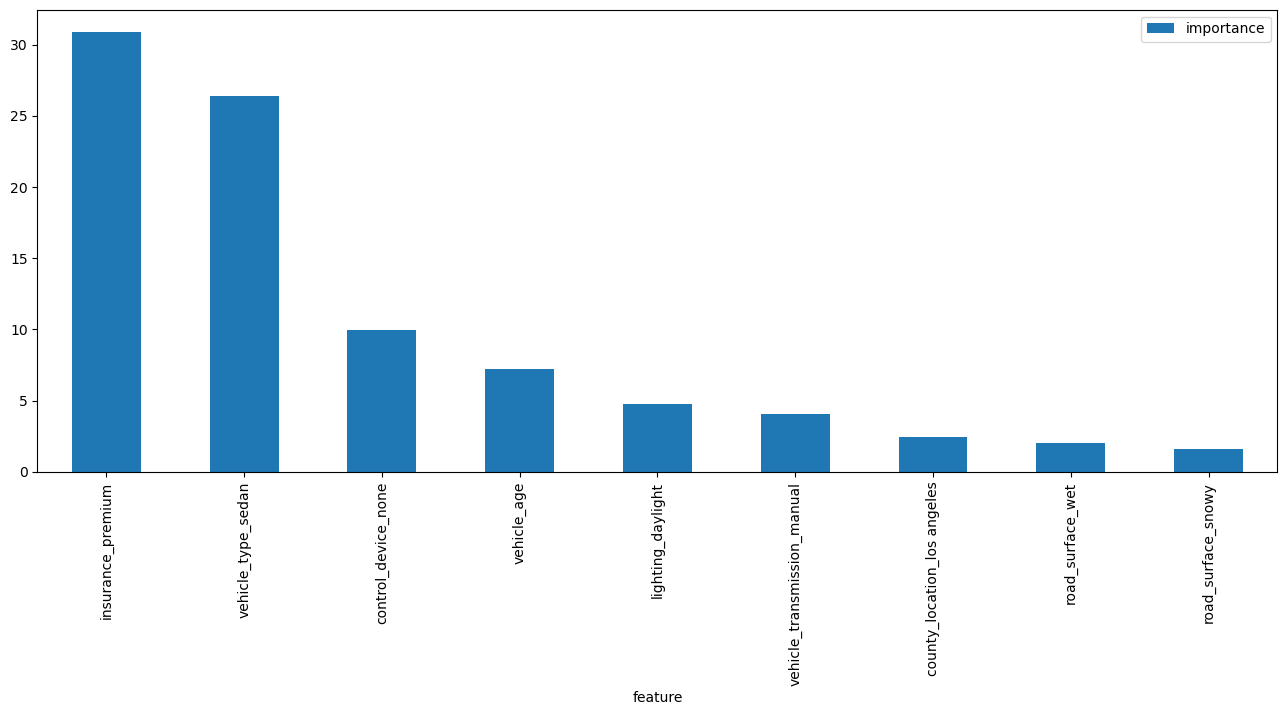

In [145]:
features_importance_cb(
    best_model_cb, 
    features_num=9, 
    least_important=False, 
    show_plot=True
)

**In the first place is insurance_premium, which tells us about the amount of insurance premiums. Let's analyze it**

In [146]:
sns.boxplot(data=df[['insurance_premium', 'at_fault']], x='at_fault', y='insurance_premium')
plt.show()

As you can see from this graph, drivers who are found guilty of an accident have lower insurance premiums on average

Let's check how the classes are distributed depending on the **control device**

In [147]:
X.join(y)[['control_device', 'at_fault']].groupby(['control_device', 'at_fault']).agg({'control_device': 'count'})

control_device
control_device  at_fault                
functioning     0                   9753
                1                   7774
none            0                  17187
                1                  19697
not functioning 0                     57
                1                     55
obscured        0                     15
                1                     14

Conclusions from the table: drivers without a control device are more often guilty

Let's check how the classes are distributed depending on the **vehicle type**

In [148]:
X.join(y)[['vehicle_type', 'at_fault']].groupby(['vehicle_type', 'at_fault']).agg({'vehicle_type': 'count'})

vehicle_type
vehicle_type at_fault              
coupe        0                 7290
             1                11745
other        0                    2
             1                    2
sedan        0                19720
             1                15793

Conclusions from the table: drivers with a coupe-type body are more often found guilty of an accident than drivers with a sedan-type body. An interesting pattern, but the assumption of root causes is difficult to identify. You can make a cautious suggestion that you need to buy more sedans for the fleet, but only after additional analysis

Let's check how **the age of the car** affects the likelihood of an accident

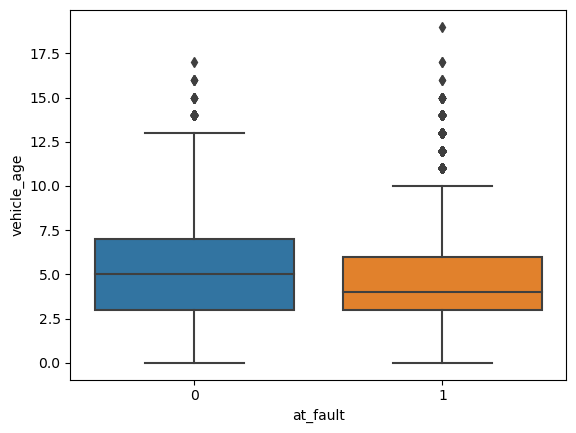

In [149]:
sns.boxplot(data=df[['vehicle_age', 'at_fault']], x='at_fault', y='vehicle_age')
plt.show()

On average, the cars responsible for the accident are slightly newer

#  The general conclusion of the model

* As a result of this project, 4 models were created: logistic regression, decision tree, random forest and catboost. Catboost performed best in all three metrics (precision, recall, roc-auc)

* As for me, the model turned out to be insufficiently accurate. I can assume that this happened for the following reasons

    * could have misunderstood the task
    * I think it would be possible to try to take data for a longer period, and not just limit it to 2012
    * many features have been abandoned due to the fact that they appear after an accident
    
* It is likely that additional factors such as the number of accidents involving the driver, the number of intersections on the way, and the length of the created route could be used to improve the model

* One of the significant parameters is the presence/absence of a control system. If you install control devices, this can reduce the risk of an accident for drivers (judging by the analysis above)
    
* You can consider an option with built-in breathalyzers with the need for periodic checks to reduce accidents with drivers under the influence of alcohol